In [1]:
import sys
if "../" not in sys.path:
    sys.path.insert(0, "../")

import collections
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ecoli.library import fba_gd

## Define reactions, exchanges, objective compoenents

In [2]:
Reaction = collections.namedtuple("Reaction", ["id", "stoichiometry", "reversible"])

rxn_by_id = {}
for rxn in [
        {'reaction id': 'ASPTA', 'stoichiometry': {'akg': -1.0, 'asp': -1.0, 'glu': 1.0, 'oaa': 1.0}, 'is reversible': True},
        {'reaction id': 'ASNN', 'stoichiometry': {'asn': -1.0, 'h2o': -1.0, 'asp': 1.0, 'nh4': 1.0}, 'is reversible': False},
        {'reaction id': 'ASPK', 'stoichiometry': {'asp': -1.0, 'atp': -1.0, '4pasp': 1.0, 'adp': 1.0}, 'is reversible': True},
        {'reaction id': 'ASAD','stoichiometry': {'aspsa': -1.0, 'nadp': -1.0, 'pi': -1.0, '4pasp': 1.0, 'h': 1.0, 'nadph': 1.0}, 'is reversible': True},
        {'reaction id': 'DHDPS', 'stoichiometry': {'aspsa': -1.0, 'pyr': -1.0, '23dhdp': 1.0, 'h2o': 2.0, 'h': 1.0}, 'is reversible': False},
        {'reaction id': 'DHDPRy', 'stoichiometry': {'23dhdp': -1.0, 'h': -1.0, 'nadph': -1.0, 'nadp': 1.0, 'thdp': 1.0}, 'is reversible': False},
        {'reaction id': 'THDPS', 'stoichiometry': {'h2o': -1.0, 'succoa': -1.0, 'thdp': -1.0, 'coa': 1.0, 'sl2a6o': 1.0}, 'is reversible': False},
        {'reaction id': 'SDPTA', 'stoichiometry': {'akg': -1.0, 'sl26da': -1.0, 'glu': 1.0, 'sl2a6o': 1.0}, 'is reversible': True},
        {'reaction id': 'SDPDS', 'stoichiometry': {'h2o': -1.0, 'sl26da': -1.0, '26dap_LL': 1.0, 'succ': 1.0}, 'is reversible': False},
        {'reaction id': 'DAPE', 'stoichiometry': {'26dap_LL': -1.0, '26dap__M': 1.0}, 'is reversible': True},
        {'reaction id': 'DAPDC', 'stoichiometry': {'26dap__M': -1.0, 'h': -1.0, 'co2': 1.0, 'lys': 1.0}, 'is reversible': False},
        {'reaction id': 'HSDy', 'stoichiometry': {'hom': -1.0, 'nadp': -1.0, 'aspsa': 1.0, 'h': 1.0, 'nadph': 1.0}, 'is reversible': True},
        {'reaction id': 'HSK', 'stoichiometry': {'atp': -1.0, 'hom': -1.0, 'adp': 1.0, 'h': 1.0, 'phom': 1.0}, 'is reversible': False},
        {'reaction id': 'THRS', 'stoichiometry': {'h2o': -1.0, 'phom': -1.0, 'pi': 1.0, 'thr': 1.0}, 'is reversible': False},
        {'reaction id': 'HSST', 'stoichiometry': {'hom': -1.0, 'succoa': -1.0, 'coa': 1.0, 'suchms': 1.0}, 'is reversible': False},
        {'reaction id': 'SHSL1', 'stoichiometry': {'cys': -1.0, 'suchms': -1.0, 'cyst': 1.0, 'h': 1.0, 'succ': 1.0}, 'is reversible': False},
        {'reaction id': 'CYSTL', 'stoichiometry': {'cyst': -1.0, 'h2o': -1.0, 'hcys': 1.0, 'nh4': 1.0, 'pyr': 1.0}, 'is reversible': False},
        {'reaction id': 'METS', 'stoichiometry': {'5mthf': -1.0, 'hcys': -1.0, 'h': 1.0, 'met': 1.0, 'thf': 1.0}, 'is reversible': False},
    ]:
    rxn_by_id[rxn["reaction id"]] = Reaction(rxn["reaction id"],
                                             rxn["stoichiometry"],
                                             rxn["is reversible"])

rxn_by_met = collections.defaultdict(list)  # met -> [rxn, ]
for rxn in rxn_by_id.values():
    for met in rxn.stoichiometry:
        rxn_by_met[met].append(rxn)

print(f"{len(rxn_by_id)} reactions on {len(rxn_by_met)} metabolites")

exchanges = {'5mthf', 'adp', 'akg', 'atp', 'co2', 'coa', 'cys',
             'glu', 'h2o', 'h', 'nadp', 'nadph', 'nh4', 'oaa', 'pi',
             'pyr', 'succ', 'succoa', 'thf'}
objective = {
#     "asn": 0.6,  # Unmeetable with irreversible ASNN
    "asp": 1.0,
    "lys": 0.9,
    "met": 0.5,
    "thr": 2.
}

intermediates = rxn_by_met.keys() - objective.keys() - exchanges
print(f"{len(exchanges)} exchanges, {len(objective)} objective components, {len(intermediates)} intermediates")


18 reactions on 37 metabolites
19 exchanges, 4 objective components, 14 intermediates


## Pure intermediates and net reactions
- Focus only on simplest case for now: a non-exchanged metabolite involved in exactly two reactions. For all possible steady-state solutions, the velocties of these two reactions must be equal (including when both are zero). In such cases we can combine the reactions and drop the intermediate.
- This extends to chains of such reactions. The result is a single net reaction, whose velocity in the solution equals the velocity of each reaction in the chain when expanded.
- A wrinkle is to respect irreversibility: two irreversible reactions producing or consuming the same intermediate cannot chain.
  - But the constraint metioned above still applies: these reaction _must_ have identical but opposite fluxes. The only way to satisfy this is if they are zero. So that intermediate is a dead end.

### Strategy
- Building block (link) is a tuple, (reaction, direction, metabolite), where the reaction _produces_ the metabolite in the specified direction.
  - Confined to intermediates, i.e. metabolites that participate in exactly two reactions.
- Chains consist of ordered (reaction, metabolite) links where the next reaction consumes the metabolite produced by the previous one.
  - The last metabolite in the chain is by defintion consumed by one reaction, but that reaction is not itself part of a tuple.
- Reversible reactions are represented with links for each direction. But such links cannot chain.
- Every link is part of exactly one chain


In [3]:
def generate_link_keys(met, rxn1, rxn2):
    """Produces links only when sequential reactions produce and consume a metabolite."""
    def valid(rxn, met, effect):
        """Tests whether rxn may validly produce (+1) or consume (-1) met."""
        if rxn.reversible:
            return True
        else:
            return rxn.stoichiometry[met] * effect > 0

    # rxn1 -> met -> rxn2?
    if valid(rxn1, met, +1) and valid(rxn2, met, -1):
        yield (rxn1.id, +1 if rxn1.stoichiometry[met] > 0 else -1)

    # rxn2 -> met -> rxn1?
    if valid(rxn2, met, +1) and valid(rxn1, met, -1):
        yield (rxn2.id, +1 if rxn2.stoichiometry[met] > 0 else -1)

# Start with a pool of links indexed by (rxn_id, dir)
links = {}
branches = collections.defaultdict(list)
for met in intermediates:
    # Filter to "true" intermediates, between two sequential reactions.
    if len(rxn_by_met[met]) == 2:
        for key in generate_link_keys(met, *rxn_by_met[met]):
            if key in links:
                branches[key].append(met)
            else:
                links[key] = met

# Need to deal intelligently with branches...
for key in branches:
    branches[key].append(links.pop(key))

print(f"{len(links)} reaction -> intermediate links")

# Chains indexed by first (rxn_id, dir)
chains = {}
while links:
    # Start with any link, and build a chain downstream.
    start = next(iter(links))
    chain = []
    key = start
    while key in links:
        met = links.pop(key)
        chain.append((key, met))

        # Build the next key based on a reaction that consumes the terminal met.
        assert len(rxn_by_met[met]) == 2
        if rxn_by_met[met][0].id == key[0]:
            rxn = rxn_by_met[met][1]
        else:
            assert rxn_by_met[met][1].id == key[0]
            rxn = rxn_by_met[met][0]
        
        key = (rxn.id, +1 if rxn.stoichiometry[met] < 0 else -1)
    
    # The would-be extension may have anchored a previous chain; if so, prepend this one.
    if key in chains:
        chain.extend(chains.pop(key))
    # Otherwise record the final key as the terminal reaction
    else:
        chain.append((key, None))
    
    chains[start] = chain

print(f"{len(chains)} chains encompassing {sum(len(chain) for chain in chains.values())} reactions")
print("Length distribution:")
len_dist = sorted(collections.Counter(len(chain) for chain in chains.values()).items(),
                  key=lambda x: -x[0])
for l, count in len_dist:
    print(f"{l:>5}: {count}")
        

12 reaction -> intermediate links
5 chains encompassing 17 reactions
Length distribution:
    7: 1
    4: 1
    2: 3


In [4]:
# Now process each chain into a net reaction, eliminating intermediates and
# encompassed reactions. Work in order of descending length, and drop redundant
# opposite-direction chains

class NetReaction:
    def __init__(self, id):
        self.id = id
        self._stoich = collections.defaultdict(int)
        self.reversible = True
        self.reactions = []
        self.intermediates = []
        
    def add_reaction(self, rxn, multiplier, intermediate=None):
        self.reactions.append((rxn, multiplier))
        for met, count in rxn.stoichiometry.items():
            self._stoich[met] += count * multiplier
        self.reversible = self.reversible and rxn.reversible
        if intermediate:
            self.intermediates.append(intermediate)
    
    @property
    def stoichiometry(self):
        return {met: count for met, count in self._stoich.items() if count != 0}
    
    def __repr__(self):
        def rxn_str(rxn, multiplier):
            if multiplier == +1:
                return "+" + rxn.id
            elif multiplier == -1:
                return "-" + rxn.id
            else:
                return f"{multiplier:+2i} {rxn.id}"
            
        lines = [f"{self.id} [{' '.join([rxn_str(rxn, multiplier) for rxn, multiplier in self.reactions])}]",
                 f"    via [{', '.join(self.intermediates)}] {'<=>' if rxn.reversible else '-->'}"]
        for met, count in sorted(rxn.stoichiometry.items(),
                                 key=lambda x: (x[1], x[0])):
            lines.append(f"{count:>6}  {met}")
        return "\n".join(lines)

    
    
    
net_rxns = {}
contained_by = {}
eliminated_by = {}
for i, chain in enumerate(sorted(chains.values(), key=lambda x: -len(x))):
    net_rxn = NetReaction(f"chain-{i}")    
    for (rxn_id, direction), intermediate in chain:
        if rxn_id in contained_by:
            break
        net_rxn.add_reaction(rxn_by_id[rxn_id], direction, intermediate)
        contained_by[rxn_id] = net_rxn.id
    
    # Skip chains with no contained rxns
    if net_rxn.reactions:
        # Maybe do something more intelligent with aborted chains?
        net_stoich = net_rxn.stoichiometry
        for met in net_rxn.intermediates:
            if met not in net_stoich:
                eliminated_by[met] = net_rxn.id
                
        net_rxns[net_rxn.id] = net_rxn
        

print(f"{len(net_rxns)} net reactions," 
      f" encompassing {len(contained_by)} original reactions,"
      f" eliminating {len(eliminated_by)} intermediates")

4 net reactions, encompassing 15 original reactions, eliminating 11 intermediates


In [5]:
for rxn in net_rxns.values():
    print(rxn)
    print()

chain-0 [+DHDPS +DHDPRy +THDPS -SDPTA +SDPDS +DAPE +DAPDC]
    via [23dhdp, thdp, sl2a6o, sl26da, 26dap_LL, 26dap__M] -->
  -1.0  aspsa
  -1.0  glu
  -1.0  h
  -1.0  nadph
  -1.0  pyr
  -1.0  succoa
   1.0  akg
   1.0  co2
   1.0  coa
   1.0  lys
   1.0  nadp
   1.0  succ

chain-1 [+HSST +SHSL1 +CYSTL +METS]
    via [suchms, cyst, hcys] -->
  -1.0  5mthf
  -1.0  cys
  -1.0  h2o
  -1.0  hom
  -1.0  succoa
   1.0  coa
   1.0  met
   1.0  nh4
   1.0  pyr
   1.0  succ
   1.0  thf
   2.0  h

chain-2 [+HSK +THRS]
    via [phom] -->
  -1.0  atp
  -1.0  h2o
  -1.0  hom
   1.0  adp
   1.0  h
   1.0  pi
   1.0  thr

chain-3 [+ASPK -ASAD]
    via [4pasp] <=>
  -1.0  asp
  -1.0  atp
  -1.0  h
  -1.0  nadph
   1.0  adp
   1.0  aspsa
   1.0  nadp
   1.0  pi



## FBA - GD Comparison

In [6]:
def rxn_dict(rxn):
    return {"reaction id": rxn.id,
            "stoichiometry": rxn.stoichiometry,
            "is reversible": rxn.reversible}

# Compare Original and Simplified Networks
original = []
simplified = []
included = set()

for rxn in rxn_by_id.values():
    original.append(rxn_dict(rxn))
    if rxn.id not in contained_by:
        simplified.append(rxn_dict(rxn))
    else:
        net_rxn = net_rxns[contained_by[rxn.id]]
        if net_rxn.id not in included:
            simplified.append(rxn_dict(net_rxn))
            included.add(net_rxn.id)

fba_original = fba_gd.GradientDescentFba(original, exchanges, objective)
fba_original.add_objective("homeostatic",
                           fba_gd.TargetDmdtObjective(fba_original.network, objective))

fba_simplified = fba_gd.GradientDescentFba(simplified, exchanges, objective)
fba_simplified.add_objective("homeostatic",
                             fba_gd.TargetDmdtObjective(fba_simplified.network, objective))

print(f"{fba_original.network.shape} -> {fba_simplified.network.shape}")

(37, 18) -> (26, 7)


In [7]:
pd.DataFrame(
    fba_original.network.s_matrix,
    index=fba_original.network.molecule_ids(),
    columns=fba_original.network.reaction_ids(),
)

,ASPTA,ASNN,ASPK,ASAD,DHDPS,DHDPRy,THDPS,SDPTA,SDPDS,DAPE,DAPDC,HSDy,HSK,THRS,HSST,SHSL1,CYSTL,METS
akg,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
asp,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
glu,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oaa,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
asn,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
h2o,0.0,-1.0,0.0,0.0,2.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0
nh4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
atp,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
4pasp,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adp,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
pd.DataFrame(
    fba_simplified.network.s_matrix,
    index=fba_simplified.network.molecule_ids(),
    columns=fba_simplified.network.reaction_ids(),
)

,ASPTA,ASNN,chain-3,chain-0,HSDy,chain-2,chain-1
akg,-1.0,0.0,0.0,1.0,0.0,0.0,0.0
asp,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0
glu,1.0,0.0,0.0,-1.0,0.0,0.0,0.0
oaa,1.0,0.0,0.0,0.0,0.0,0.0,0.0
asn,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
h2o,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0
nh4,0.0,1.0,0.0,0.0,0.0,0.0,1.0
atp,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0
adp,0.0,0.0,1.0,0.0,0.0,1.0,0.0
aspsa,0.0,0.0,1.0,-1.0,1.0,0.0,0.0


In [9]:
%timeit fba_original.solve({"homeostatic": objective})
soln_original = fba_original.solve({"homeostatic": objective})
print(f"RMSE {np.sqrt(np.mean(np.square(soln_original.ss_residual))):.2e}")
print()

%timeit fba_simplified.solve({"homeostatic": objective})
soln_simplified = fba_simplified.solve({"homeostatic": objective})
print(f"RMSE {np.sqrt(np.mean(np.square(soln_simplified.ss_residual))):.2e}")


# Reconstitute the solution to the original problem from the simplified result
dmdt_simplified = {}
for met in fba_original.network.molecule_ids():
    if met in soln_simplified.dm_dt:
        dmdt_simplified[met] = soln_simplified.dm_dt[met]
    elif met in eliminated_by:
        dmdt_simplified[met] = 0
    else:
        raise ValueError(f"{met} is unaccounted for.")

v_simplified = {}
for rxn_id in fba_original.network.reaction_ids():
    if rxn_id in soln_simplified.velocities:
        v_simplified[rxn_id] = soln_simplified.velocities[rxn_id]
for net_rxn in net_rxns.values():
    for rxn, multiplier in net_rxn.reactions:
        v_simplified[rxn.id] = soln_simplified.velocities[net_rxn.id] / multiplier


175 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
RMSE 5.43e-08

136 ms ± 977 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
RMSE 3.18e-08


Builder(menu='zoom', metabolite_data={'akg': 5.299999773196189, 'asp': 0.9999998162324637, 'glu': -5.299999773…

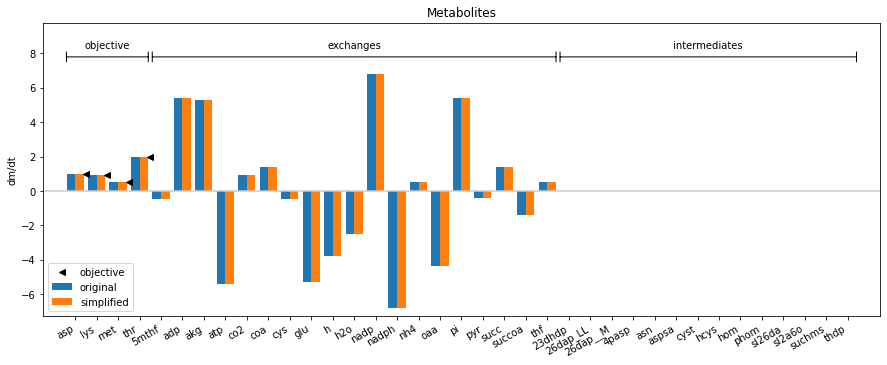

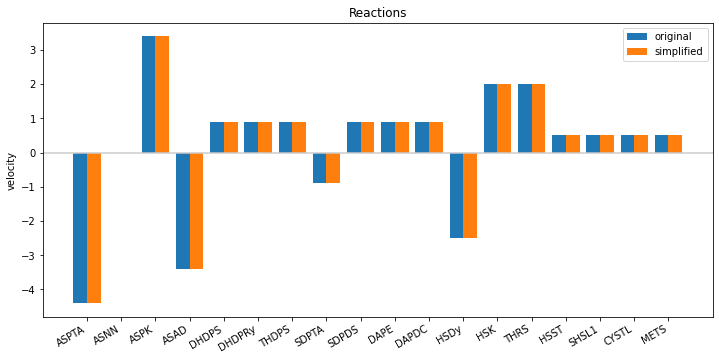

In [10]:
import matplotlib.patches as mpatches
import escher

with open('FBAgd-demo-eschermap.json', 'r') as f:
    model_json_str = f.read().replace("_c", "").replace("__L", "")
    
display(escher.Builder(map_json=model_json_str,
                       menu='zoom',
                       never_ask_before_quit=True,
                       reaction_data=v_simplified,
                       reaction_styles=['color', 'size', 'abs'],
                       metabolite_data=dmdt_simplified,
                       metabolite_styles=['color'],
                       metabolite_scale_preset='RdYlBu',
                      ))

mets = [
    *sorted(objective.keys()),
    *sorted(exchanges),
    *sorted(intermediates),
]
met_x=np.arange(len(mets))
# (start, len)
regions = {
    "objective": (0, len(objective)),
    "exchanges": (len(objective), len(exchanges)),
    "intermediates": (len(objective) + len(exchanges), len(intermediates))
}

y0 = [soln_original.dm_dt[met] for met in mets]
y1 = [dmdt_simplified[met] for met in mets]
labely = max(max(y0), max(y1)) + 1

fig, ax = plt.subplots(figsize=(15, 6))
ax.axhline(0, color="#ccc")
ax.bar(met_x - .2, y0, .4, label="original")
ax.bar(met_x + .2, y1, .4, label="simplified")
ax.plot(np.arange(len(objective)) + 0.5,
        [objective[met] for met in mets[:len(objective)]],
        marker="<",
        lw=0,
        color="black",
        label="objective")

ax.legend()
ax.set_title("Metabolites")
ax.set_ylabel('dm/dt')
ax.set_xticks(met_x)
ax.set_xticklabels(mets)
fig.autofmt_xdate()

for label, pos in regions.items():
    ax.add_patch(mpatches.FancyArrowPatch(posA=(pos[0] - .5, labely),
                                          posB=(sum(pos) - .5, labely),
                                          arrowstyle="|-|, widthA=5, widthB=5"))
    plt.text(pos[0]+pos[1]/2 - .5, labely + 0.5, label, ha="center")
ax.set_ylim(min(min(y0), min(y1)) - 0.5, labely + 2)
ax.set_xlim(-1.5, len(mets) + .5)

plt.show()

rxn_x=np.arange(len(rxn_by_id))

fig, ax = plt.subplots(figsize=(12, 6))
ax.axhline(0, color="#ccc")
ax.bar(rxn_x - .2, [soln_original.velocities[rxn_id] for rxn_id in rxn_by_id], .4, label="original")
ax.bar(rxn_x + .2, [v_simplified[rxn_id] for rxn_id in rxn_by_id], .4, label="simplified")

ax.set_title("Reactions")
ax.legend()
ax.set_ylabel("velocity")
ax.set_xticks(rxn_x)
ax.set_xticklabels(rxn_by_id.keys())
fig.autofmt_xdate()

plt.show()

## Dead ends
- For a non-exchanged metabolite involved in only 1 reaction, that reaction cannot possibly have non-zero flux at steady-state. The metabolite is a dead end, and the reaction can be dropped from the network for the purposes of FBA.
- It may be worth looking at all of these to confirm they are in fact irrelevant; that is a modeling decision. But given a model definition, dropping such reactions is correct.
- Same logic applies to chains as above. A dead end forces flux through the full chain to be zero.

In [11]:
endpoints = {met for met, rxns in rxn_by_met.items() if len(rxns) == 1}
print(f"{len(endpoints)} endpoints (metabolites participicating in exactly one reaction)")
dead_ends = intermediates & endpoints
print(f"{len(dead_ends)} of them are neither exchanges nor objectives, therefore dead-ends")
dead_ends

9 endpoints (metabolites participicating in exactly one reaction)
1 of them are neither exchanges nor objectives, therefore dead-ends


{'asn'}

In [12]:
excluded = set()
for met in dead_ends:
    excluded.update(rxn.id for rxn in rxn_by_met[met])
fba_s2 = fba_gd.GradientDescentFba((rxn for rxn in simplified if rxn["reaction id"] not in excluded), exchanges, objective)
fba_s2.add_objective("homeostatic", fba_gd.TargetDmdtObjective(fba_s2.network, objective))

print(fba_s2.network.shape)
pd.DataFrame(
    fba_s2.network.s_matrix,
    index=fba_s2.network.molecule_ids(),
    columns=fba_s2.network.reaction_ids(),
)

(25, 6)


,ASPTA,chain-3,chain-0,HSDy,chain-2,chain-1
akg,-1.0,0.0,1.0,0.0,0.0,0.0
asp,-1.0,-1.0,0.0,0.0,0.0,0.0
glu,1.0,0.0,-1.0,0.0,0.0,0.0
oaa,1.0,0.0,0.0,0.0,0.0,0.0
atp,0.0,-1.0,0.0,0.0,-1.0,0.0
adp,0.0,1.0,0.0,0.0,1.0,0.0
aspsa,0.0,1.0,-1.0,1.0,0.0,0.0
nadp,0.0,1.0,1.0,-1.0,0.0,0.0
pi,0.0,1.0,0.0,0.0,1.0,0.0
h,0.0,-1.0,-1.0,1.0,1.0,2.0


171 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
RMSE 7.70e-08


Builder(menu='zoom', metabolite_data={'akg': 5.299999916394605, 'asp': 0.9999999169286768, 'glu': -5.299999916…

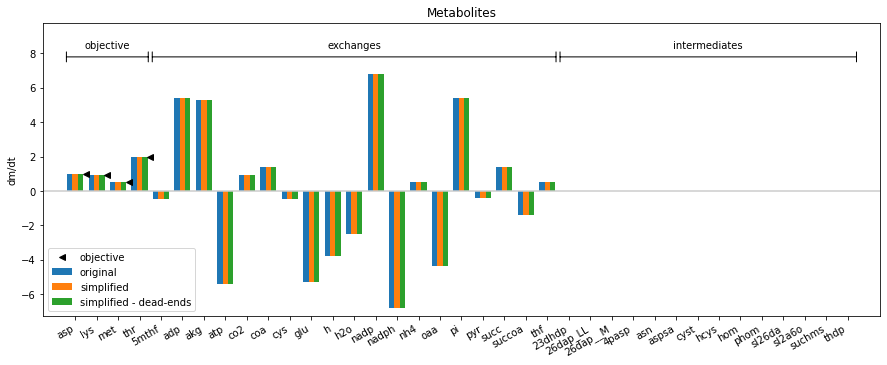

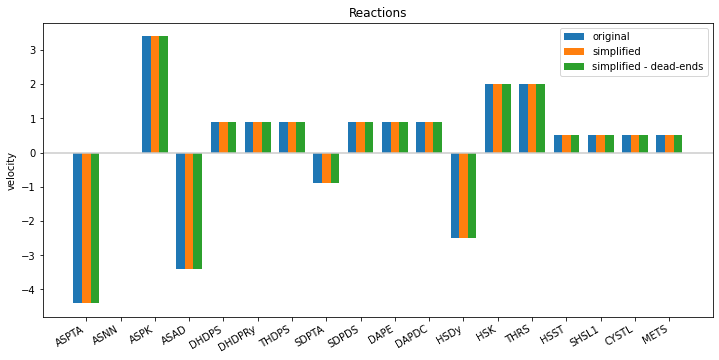

In [13]:
%timeit fba_s2.solve({"homeostatic": objective})
soln_s2 = fba_s2.solve({"homeostatic": objective})
print(f"RMSE {np.sqrt(np.mean(np.square(soln_s2.ss_residual))):.2e}")


# Reconstitute the solution to the original problem from the simplified result
dmdt_s2 = {}
for met in fba_original.network.molecule_ids():
    if met in soln_s2.dm_dt:
        dmdt_s2[met] = soln_s2.dm_dt[met]
    else:
        dmdt_s2[met] = 0

v_s2 = {}
for rxn_id in fba_original.network.reaction_ids():
    if rxn_id in soln_s2.velocities:
        v_s2[rxn_id] = soln_s2.velocities[rxn_id]
for net_rxn in net_rxns.values():
    for rxn, multiplier in net_rxn.reactions:
        v_s2[rxn.id] = soln_s2.velocities[net_rxn.id] / multiplier
for rxn_id in excluded:
    v_s2[rxn_id] = 0

display(escher.Builder(map_json=model_json_str,
                       menu='zoom',
                       never_ask_before_quit=True,
                       reaction_data=v_s2,
                       reaction_styles=['color', 'size', 'abs'],
                       metabolite_data=dmdt_s2,
                       metabolite_styles=['color'],
                       metabolite_scale_preset='RdYlBu',
                      ))

y0 = [soln_original.dm_dt[met] for met in mets]
y1 = [dmdt_simplified[met] for met in mets]
y2 = [dmdt_s2[met] for met in mets]
labely = max(max(y0), max(y1), max(y2)) + 1

fig, ax = plt.subplots(figsize=(15, 6))
ax.axhline(0, color="#ccc")
ax.bar(met_x - .25, y0, .25, label="original")
ax.bar(met_x, y1, .25, label="simplified")
ax.bar(met_x + .25, y2, .25, label="simplified - dead-ends")
ax.plot(np.arange(len(objective)) + 0.5,
        [objective[met] for met in mets[:len(objective)]],
        marker="<",
        lw=0,
        color="black",
        label="objective")

ax.legend()
ax.set_title("Metabolites")
ax.set_ylabel('dm/dt')
ax.set_xticks(met_x)
ax.set_xticklabels(mets)
fig.autofmt_xdate()

for label, pos in regions.items():
    ax.add_patch(mpatches.FancyArrowPatch(posA=(pos[0] - .5, labely),
                                          posB=(sum(pos) - .5, labely),
                                          arrowstyle="|-|, widthA=5, widthB=5"))
    plt.text(pos[0]+pos[1]/2 - .5, labely + 0.5, label, ha="center")
ax.set_ylim(min(min(y0), min(y1), min(y2)) - 0.5, labely + 2)
ax.set_xlim(-1.5, len(mets) + .5)

plt.show()

rxn_x=np.arange(len(rxn_by_id))

fig, ax = plt.subplots(figsize=(12, 6))
ax.axhline(0, color="#ccc")
ax.bar(rxn_x - .25, [soln_original.velocities[rxn_id] for rxn_id in rxn_by_id], .25, label="original")
ax.bar(rxn_x, [v_simplified[rxn_id] for rxn_id in rxn_by_id], .25, label="simplified")
ax.bar(rxn_x + .25, [v_s2[rxn_id] for rxn_id in rxn_by_id], .25, label="simplified - dead-ends")

ax.set_title("Reactions")
ax.legend()
ax.set_ylabel("velocity")
ax.set_xticks(rxn_x)
ax.set_xticklabels(rxn_by_id.keys())
fig.autofmt_xdate()

plt.show()

# Try it on a large network

In [14]:
def combine_chains(rxns, connected_mets):
    rxn_by_id = {rxn.id: rxn for rxn in rxns}
    rxn_by_met = collections.defaultdict(list)  # met -> [rxn, ]
    for rxn in rxn_by_id.values():
        for met in rxn.stoichiometry:
            rxn_by_met[met].append(rxn)

    connected_mets = set(connected_mets)
    intermediates = rxn_by_met.keys() - connected_mets
    print(f"{len(rxn_by_id)} reactions on {len(rxn_by_met)} metabolites")
    print(f"{len(connected_mets)} connected mets, {len(intermediates)} intermediates")

    # Start with a pool of links indexed by (rxn_id, dir)
    links = {}
    branches = collections.defaultdict(list)
    for met in intermediates:
        # Filter to "true" intermediates, between two sequential reactions.
        if len(rxn_by_met[met]) == 2:
            for key in generate_link_keys(met, *rxn_by_met[met]):
                if key in links:
                    branches[key].append(met)
                else:
                    links[key] = met

    for key in branches:
        branches[key].append(links.pop(key))

    print(f"{len(links)} reaction -> intermediate links")

    # Chains indexed by first (rxn_id, dir)
    chains = {}
    while links:
        # Start with any link, and build a chain downstream.
        start = next(iter(links))
        chain = []
        key = start
        while key in links:
            met = links.pop(key)
            chain.append((key, met))

            # Build the next key based on a reaction that consumes the terminal met.
            assert len(rxn_by_met[met]) == 2
            if rxn_by_met[met][0].id == key[0]:
                rxn = rxn_by_met[met][1]
            else:
                assert rxn_by_met[met][1].id == key[0]
                rxn = rxn_by_met[met][0]

            key = (rxn.id, +1 if rxn.stoichiometry[met] < 0 else -1)

        # The would-be extension may have anchored a previous chain; if so, prepend this one.
        if key in chains:
            chain.extend(chains.pop(key))
        # Otherwise record the final key as the terminal reaction
        else:
            chain.append((key, None))

        chains[start] = chain

    print(f"{len(chains)} chains encompassing {sum(len(chain) for chain in chains.values())} reactions")
    print("Length distribution:")
    len_dist = sorted(collections.Counter(len(chain) for chain in chains.values()).items(),
                      key=lambda x: -x[0])
    for l, count in len_dist:
        print(f"{l:>5}: {count}")

    net_rxns = {}
    contained_by = {}
    eliminated_by = {}
    for i, chain in enumerate(sorted(chains.values(), key=lambda x: -len(x))):
        net_rxn = NetReaction(f"chain-{i}")    
        for (rxn_id, direction), intermediate in chain:
            if rxn_id in contained_by:
                break
            net_rxn.add_reaction(rxn_by_id[rxn_id], direction, intermediate)
            contained_by[rxn_id] = net_rxn.id

        # Skip chains with no contained rxns
        if net_rxn.reactions:
            net_stoich = net_rxn.stoichiometry
            for met in net_rxn.intermediates:
                if met not in net_stoich:
                    eliminated_by[met] = net_rxn.id

            net_rxns[net_rxn.id] = net_rxn

    print(f"{len(net_rxns)} net reactions," 
          f" encompassing {len(contained_by)} original reactions,"
          f" eliminating {len(eliminated_by)} intermediates")

    result = net_rxns.copy()
    for rxn in rxn_by_id.values():
        if rxn.id not in contained_by:
            result[rxn.id] = rxn
    print(f"Result: {len(result)} reactions on {len(rxn_by_met) - len(eliminated_by)} metabolites")
    
    return result, net_rxns, contained_by

    
_ = combine_chains(rxn_by_id.values(), exchanges | objective.keys())

18 reactions on 37 metabolites
23 connected mets, 14 intermediates
12 reaction -> intermediate links
5 chains encompassing 17 reactions
Length distribution:
    7: 1
    4: 1
    2: 3
4 net reactions, encompassing 15 original reactions, eliminating 11 intermediates
Result: 7 reactions on 26 metabolites


In [15]:
full_metabolism = {}
for rxn in [{'reaction id': '1.1.1.127-RXN', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, '2-DEHYDRO-3-DEOXY-D-GLUCONATE[c]': -1, 'CPD-343[c]': 1, 'NAD[c]': -1}, 'is reversible': True}, {'reaction id': '1.1.1.215-RXN', 'stoichiometry': {'NADPH[c]': -1, 'GLUCONATE[c]': 1, 'CPD-377[c]': -1, 'PROTON[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': '1.1.1.262-RXN', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, '2-AMINO-3-OXO-4-PHOSPHONOOXYBUTYRATE[c]': 1, 'NAD[c]': -1, '4-PHOSPHONOOXY-THREONINE[c]': -1}, 'is reversible': False}, {'reaction id': '1.1.1.264-RXN-L-IDONATE/NAD//5-DEHYDROGLUCONATE/NADH/PROTON.46.', 'stoichiometry': {'NADH[c]': -1, 'L-IDONATE[c]': 1, 'PROTON[c]': -1, 'NAD[c]': 1, '5-DEHYDROGLUCONATE[c]': -1}, 'is reversible': True}, {'reaction id': '1.1.1.264-RXN-L-IDONATE/NADP//5-DEHYDROGLUCONATE/NADPH/PROTON.48.', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'L-IDONATE[c]': -1, 'PROTON[c]': 1, '5-DEHYDROGLUCONATE[c]': 1}, 'is reversible': True}, {'reaction id': '1.1.1.274-RXN', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'CPD-377[c]': 1, '25-DIDEHYDRO-D-GLUCONATE[c]': -1, 'PROTON[c]': -1}, 'is reversible': False}, {'reaction id': '1.1.1.283-RXN', 'stoichiometry': {'NADPH[c]': -1, 'METHYL-GLYOXAL[c]': -1, 'PROTON[c]': -1, 'LACTALD[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': '1.1.1.39-RXN', 'stoichiometry': {'NADH[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'MAL[c]': -1, 'PYRUVATE[c]': 1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': '1.1.1.83-RXN', 'stoichiometry': {'NADH[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'PYRUVATE[c]': 1, 'CPD-660[c]': -1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': '1.2.99.7-RXN-ACETALD/FAD/WATER//ACET/FADH2.30.', 'stoichiometry': {'ACET[p]': -1, 'WATER[p]': 1, 'FADH2[p]': -1, 'ACETALD[p]': 1, 'FAD[p]': 1}, 'is reversible': True}, {'reaction id': '1.2.99.7-RXN-BENZALDEHYDE/FAD/WATER//BENZOATE/FADH2.39.', 'stoichiometry': {'WATER[p]': 1, 'BENZALDEHYDE[p]': 1, 'FADH2[p]': -1, 'BENZOATE[p]': -1, 'FAD[p]': 1}, 'is reversible': True}, {'reaction id': '1.2.99.7-RXN-CPD-371/FAD/WATER//CPD-195/FADH2.33.', 'stoichiometry': {'WATER[p]': -1, 'FADH2[p]': 1, 'FAD[p]': -1, 'CPD-195[p]': 1, 'CPD-371[p]': -1}, 'is reversible': True}, {'reaction id': '1.2.99.7-RXN-CPD-665/FAD/WATER//PROPIONATE/FADH2.36.', 'stoichiometry': {'PROPIONATE[p]': 1, 'WATER[p]': -1, 'FADH2[p]': 1, 'FAD[p]': -1, 'CPD-665[p]': -1}, 'is reversible': True}, {'reaction id': '1.2.99.7-RXN-CPD-8490/FAD/WATER//CPD-3617/FADH2.35.', 'stoichiometry': {'CPD-8490[p]': 1, 'WATER[p]': 1, 'FADH2[p]': -1, 'CPD-3617[p]': -1, 'FAD[p]': 1}, 'is reversible': True}, {'reaction id': '1.2.99.7-RXN-HEXANAL/FAD/WATER//HEXANOATE/FADH2.35.', 'stoichiometry': {'WATER[p]': 1, 'HEXANOATE[p]': -1, 'FAD[p]': 1, 'HEXANAL[p]': 1, 'FADH2[p]': -1}, 'is reversible': True}, {'reaction id': '1.2.99.7-RXN-HYDRPHENYLAC-CPD/FAD/WATER//3-HYDROXYPHENYLACETATE/FADH2.57.', 'stoichiometry': {'3-HYDROXYPHENYLACETATE[p]': 1, 'WATER[p]': -1, 'HYDRPHENYLAC-CPD[p]': -1, 'FADH2[p]': 1, 'FAD[p]': -1}, 'is reversible': True}, {'reaction id': '1.2.99.7-RXN-METHYL-GLYOXAL/FAD/WATER//PYRUVATE/FADH2.41.', 'stoichiometry': {'METHYL-GLYOXAL[p]': -1, 'FADH2[p]': 1, 'FAD[p]': -1, 'PYRUVATE[p]': 1, 'WATER[p]': -1}, 'is reversible': True}, {'reaction id': '1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, '5-METHYL-THF[c]': 1, 'NAD[c]': 1, 'METHYLENE-THF[c]': -1}, 'is reversible': False}, {'reaction id': '1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36.', 'stoichiometry': {'NADH[c]': -1, 'CPD-1302[c]': 1, 'CPD-12996[c]': -1, 'PROTON[c]': -1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': '1.7.2.3-RXN-TRIMETHYLAMINE/Cytochromes-C-Oxidized/WATER//TRIMENTHLAMINE-N-O/Cytochromes-C-Reduced/PROTON.93.', 'stoichiometry': {'Cytochromes-C-Reduced[c]': -2, 'PROTON[c]': -3, 'TRIMETHYLAMINE[c]': 1, 'Cytochromes-C-Oxidized[c]': 2, 'WATER[c]': 1, 'TRIMENTHLAMINE-N-O[c]': -1}, 'is reversible': True}, {'reaction id': '1.7.2.3-RXN-TRIMETHYLAMINE/Cytochromes-CL-Ox/WATER//TRIMENTHLAMINE-N-O/Cytochromes-CL-Red/PROTON.85.', 'stoichiometry': {'Cytochromes-CL-Red[c]': 2, 'Cytochromes-CL-Ox[c]': -2, 'PROTON[c]': 3, 'TRIMETHYLAMINE[c]': -1, 'WATER[c]': -1, 'TRIMENTHLAMINE-N-O[c]': 1}, 'is reversible': True}, {'reaction id': '1.7.2.3-RXN-TRIMETHYLAMINE/Oxidized-cytochromes-c2/WATER//TRIMENTHLAMINE-N-O/Reduced-cytochromes-c2/PROTON.95.', 'stoichiometry': {'Reduced-cytochromes-c2[c]': -2, 'PROTON[c]': -3, 'TRIMETHYLAMINE[c]': 1, 'WATER[c]': 1, 'Oxidized-cytochromes-c2[c]': 2, 'TRIMENTHLAMINE-N-O[c]': -1}, 'is reversible': True}, {'reaction id': '1.7.2.3-RXN-TRIMETHYLAMINE/Oxidized-cytochromes-c553/WATER//TRIMENTHLAMINE-N-O/Reduced-cytochromes-c553/PROTON.99.', 'stoichiometry': {'PROTON[c]': 3, 'TRIMETHYLAMINE[c]': -1, 'WATER[c]': -1, 'Oxidized-cytochromes-c553[c]': -2, 'Reduced-cytochromes-c553[c]': 2, 'TRIMENTHLAMINE-N-O[c]': 1}, 'is reversible': True}, {'reaction id': '1.8.1.4-RXN', 'stoichiometry': {'Dihydro-Lipoyl-Proteins[c]': 1, 'PROTON[c]': -1, 'Lipoyl-Protein-N6-lipoyllysine[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': True}, {'reaction id': '1.8.4.12-RXN', 'stoichiometry': {'WATER[c]': 1, 'Protein-L-methionine-R-S-oxides[c]': -1, 'Ox-Thioredoxin[c]': 1, 'Red-Thioredoxin[c]': -1, 'Protein-L-methionine[c]': 1}, 'is reversible': True}, {'reaction id': '1.8.4.13-RXN-MET/Ox-Thioredoxin/WATER//CPD-8989/Red-Thioredoxin.51.', 'stoichiometry': {'WATER[c]': 1, 'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'CPD-8989[c]': -1, 'MET[c]': 1}, 'is reversible': False}, {'reaction id': '1.8.4.13-RXN-MET/Ox-Thioredoxin/WATER//CPD-8989/Red-Thioredoxin.51.__EG11433-MONOMER', 'stoichiometry': {'WATER[c]': 1, 'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'CPD-8989[c]': -1, 'MET[c]': 1}, 'is reversible': False}, {'reaction id': '1.8.4.14-RXN-MET/Ox-Thioredoxin/WATER//CPD-8990/Red-Thioredoxin.51.__EG12394-MONOMER', 'stoichiometry': {'WATER[c]': 1, 'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'CPD-8990[c]': -1, 'MET[c]': 1}, 'is reversible': False}, {'reaction id': '1.8.4.14-RXN-MET/Ox-Thioredoxin/WATER//CPD-8990/Red-Thioredoxin.51.__G7005-MONOMER', 'stoichiometry': {'WATER[c]': 1, 'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'CPD-8990[c]': -1, 'MET[c]': 1}, 'is reversible': False}, {'reaction id': '1.8.4.4-RXN', 'stoichiometry': {'CYS[c]': 2, 'GLUTATHIONE[c]': -2, 'CYSTINE[c]': -1, 'OXIDIZED-GLUTATHIONE[c]': 1}, 'is reversible': True}, {'reaction id': '1.8.4.8-RXN-3-5-ADP/SO3/Ox-Thioredoxin/PROTON//PAPS/Red-Thioredoxin.56.', 'stoichiometry': {'Ox-Thioredoxin[c]': 1, 'PROTON[c]': 2, 'PAPS[c]': -1, 'Red-Thioredoxin[c]': -1, '3-5-ADP[c]': 1, 'SO3[c]': 1}, 'is reversible': False}, {'reaction id': '1TRANSKETO-RXN', 'stoichiometry': {'XYLULOSE-5-PHOSPHATE[c]': 1, 'GAP[c]': -1, 'RIBOSE-5P[c]': 1, 'D-SEDOHEPTULOSE-7-P[c]': -1}, 'is reversible': True}, {'reaction id': '2-DEHYDROPANTOATE-REDUCT-RXN__2-DEHYDROPANTOATE-REDUCT-MONOMER', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'L-PANTOATE[c]': 1, '2-DEHYDROPANTOATE[c]': -1}, 'is reversible': False}, {'reaction id': '2-DEHYDROPANTOATE-REDUCT-RXN__CPLX0-7643', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'L-PANTOATE[c]': 1, '2-DEHYDROPANTOATE[c]': -1}, 'is reversible': False}, {'reaction id': '2-ISOPROPYLMALATESYN-RXN', 'stoichiometry': {'PROTON[c]': 1, '2-KETO-ISOVALERATE[c]': -1, 'CO-A[c]': 1, '3-CARBOXY-3-HYDROXY-ISOCAPROATE[c]': 1, 'WATER[c]': -1, 'ACETYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': '2-METHYLCITRATE-DEHYDRATASE-RXN', 'stoichiometry': {'WATER[c]': 1, 'CPD-622[c]': -1, 'CPD-1136[c]': 1}, 'is reversible': False}, {'reaction id': '2-METHYLCITRATE-SYNTHASE-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': -1, 'PROTON[c]': 1, 'CPD-622[c]': 1, 'CO-A[c]': 1, 'PROPIONYL-COA[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'OCTAPRENYL-METHOXY-BENZOQUINONE[c]': 1, 'NADP[c]': 1, 'PROTON[c]': -1, 'NADPH[c]': -1, 'WATER[c]': 1, '2-OCTAPRENYL-6-METHOXYPHENOL[c]': -1}, 'is reversible': False}, {'reaction id': '2-OCTAPRENYL-6-OHPHENOL-METHY-RXN', 'stoichiometry': {'2-OCTAPRENYL-6-HYDROXYPHENOL[c]': -1, 'ADENOSYL-HOMO-CYS[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, 'PROTON[c]': 1, '2-OCTAPRENYL-6-METHOXYPHENOL[c]': 1}, 'is reversible': False}, {'reaction id': '2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN', 'stoichiometry': {'PROTON[c]': 1, 'OCTAPRENYL-METHYL-METHOXY-BENZQ[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, 'ADENOSYL-HOMO-CYS[c]': 1, 'OCTAPRENYL-METHOXY-BENZOQUINONE[c]': -1}, 'is reversible': False}, {'reaction id': '2-OCTAPRENYLPHENOL-HYDROX-RXN', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'NADPH[c]': -1, '2-OCTAPRENYLPHENOL[c]': -1, 'WATER[c]': 1, '2-OCTAPRENYL-6-HYDROXYPHENOL[c]': 1}, 'is reversible': False}, {'reaction id': '2-OXOPENT-4-ENOATE-HYDRATASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'OXOPENTENOATE[c]': -1, '4-HYDROXY-2-KETOVALERATE[c]': 1}, 'is reversible': False}, {'reaction id': '2.3.1.118-RXN', 'stoichiometry': {'CO-A[c]': 1, 'ACETYL-COA[c]': -1, 'N-Acetoxy-Arylamines[c]': 1, 'N-Hydroxy-Arylamines[c]': -1}, 'is reversible': True}, {'reaction id': '2.3.1.157-RXN', 'stoichiometry': {'CO-A[c]': 1, 'GLUCOSAMINE-1P[c]': -1, 'ACETYL-COA[c]': -1, 'PROTON[c]': 1, 'N-ACETYL-D-GLUCOSAMINE-1-P[c]': 1}, 'is reversible': False}, {'reaction id': '2.3.1.180-RXN-ACETYL-COA/MALONYL-ACP/PROTON//Acetoacetyl-ACPs/CARBON-DIOXIDE/CO-A.68.', 'stoichiometry': {'Acetoacetyl-ACPs[c]': 1, 'PROTON[c]': -1, 'CO-A[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'ACETYL-COA[c]': -1, 'MALONYL-ACP[c]': -1}, 'is reversible': False}, {'reaction id': '2.5.1.19-RXN', 'stoichiometry': {'3-ENOLPYRUVYL-SHIKIMATE-5P[c]': 1, 'SHIKIMATE-5P[c]': -1, 'PHOSPHO-ENOL-PYRUVATE[c]': -1, 'PI[c]': 1}, 'is reversible': True}, {'reaction id': '2.5.1.64-RXN', 'stoichiometry': {'CPD-9924[c]': 1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, '2-KETOGLUTARATE[c]': -1, 'ISOCHORISMATE[c]': -1}, 'is reversible': False}, {'reaction id': '2.6.1.57-RXN', 'stoichiometry': {'GLT[c]': -1, 'Aromatic-Amino-Acids[c]': 1, 'Aromatic-Oxoacids[c]': -1, '2-KETOGLUTARATE[c]': 1}, 'is reversible': True}, {'reaction id': '2.6.1.82-RXN', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': -1, 'CPD-6124[c]': -1, 'PUTRESCINE[c]': 1, '2-KETOGLUTARATE[c]': 1}, 'is reversible': True}, {'reaction id': '2.7.1.121-RXN', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': 1, 'PYRUVATE[c]': 1, 'PHOSPHO-ENOL-PYRUVATE[c]': -1, 'DIHYDROXYACETONE[c]': -1}, 'is reversible': False}, {'reaction id': '2.7.1.148-RXN', 'stoichiometry': {'2-PHOSPHO-4-CYTIDINE-5-DIPHOSPHO-2-C-MET[c]': 1, '4-CYTIDINE-5-DIPHOSPHO-2-C[c]': -1, 'PROTON[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': '2.7.10.1-RXN', 'stoichiometry': {'Protein-tyrosine-phosphates[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'Protein-Tyrosines[c]': -1}, 'is reversible': False}, {'reaction id': '2.7.7.1-RXN', 'stoichiometry': {'PROTON[c]': -1, 'NICOTINAMIDE_NUCLEOTIDE[c]': -1, 'PPI[c]': 1, 'NAD[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': '2.7.7.13-RXN', 'stoichiometry': {'PPI[c]': 1, 'PROTON[c]': -1, 'GTP[c]': -1, 'GDP-MANNOSE[c]': 1, 'MANNOSE-1P[c]': -1}, 'is reversible': False}, {'reaction id': '2.7.7.60-RXN', 'stoichiometry': {'CTP[c]': -1, 'PROTON[c]': -1, '4-CYTIDINE-5-DIPHOSPHO-2-C[c]': 1, '2-C-METHYL-D-ERYTHRITOL-4-PHOSPHATE[c]': -1, 'PPI[c]': 1}, 'is reversible': False}, {'reaction id': '2.8.1.6-RXN', 'stoichiometry': {'CH33ADO[c]': 2, 'Unsulfurated-Sulfur-Acceptors[c]': 1, 'Oxidized-2Fe-2S-Ferredoxins[c]': 2, 'DETHIOBIOTIN[c]': -1, 'S-ADENOSYLMETHIONINE[c]': -2, 'Reduced-2Fe-2S-Ferredoxins[c]': -2, 'MET[c]': 2, 'BIOTIN[c]': 1, 'Sulfurated-Sulfur-Acceptors[c]': -1}, 'is reversible': False}, {'reaction id': '2OXOGLUTARATEDEH-RXN', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'SUC-COA[c]': 1, '2-KETOGLUTARATE[c]': -1, 'CO-A[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': '2OXOGLUTDECARB-RXN', 'stoichiometry': {'CARBON-DIOXIDE[c]': 1, 'Oxo-glutarate-dehydro-suc-DH-lipoyl[c]': 1, 'PROTON[c]': -1, '2-KETOGLUTARATE[c]': -1, 'Oxo-glutarate-dehydrogenase-lipoyl[c]': -1}, 'is reversible': False}, {'reaction id': '2PGADEHYDRAT-RXN', 'stoichiometry': {'WATER[c]': -1, '2-PG[c]': 1, 'PHOSPHO-ENOL-PYRUVATE[c]': -1}, 'is reversible': True}, {'reaction id': '2TRANSKETO-RXN', 'stoichiometry': {'XYLULOSE-5-PHOSPHATE[c]': 1, 'GAP[c]': -1, 'ERYTHROSE-4P[c]': 1, 'FRUCTOSE-6P[c]': -1}, 'is reversible': True}, {'reaction id': '3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN-CPD-12996/2-KETO-ISOVALERATE/WATER//2-DEHYDROPANTOATE/CPD-1301.63.', 'stoichiometry': {'WATER[c]': -1, 'CPD-12996[c]': -1, '2-DEHYDROPANTOATE[c]': 1, '2-KETO-ISOVALERATE[c]': -1, 'CPD-1301[c]': 1}, 'is reversible': True}, {'reaction id': '3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN-METHYLENE-THF/2-KETO-ISOVALERATE/WATER//2-DEHYDROPANTOATE/THF.62.', 'stoichiometry': {'WATER[c]': 1, 'METHYLENE-THF[c]': 1, '2-DEHYDROPANTOATE[c]': -1, '2-KETO-ISOVALERATE[c]': 1, 'THF[c]': -1}, 'is reversible': True}, {'reaction id': '3-DEHYDROQUINATE-DEHYDRATASE-RXN', 'stoichiometry': {'3-DEHYDRO-SHIKIMATE[c]': -1, 'WATER[c]': -1, 'DEHYDROQUINATE[c]': 1}, 'is reversible': True}, {'reaction id': '3-DEHYDROQUINATE-SYNTHASE-RXN', 'stoichiometry': {'3-DEOXY-D-ARABINO-HEPTULOSONATE-7-P[c]': -1, 'DEHYDROQUINATE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': '3-HYDROXBUTYRYL-COA-DEHYDRATASE-RXN', 'stoichiometry': {'WATER[c]': 1, 'CPD-650[c]': -1, 'CROTONYL-COA[c]': 1}, 'is reversible': True}, {'reaction id': '3-HYDROXYDECANOYL-ACP-DEHYDR-RXN-3-Hydroxy-octanoyl-ACPs//2-Octenoyl-ACPs/WATER.47.', 'stoichiometry': {'WATER[c]': 1, '2-Octenoyl-ACPs[c]': 1, '3-Hydroxy-octanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': '3-HYDROXYDECANOYL-ACP-DEHYDR-RXN-Beta-3-hydroxybutyryl-ACPs//Crotonyl-ACPs/WATER.48.', 'stoichiometry': {'WATER[c]': 1, 'Beta-3-hydroxybutyryl-ACPs[c]': -1, 'Crotonyl-ACPs[c]': 1}, 'is reversible': False}, {'reaction id': '3-HYDROXYDECANOYL-ACP-DEHYDR-RXN-Beta-hydroxydecanoyl-ACPs//Trans-D2-decenoyl-ACPs/WATER.56.', 'stoichiometry': {'WATER[c]': 1, 'Trans-D2-decenoyl-ACPs[c]': 1, 'Beta-hydroxydecanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': '3-HYDROXYDECANOYL-ACP-DEHYDR-RXN-R-3-Hydroxypalmitoyl-ACPs//2-Hexadecenoyl-ACPs/WATER.53.', 'stoichiometry': {'WATER[c]': 1, 'R-3-Hydroxypalmitoyl-ACPs[c]': -1, '2-Hexadecenoyl-ACPs[c]': 1}, 'is reversible': False}, {'reaction id': '3-HYDROXYDECANOYL-ACP-DEHYDR-RXN-R-3-hydroxydodecanoyl-ACPs//Dodec-2-enoyl-ACPs/WATER.53.', 'stoichiometry': {'WATER[c]': 1, 'Dodec-2-enoyl-ACPs[c]': 1, 'R-3-hydroxydodecanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': '3-HYDROXYDECANOYL-ACP-DEHYDR-RXN-R-3-hydroxyhexanoyl-ACPs//Hex-2-enoyl-ACPs/WATER.49.', 'stoichiometry': {'WATER[c]': 1, 'Hex-2-enoyl-ACPs[c]': 1, 'R-3-hydroxyhexanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': '3-HYDROXYDECANOYL-ACP-DEHYDR-RXN-R-3-hydroxymyristoyl-ACPs//Tetradec-2-enoyl-ACPs/WATER.55.', 'stoichiometry': {'WATER[c]': 1, 'Tetradec-2-enoyl-ACPs[c]': 1, 'R-3-hydroxymyristoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': '3-ISOPROPYLMALDEHYDROG-RXN (reverse)', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'CPD-7100[c]': -1, 'NAD[c]': 1, '2-D-THREO-HYDROXY-3-CARBOXY-ISOCAPROATE[c]': 1}, 'is reversible': False}, {'reaction id': '3-ISOPROPYLMALDEHYDROG-RXN__3-ISOPROPYLMALDEHYDROG-CPLX', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'CPD-7100[c]': 1, 'NAD[c]': -1, '2-D-THREO-HYDROXY-3-CARBOXY-ISOCAPROATE[c]': -1}, 'is reversible': False}, {'reaction id': '3-ISOPROPYLMALDEHYDROG-RXN__G6986-MONOMER', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'CPD-7100[c]': 1, 'NAD[c]': -1, '2-D-THREO-HYDROXY-3-CARBOXY-ISOCAPROATE[c]': -1}, 'is reversible': False}, {'reaction id': '3-ISOPROPYLMALISOM-RXN', 'stoichiometry': {'WATER[c]': 1, '3-CARBOXY-3-HYDROXY-ISOCAPROATE[c]': -1, 'CPD-9451[c]': 1}, 'is reversible': True}, {'reaction id': '3-OCTAPRENYL-4-OHBENZOATE-DECARBOX-RXN', 'stoichiometry': {'3-OCTAPRENYL-4-HYDROXYBENZOATE[c]': -1, 'PROTON[c]': -1, '2-OCTAPRENYLPHENOL[c]': 1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-REDUCT-RXN-3-Hydroxy-octanoyl-ACPs/NADP//3-Oxo-octanoyl-ACPs/NADPH/PROTON.63.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, '3-Hydroxy-octanoyl-ACPs[c]': 1, '3-Oxo-octanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-REDUCT-RXN-Beta-3-hydroxybutyryl-ACPs/NADP//Acetoacetyl-ACPs/NADPH/PROTON.63.', 'stoichiometry': {'NADPH[c]': -1, 'Beta-3-hydroxybutyryl-ACPs[c]': 1, 'PROTON[c]': -1, 'Acetoacetyl-ACPs[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-REDUCT-RXN-Beta-hydroxydecanoyl-ACPs/NADP//3-oxo-decanoyl-ACPs/NADPH/PROTON.65.', 'stoichiometry': {'NADPH[c]': -1, '3-oxo-decanoyl-ACPs[c]': -1, 'PROTON[c]': -1, 'Beta-hydroxydecanoyl-ACPs[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-REDUCT-RXN-R-3-Hydroxypalmitoyl-ACPs/NADP//3-oxo-palmitoyl-ACPs/NADPH/PROTON.66.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'R-3-Hydroxypalmitoyl-ACPs[c]': 1, '3-oxo-palmitoyl-ACPs[c]': -1, 'PROTON[c]': -1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-REDUCT-RXN-R-3-hydroxydodecanoyl-ACPs/NADP//3-oxo-dodecanoyl-ACPs/NADPH/PROTON.68.', 'stoichiometry': {'3-oxo-dodecanoyl-ACPs[c]': -1, 'NADPH[c]': -1, 'R-3-hydroxydodecanoyl-ACPs[c]': 1, 'PROTON[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-REDUCT-RXN-R-3-hydroxyhexanoyl-ACPs/NADP//3-oxo-hexanoyl-ACPs/NADPH/PROTON.64.', 'stoichiometry': {'NADPH[c]': -1, '3-oxo-hexanoyl-ACPs[c]': -1, 'PROTON[c]': -1, 'R-3-hydroxyhexanoyl-ACPs[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-REDUCT-RXN-R-3-hydroxymyristoyl-ACPs/NADP//3-oxo-myristoyl-ACPs/NADPH/PROTON.66.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'R-3-hydroxymyristoyl-ACPs[c]': 1, '3-oxo-myristoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-SYNTH-BASE-RXN-MALONYL-ACP/ACETYL-ACP/PROTON//ACP/Acetoacetyl-ACPs/CARBON-DIOXIDE.67.', 'stoichiometry': {'Acetoacetyl-ACPs[c]': 1, 'PROTON[c]': -1, 'ACETYL-ACP[c]': -1, 'MALONYL-ACP[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-SYNTH-RXN-MALONYL-ACP/Decanoyl-ACPs/PROTON//ACP/3-oxo-dodecanoyl-ACPs/CARBON-DIOXIDE.75.', 'stoichiometry': {'3-oxo-dodecanoyl-ACPs[c]': 1, 'PROTON[c]': -1, 'Decanoyl-ACPs[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'MALONYL-ACP[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-SYNTH-RXN-MALONYL-ACP/Dodecanoyl-ACPs/PROTON//ACP/3-oxo-myristoyl-ACPs/CARBON-DIOXIDE.76.', 'stoichiometry': {'Dodecanoyl-ACPs[c]': -1, 'PROTON[c]': -1, '3-oxo-myristoyl-ACPs[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'MALONYL-ACP[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-SYNTH-RXN-MALONYL-ACP/Dodecanoyl-ACPs/PROTON//ACP/3-oxo-myristoyl-ACPs/CARBON-DIOXIDE.76.__3-OXOACYL-ACP-SYNTHII-CPLX', 'stoichiometry': {'Dodecanoyl-ACPs[c]': -1, 'PROTON[c]': -1, '3-oxo-myristoyl-ACPs[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'MALONYL-ACP[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-SYNTH-RXN-MALONYL-ACP/Hexanoyl-ACPs/PROTON//ACP/3-Oxo-octanoyl-ACPs/CARBON-DIOXIDE.73.', 'stoichiometry': {'PROTON[c]': -1, 'ACP[c]': 1, 'Hexanoyl-ACPs[c]': -1, 'CARBON-DIOXIDE[c]': 1, '3-Oxo-octanoyl-ACPs[c]': 1, 'MALONYL-ACP[c]': -1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-SYNTH-RXN-MALONYL-ACP/Myristoyl-ACPs/PROTON//ACP/3-oxo-palmitoyl-ACPs/CARBON-DIOXIDE.75.', 'stoichiometry': {'PROTON[c]': -1, 'Myristoyl-ACPs[c]': -1, 'MALONYL-ACP[c]': -1, 'CARBON-DIOXIDE[c]': 1, '3-oxo-palmitoyl-ACPs[c]': 1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-SYNTH-RXN-MALONYL-ACP/Octanoyl-ACPs/PROTON//ACP/3-oxo-decanoyl-ACPs/CARBON-DIOXIDE.73.', 'stoichiometry': {'3-oxo-decanoyl-ACPs[c]': 1, 'PROTON[c]': -1, 'MALONYL-ACP[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'Octanoyl-ACPs[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': '3-OXOACYL-ACP-SYNTH-RXN-MALONYL-ACP/POLYMER-INST-Saturated-Fatty-Acyl-ACPs-C0-H0/PROTON//ACP/3-oxo-hexanoyl-ACPs/CARBON-DIOXIDE.104.', 'stoichiometry': {'PROTON[c]': -1, 'MALONYL-ACP[c]': -1, '3-oxo-hexanoyl-ACPs[c]': 1, 'POLYMER-INST-Saturated-Fatty-Acyl-ACPs-C0-H0[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': '3.1.2.21-RXN-Dodecanoyl-ACPs/WATER//ACP/DODECANOATE/PROTON.46.', 'stoichiometry': {'WATER[c]': -1, 'DODECANOATE[c]': 1, 'Dodecanoyl-ACPs[c]': -1, 'PROTON[c]': 1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': '3.1.3.16-RXN', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'Protein-Ser-or-Thr-phosphate[c]': -1, 'Protein-L-serine-or-L-threonine[c]': 1}, 'is reversible': False}, {'reaction id': '3.1.3.74-RXN[CCO-CYTOSOL]-PYRIDOXAL_PHOSPHATE/WATER//PYRIDOXAL/Pi.53.__EG11239-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PYRIDOXAL[c]': 1, 'PYRIDOXAL_PHOSPHATE[c]': -1}, 'is reversible': False}, {'reaction id': '3.1.3.74-RXN[CCO-CYTOSOL]-PYRIDOXAL_PHOSPHATE/WATER//PYRIDOXAL/Pi.53.__EG11470-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PYRIDOXAL[c]': 1, 'PYRIDOXAL_PHOSPHATE[c]': -1}, 'is reversible': False}, {'reaction id': '3.1.3.74-RXN[CCO-CYTOSOL]-PYRIDOXAL_PHOSPHATE/WATER//PYRIDOXAL/Pi.53.__G6246-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PYRIDOXAL[c]': 1, 'PYRIDOXAL_PHOSPHATE[c]': -1}, 'is reversible': False}, {'reaction id': '3.1.4.14-RXN-ACP-MONOMER/WATER//PANTETHEINE-P/EG50003-MONOMER/PROTON.56.', 'stoichiometry': {'WATER[c]': -1, 'PANTETHEINE-P[c]': 1, 'PROTON[c]': 1, 'EG50003-MONOMER[c]': 1, 'ACP-MONOMER[c]': -1}, 'is reversible': False}, {'reaction id': '3.1.4.14-RXN-ACP/WATER//PANTETHEINE-P/apo-ACP/PROTON.40.', 'stoichiometry': {'WATER[c]': -1, 'PANTETHEINE-P[c]': 1, 'apo-ACP[c]': 1, 'PROTON[c]': 1, 'ACP[c]': -1}, 'is reversible': False}, {'reaction id': '3.1.4.14-RXN-Holo-AsbD-Proteins/WATER//PANTETHEINE-P/Apo-AsbD-Proteins/PROTON.65.', 'stoichiometry': {'WATER[c]': -1, 'PANTETHEINE-P[c]': 1, 'PROTON[c]': 1, 'Apo-AsbD-Proteins[c]': 1, 'Holo-AsbD-Proteins[c]': -1}, 'is reversible': False}, {'reaction id': '3.1.4.14-RXN-Holo-CmaA-peptidyl-carrier-protein/WATER//PANTETHEINE-P/CmaA-peptidyl-carrier-protein/PROTON.93.', 'stoichiometry': {'WATER[c]': -1, 'PANTETHEINE-P[c]': 1, 'Holo-CmaA-peptidyl-carrier-protein[c]': -1, 'PROTON[c]': 1, 'CmaA-peptidyl-carrier-protein[c]': 1}, 'is reversible': False}, {'reaction id': '3.1.4.14-RXN-Holo-CmaD-peptidyl-carrier-protein/WATER//PANTETHEINE-P/CmaD-peptidyl-carrier-protein/PROTON.93.', 'stoichiometry': {'WATER[c]': -1, 'PANTETHEINE-P[c]': 1, 'PROTON[c]': 1, 'Holo-CmaD-peptidyl-carrier-protein[c]': -1, 'CmaD-peptidyl-carrier-protein[c]': 1}, 'is reversible': False}, {'reaction id': '3.1.4.14-RXN-Holo-EntB/WATER//PANTETHEINE-P/Apo-EntB/PROTON.47.', 'stoichiometry': {'WATER[c]': -1, 'PANTETHEINE-P[c]': 1, 'PROTON[c]': 1, 'Holo-EntB[c]': -1, 'Apo-EntB[c]': 1}, 'is reversible': False}, {'reaction id': '3.1.4.14-RXN-PigJ/WATER//PANTETHEINE-P/Apo-PigJ/PROTON.42.', 'stoichiometry': {'WATER[c]': -1, 'PANTETHEINE-P[c]': 1, 'PROTON[c]': 1, 'Apo-PigJ[c]': 1, 'PigJ[c]': -1}, 'is reversible': False}, {'reaction id': '3.2.1.17-RXN-C6/WATER//C5/N-ACETYL-D-GLUCOSAMINE.36.', 'stoichiometry': {'WATER[c]': -1, 'C5[c]': 1, 'C6[c]': -1, 'N-ACETYL-D-GLUCOSAMINE[c]': 1}, 'is reversible': False}, {'reaction id': '3.4.13.18-RXN-D-ALA-D-ALA/WATER//L-ALPHA-ALANINE.35.', 'stoichiometry': {'WATER[c]': -1, 'D-ALA-D-ALA[c]': -1, 'L-ALPHA-ALANINE[c]': 2}, 'is reversible': False}, {'reaction id': '3.4.13.22-RXN', 'stoichiometry': {'WATER[c]': -1, 'D-ALA-D-ALA[c]': -1, 'D-ALANINE[c]': 2}, 'is reversible': False}, {'reaction id': '3.5.1.88-RXN', 'stoichiometry': {'WATER[c]': -1, 'METHIONYL-PEPTIDE[c]': 1, 'FORMYL-L-METHIONYL-PEPTIDE[c]': -1, 'FORMATE[c]': 1}, 'is reversible': False}, {'reaction id': '3.6.1.19-RXN-CTP/WATER//CMP/PPI/PROTON.26.', 'stoichiometry': {'WATER[c]': -1, 'CMP[c]': 1, 'PPI[c]': 1, 'CTP[c]': -1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': '3.6.1.19-RXN-DATP/WATER//DAMP/PPI/PROTON.28.', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'DATP[c]': -1, 'PROTON[c]': 1, 'DAMP[c]': 1}, 'is reversible': False}, {'reaction id': '3.6.1.19-RXN-DCTP/WATER//DCMP/PPI/PROTON.28.', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'DCMP[c]': 1, 'PPI[c]': 1, 'DCTP[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.1.19-RXN-DITP/WATER//DIMP/PPI/PROTON.28.', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'DITP[c]': -1, 'PROTON[c]': 1, 'DIMP[c]': 1}, 'is reversible': False}, {'reaction id': '3.6.1.19-RXN-DUTP/WATER//DUMP/PPI/PROTON.28.', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'PROTON[c]': 1, 'DUMP[c]': 1, 'DUTP[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.1.19-RXN-GTP/WATER//GMP/PPI/PROTON.26.', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'GTP[c]': -1, 'PROTON[c]': 1, 'GMP[c]': 1}, 'is reversible': False}, {'reaction id': '3.6.1.19-RXN-ITP/WATER//IMP/PPI/PROTON.26.', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'PROTON[c]': 1, 'ITP[c]': -1, 'IMP[c]': 1}, 'is reversible': False}, {'reaction id': '3.6.1.19-RXN-TTP/WATER//TMP/PPI/PROTON.26.', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'TMP[c]': 1, 'PROTON[c]': 1, 'TTP[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.1.19-RXN-UTP/WATER//UMP/PPI/PROTON.26.', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'UTP[c]': -1, 'UMP[c]': 1, 'PPI[c]': 1}, 'is reversible': False}, {'reaction id': '3.6.1.19-RXN-XTP/WATER//XANTHOSINE-5-PHOSPHATE/PPI/PROTON.45.', 'stoichiometry': {'WATER[c]': -1, 'XTP[c]': -1, 'PPI[c]': 1, 'PROTON[c]': 1, 'XANTHOSINE-5-PHOSPHATE[c]': 1}, 'is reversible': False}, {'reaction id': '3.6.1.41-RXN', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 2, 'ADENOSYL-P4[c]': -1, 'ADP[c]': 2}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD-11653/ATP/WATER//CPD-11653/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CPD-11653[p]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-11653[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD-12284/ATP/WATER//CPD-12284/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD-12284[p]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-12284[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD-17530/ATP/WATER//CPD-17530/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-17530[p]': 1, 'CPD-17530[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-1048/ATP/WATER//CPD0-1048/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-1048[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-1048[p]': 1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-1049/ATP/WATER//CPD0-1049/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CPD0-1049[c]': -1, 'PROTON[c]': 1, 'CPD0-1049[p]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-1050/ATP/WATER//CPD0-1050/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-1050[p]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-1050[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-1051/ATP/WATER//CPD0-1051/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CPD0-1051[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'PROTON[c]': 1, 'CPD0-1051[p]': 1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-1052/ATP/WATER//CPD0-1052/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD0-1052[c]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-1052[p]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-1283/ATP/WATER//CPD0-1283/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-1283[c]': -1, 'CPD0-1283[p]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-2238/ATP/WATER//CPD0-2238/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD0-2238[c]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-2238[p]': 1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-2239/ATP/WATER//CPD0-2239/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD0-2239[c]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-2239[p]': 1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-2240/ATP/WATER//CPD0-2240/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD0-2240[p]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-2240[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-2257/ATP/WATER//CPD0-2257/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD0-2257[p]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-2257[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-2265/ATP/WATER//CPD0-2265/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CPD0-2265[c]': -1, 'PROTON[c]': 1, 'CPD0-2265[p]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-929/ATP/WATER//CPD0-929/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CPD0-929[p]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-929[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-930/ATP/WATER//CPD0-930/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-930[p]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-930[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-932/ATP/WATER//CPD0-932/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'CPD0-932[p]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-932[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-933/ATP/WATER//CPD0-933/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CPD0-933[c]': -1, 'PROTON[c]': 1, 'CPD0-933[p]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-934/ATP/WATER//CPD0-934/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CPD0-934[p]': 1, 'PROTON[c]': 1, 'CPD0-934[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-935/ATP/WATER//CPD0-935/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CPD0-935[p]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-935[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-936/ATP/WATER//CPD0-936/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-936[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-936[p]': 1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-937/ATP/WATER//CPD0-937/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'CPD0-937[p]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-937[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-CPD0-938/ATP/WATER//CPD0-938/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'CPD0-938[c]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-938[p]': 1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-HEPTOSYL-KDO2-LIPID-IVA/ATP/WATER//HEPTOSYL-KDO2-LIPID-IVA/ADP/Pi/PROTON.73.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'HEPTOSYL-KDO2-LIPID-IVA[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'HEPTOSYL-KDO2-LIPID-IVA[p]': 1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-KDO-LIPID-IVA/ATP/WATER//KDO-LIPID-IVA/ADP/Pi/PROTON.53.', 'stoichiometry': {'PI[c]': 1, 'KDO-LIPID-IVA[p]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'KDO-LIPID-IVA[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-KDO2-LAUROYL-LIPID-IVA/ATP/WATER//KDO2-LAUROYL-LIPID-IVA/ADP/Pi/PROTON.71.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'KDO2-LAUROYL-LIPID-IVA[p]': 1, 'KDO2-LAUROYL-LIPID-IVA[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-KDO2-LIPID-A/ATP/WATER//KDO2-LIPID-A/ADP/Pi/PROTON.51.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'KDO2-LIPID-A[p]': 1, 'PROTON[c]': 1, 'KDO2-LIPID-A[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-KDO2-LIPID-IVA-COLD/ATP/WATER//KDO2-LIPID-IVA-COLD/ADP/Pi/PROTON.65.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'KDO2-LIPID-IVA-COLD[p]': 1, 'KDO2-LIPID-IVA-COLD[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-KDO2-LIPID-IVA/ATP/WATER//KDO2-LIPID-IVA/ADP/Pi/PROTON.55.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'KDO2-LIPID-IVA[c]': -1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'KDO2-LIPID-IVA[p]': 1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-KDO2-PALMITOLEOYL-LIPID-IVA/ATP/WATER//KDO2-PALMITOLEOYL-LIPID-IVA/ADP/Pi/PROTON.81.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'KDO2-PALMITOLEOYL-LIPID-IVA[c]': -1, 'PROTON[c]': 1, 'KDO2-PALMITOLEOYL-LIPID-IVA[p]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-L-ARA4N-MODIFIED-KDO2-LIPID-A/ATP/WATER//L-ARA4N-MODIFIED-KDO2-LIPID-A/ADP/Pi/PROTON.85.', 'stoichiometry': {'PI[c]': 1, 'L-ARA4N-MODIFIED-KDO2-LIPID-A[c]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'L-ARA4N-MODIFIED-KDO2-LIPID-A[p]': 1}, 'is reversible': False}, {'reaction id': '3.6.3.39-RXN-PHOSPHATIDYLETHANOLAMINE-KDO2/ATP/WATER//PHOSPHATIDYLETHANOLAMINE-KDO2/ADP/Pi/PROTON.85.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'PHOSPHATIDYLETHANOLAMINE-KDO2[p]': 1, 'PHOSPHATIDYLETHANOLAMINE-KDO2[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': '325-BISPHOSPHATE-NUCLEOTIDASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, '3-5-ADP[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': '3PGAREARR-RXN', 'stoichiometry': {'2-PG[c]': 1, 'G3P[c]': -1}, 'is reversible': True}, {'reaction id': '4-HYDROXYBUTYRATE-DEHYDROGENASE-RXN', 'stoichiometry': {'4-HYDROXY-BUTYRATE[c]': 1, 'SUCC-S-ALD[c]': -1, 'PROTON[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': True}, {'reaction id': '4.1.2.28-RXN', 'stoichiometry': {'GLYCOLALDEHYDE[c]': -1, '2-DH-3-DO-D-ARABINONATE[c]': 1, 'PYRUVATE[c]': -1}, 'is reversible': True}, {'reaction id': '4.2.1.58-RXN-Beta-3-hydroxybutyryl-ACPs//Crotonyl-ACPs/WATER.48.', 'stoichiometry': {'WATER[c]': 1, 'Beta-3-hydroxybutyryl-ACPs[c]': -1, 'Crotonyl-ACPs[c]': 1}, 'is reversible': False}, {'reaction id': '4.2.1.59-RXN-3-Hydroxy-octanoyl-ACPs//2-Octenoyl-ACPs/WATER.47.', 'stoichiometry': {'WATER[c]': 1, '2-Octenoyl-ACPs[c]': 1, '3-Hydroxy-octanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': '4.2.1.61-RXN-R-3-Hydroxypalmitoyl-ACPs//2-Hexadecenoyl-ACPs/WATER.53.', 'stoichiometry': {'WATER[c]': 1, 'R-3-Hydroxypalmitoyl-ACPs[c]': -1, '2-Hexadecenoyl-ACPs[c]': 1}, 'is reversible': False}, {'reaction id': '4.2.1.99-RXN', 'stoichiometry': {'WATER[c]': -1, 'CPD-618[c]': 1, 'CPD-1136[c]': -1}, 'is reversible': True}, {'reaction id': '4.3.1.17-RXN', 'stoichiometry': {'SER[c]': -1, 'PYRUVATE[c]': 1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': '4OHBENZOATE-OCTAPRENYLTRANSFER-RXN', 'stoichiometry': {'3-OCTAPRENYL-4-HYDROXYBENZOATE[c]': 1, 'OCTAPRENYL-DIPHOSPHATE[c]': -1, 'PPI[c]': 1, '4-hydroxybenzoate[c]': -1}, 'is reversible': False}, {'reaction id': '5-FORMYL-THF-CYCLO-LIGASE-RXN-5-FORMYL-THF/ATP//5-10-METHENYL-THF/ADP/Pi.43.', 'stoichiometry': {'ADP[c]': 1, 'PI[c]': 1, '5-10-METHENYL-THF[c]': 1, '5-FORMYL-THF[c]': -1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-AMP/WATER//ADENOSINE/Pi.37.', 'stoichiometry': {'WATER[c]': -1, 'ADENOSINE[c]': 1, 'AMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-AMP/WATER//ADENOSINE/Pi.37.__EG11817-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'ADENOSINE[c]': 1, 'AMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-AMP/WATER//ADENOSINE/Pi.37.__EG12115-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'ADENOSINE[c]': 1, 'AMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-CMP/WATER//CYTIDINE/Pi.36.', 'stoichiometry': {'WATER[c]': -1, 'CMP[c]': -1, 'CYTIDINE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-CMP/WATER//CYTIDINE/Pi.36.__EG11817-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'CMP[c]': -1, 'CYTIDINE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-GMP/WATER//GUANOSINE/Pi.37.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'GUANOSINE[c]': 1, 'GMP[c]': -1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-GMP/WATER//GUANOSINE/Pi.37.__EG11817-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'GUANOSINE[c]': 1, 'GMP[c]': -1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-IMP/WATER//INOSINE/Pi.35.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'INOSINE[c]': 1, 'IMP[c]': -1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-IMP/WATER//INOSINE/Pi.35.__EG11817-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'INOSINE[c]': 1, 'IMP[c]': -1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-UMP/WATER//URIDINE/Pi.35.', 'stoichiometry': {'WATER[c]': -1, 'URIDINE[c]': 1, 'UMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-UMP/WATER//URIDINE/Pi.35.__EG11817-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'URIDINE[c]': 1, 'UMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-UMP/WATER//URIDINE/Pi.35.__EG12115-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'URIDINE[c]': 1, 'UMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-XANTHOSINE-5-PHOSPHATE/WATER//XANTHOSINE/Pi.57.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'XANTHOSINE-5-PHOSPHATE[c]': -1, 'XANTHOSINE[c]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-CYTOSOL]-XANTHOSINE-5-PHOSPHATE/WATER//XANTHOSINE/Pi.57.__EG11817-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'XANTHOSINE-5-PHOSPHATE[c]': -1, 'XANTHOSINE[c]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-PERI-BAC]-GMP/WATER//GUANOSINE/Pi.38.', 'stoichiometry': {'GMP[p]': -1, 'PI[p]': 1, 'WATER[p]': -1, 'GUANOSINE[p]': 1}, 'is reversible': False}, {'reaction id': '5-NUCLEOTID-RXN[CCO-PERI-BAC]-IMP/WATER//INOSINE/Pi.36.', 'stoichiometry': {'PI[p]': 1, 'WATER[p]': -1, 'IMP[p]': -1, 'INOSINE[p]': 1}, 'is reversible': False}, {'reaction id': '5.1.3.20-RXN', 'stoichiometry': {'ADP-D-GLYCERO-D-MANNO-HEPTOSE[c]': -1, 'ADP-L-GLYCERO-D-MANNO-HEPTOSE[c]': 1}, 'is reversible': False}, {'reaction id': '5.3.3.14-RXN-Trans-D2-decenoyl-ACPs//Cis-delta-3-decenoyl-ACPs.50.', 'stoichiometry': {'Trans-D2-decenoyl-ACPs[c]': -1, 'Cis-delta-3-decenoyl-ACPs[c]': 1}, 'is reversible': True}, {'reaction id': '5.4.2.10-RXN-GLUCOSAMINE-1P//CPD-13469.26.', 'stoichiometry': {'GLUCOSAMINE-1P[c]': -1, 'CPD-13469[c]': 1}, 'is reversible': True}, {'reaction id': '6PFRUCTPHOS-RXN__6PFK-1-CPX', 'stoichiometry': {'PROTON[c]': 1, 'FRUCTOSE-16-DIPHOSPHATE[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'FRUCTOSE-6P[c]': -1}, 'is reversible': False}, {'reaction id': '6PFRUCTPHOS-RXN__6PFK-2-CPX', 'stoichiometry': {'PROTON[c]': 1, 'FRUCTOSE-16-DIPHOSPHATE[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'FRUCTOSE-6P[c]': -1}, 'is reversible': False}, {'reaction id': '6PGLUCONOLACT-RXN', 'stoichiometry': {'CPD-2961[c]': 1, 'WATER[c]': -1, 'PROTON[c]': 1, 'D-6-P-GLUCONO-DELTA-LACTONE[c]': -1}, 'is reversible': False}, {'reaction id': '7-ALPHA-HYDROXYSTEROID-DEH-RXN', 'stoichiometry': {'CHOLATE[c]': 1, 'PROTON[c]': -1, 'CHOLANATE2[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': True}, {'reaction id': 'ABC-12-RXN', 'stoichiometry': {'PI[c]': 1, 'GLN[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'GLN[p]': -1}, 'is reversible': False}, {'reaction id': 'ABC-13-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'GLT[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'GLT[p]': -1}, 'is reversible': False}, {'reaction id': 'ABC-14-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'HIS[c]': 1, 'HIS[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-15-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ILE[c]': 1, 'ILE[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-2-RXN-ATP/ARABINOSE/WATER//ADP/ARABINOSE/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ARABINOSE[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'ARABINOSE[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-2-RXN-ATP/CPD-12045/WATER//ADP/CPD-12045/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-12045[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-12045[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-2-RXN-ATP/CPD-15699/WATER//ADP/CPD-15699/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-15699[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-15699[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-20-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'NI+2[c]': 1, 'NI+2[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-23-RXN-ATP/CPD0-1068/WATER//ADP/CPD0-1068/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-1068[p]': -1, 'CPD0-1068[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-23-RXN-ATP/CPD0-1075/WATER//ADP/CPD0-1075/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-1075[c]': 1, 'CPD0-1075[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-23-RXN-ATP/CPD0-1076/WATER//ADP/CPD0-1076/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-1076[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-1076[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-24-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'SPERMIDINE[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'SPERMIDINE[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-25-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'PUTRESCINE[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'PUTRESCINE[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-26-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'PRO[p]': -1, 'PRO[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-27-RXN', 'stoichiometry': {'PI[c]': 2, 'ADP[c]': 1, 'PROTON[c]': 1, 'PI[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-3-RXN', 'stoichiometry': {'PI[c]': 1, 'LYS[p]': -1, 'ADP[c]': 1, 'LYS[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-33-RXN-ATP/BETA-D-XYLOSE/WATER//ADP/BETA-D-XYLOSE/Pi/PROTON.53.', 'stoichiometry': {'PI[c]': 1, 'BETA-D-XYLOSE[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'BETA-D-XYLOSE[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-33-RXN-ATP/CPD-15377/WATER//ADP/CPD-15377/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD-15377[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-15377[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-33-RXN-ATP/XYLOSE/WATER//ADP/XYLOSE/Pi/PROTON.39.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'XYLOSE[p]': -1, 'PROTON[c]': 1, 'XYLOSE[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-35-RXN', 'stoichiometry': {'PI[c]': 1, 'LEU[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'LEU[p]': -1}, 'is reversible': False}, {'reaction id': 'ABC-36-RXN', 'stoichiometry': {'PI[c]': 1, 'VAL[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'VAL[p]': -1}, 'is reversible': False}, {'reaction id': 'ABC-37-RXN', 'stoichiometry': {'PI[c]': 1, 'L-ORNITHINE[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'L-ORNITHINE[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-4-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ARG[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'ARG[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-42-RXN-CPD-15629/ATP/WATER//CPD-15629/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD-15629[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-15629[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-56-RXN-ATP/CPD-10246/WATER//CPD-10246/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CPD-10246[c]': 1, 'PROTON[c]': 1, 'CPD-10246[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-56-RXN-ATP/CPD-10434/WATER//CPD-10434/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-10434[p]': -1, 'CPD-10434[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-56-RXN-ATP/CPD-3744/WATER//CPD-3744/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'CPD-3744[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-3744[p]': -1}, 'is reversible': False}, {'reaction id': 'ABC-56-RXN-ATP/CPD-3745/WATER//CPD-3745/ADP/Pi/PROTON.43.', 'stoichiometry': {'CPD-3745[p]': -1, 'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-3745[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-56-RXN-ATP/CPD-3746/WATER//CPD-3746/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-3746[c]': 1, 'CPD-3746[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-56-RXN-ATP/CPD0-1958/WATER//CPD0-1958/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-1958[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-1958[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-63-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ZN+2[p]': -1, 'ZN+2[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-70-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'SULFATE[p]': -1, 'SULFATE[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/ALA-GLY/WATER//ADP/ALA-GLY/Pi/PROTON.41.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'ALA-GLY[c]': 1, 'PROTON[c]': 1, 'ALA-GLY[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CARNOSINE/WATER//ADP/CARNOSINE/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CARNOSINE[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'CARNOSINE[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-10814/WATER//ADP/CPD-10814/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-10814[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-10814[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-13390/WATER//ADP/CPD-13390/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD-13390[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'CPD-13390[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-13393/WATER//ADP/CPD-13393/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-13393[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-13393[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-13394/WATER//ADP/CPD-13394/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-13394[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-13394[p]': -1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-13395/WATER//ADP/CPD-13395/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD-13395[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-13395[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-13397/WATER//ADP/CPD-13397/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-13397[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-13397[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-13398/WATER//ADP/CPD-13398/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-13398[p]': -1, 'CPD-13398[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-13401/WATER//ADP/CPD-13401/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD-13401[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-13401[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-13403/WATER//ADP/CPD-13403/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-13403[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-13403[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-13404/WATER//ADP/CPD-13404/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD-13404[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'CPD-13404[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-13406/WATER//ADP/CPD-13406/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-13406[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-13406[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD-3569/WATER//ADP/CPD-3569/Pi/PROTON.43.', 'stoichiometry': {'CPD-3569[p]': -1, 'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-3569[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD0-1445/WATER//ADP/CPD0-1445/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-1445[p]': -1, 'CPD0-1445[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD0-1944/WATER//ADP/CPD0-1944/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CPD0-1944[p]': -1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-1944[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CPD0-2190/WATER//ADP/CPD0-2190/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-2190[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-2190[c]': 1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/CYS-GLY/WATER//ADP/CYS-GLY/Pi/PROTON.41.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CYS-GLY[p]': -1, 'ATP[c]': -1, 'CYS-GLY[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/D-ALA-D-ALA/WATER//ADP/D-ALA-D-ALA/Pi/PROTON.49.', 'stoichiometry': {'PI[c]': 1, 'D-ALA-D-ALA[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'D-ALA-D-ALA[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ABC-8-RXN-ATP/L-GAMMA-GLUTAMYLCYSTEINE/WATER//ADP/L-GAMMA-GLUTAMYLCYSTEINE/Pi/PROTON.75.', 'stoichiometry': {'PI[c]': 1, 'L-GAMMA-GLUTAMYLCYSTEINE[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'L-GAMMA-GLUTAMYLCYSTEINE[p]': -1}, 'is reversible': False}, {'reaction id': 'ACECOATRANS-RXN-BUTYRYL-COA/ACET//BUTYRIC_ACID/ACETYL-COA.42.', 'stoichiometry': {'BUTYRIC_ACID[c]': -1, 'ACETYL-COA[c]': -1, 'BUTYRYL-COA[c]': 1, 'ACET[c]': 1}, 'is reversible': True}, {'reaction id': 'ACECOATRANS-RXN-CPD-10267/ACET//CPD-3617/ACETYL-COA.36.', 'stoichiometry': {'CPD-3617[c]': 1, 'ACETYL-COA[c]': 1, 'ACET[c]': -1, 'CPD-10267[c]': -1}, 'is reversible': True}, {'reaction id': 'ACECOATRANS-RXN-CPD-196/ACET//CPD-195/ACETYL-COA.33.', 'stoichiometry': {'CPD-195[c]': 1, 'CPD-196[c]': -1, 'ACETYL-COA[c]': 1, 'ACET[c]': -1}, 'is reversible': True}, {'reaction id': 'ACECOATRANS-RXN-HEXANOYL-COA/ACET//HEXANOATE/ACETYL-COA.40.', 'stoichiometry': {'ACETYL-COA[c]': -1, 'HEXANOYL-COA[c]': 1, 'HEXANOATE[c]': -1, 'ACET[c]': 1}, 'is reversible': True}, {'reaction id': 'ACECOATRANS-RXN-LAUROYLCOA-CPD/ACET//DODECANOATE/ACETYL-COA.44.', 'stoichiometry': {'DODECANOATE[c]': -1, 'LAUROYLCOA-CPD[c]': 1, 'ACETYL-COA[c]': -1, 'ACET[c]': 1}, 'is reversible': True}, {'reaction id': 'ACECOATRANS-RXN-PALMITYL-COA/ACET//PALMITATE/ACETYL-COA.40.', 'stoichiometry': {'PALMITATE[c]': 1, 'ACETYL-COA[c]': 1, 'PALMITYL-COA[c]': -1, 'ACET[c]': -1}, 'is reversible': True}, {'reaction id': 'ACECOATRANS-RXN-STEAROYL-COA/ACET//STEARIC_ACID/ACETYL-COA.43.', 'stoichiometry': {'ACETYL-COA[c]': -1, 'STEARIC_ACID[c]': -1, 'ACET[c]': 1, 'STEAROYL-COA[c]': 1}, 'is reversible': True}, {'reaction id': 'ACECOATRANS-RXN-TETRADECANOYL-COA/ACET//CPD-7836/ACETYL-COA.44.', 'stoichiometry': {'ACETYL-COA[c]': 1, 'CPD-7836[c]': 1, 'TETRADECANOYL-COA[c]': -1, 'ACET[c]': -1}, 'is reversible': True}, {'reaction id': 'ACETALD-DEHYDROG-RXN', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'PROTON[c]': 1, 'CO-A[c]': -1, 'ACETALD[c]': -1, 'ACETYL-COA[c]': 1}, 'is reversible': True}, {'reaction id': 'ACETALD-DEHYDROG-RXN__MHPF-MONOMER', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'PROTON[c]': 1, 'CO-A[c]': -1, 'ACETALD[c]': -1, 'ACETYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'ACETATE--COA-LIGASE-RXN', 'stoichiometry': {'ACET[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'ACETYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'ACETATEKIN-RXN', 'stoichiometry': {'ACETYL-P[c]': -1, 'ACET[c]': 1, 'ADP[c]': -1, 'ATP[c]': 1}, 'is reversible': True}, {'reaction id': 'ACETOACETYL-COA-TRANSFER-RXN', 'stoichiometry': {'ACETYL-COA[c]': -1, '3-KETOBUTYRATE[c]': -1, 'ACET[c]': 1, 'ACETOACETYL-COA[c]': 1}, 'is reversible': True}, {'reaction id': 'ACETOLACTREDUCTOISOM-RXN', 'stoichiometry': {'NADPH[c]': -1, '2-ACETO-LACTATE[c]': -1, 'PROTON[c]': -1, 'CPD-13357[c]': 1, 'NADP[c]': 1}, 'is reversible': True}, {'reaction id': 'ACETOLACTSYN-RXN', 'stoichiometry': {'2-ACETO-LACTATE[c]': 1, 'PROTON[c]': -1, 'PYRUVATE[c]': -2, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': True}, {'reaction id': 'ACETOLACTSYN-RXN__ACETOLACTSYNI-CPLX', 'stoichiometry': {'2-ACETO-LACTATE[c]': 1, 'PROTON[c]': -1, 'PYRUVATE[c]': -2, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'ACETOLACTSYN-RXN__ACETOLACTSYNII-CPLX', 'stoichiometry': {'2-ACETO-LACTATE[c]': 1, 'PROTON[c]': -1, 'PYRUVATE[c]': -2, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'ACETOOHBUTREDUCTOISOM-RXN', 'stoichiometry': {'NADPH[c]': -1, '1-KETO-2-METHYLVALERATE[c]': 1, 'PROTON[c]': -1, '2-ACETO-2-HYDROXY-BUTYRATE[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'ACETOOHBUTSYN-RXN', 'stoichiometry': {'2-OXOBUTANOATE[c]': -1, 'PROTON[c]': -1, 'PYRUVATE[c]': -1, 'CARBON-DIOXIDE[c]': 1, '2-ACETO-2-HYDROXY-BUTYRATE[c]': 1}, 'is reversible': False}, {'reaction id': 'ACETOOHBUTSYN-RXN__ACETOLACTSYNII-CPLX', 'stoichiometry': {'2-OXOBUTANOATE[c]': -1, 'PROTON[c]': -1, 'PYRUVATE[c]': -1, 'CARBON-DIOXIDE[c]': 1, '2-ACETO-2-HYDROXY-BUTYRATE[c]': 1}, 'is reversible': False}, {'reaction id': 'ACETYL-COA-ACETYLTRANSFER-RXN', 'stoichiometry': {'CO-A[c]': -1, 'ACETYL-COA[c]': 2, 'ACETOACETYL-COA[c]': -1}, 'is reversible': True}, {'reaction id': 'ACETYL-COA-CARBOXYLTRANSFER-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'HCO3[c]': -1, 'ATP[c]': -1, 'MALONYL-COA[c]': 1, 'ACETYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'ACETYLGLUTKIN-RXN', 'stoichiometry': {'N-ACETYL-GLUTAMYL-P[c]': 1, 'ACETYL-GLU[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'ACETYLORNDEACET-RXN', 'stoichiometry': {'WATER[c]': -1, 'N-ALPHA-ACETYLORNITHINE[c]': -1, 'ACET[c]': 1, 'L-ORNITHINE[c]': 1}, 'is reversible': False}, {'reaction id': 'ACETYLORNTRANSAM-RXN', 'stoichiometry': {'GLT[c]': -1, 'N-ALPHA-ACETYLORNITHINE[c]': 1, 'CPD-469[c]': -1, '2-KETOGLUTARATE[c]': 1}, 'is reversible': False}, {'reaction id': 'ACNEULY-RXN', 'stoichiometry': {'N-acetyl-D-mannosamine[c]': -1, 'PYRUVATE[c]': -1, 'N-ACETYLNEURAMINATE[c]': 1}, 'is reversible': True}, {'reaction id': 'ACONITATE-DELTA-ISOMERASE-RXN', 'stoichiometry': {'CIS-ACONITATE[c]': 1, 'CPD-225[c]': -1}, 'is reversible': True}, {'reaction id': 'ACONITATEDEHYDR-RXN', 'stoichiometry': {'WATER[c]': -1, 'CIT[c]': 1, 'CIS-ACONITATE[c]': -1}, 'is reversible': True}, {'reaction id': 'ACONITATEHYDR-RXN', 'stoichiometry': {'WATER[c]': 1, 'CIS-ACONITATE[c]': 1, 'THREO-DS-ISO-CITRATE[c]': -1}, 'is reversible': True}, {'reaction id': 'ACP-S-ACETYLTRANSFER-RXN-ACP/ACETYL-COA//ACETYL-ACP/CO-A.32.', 'stoichiometry': {'CO-A[c]': 1, 'ACETYL-COA[c]': -1, 'ACETYL-ACP[c]': 1, 'ACP[c]': -1}, 'is reversible': True}, {'reaction id': 'ACSERLY-RXN', 'stoichiometry': {'ACETYLSERINE[c]': 1, 'PROTON[c]': -1, 'CYS[c]': -1, 'ACET[c]': -1, 'HS[c]': 1}, 'is reversible': True}, {'reaction id': 'ACYL-COA-HYDROLASE-RXN-ACETOACETYL-COA/WATER//2-OXOBUTANOATE/CO-A/PROTON.50.', 'stoichiometry': {'WATER[c]': -1, 'CO-A[c]': 1, 'PROTON[c]': 1, '2-OXOBUTANOATE[c]': 1, 'ACETOACETYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYL-COA-HYDROLASE-RXN-BUTYRYL-COA/WATER//BUTYRIC_ACID/CO-A/PROTON.44.', 'stoichiometry': {'WATER[c]': -1, 'BUTYRIC_ACID[c]': 1, 'PROTON[c]': 1, 'BUTYRYL-COA[c]': -1, 'CO-A[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYL-COA-HYDROLASE-RXN-CPD-10267/WATER//CPD-3617/CO-A/PROTON.38.', 'stoichiometry': {'WATER[c]': -1, 'CO-A[c]': 1, 'PROTON[c]': 1, 'CPD-10267[c]': -1, 'CPD-3617[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYL-COA-HYDROLASE-RXN-CPD-196/WATER//CPD-195/CO-A/PROTON.35.', 'stoichiometry': {'CPD-195[c]': 1, 'CPD-196[c]': -1, 'PROTON[c]': 1, 'WATER[c]': -1, 'CO-A[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYL-COA-HYDROLASE-RXN-HEXANOYL-COA/WATER//HEXANOATE/CO-A/PROTON.42.', 'stoichiometry': {'WATER[c]': -1, 'CO-A[c]': 1, 'PROTON[c]': 1, 'HEXANOATE[c]': 1, 'HEXANOYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYL-COA-HYDROLASE-RXN-LAUROYLCOA-CPD/WATER//DODECANOATE/CO-A/PROTON.46.', 'stoichiometry': {'WATER[c]': -1, 'CO-A[c]': 1, 'PROTON[c]': 1, 'DODECANOATE[c]': 1, 'LAUROYLCOA-CPD[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYL-COA-HYDROLASE-RXN-PALMITYL-COA/WATER//PALMITATE/CO-A/PROTON.42.', 'stoichiometry': {'WATER[c]': -1, 'PALMITATE[c]': 1, 'PROTON[c]': 1, 'PALMITYL-COA[c]': -1, 'CO-A[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYL-COA-HYDROLASE-RXN-PROPIONYL-COA/WATER//PROPIONATE/CO-A/PROTON.44.', 'stoichiometry': {'WATER[c]': -1, 'PROPIONATE[c]': 1, 'PROTON[c]': 1, 'PROPIONYL-COA[c]': -1, 'CO-A[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYL-COA-HYDROLASE-RXN-STEAROYL-COA/WATER//STEARIC_ACID/CO-A/PROTON.45.', 'stoichiometry': {'WATER[c]': -1, 'CO-A[c]': 1, 'PROTON[c]': 1, 'STEARIC_ACID[c]': 1, 'STEAROYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYL-COA-HYDROLASE-RXN-TETRADECANOYL-COA/WATER//CPD-7836/CO-A/PROTON.46.', 'stoichiometry': {'WATER[c]': -1, 'CO-A[c]': 1, 'PROTON[c]': 1, 'CPD-7836[c]': 1, 'TETRADECANOYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYLCOADEHYDROG-RXN-BUTYRYL-COA/ETF-Oxidized/PROTON//CROTONYL-COA/ETF-Reduced.58.', 'stoichiometry': {'ETF-Oxidized[c]': -1, 'PROTON[c]': -1, 'BUTYRYL-COA[c]': -1, 'CROTONYL-COA[c]': 1, 'ETF-Reduced[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOADEHYDROG-RXN-CPD-10267/ETF-Oxidized/PROTON//T2-DECENOYL-COA/ETF-Reduced.59.', 'stoichiometry': {'PROTON[c]': -1, 'ETF-Reduced[c]': 1, 'ETF-Oxidized[c]': -1, 'T2-DECENOYL-COA[c]': 1, 'CPD-10267[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYLCOADEHYDROG-RXN-CPD-196/ETF-Oxidized/PROTON//CPD0-2108/ETF-Reduced.51.', 'stoichiometry': {'CPD-196[c]': -1, 'PROTON[c]': -1, 'ETF-Oxidized[c]': -1, 'CPD0-2108[c]': 1, 'ETF-Reduced[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOADEHYDROG-RXN-CPD-9965/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C16-H32/ETF-Reduced.82.', 'stoichiometry': {'PROTON[c]': -1, 'CPD-9965[c]': -1, 'ETF-Oxidized[c]': -1, 'POLYMER-INST-TRANS-D2-ENOYL-COA-C16-H32[c]': 1, 'ETF-Reduced[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOADEHYDROG-RXN-HEXANOYL-COA/ETF-Oxidized/PROTON//CPD0-2121/ETF-Reduced.56.', 'stoichiometry': {'CPD0-2121[c]': 1, 'PROTON[c]': -1, 'ETF-Oxidized[c]': -1, 'HEXANOYL-COA[c]': -1, 'ETF-Reduced[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOADEHYDROG-RXN-LAUROYLCOA-CPD/ETF-Oxidized/PROTON//CPD-7222/ETF-Reduced.57.', 'stoichiometry': {'PROTON[c]': -1, 'ETF-Reduced[c]': 1, 'ETF-Oxidized[c]': -1, 'CPD-7222[c]': 1, 'LAUROYLCOA-CPD[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYLCOADEHYDROG-RXN-PALMITYL-COA/ETF-Oxidized/PROTON//CPD0-2117/ETF-Reduced.56.', 'stoichiometry': {'CPD0-2117[c]': 1, 'PROTON[c]': -1, 'ETF-Oxidized[c]': -1, 'PALMITYL-COA[c]': -1, 'ETF-Reduced[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOADEHYDROG-RXN-STEAROYL-COA/ETF-Oxidized/PROTON//CPD-10262/ETF-Reduced.56.', 'stoichiometry': {'CPD-10262[c]': 1, 'ETF-Reduced[c]': 1, 'ETF-Oxidized[c]': -1, 'PROTON[c]': -1, 'STEAROYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYLCOADEHYDROG-RXN-TETRADECANOYL-COA/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C10-H20/ETF-Reduced.91.', 'stoichiometry': {'POLYMER-INST-TRANS-D2-ENOYL-COA-C10-H20[c]': 1, 'TETRADECANOYL-COA[c]': -1, 'ETF-Oxidized[c]': -1, 'PROTON[c]': -1, 'ETF-Reduced[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-BUTYRIC_ACID/CO-A/ATP//BUTYRYL-COA/PPI/AMP.43.', 'stoichiometry': {'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'BUTYRIC_ACID[c]': -1, 'ATP[c]': -1, 'BUTYRYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-BUTYRIC_ACID/CO-A/ATP//BUTYRYL-COA/PPI/AMP.43.__ACYLCOASYN-CPLX', 'stoichiometry': {'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'BUTYRIC_ACID[c]': -1, 'ATP[c]': -1, 'BUTYRYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-CPD-195/CO-A/ATP//CPD-196/PPI/AMP.34.', 'stoichiometry': {'CPD-195[c]': -1, 'CPD-196[c]': 1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-CPD-195/CO-A/ATP//CPD-196/PPI/AMP.34.__ACYLCOASYN-CPLX', 'stoichiometry': {'CPD-195[c]': -1, 'CPD-196[c]': 1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-CPD-3617/CO-A/ATP//CPD-10267/PPI/AMP.37.', 'stoichiometry': {'CPD-3617[c]': -1, 'CPD-10267[c]': 1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-CPD-3617/CO-A/ATP//CPD-10267/PPI/AMP.37.__ACYLCOASYN-CPLX', 'stoichiometry': {'CPD-3617[c]': -1, 'CPD-10267[c]': 1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-CPD-7836/CO-A/ATP//TETRADECANOYL-COA/PPI/AMP.45.', 'stoichiometry': {'CPD-7836[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'TETRADECANOYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-CPD-7836/CO-A/ATP//TETRADECANOYL-COA/PPI/AMP.45.__ACYLCOASYN-CPLX', 'stoichiometry': {'CPD-7836[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'TETRADECANOYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-DODECANOATE/CO-A/ATP//LAUROYLCOA-CPD/PPI/AMP.45.', 'stoichiometry': {'DODECANOATE[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'LAUROYLCOA-CPD[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-DODECANOATE/CO-A/ATP//LAUROYLCOA-CPD/PPI/AMP.45.__ACYLCOASYN-CPLX', 'stoichiometry': {'DODECANOATE[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'LAUROYLCOA-CPD[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-HEXANOATE/CO-A/ATP//HEXANOYL-COA/PPI/AMP.41.', 'stoichiometry': {'ATP[c]': -1, 'HEXANOATE[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'HEXANOYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-HEXANOATE/CO-A/ATP//HEXANOYL-COA/PPI/AMP.41.__ACYLCOASYN-CPLX', 'stoichiometry': {'ATP[c]': -1, 'HEXANOATE[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'HEXANOYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-PALMITATE/CO-A/ATP//PALMITYL-COA/PPI/AMP.41.', 'stoichiometry': {'PALMITATE[c]': -1, 'PALMITYL-COA[c]': 1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-PALMITATE/CO-A/ATP//PALMITYL-COA/PPI/AMP.41.__ACYLCOASYN-CPLX', 'stoichiometry': {'PALMITATE[c]': -1, 'PALMITYL-COA[c]': 1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-POLYMER-INST-CPD66-39-C16-H32/CO-A/ATP//CPD-9965/PPI/AMP.57.', 'stoichiometry': {'POLYMER-INST-CPD66-39-C16-H32[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'CPD-9965[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-POLYMER-INST-CPD66-39-C16-H32/CO-A/ATP//CPD-9965/PPI/AMP.57.__ACYLCOASYN-CPLX', 'stoichiometry': {'POLYMER-INST-CPD66-39-C16-H32[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'CPD-9965[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-STEARIC_ACID/CO-A/ATP//STEAROYL-COA/PPI/AMP.44.', 'stoichiometry': {'STEAROYL-COA[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'STEARIC_ACID[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLCOASYN-RXN-STEARIC_ACID/CO-A/ATP//STEAROYL-COA/PPI/AMP.44.__ACYLCOASYN-CPLX', 'stoichiometry': {'STEAROYL-COA[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'STEARIC_ACID[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'ACYLGPEACYLTRANS-RXN', 'stoichiometry': {'ACYL-ACP[c]': -1, '2-ACYL-GPE[c]': -1, 'ACP[c]': 1, 'L-1-PHOSPHATIDYL-ETHANOLAMINE[c]': 1}, 'is reversible': True}, {'reaction id': 'ADCLY-RXN', 'stoichiometry': {'4-AMINO-4-DEOXYCHORISMATE[c]': 1, 'PYRUVATE[c]': -1, 'PROTON[c]': -1, 'P-AMINO-BENZOATE[c]': -1}, 'is reversible': True}, {'reaction id': 'ADDALT-RXN', 'stoichiometry': {'DEOXYINOSINE[c]': 1, 'WATER[c]': -1, 'PROTON[c]': -1, 'AMMONIUM[c]': 1, 'DEOXYADENOSINE[c]': -1}, 'is reversible': False}, {'reaction id': 'ADENINE-DEAMINASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'ADENINE[c]': -1, 'PROTON[c]': -1, 'HYPOXANTHINE[c]': 1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'ADENODEAMIN-RXN', 'stoichiometry': {'WATER[c]': -1, 'ADENOSINE[c]': -1, 'PROTON[c]': -1, 'INOSINE[c]': 1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'ADENOSINE-NUCLEOSIDASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'ADENINE[c]': 1, 'CPD0-1108[c]': 1, 'ADENOSINE[c]': -1}, 'is reversible': False}, {'reaction id': 'ADENOSYLHOMOCYSTEINE-NUCLEOSIDASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'ADENINE[c]': 1, 'ADENOSYL-HOMO-CYS[c]': -1, 'CPD-564[c]': 1}, 'is reversible': False}, {'reaction id': 'ADENPHOSPHOR-RXN', 'stoichiometry': {'ADENINE[c]': -1, 'RIBOSE-1P[c]': -1, 'ADENOSINE[c]': 1, 'PI[c]': 1}, 'is reversible': True}, {'reaction id': 'ADENPRIBOSYLTRAN-RXN', 'stoichiometry': {'ADENINE[c]': -1, 'PPI[c]': 1, 'PRPP[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'ADENYL-KIN-RXN', 'stoichiometry': {'ATP[c]': -1, 'ADP[c]': 2, 'AMP[c]': -1}, 'is reversible': False}, {'reaction id': 'ADENYLATECYC-RXN', 'stoichiometry': {'CAMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'ADENYLOSUCCINATE-SYNTHASE-RXN', 'stoichiometry': {'PI[c]': 1, 'GDP[c]': 1, 'PROTON[c]': 2, 'ADENYLOSUCC[c]': 1, 'GTP[c]': -1, 'IMP[c]': -1, 'L-ASPARTATE[c]': -1}, 'is reversible': False}, {'reaction id': 'ADENYLYLSULFKIN-RXN', 'stoichiometry': {'PROTON[c]': -1, 'APS[c]': 1, 'ADP[c]': -1, 'PAPS[c]': -1, 'ATP[c]': 1}, 'is reversible': True}, {'reaction id': 'ADOMET-DMK-METHYLTRANSFER-RXN', 'stoichiometry': {'PROTON[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, 'REDUCED-MENAQUINONE[c]': 1, 'ADENOSYL-HOMO-CYS[c]': 1, 'CPD-12115[c]': -1}, 'is reversible': False}, {'reaction id': 'AGMATIN-RXN', 'stoichiometry': {'WATER[c]': -1, 'UREA[c]': 1, 'PUTRESCINE[c]': 1, 'AGMATHINE[c]': -1}, 'is reversible': False}, {'reaction id': 'AICARSYN-RXN', 'stoichiometry': {'AICAR[c]': 1, 'P-RIBOSYL-4-SUCCCARB-AMINOIMIDAZOLE[c]': -1, 'FUM[c]': 1}, 'is reversible': False}, {'reaction id': 'AICARTRANSFORM-RXN-10-FORMYL-THF/AICAR//THF/PHOSPHORIBOSYL-FORMAMIDO-CARBOXAMIDE.62.', 'stoichiometry': {'AICAR[c]': 1, '10-FORMYL-THF[c]': 1, 'PHOSPHORIBOSYL-FORMAMIDO-CARBOXAMIDE[c]': -1, 'THF[c]': -1}, 'is reversible': True}, {'reaction id': 'AIRS-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, '5-PHOSPHORIBOSYL-N-FORMYLGLYCINEAMIDINE[c]': -1, '5-PHOSPHORIBOSYL-5-AMINOIMIDAZOLE[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'AKBLIG-RXN', 'stoichiometry': {'CO-A[c]': 1, 'ACETYL-COA[c]': -1, 'AMINO-OXOBUT[c]': 1, 'GLY[c]': -1}, 'is reversible': True}, {'reaction id': 'ALANINE--TRNA-LIGASE-RXN-ALA-tRNAs/L-ALPHA-ALANINE/ATP/PROTON//Charged-ALA-tRNAs/AMP/PPI.64.', 'stoichiometry': {'ALA-tRNAs[c]': -1, 'L-ALPHA-ALANINE[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'Charged-ALA-tRNAs[c]': 1}, 'is reversible': False}, {'reaction id': 'ALANINE-AMINOTRANSFERASE-RXN', 'stoichiometry': {'GLT[c]': 1, 'PYRUVATE[c]': 1, 'L-ALPHA-ALANINE[c]': -1, '2-KETOGLUTARATE[c]': -1}, 'is reversible': True}, {'reaction id': 'ALARACECAT-RXN', 'stoichiometry': {'D-ALANINE[c]': -1, 'L-ALPHA-ALANINE[c]': 1}, 'is reversible': True}, {'reaction id': 'ALARACECAT-RXN__CPLX0-8202', 'stoichiometry': {'D-ALANINE[c]': -1, 'L-ALPHA-ALANINE[c]': 1}, 'is reversible': True}, {'reaction id': 'ALCOHOL-DEHYDROG-GENERIC-RXN-ETOH/NAD//ACETALD/NADH/PROTON.30.', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'ETOH[c]': -1, 'NAD[c]': -1, 'ACETALD[c]': 1}, 'is reversible': True}, {'reaction id': 'ALCOHOL-DEHYDROG-GENERIC-RXN-OCTANOL/NAD//CPD-371/NADH/PROTON.33.', 'stoichiometry': {'CPD-371[c]': -1, 'NADH[c]': -1, 'PROTON[c]': -1, 'OCTANOL[c]': 1, 'NAD[c]': 1}, 'is reversible': True}, {'reaction id': 'ALCOHOL-DEHYDROG-GENERIC-RXN-PROPANOL/NAD//CPD-665/NADH/PROTON.34.', 'stoichiometry': {'PROPANOL[c]': 1, 'PROTON[c]': -1, 'CPD-665[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': True}, {'reaction id': 'ALCOHOL-DEHYDROG-RXN', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'ETOH[c]': -1, 'NAD[c]': -1, 'ACETALD[c]': 1}, 'is reversible': True}, {'reaction id': 'ALCOHOL-DEHYDROG-RXN__CPLX0-8015', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'ETOH[c]': -1, 'NAD[c]': -1, 'ACETALD[c]': 1}, 'is reversible': True}, {'reaction id': 'ALDEHYDE-DEHYDROGENASE-NADP+-RXN-ACETALD/NADP/WATER//ACET/NADPH/PROTON.38.', 'stoichiometry': {'NADP[c]': -1, 'PROTON[c]': 2, 'ACET[c]': 1, 'ACETALD[c]': -1, 'NADPH[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ALDEHYDE-DEHYDROGENASE-NADP+-RXN-CPD-371/NADP/WATER//CPD-195/NADPH/PROTON.41.', 'stoichiometry': {'CPD-371[c]': -1, 'NADP[c]': -1, 'PROTON[c]': 2, 'CPD-195[c]': 1, 'WATER[c]': -1, 'NADPH[c]': 1}, 'is reversible': False}, {'reaction id': 'ALDEHYDE-DEHYDROGENASE-NADP+-RXN-CPD-665/NADP/WATER//PROPIONATE/NADPH/PROTON.44.', 'stoichiometry': {'NADP[c]': -1, 'PROTON[c]': 2, 'NADPH[c]': 1, 'PROPIONATE[c]': 1, 'WATER[c]': -1, 'CPD-665[c]': -1}, 'is reversible': False}, {'reaction id': 'ALDEHYDE-DEHYDROGENASE-NADP+-RXN-METHYL-GLYOXAL/NADP/WATER//PYRUVATE/NADPH/PROTON.49.', 'stoichiometry': {'PYRUVATE[c]': 1, 'METHYL-GLYOXAL[c]': -1, 'NADP[c]': -1, 'PROTON[c]': 2, 'WATER[c]': -1, 'NADPH[c]': 1}, 'is reversible': False}, {'reaction id': 'ALDOSE-1-EPIMERASE-RXN', 'stoichiometry': {'ALPHA-GLUCOSE[c]': 1, 'GLC[c]': -1}, 'is reversible': True}, {'reaction id': 'ALDOSE1EPIM-RXN', 'stoichiometry': {'ALPHA-D-GALACTOSE[c]': 1, 'GALACTOSE[c]': -1}, 'is reversible': True}, {'reaction id': 'ALLANTOATE-DEIMINASE-RXN', 'stoichiometry': {'CPD0-2298[c]': 1, 'ALLANTOATE[c]': -1, 'PROTON[c]': -2, 'AMMONIUM[c]': 1, 'WATER[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'ALLANTOINASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'ALLANTOATE[c]': 1, 'PROTON[c]': 1, 'S-ALLANTOIN[c]': -1}, 'is reversible': False}, {'reaction id': 'ALLOSE-KINASE-RXN', 'stoichiometry': {'PROTON[c]': 1, 'D-ALLOSE-6-PHOSPHATE[c]': 1, 'D-Allopyranose[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'ALTRO-OXIDOREDUCT-RXN', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'D-TAGATURONATE[c]': 1, 'NAD[c]': -1, 'D-ALTRONATE[c]': -1}, 'is reversible': True}, {'reaction id': 'ALTRODEHYDRAT-RXN', 'stoichiometry': {'WATER[c]': 1, '2-DEHYDRO-3-DEOXY-D-GLUCONATE[c]': 1, 'D-ALTRONATE[c]': -1}, 'is reversible': False}, {'reaction id': 'AMINOBUTDEHYDROG-RXN', 'stoichiometry': {'NADH[c]': 1, '4-AMINO-BUTYRATE[c]': 1, 'NAD[c]': -1, '4-AMINO-BUTYRALDEHYDE[c]': -1, 'PROTON[c]': 2, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'AMP-DEPHOSPHORYLATION-RXN[CCO-CYTOSOL]-AMP/WATER//ADENOSINE/Pi.37.', 'stoichiometry': {'WATER[c]': -1, 'ADENOSINE[c]': 1, 'AMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'AMP-NUCLEOSID-RXN', 'stoichiometry': {'WATER[c]': -1, 'ADENINE[c]': 1, 'AMP[c]': -1, 'CPD-15317[c]': 1}, 'is reversible': False}, {'reaction id': 'AMPSYN-RXN', 'stoichiometry': {'ADENYLOSUCC[c]': -1, 'FUM[c]': 1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'AMYLOMALT-RXN', 'stoichiometry': {'MALTOTRIOSE[c]': -1, 'MALTOTETRAOSE[c]': 1, 'Glucopyranose[c]': 1, 'MALTOSE[c]': -1}, 'is reversible': False}, {'reaction id': 'ANTHRANSYN-RXN', 'stoichiometry': {'PYRUVATE[c]': 1, 'GLN[c]': -1, 'GLT[c]': 1, 'PROTON[c]': 1, 'ANTHRANILATE[c]': 1, 'CHORISMATE[c]': -1}, 'is reversible': False}, {'reaction id': 'ARABISOM-RXN-ARABINOSE//L-RIBULOSE.22.', 'stoichiometry': {'L-RIBULOSE[c]': -1, 'ARABINOSE[c]': 1}, 'is reversible': True}, {'reaction id': 'ARGDECARBOX-RXN[CCO-CYTOSOL]-ARG/PROTON//CARBON-DIOXIDE/AGMATHINE.50.', 'stoichiometry': {'ARG[c]': -1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'AGMATHINE[c]': 1}, 'is reversible': False}, {'reaction id': 'ARGININE--TRNA-LIGASE-RXN-ARG-tRNAs/ARG/ATP/PROTON//Charged-ARG-tRNAs/AMP/PPI.52.', 'stoichiometry': {'Charged-ARG-tRNAs[c]': 1, 'ARG-tRNAs[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'ARG[c]': -1}, 'is reversible': False}, {'reaction id': 'ARGININE-N-SUCCINYLTRANSFERASE-RXN', 'stoichiometry': {'SUC-COA[c]': -1, 'ARG[c]': -1, 'PROTON[c]': 1, 'CPD-421[c]': 1, 'CO-A[c]': 1}, 'is reversible': False}, {'reaction id': 'ARGSUCCINLYA-RXN', 'stoichiometry': {'L-ARGININO-SUCCINATE[c]': -1, 'ARG[c]': 1, 'FUM[c]': 1}, 'is reversible': True}, {'reaction id': 'ARGSUCCINSYN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'L-CITRULLINE[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'L-ASPARTATE[c]': -1, 'L-ARGININO-SUCCINATE[c]': 1}, 'is reversible': False}, {'reaction id': 'ASNSYNA-RXN', 'stoichiometry': {'PROTON[c]': 1, 'AMMONIUM[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'L-ASPARTATE[c]': -1, 'ASN[c]': 1}, 'is reversible': False}, {'reaction id': 'ASNSYNA-RXN__ASNSYNB-CPLX', 'stoichiometry': {'PROTON[c]': 1, 'AMMONIUM[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'L-ASPARTATE[c]': -1, 'ASN[c]': 1}, 'is reversible': False}, {'reaction id': 'ASNSYNB-RXN', 'stoichiometry': {'GLN[c]': -1, 'GLT[c]': 1, 'PROTON[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'L-ASPARTATE[c]': -1, 'WATER[c]': -1, 'ASN[c]': 1}, 'is reversible': False}, {'reaction id': 'ASPAMINOTRANS-RXN (reverse)', 'stoichiometry': {'OXALACETIC_ACID[c]': -1, 'GLT[c]': -1, '2-KETOGLUTARATE[c]': 1, 'L-ASPARTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'ASPAMINOTRANS-RXN__ASPAMINOTRANS-DIMER', 'stoichiometry': {'OXALACETIC_ACID[c]': 1, 'GLT[c]': 1, '2-KETOGLUTARATE[c]': -1, 'L-ASPARTATE[c]': -1}, 'is reversible': True}, {'reaction id': 'ASPAMINOTRANS-RXN__TYRB-DIMER', 'stoichiometry': {'OXALACETIC_ACID[c]': 1, 'GLT[c]': 1, '2-KETOGLUTARATE[c]': -1, 'L-ASPARTATE[c]': -1}, 'is reversible': False}, {'reaction id': 'ASPARAGHYD-RXN[CCO-CYTOSOL]-ASN/WATER//L-ASPARTATE/AMMONIUM.45.', 'stoichiometry': {'WATER[c]': -1, 'ASN[c]': -1, 'AMMONIUM[c]': 1, 'L-ASPARTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'ASPARAGHYD-RXN[CCO-PERI-BAC]-ASN/WATER//L-ASPARTATE/AMMONIUM.46.', 'stoichiometry': {'AMMONIUM[p]': 1, 'WATER[p]': -1, 'ASN[p]': -1, 'L-ASPARTATE[p]': 1}, 'is reversible': False}, {'reaction id': 'ASPARAGINE--TRNA-LIGASE-RXN-ASN-tRNAs/ASN/ATP/PROTON//Charged-ASN-tRNAs/AMP/PPI.52.', 'stoichiometry': {'Charged-ASN-tRNAs[c]': 1, 'AMP[c]': 1, 'ASN-tRNAs[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'ASN[c]': -1}, 'is reversible': False}, {'reaction id': 'ASPARTASE-RXN', 'stoichiometry': {'L-ASPARTATE[c]': -1, 'FUM[c]': 1, 'AMMONIUM[c]': 1}, 'is reversible': True}, {'reaction id': 'ASPARTATE--TRNA-LIGASE-RXN-ASP-tRNAs/L-ASPARTATE/ATP/PROTON//Charged-ASP-tRNAs/AMP/PPI.60.', 'stoichiometry': {'Charged-ASP-tRNAs[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'L-ASPARTATE[c]': -1, 'ASP-tRNAs[c]': -1}, 'is reversible': False}, {'reaction id': 'ASPARTATE-SEMIALDEHYDE-DEHYDROGENASE-RXN', 'stoichiometry': {'PI[c]': -1, 'NADP[c]': -1, 'PROTON[c]': 1, 'L-ASPARTATE-SEMIALDEHYDE[c]': -1, 'L-BETA-ASPARTYL-P[c]': 1, 'NADPH[c]': 1}, 'is reversible': True}, {'reaction id': 'ASPARTATEKIN-RXN', 'stoichiometry': {'L-ASPARTATE[c]': -1, 'L-BETA-ASPARTYL-P[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'ASPARTATEKIN-RXN__ASPKINIHOMOSERDEHYDROGI-CPLX', 'stoichiometry': {'L-ASPARTATE[c]': -1, 'L-BETA-ASPARTYL-P[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'ASPCARBTRANS-RXN', 'stoichiometry': {'CARBAMYUL-L-ASPARTATE[c]': 1, 'PI[c]': 1, 'CARBAMOYL-P[c]': -1, 'PROTON[c]': 1, 'L-ASPARTATE[c]': -1}, 'is reversible': False}, {'reaction id': 'ASPDECARBOX-RXN', 'stoichiometry': {'PROTON[c]': -1, 'B-ALANINE[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'L-ASPARTATE[c]': -1}, 'is reversible': False}, {'reaction id': 'ATP-PYROPHOSPHATASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'ATPPHOSPHORIBOSYLTRANS-RXN', 'stoichiometry': {'PRPP[c]': 1, 'PPI[c]': -1, 'PROTON[c]': 1, 'ATP[c]': 1, 'PHOSPHORIBOSYL-ATP[c]': -1}, 'is reversible': True}, {'reaction id': 'ATPSYN-RXN[CCO-OUT-CCO-IN]-ATP/PROTON/WATER//ADP/Pi/PROTON.48.', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': -3, 'ATP[c]': -1, 'PI[c]': 1, 'ADP[c]': 1, 'PROTON[p]': 4}, 'is reversible': True}, {'reaction id': 'BADH-RXN', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'BETAINE[c]': 1, 'PROTON[c]': 2, 'BETAINE_ALDEHYDE[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'BETA-PHOSPHOGLUCOMUTASE-RXN', 'stoichiometry': {'CPD-448[c]': 1, 'GLC-6-P[c]': -1}, 'is reversible': True}, {'reaction id': 'BETAGALACTOSID-RXN', 'stoichiometry': {'WATER[c]': -1, 'Alpha-lactose[c]': -1, 'GLC[c]': 1, 'GALACTOSE[c]': 1}, 'is reversible': False}, {'reaction id': 'BIOTIN-CARBOXYL-RXN-BCCP-dimers/HCO3/ATP//Carboxybiotin-BCCP/ADP/Pi/PROTON.55.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'Carboxybiotin-BCCP[c]': 1, 'HCO3[c]': -1, 'BCCP-dimers[c]': -1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'BIOTINLIG-RXN-BCCP-monomers/BIOTIN/ATP//AMP/BCCP-biotin-monomers/PPI/PROTON.62.', 'stoichiometry': {'PROTON[c]': 1, 'BCCP-biotin-monomers[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'BCCP-monomers[c]': -1, 'BIOTIN[c]': -1}, 'is reversible': False}, {'reaction id': 'BRANCHED-CHAINAMINOTRANSFERILEU-RXN', 'stoichiometry': {'GLT[c]': 1, '2-KETO-3-METHYL-VALERATE[c]': 1, 'ILE[c]': -1, '2-KETOGLUTARATE[c]': -1}, 'is reversible': True}, {'reaction id': 'BRANCHED-CHAINAMINOTRANSFERLEU-RXN', 'stoichiometry': {'GLT[c]': -1, '2K-4CH3-PENTANOATE[c]': -1, 'LEU[c]': 1, '2-KETOGLUTARATE[c]': 1}, 'is reversible': True}, {'reaction id': 'BRANCHED-CHAINAMINOTRANSFERLEU-RXN__BRANCHED-CHAINAMINOTRANSFER-CPLX (reverse)', 'stoichiometry': {'GLT[c]': 1, '2K-4CH3-PENTANOATE[c]': 1, 'LEU[c]': -1, '2-KETOGLUTARATE[c]': -1}, 'is reversible': False}, {'reaction id': 'BRANCHED-CHAINAMINOTRANSFERVAL-RXN', 'stoichiometry': {'GLT[c]': 1, 'VAL[c]': -1, '2-KETOGLUTARATE[c]': -1, '2-KETO-ISOVALERATE[c]': 1}, 'is reversible': True}, {'reaction id': 'CARBAMATE-KINASE-RXN', 'stoichiometry': {'ADP[c]': -1, 'PROTON[c]': -2, 'AMMONIUM[c]': 1, 'ATP[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'CARBAMOYL-P[c]': -1}, 'is reversible': False}, {'reaction id': 'CARBPSYN-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 2, 'GLN[c]': -1, 'GLT[c]': 1, 'PROTON[c]': 2, 'HCO3[c]': -1, 'ATP[c]': -2, 'WATER[c]': -1, 'CARBAMOYL-P[c]': 1}, 'is reversible': False}, {'reaction id': 'CARDIOLIPSYN-RXN-CPD-8260//CPD-12824/GLYCEROL.29.', 'stoichiometry': {'CPD-8260[c]': -2, 'GLYCEROL[c]': 1, 'CPD-12824[c]': 1}, 'is reversible': False}, {'reaction id': 'CATAL-RXN', 'stoichiometry': {'WATER[c]': 2, 'OXYGEN-MOLECULE[c]': 1, 'HYDROGEN-PEROXIDE[c]': -2}, 'is reversible': False}, {'reaction id': 'CATAL-RXN__CPLX0-1683', 'stoichiometry': {'WATER[c]': 2, 'OXYGEN-MOLECULE[c]': 1, 'HYDROGEN-PEROXIDE[c]': -2}, 'is reversible': False}, {'reaction id': 'CATAL-RXN__HYDROPEROXIDI-CPLX', 'stoichiometry': {'WATER[c]': 2, 'OXYGEN-MOLECULE[c]': 1, 'HYDROGEN-PEROXIDE[c]': -2}, 'is reversible': False}, {'reaction id': 'CDPDIGLYPYPHOSPHA-RXN-CPD-12814/WATER//CPD0-1423/CMP/PROTON.38.', 'stoichiometry': {'WATER[c]': -1, 'CMP[c]': 1, 'PROTON[c]': 2, 'CPD-12814[c]': -1, 'CPD0-1423[c]': 1}, 'is reversible': False}, {'reaction id': 'CDPDIGLYPYPHOSPHA-RXN-CPD-12815/WATER//CPD0-1422/CMP/PROTON.38.', 'stoichiometry': {'WATER[c]': -1, 'CMP[c]': 1, 'PROTON[c]': 2, 'CPD-12815[c]': -1, 'CPD0-1422[c]': 1}, 'is reversible': False}, {'reaction id': 'CDPDIGLYSYN-RXN-CTP/CPD0-1422/PROTON//CPD-12815/PPI.36.', 'stoichiometry': {'CTP[c]': -1, 'CPD0-1422[c]': -1, 'PPI[c]': 1, 'CPD-12815[c]': 1, 'PROTON[c]': -1}, 'is reversible': False}, {'reaction id': 'CDPDIGLYSYN-RXN-CTP/CPD0-1423/PROTON//CPD-12814/PPI.36.', 'stoichiometry': {'CTP[c]': -1, 'PPI[c]': 1, 'CPD-12814[c]': 1, 'PROTON[c]': -1, 'CPD0-1423[c]': -1}, 'is reversible': False}, {'reaction id': 'CDPKIN-RXN', 'stoichiometry': {'CTP[c]': 1, 'CDP[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'CHD-RXN', 'stoichiometry': {'Donor-H2[c]': 1, 'CHOLINE[c]': -1, 'Acceptor[c]': -1, 'BETAINE_ALDEHYDE[c]': 1}, 'is reversible': False}, {'reaction id': 'CHER-RXN', 'stoichiometry': {'protein-L-glutamate-O4-methyl-ester[c]': 1, 'Protein-alpha-L-Glutamates[c]': -1, 'ADENOSYL-HOMO-CYS[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1}, 'is reversible': False}, {'reaction id': 'CHORISMATE-SYNTHASE-RXN', 'stoichiometry': {'CHORISMATE[c]': 1, '3-ENOLPYRUVYL-SHIKIMATE-5P[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'CHORISMATEMUT-RXN__CHORISMUTPREPHENDEHYDRAT-CPLX', 'stoichiometry': {'PREPHENATE[c]': 1, 'CHORISMATE[c]': -1}, 'is reversible': False}, {'reaction id': 'CHORISMATEMUT-RXN__CHORISMUTPREPHENDEHYDROG-CPLX', 'stoichiometry': {'PREPHENATE[c]': 1, 'CHORISMATE[c]': -1}, 'is reversible': False}, {'reaction id': 'CHORPYRLY-RXN', 'stoichiometry': {'CHORISMATE[c]': -1, 'PYRUVATE[c]': 1, '4-hydroxybenzoate[c]': 1}, 'is reversible': False}, {'reaction id': 'CITC-RXN-HOLO-CITRATE-LYASE/ACET/ATP//CITRATE-LYASE/AMP/PPI.51.', 'stoichiometry': {'HOLO-CITRATE-LYASE[c]': -1, 'CITRATE-LYASE[c]': 1, 'ACET[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'CITLY-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': 1, 'CIT[c]': -1, 'ACET[c]': 1}, 'is reversible': False}, {'reaction id': 'CITRATE-PRO-3S-LYASE-THIOLESTERASE-RXN-CITRATE-LYASE/WATER//HOLO-CITRATE-LYASE/ACET/PROTON.52.', 'stoichiometry': {'WATER[c]': -1, 'CITRATE-LYASE[c]': -1, 'PROTON[c]': 1, 'HOLO-CITRATE-LYASE[c]': 1, 'ACET[c]': 1}, 'is reversible': False}, {'reaction id': 'CITRYLY-RXN-Citrate-Lyase-Citryl-Form//OXALACETIC_ACID/CITRATE-LYASE/PROTON.64.', 'stoichiometry': {'OXALACETIC_ACID[c]': 1, 'PROTON[c]': 1, 'Citrate-Lyase-Citryl-Form[c]': -1, 'CITRATE-LYASE[c]': 1}, 'is reversible': False}, {'reaction id': 'CITSYN-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': -1, 'PROTON[c]': 1, 'CO-A[c]': 1, 'WATER[c]': -1, 'CIT[c]': 1, 'ACETYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'CITSYN-RXN__CITRATE-SI-SYNTHASE', 'stoichiometry': {'OXALACETIC_ACID[c]': -1, 'PROTON[c]': 1, 'CO-A[c]': 1, 'WATER[c]': -1, 'CIT[c]': 1, 'ACETYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'CITTRANS-RXN-CIT/CITRATE-LYASE/PROTON//Citrate-Lyase-Citryl-Form/ACET.57.', 'stoichiometry': {'CIT[c]': -1, 'PROTON[c]': -1, 'Citrate-Lyase-Citryl-Form[c]': 1, 'ACET[c]': 1, 'CITRATE-LYASE[c]': -1}, 'is reversible': False}, {'reaction id': 'CPM-KDOSYNTH-RXN', 'stoichiometry': {'CTP[c]': -1, 'CMP-KDO[c]': 1, 'PPI[c]': 1, 'KDO[c]': -1}, 'is reversible': False}, {'reaction id': 'CTPSYN-RXN', 'stoichiometry': {'CTP[c]': 1, 'PI[c]': 1, 'ADP[c]': 1, 'GLN[c]': -1, 'GLT[c]': 1, 'PROTON[c]': 2, 'ATP[c]': -1, 'WATER[c]': -1, 'UTP[c]': -1}, 'is reversible': False}, {'reaction id': 'CYSTATHIONINE-BETA-LYASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'HOMO-CYS[c]': 1, 'PYRUVATE[c]': 1, 'AMMONIUM[c]': 1, 'L-CYSTATHIONINE[c]': -1}, 'is reversible': False}, {'reaction id': 'CYSTEINE--TRNA-LIGASE-RXN-CYS-tRNAs/CYS/ATP/PROTON//Charged-CYS-tRNAs/AMP/PPI.52.', 'stoichiometry': {'CYS[c]': -1, 'Charged-CYS-tRNAs[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'CYS-tRNAs[c]': -1}, 'is reversible': False}, {'reaction id': 'CYTDEAM-RXN', 'stoichiometry': {'URACIL[c]': 1, 'WATER[c]': -1, 'PROTON[c]': -1, 'CYTOSINE[c]': -1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'CYTIDEAM-RXN', 'stoichiometry': {'WATER[c]': -1, 'DEOXYURIDINE[c]': 1, 'PROTON[c]': -1, 'DEOXYCYTIDINE[c]': -1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'CYTIDEAM2-RXN', 'stoichiometry': {'WATER[c]': -1, 'URIDINE[c]': 1, 'PROTON[c]': -1, 'CYTIDINE[c]': -1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'CYTIDINEKIN-RXN', 'stoichiometry': {'GTP[c]': -1, 'CMP[c]': 1, 'PROTON[c]': 1, 'GDP[c]': 1, 'CYTIDINE[c]': -1}, 'is reversible': False}, {'reaction id': 'CYTIKIN-RXN', 'stoichiometry': {'CMP[c]': 1, 'PROTON[c]': 1, 'CYTIDINE[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'D--TARTRATE-DEHYDRATASE-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': 1, 'WATER[c]': 1, 'D-TARTRATE[c]': -1}, 'is reversible': True}, {'reaction id': 'D-PPENTOMUT-RXN', 'stoichiometry': {'DEOXY-RIBOSE-5P[c]': -1, 'DEOXY-D-RIBOSE-1-PHOSPHATE[c]': 1}, 'is reversible': True}, {'reaction id': 'DADPKIN-RXN', 'stoichiometry': {'DATP[c]': 1, 'DADP[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'DAHPSYN-RXN__AROF-CPLX', 'stoichiometry': {'WATER[c]': -1, '3-DEOXY-D-ARABINO-HEPTULOSONATE-7-P[c]': 1, 'ERYTHROSE-4P[c]': -1, 'PHOSPHO-ENOL-PYRUVATE[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'DAHPSYN-RXN__AROG-CPLX', 'stoichiometry': {'WATER[c]': -1, '3-DEOXY-D-ARABINO-HEPTULOSONATE-7-P[c]': 1, 'ERYTHROSE-4P[c]': -1, 'PHOSPHO-ENOL-PYRUVATE[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'DAHPSYN-RXN__AROH-CPLX', 'stoichiometry': {'WATER[c]': -1, '3-DEOXY-D-ARABINO-HEPTULOSONATE-7-P[c]': 1, 'ERYTHROSE-4P[c]': -1, 'PHOSPHO-ENOL-PYRUVATE[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'DALADALALIG-RXN__DALADALALIGA-MONOMER', 'stoichiometry': {'PI[c]': 1, 'D-ALANINE[c]': -2, 'ADP[c]': 1, 'PROTON[c]': 1, 'D-ALA-D-ALA[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'DALADALALIG-RXN__DALADALALIGB-CPLX', 'stoichiometry': {'PI[c]': 1, 'D-ALANINE[c]': -2, 'ADP[c]': 1, 'PROTON[c]': 1, 'D-ALA-D-ALA[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'DALADEHYDROG-RXN-D-ALANINE/CPD-9728/WATER//AMMONIUM/PYRUVATE/REDUCED-MENAQUINONE.64.', 'stoichiometry': {'D-ALANINE[c]': -1, 'CPD-9728[i]': -1, 'AMMONIUM[c]': 1, 'WATER[c]': -1, 'PYRUVATE[c]': 1, 'REDUCED-MENAQUINONE[i]': 1}, 'is reversible': False}, {'reaction id': 'DALADEHYDROG-RXN-D-ALANINE/UBIQUINONE-8/WATER//AMMONIUM/PYRUVATE/CPD-9956.57.', 'stoichiometry': {'D-ALANINE[c]': -1, 'PYRUVATE[c]': 1, 'CPD-9956[i]': 1, 'AMMONIUM[c]': 1, 'WATER[c]': -1, 'UBIQUINONE-8[i]': -1}, 'is reversible': False}, {'reaction id': 'DAPASYN-RXN', 'stoichiometry': {'S-ADENOSYL-4-METHYLTHIO-2-OXOBUTANOATE[c]': 1, '8-AMINO-7-OXONONANOATE[c]': -1, 'S-ADENOSYLMETHIONINE[c]': -1, 'DIAMINONONANOATE[c]': 1}, 'is reversible': True}, {'reaction id': 'DARAB5PISOM-RXN__CPLX0-1262', 'stoichiometry': {'ARABINOSE-5P[c]': 1, 'RIBULOSE-5P[c]': -1}, 'is reversible': True}, {'reaction id': 'DARAB5PISOM-RXN__CPLX0-3929', 'stoichiometry': {'ARABINOSE-5P[c]': 1, 'RIBULOSE-5P[c]': -1}, 'is reversible': True}, {'reaction id': 'DARABALDOL-RXN', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': -1, 'GLYCOLALDEHYDE[c]': -1, 'D-RIBULOSE-1-P[c]': 1}, 'is reversible': True}, {'reaction id': 'DARABISOM-RXN', 'stoichiometry': {'D-RIBULOSE[c]': -1, 'D-arabinopyranose[c]': 1}, 'is reversible': True}, {'reaction id': 'DARABKIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'D-RIBULOSE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1, 'D-RIBULOSE-1-P[c]': 1}, 'is reversible': False}, {'reaction id': 'DCDPKIN-RXN', 'stoichiometry': {'DCDP[c]': -1, 'DCTP[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'DCTP-DEAM-RXN', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': -1, 'DUTP[c]': 1, 'DCTP[c]': -1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'DCTP-PYROPHOSPHATASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'DCMP[c]': 1, 'PPI[c]': 1, 'DCTP[c]': -1}, 'is reversible': False}, {'reaction id': 'DCYSDESULF-RXN', 'stoichiometry': {'WATER[c]': -1, 'HS[c]': 1, 'PYRUVATE[c]': 1, 'D-CYSTEINE[c]': -1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'DEHYDDEOXPHOSGALACT-ALDOL-RXN', 'stoichiometry': {'GAP[c]': -1, 'PYRUVATE[c]': -1, 'DEHYDRO-DEOXY-GALACTONATE-PHOSPHATE[c]': 1}, 'is reversible': True}, {'reaction id': 'DEOXYADENPHOSPHOR-RXN', 'stoichiometry': {'ADENINE[c]': 1, 'DEOXYADENOSINE[c]': -1, 'DEOXY-D-RIBOSE-1-PHOSPHATE[c]': 1, 'PI[c]': -1}, 'is reversible': True}, {'reaction id': 'DEOXYGLUCONOKIN-RXN', 'stoichiometry': {'PROTON[c]': 1, '2-DEHYDRO-3-DEOXY-D-GLUCONATE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1, '2-KETO-3-DEOXY-6-P-GLUCONATE[c]': 1}, 'is reversible': False}, {'reaction id': 'DEOXYGUANPHOSPHOR-RXN', 'stoichiometry': {'PI[c]': 1, 'DEOXY-D-RIBOSE-1-PHOSPHATE[c]': -1, 'GUANINE[c]': -1, 'DEOXYGUANOSINE[c]': 1}, 'is reversible': True}, {'reaction id': 'DEOXYINOPHOSPHOR-RXN', 'stoichiometry': {'DEOXYINOSINE[c]': -1, 'PI[c]': -1, 'DEOXY-D-RIBOSE-1-PHOSPHATE[c]': 1, 'HYPOXANTHINE[c]': 1}, 'is reversible': True}, {'reaction id': 'DEOXYRIBOSE-P-ALD-RXN', 'stoichiometry': {'GAP[c]': -1, 'DEOXY-RIBOSE-5P[c]': 1, 'ACETALD[c]': -1}, 'is reversible': True}, {'reaction id': 'DEPHOSPHOCOAKIN-RXN', 'stoichiometry': {'CO-A[c]': 1, 'DEPHOSPHO-COA[c]': -1, 'PROTON[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'DETHIOBIOTIN-SYN-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 3, 'DETHIOBIOTIN[c]': 1, 'ATP[c]': -1, 'CARBON-DIOXIDE[c]': -1, 'DIAMINONONANOATE[c]': -1}, 'is reversible': False}, {'reaction id': 'DGDPKIN-RXN', 'stoichiometry': {'DGDP[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1, 'DGTP[c]': 1}, 'is reversible': False}, {'reaction id': 'DGTPTRIPHYDRO-RXN', 'stoichiometry': {'WATER[c]': -1, 'DGTP[c]': -1, 'PROTON[c]': 1, 'P3I[c]': 1, 'DEOXYGUANOSINE[c]': 1}, 'is reversible': False}, {'reaction id': 'DHBAMPLIG-RXN', 'stoichiometry': {'PPI[c]': 1, 'PROTON[c]': -1, '2-3-DIHYDROXYBENZOATE[c]': -1, 'CPD-62[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'DHBDEHYD-RXN', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'DIHYDRO-DIOH-BENZOATE[c]': -1, '2-3-DIHYDROXYBENZOATE[c]': 1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': 'DHDOGALDOL-RXN', 'stoichiometry': {'GLYCERALD[c]': 1, '2-DEHYDRO-3-DEOXY-D-GLUCONATE[c]': -1, 'PYRUVATE[c]': 1}, 'is reversible': True}, {'reaction id': 'DHHB-METHYLTRANSFER-RXN', 'stoichiometry': {'ADENOSYL-HOMO-CYS[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, 'CPD-9956[c]': 1, 'PROTON[c]': 1, 'OCTAPRENYL-METHYL-OH-METHOXY-BENZQ[c]': -1}, 'is reversible': False}, {'reaction id': 'DIACYLGLYKIN-RXN', 'stoichiometry': {'L-PHOSPHATIDATE[c]': -1, 'DIACYLGLYCEROL[c]': 1, 'PROTON[c]': -1, 'ADP[c]': -1, 'ATP[c]': 1}, 'is reversible': True}, {'reaction id': 'DIAMACTRANS-RXN-SPERMINE/ACETYL-COA//N1-ACETYLSPERMINE/CO-A/PROTON.51.', 'stoichiometry': {'N1-ACETYLSPERMINE[c]': 1, 'CO-A[c]': 1, 'PROTON[c]': 1, 'ACETYL-COA[c]': -1, 'SPERMINE[c]': -1}, 'is reversible': True}, {'reaction id': 'DIAMINOPIMDECARB-RXN', 'stoichiometry': {'LYS[c]': 1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'MESO-DIAMINOPIMELATE[c]': -1}, 'is reversible': False}, {'reaction id': 'DIAMINOPIMEPIM-RXN', 'stoichiometry': {'LL-DIAMINOPIMELATE[c]': -1, 'MESO-DIAMINOPIMELATE[c]': 1}, 'is reversible': True}, {'reaction id': 'DIAMTRANSAM-RXN-PUTRESCINE/2-KETOGLUTARATE//4-AMINO-BUTYRALDEHYDE/GLT.54.', 'stoichiometry': {'GLT[c]': 1, 'PUTRESCINE[c]': -1, '2-KETOGLUTARATE[c]': -1, '4-AMINO-BUTYRALDEHYDE[c]': 1}, 'is reversible': True}, {'reaction id': 'DIHYDRODIPICSYN-RXN', 'stoichiometry': {'WATER[c]': 1, 'CPD-14443[c]': 1, 'PROTON[c]': 1, 'PYRUVATE[c]': -1, 'L-ASPARTATE-SEMIALDEHYDE[c]': -1}, 'is reversible': False}, {'reaction id': 'DIHYDROFOLATEREDUCT-RXN-THF/NADP//DIHYDROFOLATE/NADPH/PROTON.37.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'DIHYDROFOLATE[c]': -1, 'THF[c]': 1}, 'is reversible': False}, {'reaction id': 'DIHYDROFOLATEREDUCT-RXN-THF/NADP//DIHYDROFOLATE/NADPH/PROTON.37.__DIHYDROFOLATEREDUCT-MONOMER', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'DIHYDROFOLATE[c]': -1, 'THF[c]': 1}, 'is reversible': False}, {'reaction id': 'DIHYDROFOLATESYNTH-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'GLT[c]': -1, 'PROTON[c]': 1, '7-8-DIHYDROPTEROATE[c]': -1, 'ATP[c]': -1, 'DIHYDROFOLATE[c]': 1}, 'is reversible': False}, {'reaction id': 'DIHYDRONEOPTERIN-MONO-P-DEPHOS-RXN', 'stoichiometry': {'WATER[c]': -1, 'DIHYDRO-NEO-PTERIN[c]': 1, 'DIHYDRONEOPTERIN-P[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'DIHYDROOROT-RXN', 'stoichiometry': {'CARBAMYUL-L-ASPARTATE[c]': 1, 'DI-H-OROTATE[c]': -1, 'PROTON[c]': 1, 'WATER[c]': -1}, 'is reversible': True}, {'reaction id': 'DIHYDROOROTATE-DEHYDROGENASE-RXN-DI-H-OROTATE/CPD-9728//OROTATE/REDUCED-MENAQUINONE.51.', 'stoichiometry': {'DI-H-OROTATE[c]': -1, 'CPD-9728[i]': -1, 'REDUCED-MENAQUINONE[i]': 1, 'OROTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'DIHYDROOROTATE-DEHYDROGENASE-RXN-DI-H-OROTATE/UBIQUINONE-8//OROTATE/CPD-9956.44.', 'stoichiometry': {'DI-H-OROTATE[c]': -1, 'CPD-9956[i]': 1, 'UBIQUINONE-8[i]': -1, 'OROTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'DIHYDROURACIL-DEHYDROGENASE-NAD+-RXN', 'stoichiometry': {'URACIL[c]': -1, 'NADH[c]': -1, 'PROTON[c]': -1, 'NAD[c]': 1, 'DI-H-URACIL[c]': 1}, 'is reversible': True}, {'reaction id': 'DIHYDROXYISOVALDEHYDRAT-RXN', 'stoichiometry': {'WATER[c]': 1, 'CPD-13357[c]': -1, '2-KETO-ISOVALERATE[c]': 1}, 'is reversible': False}, {'reaction id': 'DIHYDROXYMETVALDEHYDRAT-RXN', 'stoichiometry': {'WATER[c]': 1, '1-KETO-2-METHYLVALERATE[c]': -1, '2-KETO-3-METHYL-VALERATE[c]': 1}, 'is reversible': False}, {'reaction id': 'DIMESULFREDUCT-RXN-CPD-7670/CPD-9728/WATER//DMSO/REDUCED-MENAQUINONE.50.', 'stoichiometry': {'WATER[p]': 1, 'CPD-7670[p]': 1, 'CPD-9728[i]': 1, 'REDUCED-MENAQUINONE[i]': -1, 'DMSO[p]': -1}, 'is reversible': True}, {'reaction id': 'DIMETHUROPORDEHYDROG-RXN', 'stoichiometry': {'DIHYDROSIROHYDROCHLORIN[c]': 1, 'NADH[c]': -1, 'SIROHYDROCHLORIN[c]': -1, 'PROTON[c]': -2, 'NAD[c]': 1}, 'is reversible': True}, {'reaction id': 'DIOHBUTANONEPSYN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'RIBULOSE-5P[c]': -1, 'DIHYDROXY-BUTANONE-P[c]': 1, 'FORMATE[c]': 1}, 'is reversible': False}, {'reaction id': 'DLACTDEHYDROGFAD-RXN-D-LACTATE/UBIQUINONE-8//PYRUVATE/CPD-9956.42.', 'stoichiometry': {'PYRUVATE[c]': 1, 'D-LACTATE[c]': -1, 'UBIQUINONE-8[i]': -1, 'CPD-9956[i]': 1}, 'is reversible': False}, {'reaction id': 'DLACTDEHYDROGNAD-RXN', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'PYRUVATE[c]': -1, 'D-LACTATE[c]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'DMK-RXN', 'stoichiometry': {'CPD-12115[c]': 1, 'OCTAPRENYL-DIPHOSPHATE[c]': -1, 'PROTON[c]': -1, 'PPI[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'DIHYDROXYNAPHTHOATE[c]': -1}, 'is reversible': False}, {'reaction id': 'DSERDEAM-RXN', 'stoichiometry': {'PYRUVATE[c]': -1, 'AMMONIUM[c]': -1, 'D-SERINE[c]': 1}, 'is reversible': True}, {'reaction id': 'DTDPDEHYDRHAMEPIM-RXN', 'stoichiometry': {'DTDP-DEOH-DEOXY-GLUCOSE[c]': -1, 'DTDP-DEOH-DEOXY-MANNOSE[c]': 1}, 'is reversible': False}, {'reaction id': 'DTDPDEHYRHAMREDUCT-RXN', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'DTDP-DEOH-DEOXY-MANNOSE[c]': -1, 'DTDP-RHAMNOSE[c]': 1, 'PROTON[c]': -1}, 'is reversible': False}, {'reaction id': 'DTDPGLUCDEHYDRAT-RXN', 'stoichiometry': {'WATER[c]': 1, 'DTDP-DEOH-DEOXY-GLUCOSE[c]': 1, 'DTDP-D-GLUCOSE[c]': -1}, 'is reversible': False}, {'reaction id': 'DTDPGLUCDEHYDRAT-RXN__DTDPGLUCDEHYDRAT-CPLX', 'stoichiometry': {'WATER[c]': 1, 'DTDP-DEOH-DEOXY-GLUCOSE[c]': 1, 'DTDP-D-GLUCOSE[c]': -1}, 'is reversible': False}, {'reaction id': 'DTDPGLUCOSEPP-RXN', 'stoichiometry': {'PPI[c]': -1, 'PROTON[c]': 1, 'DTDP-D-GLUCOSE[c]': -1, 'GLC-1-P[c]': 1, 'TTP[c]': 1}, 'is reversible': True}, {'reaction id': 'DTDPKIN-RXN', 'stoichiometry': {'TTP[c]': 1, 'TDP[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'DTDPRHAMSYNTHMULTI-RXN', 'stoichiometry': {'DTDP-DEOH-DEOXY-GLUCOSE[c]': -1, 'PROTON[c]': -1, 'DTDP-RHAMNOSE[c]': 1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': True}, {'reaction id': 'DTMPKI-RXN', 'stoichiometry': {'TMP[c]': -1, 'TDP[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'DUDPKIN-RXN', 'stoichiometry': {'DUTP[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'DUDP[c]': -1}, 'is reversible': False}, {'reaction id': 'DURIDKI-RXN', 'stoichiometry': {'DEOXYURIDINE[c]': -1, 'PROTON[c]': 1, 'DUMP[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'DUTP-PYROP-RXN', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'PROTON[c]': 1, 'DUMP[c]': 1, 'DUTP[c]': -1}, 'is reversible': False}, {'reaction id': 'DUTP-PYROP-RXN__DUTP-PYROP-CPLX', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'PROTON[c]': 1, 'DUMP[c]': 1, 'DUTP[c]': -1}, 'is reversible': False}, {'reaction id': 'DUTP-PYROP-RXN__G7164-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'PROTON[c]': 1, 'DUMP[c]': 1, 'DUTP[c]': -1}, 'is reversible': False}, {'reaction id': 'DXPREDISOM-RXN', 'stoichiometry': {'DEOXYXYLULOSE-5P[c]': 1, 'NADPH[c]': 1, 'PROTON[c]': 1, '2-C-METHYL-D-ERYTHRITOL-4-PHOSPHATE[c]': -1, 'NADP[c]': -1}, 'is reversible': True}, {'reaction id': 'DXS-RXN', 'stoichiometry': {'DEOXYXYLULOSE-5P[c]': 1, 'GAP[c]': -1, 'PROTON[c]': -1, 'PYRUVATE[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADH-RXN-Decanoyl-ACPs/NAD//Trans-D2-decenoyl-ACPs/NADH/PROTON.54.', 'stoichiometry': {'Trans-D2-decenoyl-ACPs[c]': -1, 'Decanoyl-ACPs[c]': 1, 'PROTON[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADH-RXN-Dodecanoyl-ACPs/NAD//Dodec-2-enoyl-ACPs/NADH/PROTON.52.', 'stoichiometry': {'Dodec-2-enoyl-ACPs[c]': -1, 'NADH[c]': -1, 'PROTON[c]': -1, 'NAD[c]': 1, 'Dodecanoyl-ACPs[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADH-RXN-Hexanoyl-ACPs/NAD//Hex-2-enoyl-ACPs/NADH/PROTON.48.', 'stoichiometry': {'Hex-2-enoyl-ACPs[c]': -1, 'NADH[c]': -1, 'PROTON[c]': -1, 'Hexanoyl-ACPs[c]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADH-RXN-Myristoyl-ACPs/NAD//Tetradec-2-enoyl-ACPs/NADH/PROTON.54.', 'stoichiometry': {'Tetradec-2-enoyl-ACPs[c]': -1, 'NADH[c]': -1, 'PROTON[c]': -1, 'Myristoyl-ACPs[c]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADH-RXN-Octanoyl-ACPs/NAD//2-Octenoyl-ACPs/NADH/PROTON.47.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'Octanoyl-ACPs[c]': 1, '2-Octenoyl-ACPs[c]': -1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADH-RXN-POLYMER-INST-Saturated-Fatty-Acyl-ACPs-C0-H0/NAD//Crotonyl-ACPs/NADH/PROTON.76.', 'stoichiometry': {'POLYMER-INST-Saturated-Fatty-Acyl-ACPs-C0-H0[c]': 1, 'PROTON[c]': -1, 'Crotonyl-ACPs[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADH-RXN-Palmitoyl-ACPs/NAD//2-Hexadecenoyl-ACPs/NADH/PROTON.52.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, '2-Hexadecenoyl-ACPs[c]': -1, 'Palmitoyl-ACPs[c]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADPH-RXN-Decanoyl-ACPs/NADP//NADPH/Trans-D2-decenoyl-ACPs/PROTON.56.', 'stoichiometry': {'NADPH[c]': -1, 'Trans-D2-decenoyl-ACPs[c]': -1, 'Decanoyl-ACPs[c]': 1, 'PROTON[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADPH-RXN-Dodecanoyl-ACPs/NADP//NADPH/Dodec-2-enoyl-ACPs/PROTON.54.', 'stoichiometry': {'NADPH[c]': -1, 'Dodec-2-enoyl-ACPs[c]': -1, 'PROTON[c]': -1, 'Dodecanoyl-ACPs[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADPH-RXN-Hexanoyl-ACPs/NADP//NADPH/Hex-2-enoyl-ACPs/PROTON.50.', 'stoichiometry': {'NADPH[c]': -1, 'Hex-2-enoyl-ACPs[c]': -1, 'PROTON[c]': -1, 'Hexanoyl-ACPs[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADPH-RXN-Myristoyl-ACPs/NADP//NADPH/Tetradec-2-enoyl-ACPs/PROTON.56.', 'stoichiometry': {'NADPH[c]': -1, 'Tetradec-2-enoyl-ACPs[c]': -1, 'PROTON[c]': -1, 'Myristoyl-ACPs[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADPH-RXN-Octanoyl-ACPs/NADP//NADPH/2-Octenoyl-ACPs/PROTON.49.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'Octanoyl-ACPs[c]': 1, '2-Octenoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADPH-RXN-POLYMER-INST-Saturated-Fatty-Acyl-ACPs-C0-H0/NADP//NADPH/Crotonyl-ACPs/PROTON.78.', 'stoichiometry': {'NADPH[c]': -1, 'POLYMER-INST-Saturated-Fatty-Acyl-ACPs-C0-H0[c]': 1, 'PROTON[c]': -1, 'Crotonyl-ACPs[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-ACP-REDUCT-NADPH-RXN-Palmitoyl-ACPs/NADP//NADPH/2-Hexadecenoyl-ACPs/PROTON.54.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, '2-Hexadecenoyl-ACPs[c]': -1, 'Palmitoyl-ACPs[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-COA-DELTA-ISOM-RXN-CPD-7221//CPD-7222.19.', 'stoichiometry': {'CPD-7221[c]': -1, 'CPD-7222[c]': 1}, 'is reversible': True}, {'reaction id': 'ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-ENOYL-COA-C0-H0//CROTONYL-COA.54.', 'stoichiometry': {'POLYMER-INST-CIS-DELTA3-ENOYL-COA-C0-H0[c]': 1, 'CROTONYL-COA[c]': -1}, 'is reversible': True}, {'reaction id': 'ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-ENOYL-COA-C10-H20//POLYMER-INST-TRANS-D2-ENOYL-COA-C10-H20.83.', 'stoichiometry': {'POLYMER-INST-TRANS-D2-ENOYL-COA-C10-H20[c]': -1, 'POLYMER-INST-CIS-DELTA3-ENOYL-COA-C10-H20[c]': 1}, 'is reversible': True}, {'reaction id': 'ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-ENOYL-COA-C12-H24//CPD0-2117.53.', 'stoichiometry': {'POLYMER-INST-CIS-DELTA3-ENOYL-COA-C12-H24[c]': 1, 'CPD0-2117[c]': -1}, 'is reversible': True}, {'reaction id': 'ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-ENOYL-COA-C14-H28//CPD-10262.53.', 'stoichiometry': {'CPD-10262[c]': 1, 'POLYMER-INST-CIS-DELTA3-ENOYL-COA-C14-H28[c]': -1}, 'is reversible': True}, {'reaction id': 'ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-ENOYL-COA-C16-H32//POLYMER-INST-TRANS-D2-ENOYL-COA-C16-H32.83.', 'stoichiometry': {'POLYMER-INST-CIS-DELTA3-ENOYL-COA-C16-H32[c]': -1, 'POLYMER-INST-TRANS-D2-ENOYL-COA-C16-H32[c]': 1}, 'is reversible': True}, {'reaction id': 'ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-ENOYL-COA-C2-H4//CPD0-2121.51.', 'stoichiometry': {'CPD0-2121[c]': -1, 'POLYMER-INST-CIS-DELTA3-ENOYL-COA-C2-H4[c]': 1}, 'is reversible': True}, {'reaction id': 'ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-ENOYL-COA-C4-H8//CPD0-2108.51.', 'stoichiometry': {'CPD0-2108[c]': 1, 'POLYMER-INST-CIS-DELTA3-ENOYL-COA-C4-H8[c]': -1}, 'is reversible': True}, {'reaction id': 'ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-ENOYL-COA-C6-H12//T2-DECENOYL-COA.58.', 'stoichiometry': {'POLYMER-INST-CIS-DELTA3-ENOYL-COA-C6-H12[c]': -1, 'T2-DECENOYL-COA[c]': 1}, 'is reversible': True}, {'reaction id': 'ENOYL-COA-HYDRAT-RXN-CPD0-2107//CPD-7222/WATER.26.', 'stoichiometry': {'WATER[c]': -1, 'CPD-7222[c]': -1, 'CPD0-2107[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-COA-HYDRAT-RXN-CPD0-2171//POLYMER-INST-TRANS-D2-ENOYL-COA-C10-H20/WATER.57.', 'stoichiometry': {'WATER[c]': -1, 'CPD0-2171[c]': 1, 'POLYMER-INST-TRANS-D2-ENOYL-COA-C10-H20[c]': -1}, 'is reversible': False}, {'reaction id': 'ENOYL-COA-HYDRAT-RXN-CPD0-2224//CPD0-2108/WATER.27.', 'stoichiometry': {'WATER[c]': -1, 'CPD0-2224[c]': 1, 'CPD0-2108[c]': -1}, 'is reversible': False}, {'reaction id': 'ENOYL-COA-HYDRAT-RXN-CPD0-2232//CPD0-2117/WATER.27.', 'stoichiometry': {'CPD0-2232[c]': 1, 'WATER[c]': -1, 'CPD0-2117[c]': -1}, 'is reversible': False}, {'reaction id': 'ENOYL-COA-HYDRAT-RXN-CPD0-2244//T2-DECENOYL-COA/WATER.33.', 'stoichiometry': {'WATER[c]': -1, 'CPD0-2244[c]': 1, 'T2-DECENOYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'ENOYL-COA-HYDRAT-RXN-CPD0-2253//CPD-10262/WATER.27.', 'stoichiometry': {'WATER[c]': -1, 'CPD0-2253[c]': 1, 'CPD-10262[c]': -1}, 'is reversible': False}, {'reaction id': 'ENOYL-COA-HYDRAT-RXN-OH-HEXANOYL-COA//CPD0-2121/WATER.33.', 'stoichiometry': {'WATER[c]': -1, 'CPD0-2121[c]': -1, 'OH-HEXANOYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-COA-HYDRAT-RXN-POLYMER-INST-L-3-HYDROXYACYL-COA-C16-H32//POLYMER-INST-TRANS-D2-ENOYL-COA-C16-H32/WATER.88.', 'stoichiometry': {'WATER[c]': -1, 'POLYMER-INST-TRANS-D2-ENOYL-COA-C16-H32[c]': -1, 'POLYMER-INST-L-3-HYDROXYACYL-COA-C16-H32[c]': 1}, 'is reversible': False}, {'reaction id': 'ENOYL-COA-HYDRAT-RXN-S-3-HYDROXYBUTANOYL-COA//CROTONYL-COA/WATER.44.', 'stoichiometry': {'WATER[c]': -1, 'S-3-HYDROXYBUTANOYL-COA[c]': 1, 'CROTONYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'ENTDB-RXN-Apo-EntB/CO-A//Holo-EntB/3-5-ADP/PROTON.40.', 'stoichiometry': {'Apo-EntB[c]': -1, 'CO-A[c]': -1, 'PROTON[c]': 1, '3-5-ADP[c]': 1, 'Holo-EntB[c]': 1}, 'is reversible': False}, {'reaction id': 'ENTF-RXN', 'stoichiometry': {'PPI[c]': 1, 'SER[c]': -1, 'PROTON[c]': -1, 'ATP[c]': -1, 'SERYL-AMP[c]': 1}, 'is reversible': True}, {'reaction id': 'ENTG-RXN-DHB-Seryl-EntF//ENTEROBACTIN/Holo-EntF.39.', 'stoichiometry': {'DHB-Seryl-EntF[c]': -3, 'Holo-EntF[c]': 3, 'ENTEROBACTIN[c]': 1}, 'is reversible': False}, {'reaction id': 'ENTMULTI-RXN', 'stoichiometry': {'2-3-DIHYDROXYBENZOATE[c]': -3, 'ENTEROBACTIN[c]': 1, 'AMP[c]': 6, 'PPI[c]': 6, 'SER[c]': -3, 'ATP[c]': -6, 'PROTON[c]': 3}, 'is reversible': False}, {'reaction id': 'ERYTH4PDEHYDROG-RXN', 'stoichiometry': {'NADH[c]': 1, 'ERYTHROSE-4P[c]': -1, 'NAD[c]': -1, 'PROTON[c]': 2, 'ERYTHRONATE-4P[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'ERYTHRON4PDEHYDROG-RXN', 'stoichiometry': {'ERYTHRONATE-4P[c]': -1, 'PROTON[c]': 1, '3OH-4P-OH-ALPHA-KETOBUTYRATE[c]': 1, 'NAD[c]': -1, 'NADH[c]': 1}, 'is reversible': False}, {'reaction id': 'ETHAMLY-RXN', 'stoichiometry': {'ACETALD[c]': 1, 'ETHANOL-AMINE[c]': -1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'F16ALDOLASE-RXN', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': -1, 'GAP[c]': -1, 'FRUCTOSE-16-DIPHOSPHATE[c]': 1}, 'is reversible': False}, {'reaction id': 'F16ALDOLASE-RXN__FRUCBISALD-CLASSI (reverse)', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': 1, 'GAP[c]': 1, 'FRUCTOSE-16-DIPHOSPHATE[c]': -1}, 'is reversible': False}, {'reaction id': 'F16ALDOLASE-RXN__FRUCBISALD-CLASSII', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': -1, 'GAP[c]': -1, 'FRUCTOSE-16-DIPHOSPHATE[c]': 1}, 'is reversible': True}, {'reaction id': 'F16BDEPHOS-RXN[CCO-CYTOSOL]-FRUCTOSE-16-DIPHOSPHATE/WATER//FRUCTOSE-6P/Pi.59.__CPLX0-303', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'FRUCTOSE-16-DIPHOSPHATE[c]': -1, 'FRUCTOSE-6P[c]': 1}, 'is reversible': False}, {'reaction id': 'F16BDEPHOS-RXN[CCO-CYTOSOL]-FRUCTOSE-16-DIPHOSPHATE/WATER//FRUCTOSE-6P/Pi.59.__CPLX0-7776', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'FRUCTOSE-16-DIPHOSPHATE[c]': -1, 'FRUCTOSE-6P[c]': 1}, 'is reversible': False}, {'reaction id': 'F16BDEPHOS-RXN[CCO-CYTOSOL]-FRUCTOSE-16-DIPHOSPHATE/WATER//FRUCTOSE-6P/Pi.59.__EG11239-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'FRUCTOSE-16-DIPHOSPHATE[c]': -1, 'FRUCTOSE-6P[c]': 1}, 'is reversible': False}, {'reaction id': 'F16BDEPHOS-RXN[CCO-CYTOSOL]-FRUCTOSE-16-DIPHOSPHATE/WATER//FRUCTOSE-6P/Pi.59.__F16B-CPLX', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'FRUCTOSE-16-DIPHOSPHATE[c]': -1, 'FRUCTOSE-6P[c]': 1}, 'is reversible': False}, {'reaction id': 'FADSYN-RXN', 'stoichiometry': {'PPI[c]': 1, 'FMN[c]': -1, 'PROTON[c]': -1, 'FAD[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'FERREDOXIN--NAD+-REDUCTASE-RXN', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': 1, 'Reduced-2Fe-2S-Ferredoxins[c]': 2, 'NAD[c]': 1, 'Oxidized-2Fe-2S-Ferredoxins[c]': -2}, 'is reversible': True}, {'reaction id': 'FGAMSYN-RXN', 'stoichiometry': {'PI[c]': 1, '5-P-RIBOSYL-N-FORMYLGLYCINEAMIDE[c]': -1, 'GLN[c]': -1, 'GLT[c]': 1, 'PROTON[c]': 1, 'ADP[c]': 1, '5-PHOSPHORIBOSYL-N-FORMYLGLYCINEAMIDINE[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'FLAVONADPREDUCT-RXN-Oxidized-flavodoxins/NADPH/PROTON//Reduced-flavodoxins/NADP.60.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'Oxidized-flavodoxins[c]': -1, 'Reduced-flavodoxins[c]': 1}, 'is reversible': True}, {'reaction id': 'FLAVONADPREDUCT-RXN-Oxidized-flavodoxins/NADPH/PROTON//Reduced-flavodoxins/NADP.60.__FLAVONADPREDUCT-MONOMER', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'Oxidized-flavodoxins[c]': -1, 'Reduced-flavodoxins[c]': 1}, 'is reversible': False}, {'reaction id': 'FMNREDUCT-RXN-FMNH2/NAD//FMN/NADH/PROTON.27.', 'stoichiometry': {'FMNH2[c]': -1, 'PROTON[c]': 2, 'FMN[c]': 1, 'NAD[c]': -1, 'NADH[c]': 1}, 'is reversible': True}, {'reaction id': 'FMNREDUCT-RXN-FMNH2/NADP//FMN/NADPH/PROTON.29.', 'stoichiometry': {'NADPH[c]': 1, 'FMNH2[c]': -1, 'PROTON[c]': 2, 'FMN[c]': 1, 'NADP[c]': -1}, 'is reversible': True}, {'reaction id': 'FORMATEDEHYDROG-RXN-FORMATE/CPD-9728/PROTON//CARBON-DIOXIDE/REDUCED-MENAQUINONE/PROTON.67.', 'stoichiometry': {'CPD-9728[i]': -1, 'PROTON[c]': -2, 'CARBON-DIOXIDE[p]': 1, 'FORMATE[p]': -1, 'REDUCED-MENAQUINONE[i]': 1, 'PROTON[p]': 1}, 'is reversible': False}, {'reaction id': 'FORMATEDEHYDROG-RXN-FORMATE/CPD-9728/PROTON//CARBON-DIOXIDE/REDUCED-MENAQUINONE/PROTON.67.__FORMATEDEHYDROGN-CPLX', 'stoichiometry': {'CPD-9728[i]': -1, 'PROTON[c]': -2, 'CARBON-DIOXIDE[p]': 1, 'FORMATE[p]': -1, 'REDUCED-MENAQUINONE[i]': 1, 'PROTON[p]': 1}, 'is reversible': False}, {'reaction id': 'FORMYLTHFDEFORMYL-RXN-10-FORMYL-THF/WATER//THF/FORMATE/PROTON.40.', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'THF[c]': 1, 'FORMATE[c]': 1, '10-FORMYL-THF[c]': -1}, 'is reversible': False}, {'reaction id': 'FPPSYN-RXN', 'stoichiometry': {'GERANYL-PP[c]': -1, 'PPI[c]': 1, 'DELTA3-ISOPENTENYL-PP[c]': -1, 'FARNESYL-PP[c]': 1}, 'is reversible': False}, {'reaction id': 'FRUCTOKINASE-RXN', 'stoichiometry': {'PROTON[c]': 1, 'FRUCTOSE-6P[c]': 1, 'ADP[c]': 1, 'BETA-D-FRUCTOSE[c]': -1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'FUCISOM-RXN', 'stoichiometry': {'CPD-10329[c]': 1, 'L-FUCULOSE[c]': -1}, 'is reversible': True}, {'reaction id': 'FUCPALDOL-RXN', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': -1, 'LACTALD[c]': -1, 'FUCULOSE-1P[c]': 1}, 'is reversible': True}, {'reaction id': 'FUCULOKIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'FUCULOSE-1P[c]': 1, 'L-FUCULOSE[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'FUMHYDR-RXN', 'stoichiometry': {'WATER[c]': -1, 'MAL[c]': 1, 'FUM[c]': -1}, 'is reversible': True}, {'reaction id': 'FUMHYDR-RXN__FUMARASE-A', 'stoichiometry': {'WATER[c]': -1, 'MAL[c]': 1, 'FUM[c]': -1}, 'is reversible': True}, {'reaction id': 'FUMHYDR-RXN__FUMARASE-C', 'stoichiometry': {'WATER[c]': -1, 'MAL[c]': 1, 'FUM[c]': -1}, 'is reversible': True}, {'reaction id': 'GABATRANSAM-RXN', 'stoichiometry': {'GLT[c]': 1, '4-AMINO-BUTYRATE[c]': -1, 'SUCC-S-ALD[c]': 1, '2-KETOGLUTARATE[c]': -1}, 'is reversible': True}, {'reaction id': 'GABATRANSAM-RXN__G6646-MONOMER', 'stoichiometry': {'GLT[c]': 1, '4-AMINO-BUTYRATE[c]': -1, 'SUCC-S-ALD[c]': 1, '2-KETOGLUTARATE[c]': -1}, 'is reversible': False}, {'reaction id': 'GALACTITOLPDEHYD-RXN', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'TAGATOSE-6-PHOSPHATE[c]': -1, 'NAD[c]': 1, 'GALACTITOL-1-PHOSPHATE[c]': 1}, 'is reversible': True}, {'reaction id': 'GALACTOACETYLTRAN-RXN', 'stoichiometry': {'CO-A[c]': -1, '6-Acetyl-Beta-D-Galactosides[c]': -1, 'ACETYL-COA[c]': 1, 'Beta-D-Galactosides[c]': 1}, 'is reversible': True}, {'reaction id': 'GALACTOKIN-RXN', 'stoichiometry': {'GALACTOSE-1P[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'ALPHA-D-GALACTOSE[c]': -1}, 'is reversible': False}, {'reaction id': 'GALACTURIDYLYLTRANS-RXN', 'stoichiometry': {'GALACTOSE-1P[c]': 1, 'GLC-1-P[c]': -1, 'CPD-14553[c]': -1, 'CPD-12575[c]': 1}, 'is reversible': True}, {'reaction id': 'GALACTUROISOM-RXN', 'stoichiometry': {'CPD-15633[c]': 1, 'D-TAGATURONATE[c]': -1}, 'is reversible': True}, {'reaction id': 'GALPMUT-RXN', 'stoichiometry': {'CPD-14553[c]': -1, 'UDP-D-GALACTO-14-FURANOSE[c]': 1}, 'is reversible': True}, {'reaction id': 'GAPOXNPHOSPHN-RXN', 'stoichiometry': {'NADH[c]': 1, 'GAP[c]': -1, 'NAD[c]': -1, 'PI[c]': -1, 'PROTON[c]': 1, 'DPG[c]': 1}, 'is reversible': True}, {'reaction id': 'GART-RXN-10-FORMYL-THF/5-PHOSPHO-RIBOSYL-GLYCINEAMIDE//THF/5-P-RIBOSYL-N-FORMYLGLYCINEAMIDE/PROTON.90.', 'stoichiometry': {'5-PHOSPHO-RIBOSYL-GLYCINEAMIDE[c]': -1, 'PROTON[c]': 1, '10-FORMYL-THF[c]': -1, '5-P-RIBOSYL-N-FORMYLGLYCINEAMIDE[c]': 1, 'THF[c]': 1}, 'is reversible': True}, {'reaction id': 'GARTRANSFORMYL2-RXN', 'stoichiometry': {'5-PHOSPHO-RIBOSYL-GLYCINEAMIDE[c]': -1, 'PI[c]': 1, '5-P-RIBOSYL-N-FORMYLGLYCINEAMIDE[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'FORMATE[c]': -1}, 'is reversible': False}, {'reaction id': 'GCVMULTI-RXN-GLY/CPD-1301/NAD//CPD-12996/AMMONIUM/CARBON-DIOXIDE/NADH.57.', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'CPD-1301[c]': -1, 'AMMONIUM[c]': 1, 'GLY[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'CPD-12996[c]': 1}, 'is reversible': False}, {'reaction id': 'GCVMULTI-RXN-GLY/THF/NAD//METHYLENE-THF/AMMONIUM/CARBON-DIOXIDE/NADH.56.', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'METHYLENE-THF[c]': 1, 'AMMONIUM[c]': 1, 'THF[c]': -1, 'GLY[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'GCVP-RXN', 'stoichiometry': {'CARBON-DIOXIDE[c]': 1, 'PROTON[c]': -1, 'PROTEIN-LIPOYLLYSINE[c]': -1, 'AMINOMETHYLDIHYDROLIPOYL-GCVH[c]': 1, 'GLY[c]': -1}, 'is reversible': True}, {'reaction id': 'GCVT-RXN', 'stoichiometry': {'THF-GLU-N[c]': 1, 'DIHYDROLIPOYL-GCVH[c]': -1, 'AMMONIUM[c]': -1, 'METHYLENE-THF-GLU-N[c]': -1, 'AMINOMETHYLDIHYDROLIPOYL-GCVH[c]': 1}, 'is reversible': True}, {'reaction id': 'GDPKIN-RXN', 'stoichiometry': {'GTP[c]': 1, 'GDP[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'GDPPYPHOSKIN-RXN', 'stoichiometry': {'GUANOSINE-5DP-3DP[c]': 1, 'GDP[c]': -1, 'ATP[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'GKI-RXN', 'stoichiometry': {'2-PG[c]': 1, 'PROTON[c]': 1, 'GLYCERATE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'GKI-RXN__GKI-MONOMER', 'stoichiometry': {'2-PG[c]': 1, 'PROTON[c]': 1, 'GLYCERATE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'GLU6PDEHYDROG-RXN', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 1, 'GLC-6-P[c]': -1, 'D-6-P-GLUCONO-DELTA-LACTONE[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUC1PADENYLTRANS-RXN', 'stoichiometry': {'PROTON[c]': -1, 'GLC-1-P[c]': -1, 'ADP-D-GLUCOSE[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUC1PURIDYLTRANS-RXN', 'stoichiometry': {'PPI[c]': 1, 'UTP[c]': -1, 'PROTON[c]': -1, 'GLC-1-P[c]': -1, 'CPD-12575[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUCOKIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'GLC-6-P[c]': 1, 'GLC[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUCONATE-5-DEHYDROGENASE-RXN-GLUCONATE/NAD//5-DEHYDROGLUCONATE/NADH/PROTON.46.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, '5-DEHYDROGLUCONATE[c]': -1, 'NAD[c]': 1, 'GLUCONATE[c]': 1}, 'is reversible': True}, {'reaction id': 'GLUCONATE-5-DEHYDROGENASE-RXN-GLUCONATE/NADP//5-DEHYDROGLUCONATE/NADPH/PROTON.48.', 'stoichiometry': {'NADPH[c]': -1, 'GLUCONATE[c]': 1, 'PROTON[c]': -1, '5-DEHYDROGLUCONATE[c]': -1, 'NADP[c]': 1}, 'is reversible': True}, {'reaction id': 'GLUCONOKIN-RXN', 'stoichiometry': {'CPD-2961[c]': 1, 'GLUCONATE[c]': -1, 'PROTON[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUCOSE-1-PHOSPHAT-RXN[CCO-CYTOSOL]-GLC-1-P/WATER//Glucopyranose/Pi.45.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'GLC-1-P[c]': -1, 'Glucopyranose[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUCOSE-1-PHOSPHAT-RXN[CCO-CYTOSOL]-GLC-1-P/WATER//Glucopyranose/Pi.45.__EG11850-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'GLC-1-P[c]': -1, 'Glucopyranose[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUCOSE-6-PHOSPHATASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'GLC-6-P[c]': -1, 'GLC[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUCOSE-6-PHOSPHATASE-RXN__EG11470-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'GLC-6-P[c]': -1, 'GLC[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUCOSE-6-PHOSPHATE-1-EPIMERASE-RXN', 'stoichiometry': {'GLC-6-P[c]': 1, 'ALPHA-GLC-6-P[c]': -1}, 'is reversible': True}, {'reaction id': 'GLUCUROISOM-RXN-CPD-15530//CPD-12537.21.', 'stoichiometry': {'CPD-12537[c]': -1, 'CPD-15530[c]': 1}, 'is reversible': True}, {'reaction id': 'GLURS-RXN-GLT-tRNAs/GLT/ATP/PROTON//Charged-GLT-tRNAs/AMP/PPI.52.', 'stoichiometry': {'GLT-tRNAs[c]': -1, 'GLT[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'Charged-GLT-tRNAs[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUTAMATESYN-RXN', 'stoichiometry': {'GLN[c]': -1, 'GLT[c]': 2, 'NADP[c]': 1, 'PROTON[c]': -1, '2-KETOGLUTARATE[c]': -1, 'NADPH[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTAMIDOTRANS-RXN', 'stoichiometry': {'D-ERYTHRO-IMIDAZOLE-GLYCEROL-P[c]': 1, 'PHOSPHORIBULOSYL-FORMIMINO-AICAR-P[c]': -1, 'GLN[c]': -1, 'GLT[c]': 1, 'PROTON[c]': 1, 'AICAR[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUTAMIN-RXN', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': 1, 'AMMONIUM[c]': 1, 'GLN[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTAMIN-RXN__ASNSYNB-CPLX', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': 1, 'AMMONIUM[c]': 1, 'GLN[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTAMIN-RXN__CARBPSYN-CPLX', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': 1, 'AMMONIUM[c]': 1, 'GLN[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTAMIN-RXN__CPLX0-7694', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': 1, 'AMMONIUM[c]': 1, 'GLN[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTAMIN-RXN__CPLX0-7695', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': 1, 'AMMONIUM[c]': 1, 'GLN[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTAMIN-RXN__CTPSYN-CPLX', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': 1, 'AMMONIUM[c]': 1, 'GLN[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTAMINE--TRNA-LIGASE-RXN-GLN-tRNAs/GLN/ATP/PROTON//Charged-GLN-tRNAs/AMP/PPI.52.', 'stoichiometry': {'GLN[c]': -1, 'Charged-GLN-tRNAs[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'GLN-tRNAs[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTAMINESYN-RXN', 'stoichiometry': {'PI[c]': 1, 'GLN[c]': 1, 'ADP[c]': 1, 'GLT[c]': -1, 'PROTON[c]': 1, 'AMMONIUM[c]': -1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTATHIONE-PEROXIDASE-RXN', 'stoichiometry': {'WATER[c]': 2, 'HYDROGEN-PEROXIDE[c]': -1, 'GLUTATHIONE[c]': -2, 'OXIDIZED-GLUTATHIONE[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUTATHIONE-REDUCT-NADPH-RXN', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'GLUTATHIONE[c]': 2, 'OXIDIZED-GLUTATHIONE[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTATHIONE-SYN-RXN', 'stoichiometry': {'PI[c]': 1, 'L-GAMMA-GLUTAMYLCYSTEINE[c]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'GLUTATHIONE[c]': 1, 'ATP[c]': -1, 'GLY[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTCYSLIG-RXN', 'stoichiometry': {'PI[c]': 1, 'L-GAMMA-GLUTAMYLCYSTEINE[c]': 1, 'CYS[c]': -1, 'ADP[c]': 1, 'GLT[c]': -1, 'PROTON[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTDECARBOX-RXN', 'stoichiometry': {'GLT[c]': -1, '4-AMINO-BUTYRATE[c]': 1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUTDECARBOX-RXN__GLUTDECARBOXB-CPLX', 'stoichiometry': {'GLT[c]': -1, '4-AMINO-BUTYRATE[c]': 1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUTDEHYD-RXN', 'stoichiometry': {'GLT[c]': -1, 'NADP[c]': -1, 'PROTON[c]': 1, 'AMMONIUM[c]': 1, '2-KETOGLUTARATE[c]': 1, 'NADPH[c]': 1, 'WATER[c]': -1}, 'is reversible': True}, {'reaction id': 'GLUTDEHYD-RXN__GDHA-CPLX', 'stoichiometry': {'GLT[c]': -1, 'NADP[c]': -1, 'PROTON[c]': 1, 'AMMONIUM[c]': 1, '2-KETOGLUTARATE[c]': 1, 'NADPH[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'GLUTKIN-RXN', 'stoichiometry': {'GLT[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1, 'L-GLUTAMATE-5-P[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUTRACE-RXN', 'stoichiometry': {'GLT[c]': -1, 'D-GLT[c]': 1}, 'is reversible': True}, {'reaction id': 'GLUTRNAREDUCT-RXN-GLUTAMATE-1-SEMIALDEHYDE/GLT-tRNAs/NADP//Charged-GLT-tRNAs/NADPH.65.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'Charged-GLT-tRNAs[c]': -1, 'GLT-tRNAs[c]': 1, 'GLUTAMATE-1-SEMIALDEHYDE[c]': 1}, 'is reversible': False}, {'reaction id': 'GLUTSEMIALDEHYDROG-RXN', 'stoichiometry': {'PI[c]': 1, 'L-GLUTAMATE-5-P[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'L-GLUTAMATE_GAMMA-SEMIALDEHYDE[c]': 1, 'NADPH[c]': -1}, 'is reversible': False}, {'reaction id': 'GLY3KIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'GLYCERATE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1, 'G3P[c]': 1}, 'is reversible': False}, {'reaction id': 'GLYC3PDEHYDROGBIOSYN-RXN-GLYCEROL-3P/NAD//DIHYDROXY-ACETONE-PHOSPHATE/NADH/PROTON.57.', 'stoichiometry': {'GLYCEROL-3P[c]': 1, 'DIHYDROXY-ACETONE-PHOSPHATE[c]': -1, 'PROTON[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': False}, {'reaction id': 'GLYC3PDEHYDROGBIOSYN-RXN-GLYCEROL-3P/NADP//DIHYDROXY-ACETONE-PHOSPHATE/NADPH/PROTON.59.', 'stoichiometry': {'NADPH[c]': -1, 'GLYCEROL-3P[c]': 1, 'PROTON[c]': -1, 'DIHYDROXY-ACETONE-PHOSPHATE[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'GLYCDEH-RXN', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'GLYCEROL[c]': 1, 'NAD[c]': 1, 'DIHYDROXYACETONE[c]': -1}, 'is reversible': True}, {'reaction id': 'GLYCEROL-2-PHOSPHATASE-RXN[CCO-PERI-BAC]-CPD-536/WATER//GLYCEROL/Pi.41.', 'stoichiometry': {'PI[p]': 1, 'WATER[p]': -1, 'GLYCEROL[p]': 1, 'CPD-536[p]': -1}, 'is reversible': False}, {'reaction id': 'GLYCEROL-KIN-RXN', 'stoichiometry': {'GLYCEROL-3P[c]': 1, 'PROTON[c]': 1, 'GLYCEROL[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'GLYCINE--TRNA-LIGASE-RXN-GLY-tRNAs/GLY/ATP/PROTON//Charged-GLY-tRNAs/AMP/PPI.52.', 'stoichiometry': {'Charged-GLY-tRNAs[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'GLY-tRNAs[c]': -1, 'ATP[c]': -1, 'GLY[c]': -1}, 'is reversible': False}, {'reaction id': 'GLYCOLALD-DEHYDROG-RXN', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'PROTON[c]': 2, 'GLYCOLLATE[c]': 1, 'GLYCOLALDEHYDE[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'GLYCOLALDREDUCT-RXN', 'stoichiometry': {'GLYCOLALDEHYDE[c]': -1, 'NADH[c]': -1, 'PROTON[c]': -1, 'GLYCOL[c]': 1, 'NAD[c]': 1}, 'is reversible': True}, {'reaction id': 'GLYCOLATEDEHYDRO-RXN', 'stoichiometry': {'Donor-H2[c]': 1, 'GLYOX[c]': 1, 'Acceptor[c]': -1, 'GLYCOLLATE[c]': -1}, 'is reversible': False}, {'reaction id': 'GLYCPDIESTER-RXN-GLYCEROPHOSPHOGLYCEROL/WATER//GLYCEROL/GLYCEROL-3P/PROTON.58.', 'stoichiometry': {'WATER[c]': -1, 'GLYCEROL-3P[c]': 1, 'PROTON[c]': 1, 'GLYCEROL[c]': 1, 'GLYCEROPHOSPHOGLYCEROL[c]': -1}, 'is reversible': False}, {'reaction id': 'GLYOCARBOLIG-RXN', 'stoichiometry': {'GLYOX[c]': -2, 'CARBON-DIOXIDE[c]': 1, 'PROTON[c]': -1, 'TARTRONATE-S-ALD[c]': 1}, 'is reversible': False}, {'reaction id': 'GLYOHMETRANS-RXN-SER/CPD-1301//GLY/CPD-12996/WATER.34.', 'stoichiometry': {'WATER[c]': 1, 'GLY[c]': 1, 'SER[c]': -1, 'CPD-12996[c]': 1, 'CPD-1301[c]': -1}, 'is reversible': True}, {'reaction id': 'GLYOHMETRANS-RXN-SER/THF//GLY/METHYLENE-THF/WATER.33.', 'stoichiometry': {'WATER[c]': 1, 'GLY[c]': 1, 'SER[c]': -1, 'THF[c]': -1, 'METHYLENE-THF[c]': 1}, 'is reversible': True}, {'reaction id': 'GLYOXI-RXN', 'stoichiometry': {'METHYL-GLYOXAL[c]': -1, 'GLUTATHIONE[c]': -1, 'S-LACTOYL-GLUTATHIONE[c]': 1}, 'is reversible': False}, {'reaction id': 'GLYOXII-RXN', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'D-LACTATE[c]': 1, 'GLUTATHIONE[c]': 1, 'S-LACTOYL-GLUTATHIONE[c]': -1}, 'is reversible': False}, {'reaction id': 'GLYOXII-RXN__CPLX0-3954', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'D-LACTATE[c]': 1, 'GLUTATHIONE[c]': 1, 'S-LACTOYL-GLUTATHIONE[c]': -1}, 'is reversible': False}, {'reaction id': 'GLYOXII-RXN__G6475-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'D-LACTATE[c]': 1, 'GLUTATHIONE[c]': 1, 'S-LACTOYL-GLUTATHIONE[c]': -1}, 'is reversible': False}, {'reaction id': 'GLYOXIII-RXN', 'stoichiometry': {'METHYL-GLYOXAL[c]': -1, 'WATER[c]': -1, 'PROTON[c]': 1, 'D-LACTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'GLYOXIII-RXN__CPLX0-861', 'stoichiometry': {'METHYL-GLYOXAL[c]': -1, 'WATER[c]': -1, 'PROTON[c]': 1, 'D-LACTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'GLYOXYLATE-REDUCTASE-NADP+-RXN__CPLX0-235', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'GLYOX[c]': -1, 'PROTON[c]': -1, 'GLYCOLLATE[c]': 1}, 'is reversible': False}, {'reaction id': 'GLYOXYLATE-REDUCTASE-NADP+-RXN__G6539-MONOMER', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'GLYOX[c]': -1, 'PROTON[c]': -1, 'GLYCOLLATE[c]': 1}, 'is reversible': False}, {'reaction id': 'GLYRIBONUCSYN-RXN', 'stoichiometry': {'5-P-BETA-D-RIBOSYL-AMINE[c]': -1, '5-PHOSPHO-RIBOSYL-GLYCINEAMIDE[c]': 1, 'ADP[c]': 1, 'PI[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'GLY[c]': -1}, 'is reversible': False}, {'reaction id': 'GMKALT-RXN', 'stoichiometry': {'DGMP[c]': -1, 'DGDP[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'GMP-REDUCT-RXN', 'stoichiometry': {'NADP[c]': 1, 'PROTON[c]': -2, 'AMMONIUM[c]': 1, 'GMP[c]': -1, 'IMP[c]': 1, 'NADPH[c]': -1}, 'is reversible': False}, {'reaction id': 'GMP-SYN-GLUT-RXN', 'stoichiometry': {'GLN[c]': -1, 'GLT[c]': 1, 'PROTON[c]': 2, 'XANTHOSINE-5-PHOSPHATE[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'GMP[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'GMP-SYN-NH3-RXN', 'stoichiometry': {'PROTON[c]': 2, 'AMMONIUM[c]': -1, 'XANTHOSINE-5-PHOSPHATE[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'GMP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'GPPSYN-RXN', 'stoichiometry': {'CPD-4211[c]': -1, 'GERANYL-PP[c]': 1, 'PPI[c]': 1, 'DELTA3-ISOPENTENYL-PP[c]': -1}, 'is reversible': False}, {'reaction id': 'GSAAMINOTRANS-RXN', 'stoichiometry': {'5-AMINO-LEVULINATE[c]': 1, 'GLUTAMATE-1-SEMIALDEHYDE[c]': -1}, 'is reversible': False}, {'reaction id': 'GSPAMID-RXN', 'stoichiometry': {'WATER[c]': -1, 'GLUTATHIONYLSPERMIDINE[c]': -1, 'GLUTATHIONE[c]': 1, 'SPERMIDINE[c]': 1}, 'is reversible': False}, {'reaction id': 'GSPSYN-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'GLUTATHIONE[c]': -1, 'ATP[c]': -1, 'GLUTATHIONYLSPERMIDINE[c]': 1, 'SPERMIDINE[c]': -1}, 'is reversible': False}, {'reaction id': 'GTP-CYCLOHYDRO-I-RXN', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'GTP[c]': -1, 'DIHYDRONEOPTERIN-P3[c]': 1, 'FORMATE[c]': 1}, 'is reversible': False}, {'reaction id': 'GTP-CYCLOHYDRO-II-RXN', 'stoichiometry': {'PROTON[c]': 2, 'PPI[c]': 1, 'DIAMINO-OH-PHOSPHORIBOSYLAMINO-PYR[c]': 1, 'GTP[c]': -1, 'WATER[c]': -3, 'FORMATE[c]': 1}, 'is reversible': False}, {'reaction id': 'GTPPYPHOSKIN-RXN', 'stoichiometry': {'GDP-TP[c]': 1, 'GTP[c]': -1, 'ATP[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'GUANINE-DEAMINASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': -1, 'XANTHINE[c]': 1, 'AMMONIUM[c]': 1, 'GUANINE[c]': -1}, 'is reversible': False}, {'reaction id': 'GUANOSINE-DIPHOSPHATASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'GDP[c]': -1, 'GMP[c]': 1}, 'is reversible': False}, {'reaction id': 'GUANOSINE-DIPHOSPHATASE-RXN__G6580-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'GDP[c]': -1, 'GMP[c]': 1}, 'is reversible': False}, {'reaction id': 'GUANOSINEKIN-RXN', 'stoichiometry': {'GUANOSINE[c]': -1, 'PROTON[c]': 1, 'GMP[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'GUANPRIBOSYLTRAN-RXN', 'stoichiometry': {'PPI[c]': 1, 'GUANINE[c]': -1, 'PRPP[c]': -1, 'GMP[c]': 1}, 'is reversible': False}, {'reaction id': 'GUANPRIBOSYLTRAN-RXN__GPT-CPLX', 'stoichiometry': {'PPI[c]': 1, 'GUANINE[c]': -1, 'PRPP[c]': -1, 'GMP[c]': 1}, 'is reversible': False}, {'reaction id': 'GUANYL-KIN-RXN', 'stoichiometry': {'GDP[c]': 1, 'GMP[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'GUANYLCYC-RXN', 'stoichiometry': {'PPI[c]': -1, 'GTP[c]': 1, 'CGMP[c]': -1}, 'is reversible': True}, {'reaction id': 'H2NEOPTERINALDOL-RXN', 'stoichiometry': {'GLYCOLALDEHYDE[c]': 1, 'DIHYDRO-NEO-PTERIN[c]': -1, 'AMINO-OH-HYDROXYMETHYL-DIHYDROPTERIDINE[c]': 1}, 'is reversible': False}, {'reaction id': 'H2NEOPTERINP3PYROPHOSPHOHYDRO-RXN', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'DIHYDRONEOPTERIN-P[c]': 1, 'PROTON[c]': 1, 'DIHYDRONEOPTERIN-P3[c]': -1}, 'is reversible': False}, {'reaction id': 'H2NTPEPIM-RXN', 'stoichiometry': {'DIHYDRONEOPTERIN-P3[c]': 1, 'DIHYDROMONAPTERIN-TRIPHOSPHATE[c]': -1}, 'is reversible': True}, {'reaction id': 'H2PTERIDINEPYROPHOSPHOKIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'DIHYDROPTERIN-CH2OH-PP[c]': 1, 'AMINO-OH-HYDROXYMETHYL-DIHYDROPTERIDINE[c]': -1, 'ATP[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'H2PTEROATESYNTH-RXN', 'stoichiometry': {'PPI[c]': 1, 'DIHYDROPTERIN-CH2OH-PP[c]': -1, 'P-AMINO-BENZOATE[c]': -1, '7-8-DIHYDROPTEROATE[c]': 1}, 'is reversible': False}, {'reaction id': 'HEMEOSYN-RXN-PROTOHEME/FARNESYL-PP/WATER//CPD-17063/PPI.43.', 'stoichiometry': {'WATER[c]': 1, 'CPD-17063[c]': -1, 'PPI[c]': -1, 'PROTOHEME[c]': 1, 'FARNESYL-PP[c]': 1}, 'is reversible': True}, {'reaction id': 'HEMN-RXN', 'stoichiometry': {'CH33ADO[c]': 2, 'PROTOPORPHYRINOGEN[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -2, 'MET[c]': 2, 'CARBON-DIOXIDE[c]': 2, 'COPROPORPHYRINOGEN_III[c]': -1}, 'is reversible': False}, {'reaction id': 'HISTALDEHYD-RXN', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'PROTON[c]': 2, 'HIS[c]': 1, 'WATER[c]': -1, 'HISTIDINAL[c]': -1}, 'is reversible': False}, {'reaction id': 'HISTAMINOTRANS-RXN', 'stoichiometry': {'GLT[c]': -1, 'IMIDAZOLE-ACETOL-P[c]': -1, 'L-HISTIDINOL-P[c]': 1, '2-KETOGLUTARATE[c]': 1}, 'is reversible': False}, {'reaction id': 'HISTCYCLOHYD-RXN', 'stoichiometry': {'WATER[c]': -1, 'PHOSPHORIBOSYL-FORMIMINO-AICAR-P[c]': 1, 'PHOSPHORIBOSYL-AMP[c]': -1}, 'is reversible': False}, {'reaction id': 'HISTIDINE--TRNA-LIGASE-RXN-HIS-tRNAs/HIS/ATP/PROTON//Charged-HIS-tRNAs/AMP/PPI.52.', 'stoichiometry': {'HIS[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'Charged-HIS-tRNAs[c]': 1, 'ATP[c]': -1, 'HIS-tRNAs[c]': -1}, 'is reversible': False}, {'reaction id': 'HISTIDPHOS-RXN[CCO-CYTOSOL]-L-HISTIDINOL-P/WATER//HISTIDINOL/Pi.49.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'L-HISTIDINOL-P[c]': -1, 'HISTIDINOL[c]': 1}, 'is reversible': False}, {'reaction id': 'HISTIDPHOS-RXN[CCO-PERI-BAC]-L-HISTIDINOL-P/WATER//HISTIDINOL/Pi.50.', 'stoichiometry': {'PI[p]': 1, 'WATER[p]': -1, 'HISTIDINOL[p]': 1, 'L-HISTIDINOL-P[p]': -1}, 'is reversible': False}, {'reaction id': 'HISTOLDEHYD-RXN', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'HISTIDINAL[c]': 1, 'NAD[c]': -1, 'HISTIDINOL[c]': -1}, 'is reversible': False}, {'reaction id': 'HISTPRATPHYD-RXN', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'PROTON[c]': 2, 'PHOSPHORIBOSYL-AMP[c]': 1, 'PHOSPHORIBOSYL-ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-Apo-AsbD-Proteins/CO-A//3-5-ADP/Holo-AsbD-Proteins/PROTON.58.', 'stoichiometry': {'CO-A[c]': -1, 'PROTON[c]': 1, '3-5-ADP[c]': 1, 'Apo-AsbD-Proteins[c]': -1, 'Holo-AsbD-Proteins[c]': 1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-Apo-AsbD-Proteins/CO-A//3-5-ADP/Holo-AsbD-Proteins/PROTON.58.__HOLO-ACP-SYNTH-CPLX', 'stoichiometry': {'CO-A[c]': -1, 'PROTON[c]': 1, '3-5-ADP[c]': 1, 'Apo-AsbD-Proteins[c]': -1, 'Holo-AsbD-Proteins[c]': 1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-Apo-EntB/CO-A//3-5-ADP/Holo-EntB/PROTON.40.', 'stoichiometry': {'Apo-EntB[c]': -1, 'CO-A[c]': -1, 'PROTON[c]': 1, '3-5-ADP[c]': 1, 'Holo-EntB[c]': 1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-Apo-EntB/CO-A//3-5-ADP/Holo-EntB/PROTON.40.__HOLO-ACP-SYNTH-CPLX', 'stoichiometry': {'Apo-EntB[c]': -1, 'CO-A[c]': -1, 'PROTON[c]': 1, '3-5-ADP[c]': 1, 'Holo-EntB[c]': 1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-Apo-PigJ/CO-A//3-5-ADP/PigJ/PROTON.35.', 'stoichiometry': {'CO-A[c]': -1, 'PROTON[c]': 1, 'Apo-PigJ[c]': -1, '3-5-ADP[c]': 1, 'PigJ[c]': 1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-Apo-PigJ/CO-A//3-5-ADP/PigJ/PROTON.35.__HOLO-ACP-SYNTH-CPLX', 'stoichiometry': {'CO-A[c]': -1, 'PROTON[c]': 1, 'Apo-PigJ[c]': -1, '3-5-ADP[c]': 1, 'PigJ[c]': 1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-CmaA-peptidyl-carrier-protein/CO-A//3-5-ADP/Holo-CmaA-peptidyl-carrier-protein/PROTON.86.', 'stoichiometry': {'CO-A[c]': -1, 'Holo-CmaA-peptidyl-carrier-protein[c]': 1, '3-5-ADP[c]': 1, 'PROTON[c]': 1, 'CmaA-peptidyl-carrier-protein[c]': -1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-CmaA-peptidyl-carrier-protein/CO-A//3-5-ADP/Holo-CmaA-peptidyl-carrier-protein/PROTON.86.__HOLO-ACP-SYNTH-CPLX', 'stoichiometry': {'CO-A[c]': -1, 'Holo-CmaA-peptidyl-carrier-protein[c]': 1, '3-5-ADP[c]': 1, 'PROTON[c]': 1, 'CmaA-peptidyl-carrier-protein[c]': -1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-CmaD-peptidyl-carrier-protein/CO-A//3-5-ADP/Holo-CmaD-peptidyl-carrier-protein/PROTON.86.', 'stoichiometry': {'CO-A[c]': -1, 'PROTON[c]': 1, 'Holo-CmaD-peptidyl-carrier-protein[c]': 1, '3-5-ADP[c]': 1, 'CmaD-peptidyl-carrier-protein[c]': -1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-CmaD-peptidyl-carrier-protein/CO-A//3-5-ADP/Holo-CmaD-peptidyl-carrier-protein/PROTON.86.__HOLO-ACP-SYNTH-CPLX', 'stoichiometry': {'CO-A[c]': -1, 'PROTON[c]': 1, 'Holo-CmaD-peptidyl-carrier-protein[c]': 1, '3-5-ADP[c]': 1, 'CmaD-peptidyl-carrier-protein[c]': -1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-EG50003-MONOMER/CO-A//3-5-ADP/ACP-MONOMER/PROTON.49.', 'stoichiometry': {'CO-A[c]': -1, 'ACP-MONOMER[c]': 1, 'PROTON[c]': 1, 'EG50003-MONOMER[c]': -1, '3-5-ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-EG50003-MONOMER/CO-A//3-5-ADP/ACP-MONOMER/PROTON.49.__HOLO-ACP-SYNTH-CPLX', 'stoichiometry': {'CO-A[c]': -1, 'ACP-MONOMER[c]': 1, 'PROTON[c]': 1, 'EG50003-MONOMER[c]': -1, '3-5-ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-apo-ACP/CO-A//3-5-ADP/ACP/PROTON.33.', 'stoichiometry': {'CO-A[c]': -1, 'PROTON[c]': 1, '3-5-ADP[c]': 1, 'apo-ACP[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'HOLO-ACP-SYNTH-RXN-apo-ACP/CO-A//3-5-ADP/ACP/PROTON.33.__HOLO-ACP-SYNTH-CPLX', 'stoichiometry': {'CO-A[c]': -1, 'PROTON[c]': 1, '3-5-ADP[c]': 1, 'apo-ACP[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'HOMOCYSMET-RXN', 'stoichiometry': {'HOMO-CYS[c]': -1, 'CPD-1302[c]': -1, 'MET[c]': 1, 'CPD-1301[c]': 1}, 'is reversible': False}, {'reaction id': 'HOMOCYSMETB12-RXN-HOMO-CYS/5-METHYL-THF//MET/THF.31.', 'stoichiometry': {'HOMO-CYS[c]': -1, 'MET[c]': 1, '5-METHYL-THF[c]': -1, 'THF[c]': 1}, 'is reversible': False}, {'reaction id': 'HOMOCYSMETB12-RXN-HOMO-CYS/CPD-1302//MET/CPD-1301.32.', 'stoichiometry': {'HOMO-CYS[c]': -1, 'CPD-1302[c]': -1, 'MET[c]': 1, 'CPD-1301[c]': 1}, 'is reversible': False}, {'reaction id': 'HOMOCYSTEINE-S-METHYLTRANSFERASE-RXN', 'stoichiometry': {'HOMO-CYS[c]': -1, 'ADENOSYL-HOMO-CYS[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, 'PROTON[c]': 1, 'MET[c]': 1}, 'is reversible': False}, {'reaction id': 'HOMOSERDEHYDROG-RXN-HOMO-SER/NAD//L-ASPARTATE-SEMIALDEHYDE/NADH/PROTON.51.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'HOMO-SER[c]': 1, 'L-ASPARTATE-SEMIALDEHYDE[c]': -1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'HOMOSERDEHYDROG-RXN-HOMO-SER/NADP//L-ASPARTATE-SEMIALDEHYDE/NADPH/PROTON.53.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'L-ASPARTATE-SEMIALDEHYDE[c]': -1, 'HOMO-SER[c]': 1}, 'is reversible': False}, {'reaction id': 'HOMOSERDEHYDROG-RXN-HOMO-SER/NADP//L-ASPARTATE-SEMIALDEHYDE/NADPH/PROTON.53.__ASPKINIHOMOSERDEHYDROGI-CPLX', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'L-ASPARTATE-SEMIALDEHYDE[c]': -1, 'HOMO-SER[c]': 1}, 'is reversible': False}, {'reaction id': 'HOMOSERKIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'O-PHOSPHO-L-HOMOSERINE[c]': 1, 'HOMO-SER[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'HOMSUCTRAN-RXN', 'stoichiometry': {'SUC-COA[c]': -1, 'CO-A[c]': 1, 'O-SUCCINYL-L-HOMOSERINE[c]': 1, 'HOMO-SER[c]': -1}, 'is reversible': False}, {'reaction id': 'HYDGLUTSYN-RXN-PROPIONYL-COA/GLYOX/WATER//CPD-381/CO-A/PROTON.47.', 'stoichiometry': {'PROTON[c]': -1, 'CO-A[c]': -1, 'PROPIONYL-COA[c]': 1, 'WATER[c]': 1, 'GLYOX[c]': 1, 'CPD-381[c]': -1}, 'is reversible': True}, {'reaction id': 'HYPOXANPRIBOSYLTRAN-RXN', 'stoichiometry': {'PPI[c]': 1, 'HYPOXANTHINE[c]': -1, 'PRPP[c]': -1, 'IMP[c]': 1}, 'is reversible': False}, {'reaction id': 'HYPOXANPRIBOSYLTRAN-RXN__GPT-CPLX', 'stoichiometry': {'PPI[c]': 1, 'HYPOXANTHINE[c]': -1, 'PRPP[c]': -1, 'IMP[c]': 1}, 'is reversible': False}, {'reaction id': 'IGPSYN-RXN', 'stoichiometry': {'WATER[c]': 1, 'CARBOXYPHENYLAMINO-DEOXYRIBULOSE-P[c]': -1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'INDOLE-3-GLYCEROL-P[c]': 1}, 'is reversible': False}, {'reaction id': 'IMIDPHOSDEHYD-RXN', 'stoichiometry': {'WATER[c]': 1, 'IMIDAZOLE-ACETOL-P[c]': 1, 'D-ERYTHRO-IMIDAZOLE-GLYCEROL-P[c]': -1}, 'is reversible': False}, {'reaction id': 'IMP-DEHYDROG-RXN', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'PROTON[c]': 1, 'XANTHOSINE-5-PHOSPHATE[c]': 1, 'IMP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'IMPCYCLOHYDROLASE-RXN', 'stoichiometry': {'WATER[c]': 1, 'PHOSPHORIBOSYL-FORMAMIDO-CARBOXAMIDE[c]': -1, 'IMP[c]': 1}, 'is reversible': True}, {'reaction id': 'INOPHOSPHOR-RXN', 'stoichiometry': {'PI[c]': -1, 'INOSINE[c]': -1, 'HYPOXANTHINE[c]': 1, 'RIBOSE-1P[c]': 1}, 'is reversible': True}, {'reaction id': 'INOPHOSPHOR-RXN__DEOD-CPLX', 'stoichiometry': {'PI[c]': -1, 'INOSINE[c]': -1, 'HYPOXANTHINE[c]': 1, 'RIBOSE-1P[c]': 1}, 'is reversible': False}, {'reaction id': 'INORGPYROPHOSPHAT-RXN[CCO-CYTOSOL]-PPI/WATER//Pi/PROTON.34.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 2, 'PPI[c]': -1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'INORGPYROPHOSPHAT-RXN[CCO-PERI-BAC]-PPI/WATER//Pi/PROTON.35.', 'stoichiometry': {'PI[p]': 2, 'WATER[p]': -1, 'PPI[p]': -1, 'PROTON[p]': 1}, 'is reversible': False}, {'reaction id': 'INOSINE-NUCLEOSIDASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'CPD0-1108[c]': 1, 'INOSINE[c]': -1, 'HYPOXANTHINE[c]': 1}, 'is reversible': False}, {'reaction id': 'INOSINEKIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'INOSINE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1, 'IMP[c]': 1}, 'is reversible': False}, {'reaction id': 'IPPISOM-RXN', 'stoichiometry': {'CPD-4211[c]': -1, 'DELTA3-ISOPENTENYL-PP[c]': 1}, 'is reversible': True}, {'reaction id': 'ISOCHORMAT-RXN', 'stoichiometry': {'WATER[c]': -1, 'PYRUVATE[c]': 1, 'DIHYDRO-DIOH-BENZOATE[c]': 1, 'ISOCHORISMATE[c]': -1}, 'is reversible': False}, {'reaction id': 'ISOCHORSYN-RXN', 'stoichiometry': {'CHORISMATE[c]': 1, 'ISOCHORISMATE[c]': -1}, 'is reversible': False}, {'reaction id': 'ISOCHORSYN-RXN__ENTC-MONOMER', 'stoichiometry': {'CHORISMATE[c]': 1, 'ISOCHORISMATE[c]': -1}, 'is reversible': True}, {'reaction id': 'ISOCHORSYN-RXN__MENF-CPLX (reverse)', 'stoichiometry': {'CHORISMATE[c]': -1, 'ISOCHORISMATE[c]': 1}, 'is reversible': False}, {'reaction id': 'ISOCIT-CLEAV-RXN', 'stoichiometry': {'THREO-DS-ISO-CITRATE[c]': -1, 'GLYOX[c]': 1, 'SUC[c]': 1}, 'is reversible': True}, {'reaction id': 'ISOCITDEH-RXN', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'THREO-DS-ISO-CITRATE[c]': -1, '2-KETOGLUTARATE[c]': 1}, 'is reversible': False}, {'reaction id': 'ISOLEUCINE--TRNA-LIGASE-RXN-ILE-tRNAs/ILE/ATP/PROTON//Charged-ILE-tRNAs/AMP/PPI.52.', 'stoichiometry': {'ILE[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'ILE-tRNAs[c]': -1, 'Charged-ILE-tRNAs[c]': 1}, 'is reversible': False}, {'reaction id': 'ISPH2-RXN-DELTA3-ISOPENTENYL-PP/NAD/WATER//HYDROXY-METHYL-BUTENYL-DIP/NADH/PROTON.72.', 'stoichiometry': {'NADH[c]': -1, 'NAD[c]': 1, 'HYDROXY-METHYL-BUTENYL-DIP[c]': -1, 'PROTON[c]': -1, 'WATER[c]': 1, 'DELTA3-ISOPENTENYL-PP[c]': 1}, 'is reversible': False}, {'reaction id': 'ISPH2-RXN-DELTA3-ISOPENTENYL-PP/NADP/WATER//HYDROXY-METHYL-BUTENYL-DIP/NADPH/PROTON.74.', 'stoichiometry': {'HYDROXY-METHYL-BUTENYL-DIP[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'NADPH[c]': -1, 'WATER[c]': 1, 'DELTA3-ISOPENTENYL-PP[c]': 1}, 'is reversible': False}, {'reaction id': 'KDGALDOL-RXN', 'stoichiometry': {'5-KETO-4-DEOXY-D-GLUCARATE[c]': -1, 'PYRUVATE[c]': 1, 'TARTRONATE-S-ALD[c]': 1}, 'is reversible': True}, {'reaction id': 'KDO-8PPHOSPHAT-RXN', 'stoichiometry': {'WATER[c]': -1, 'KDO-8P[c]': -1, 'KDO[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'KDO-8PSYNTH-RXN', 'stoichiometry': {'WATER[c]': -1, 'KDO-8P[c]': 1, 'ARABINOSE-5P[c]': -1, 'PHOSPHO-ENOL-PYRUVATE[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'KDOTRANS-RXN', 'stoichiometry': {'CMP-KDO[c]': -1, 'CMP[c]': 1, 'PROTON[c]': 1, 'LIPID-IV-A[c]': -1, 'KDO-LIPID-IVA[c]': 1}, 'is reversible': False}, {'reaction id': 'KDOTRANS2-RXN', 'stoichiometry': {'CMP-KDO[c]': -1, 'CMP[c]': 1, 'PROTON[c]': 1, 'KDO-LIPID-IVA[c]': -1, 'KDO2-LIPID-IVA[c]': 1}, 'is reversible': False}, {'reaction id': 'KDPGALDOL-RXN', 'stoichiometry': {'GAP[c]': 1, 'PYRUVATE[c]': 1, '2-KETO-3-DEOXY-6-P-GLUCONATE[c]': -1}, 'is reversible': False}, {'reaction id': 'KDUD-RXN', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'DE-O-K-GLUCONATE[c]': 1, 'DE-O-GLUCONATE[c]': -1, 'NAD[c]': -1}, 'is reversible': True}, {'reaction id': 'KETOACYLCOATHIOL-RXN-BUTYRYL-COA/ACETYL-COA//K-HEXANOYL-COA/CO-A.44.', 'stoichiometry': {'CO-A[c]': -1, 'BUTYRYL-COA[c]': 1, 'ACETYL-COA[c]': 1, 'K-HEXANOYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'KETOACYLCOATHIOL-RXN-CPD-10267/ACETYL-COA//CPD0-2105/CO-A.37.', 'stoichiometry': {'CO-A[c]': -1, 'ACETYL-COA[c]': 1, 'CPD-10267[c]': 1, 'CPD0-2105[c]': -1}, 'is reversible': False}, {'reaction id': 'KETOACYLCOATHIOL-RXN-CPD-196/ACETYL-COA//CPD0-2123/CO-A.35.', 'stoichiometry': {'CO-A[c]': -1, 'CPD-196[c]': 1, 'ACETYL-COA[c]': 1, 'CPD0-2123[c]': -1}, 'is reversible': False}, {'reaction id': 'KETOACYLCOATHIOL-RXN-CPD-9965/ACETYL-COA//POLYMER-INST-3-KETOACYL-COA-C18-H36/CO-A.62.', 'stoichiometry': {'POLYMER-INST-3-KETOACYL-COA-C18-H36[c]': -1, 'CO-A[c]': -1, 'ACETYL-COA[c]': 1, 'CPD-9965[c]': 1}, 'is reversible': False}, {'reaction id': 'KETOACYLCOATHIOL-RXN-HEXANOYL-COA/ACETYL-COA//CPD0-2106/CO-A.40.', 'stoichiometry': {'CO-A[c]': -1, 'ACETYL-COA[c]': 1, 'HEXANOYL-COA[c]': 1, 'CPD0-2106[c]': -1}, 'is reversible': False}, {'reaction id': 'KETOACYLCOATHIOL-RXN-LAUROYLCOA-CPD/ACETYL-COA//CPD-10284/CO-A.42.', 'stoichiometry': {'CO-A[c]': -1, 'CPD-10284[c]': -1, 'ACETYL-COA[c]': 1, 'LAUROYLCOA-CPD[c]': 1}, 'is reversible': False}, {'reaction id': 'KETOACYLCOATHIOL-RXN-PALMITYL-COA/ACETYL-COA//CPD-10260/CO-A.40.', 'stoichiometry': {'CO-A[c]': -1, 'PALMITYL-COA[c]': 1, 'ACETYL-COA[c]': 1, 'CPD-10260[c]': -1}, 'is reversible': False}, {'reaction id': 'KETOACYLCOATHIOL-RXN-STEAROYL-COA/ACETYL-COA//POLYMER-INST-3-KETOACYL-COA-C16-H32/CO-A.66.', 'stoichiometry': {'CO-A[c]': -1, 'ACETYL-COA[c]': 1, 'POLYMER-INST-3-KETOACYL-COA-C16-H32[c]': -1, 'STEAROYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'KETOACYLCOATHIOL-RXN-TETRADECANOYL-COA/ACETYL-COA//3-OXOPALMITOYL-COA/CO-A.54.', 'stoichiometry': {'CO-A[c]': -1, '3-OXOPALMITOYL-COA[c]': -1, 'TETRADECANOYL-COA[c]': 1, 'ACETYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'KETOBUTFORMLY-RXN', 'stoichiometry': {'CO-A[c]': -1, 'FORMATE[c]': 1, '2-OXOBUTANOATE[c]': -1, 'PROPIONYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'L-ASPARTATE-OXID-RXN', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'IMINOASPARTATE[c]': 1, 'HYDROGEN-PEROXIDE[c]': 1, 'PROTON[c]': 1, 'L-ASPARTATE[c]': -1}, 'is reversible': False}, {'reaction id': 'L-GLN-FRUCT-6-P-AMINOTRANS-RXN-FRUCTOSE-6P/GLN//CPD-13469/GLT.31.', 'stoichiometry': {'GLT[c]': -1, 'CPD-13469[c]': -1, 'GLN[c]': 1, 'FRUCTOSE-6P[c]': 1}, 'is reversible': True}, {'reaction id': 'L-LACTDEHYDROGFMN-RXN', 'stoichiometry': {'Donor-H2[c]': 1, 'PYRUVATE[c]': 1, 'Acceptor[c]': -1, 'L-LACTATE[c]': -1}, 'is reversible': False}, {'reaction id': 'L-RHAMNONATE-DEHYDRATASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'L-RHAMNONATE[c]': 1, 'DEHYDRO-3-DEOXY-L-RHAMNONATE[c]': -1}, 'is reversible': True}, {'reaction id': 'LACTALDDEHYDROG-RXN', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'L-LACTATE[c]': 1, 'PROTON[c]': 2, 'LACTALD[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'LACTALDREDUCT-RXN', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'LACTALD[c]': -1, 'NAD[c]': 1, 'PROPANE-1-2-DIOL[c]': 1}, 'is reversible': True}, {'reaction id': 'LAUROYLACYLTRAN-RXN-Dodecanoyl-ACPs/KDO2-LIPID-IVA//KDO2-LAUROYL-LIPID-IVA/ACP.59.', 'stoichiometry': {'KDO2-LAUROYL-LIPID-IVA[c]': 1, 'ACP[c]': 1, 'KDO2-LIPID-IVA[c]': -1, 'Dodecanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'LCYSDESULF-RXN', 'stoichiometry': {'WATER[c]': -1, 'PYRUVATE[c]': 1, 'CYS[c]': -1, 'AMMONIUM[c]': 1, 'HS[c]': 1}, 'is reversible': False}, {'reaction id': 'LEUCINE--TRNA-LIGASE-RXN-LEU-tRNAs/LEU/ATP/PROTON//Charged-LEU-tRNAs/AMP/PPI.52.', 'stoichiometry': {'LEU[c]': -1, 'LEU-tRNAs[c]': -1, 'Charged-LEU-tRNAs[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'LEUCYLTRANSFERASE-RXN-Charged-LEU-tRNAs/General-Protein-Substrates//LEU-tRNAs/L-leucyl-protein/PROTON.80.', 'stoichiometry': {'LEU-tRNAs[c]': 1, 'General-Protein-Substrates[c]': -1, 'Charged-LEU-tRNAs[c]': -1, 'L-leucyl-protein[c]': 1}, 'is reversible': True}, {'reaction id': 'LIPIDADISACCHARIDESYNTH-RXN', 'stoichiometry': {'PROTON[c]': 1, 'OH-MYRISTOYL[c]': -1, 'UDP[c]': 1, 'BISOHMYR-GLC[c]': 1, 'BISOHMYR-GLUCOSAMINYL-1P[c]': -1}, 'is reversible': False}, {'reaction id': 'LIPIDXSYNTHESIS-RXN', 'stoichiometry': {'WATER[c]': -1, 'OH-MYRISTOYL[c]': -1, 'UMP[c]': 1, 'PROTON[c]': 2, 'BISOHMYR-GLUCOSAMINYL-1P[c]': 1}, 'is reversible': False}, {'reaction id': 'LTAA-RXN (reverse)', 'stoichiometry': {'ACETALD[c]': -1, 'L-ALLO-THREONINE[c]': 1, 'GLY[c]': -1}, 'is reversible': False}, {'reaction id': 'LTAA-RXN__GLYOHMETRANS-CPLX', 'stoichiometry': {'ACETALD[c]': 1, 'L-ALLO-THREONINE[c]': -1, 'GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'LTAA-RXN__LTAA-CPLX', 'stoichiometry': {'ACETALD[c]': 1, 'L-ALLO-THREONINE[c]': -1, 'GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'LTARTDEHYDRA-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': 1, 'WATER[c]': 1, 'TARTRATE[c]': -1}, 'is reversible': True}, {'reaction id': 'LUMAZINESYN-RXN', 'stoichiometry': {'PI[c]': 1, 'DIMETHYL-D-RIBITYL-LUMAZINE[c]': 1, 'AMINO-RIBOSYLAMINO-1H-3H-PYR-DIONE[c]': -1, 'PROTON[c]': 1, 'DIHYDROXY-BUTANONE-P[c]': -1, 'WATER[c]': 2}, 'is reversible': False}, {'reaction id': 'LXULRU5P-RXN', 'stoichiometry': {'L-XYLULOSE-5-P[c]': -1, 'L-RIBULOSE-5-P[c]': 1}, 'is reversible': False}, {'reaction id': 'LXULRU5P-RXN__G7859-MONOMER', 'stoichiometry': {'L-XYLULOSE-5-P[c]': -1, 'L-RIBULOSE-5-P[c]': 1}, 'is reversible': False}, {'reaction id': 'LYSDECARBOX-RXN', 'stoichiometry': {'LYS[c]': -1, 'PROTON[c]': -1, 'CADAVERINE[c]': 1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'LYSDECARBOX-RXN__LYSDECARBOX-CPLX', 'stoichiometry': {'LYS[c]': -1, 'PROTON[c]': -1, 'CADAVERINE[c]': 1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'LYSINE--TRNA-LIGASE-RXN-LYS/LYS-tRNAs/ATP/PROTON//Charged-LYS-tRNAs/AMP/PPI.52.', 'stoichiometry': {'LYS[c]': -1, 'Charged-LYS-tRNAs[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'AMP[c]': 1, 'LYS-tRNAs[c]': -1}, 'is reversible': False}, {'reaction id': 'LYSINE--TRNA-LIGASE-RXN-LYS/LYS-tRNAs/ATP/PROTON//Charged-LYS-tRNAs/AMP/PPI.52.__LYSS-CPLX', 'stoichiometry': {'LYS[c]': -1, 'Charged-LYS-tRNAs[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'AMP[c]': 1, 'LYS-tRNAs[c]': -1}, 'is reversible': False}, {'reaction id': 'LYSOPHOSPHOLIPASE-RXN[CCO-PERI-BAC]-2-Lysophosphatidylcholines/WATER//Carboxylates/L-1-GLYCERO-PHOSPHORYLCHOLINE/PROTON.98.', 'stoichiometry': {'WATER[p]': -1, 'Carboxylates[p]': 1, '2-Lysophosphatidylcholines[p]': -1, 'PROTON[p]': 1, 'L-1-GLYCERO-PHOSPHORYLCHOLINE[p]': 1}, 'is reversible': False}, {'reaction id': 'LYXISOM-RXN', 'stoichiometry': {'L-LYXOSE[c]': -1, 'L-XYLULOSE[c]': 1}, 'is reversible': True}, {'reaction id': 'LYXK-RXN', 'stoichiometry': {'PROTON[c]': 1, 'L-XYLULOSE-5-P[c]': 1, 'L-XYLULOSE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'MALATE-DEH-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': 1, 'NADH[c]': 1, 'PROTON[c]': 1, 'MAL[c]': -1, 'NAD[c]': -1}, 'is reversible': True}, {'reaction id': 'MALATE-DEHYDROGENASE-ACCEPTOR-RXN-MAL/CPD-9728//OXALACETIC_ACID/REDUCED-MENAQUINONE.50.', 'stoichiometry': {'OXALACETIC_ACID[c]': 1, 'MAL[c]': -1, 'CPD-9728[i]': -1, 'REDUCED-MENAQUINONE[i]': 1}, 'is reversible': False}, {'reaction id': 'MALATE-DEHYDROGENASE-ACCEPTOR-RXN-MAL/UBIQUINONE-8//OXALACETIC_ACID/CPD-9956.43.', 'stoichiometry': {'OXALACETIC_ACID[c]': 1, 'MAL[c]': -1, 'UBIQUINONE-8[i]': -1, 'CPD-9956[i]': 1}, 'is reversible': False}, {'reaction id': 'MALIC-NADP-RXN', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'MAL[c]': -1, 'PYRUVATE[c]': 1}, 'is reversible': False}, {'reaction id': 'MALONYL-ACPDECARBOX-RXN-MALONYL-ACP/PROTON//ACETYL-ACP/CARBON-DIOXIDE.46.', 'stoichiometry': {'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'ACETYL-ACP[c]': 1, 'MALONYL-ACP[c]': -1}, 'is reversible': False}, {'reaction id': 'MALONYL-COA-ACP-TRANSACYL-RXN-ACP/MALONYL-COA//MALONYL-ACP/CO-A.34.', 'stoichiometry': {'CO-A[c]': -1, 'MALONYL-ACP[c]': -1, 'ACP[c]': 1, 'MALONYL-COA[c]': 1}, 'is reversible': True}, {'reaction id': 'MALSYN-RXN', 'stoichiometry': {'ACETYL-COA[c]': -1, 'GLYOX[c]': -1, 'WATER[c]': -1, 'MAL[c]': 1, 'CO-A[c]': 1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'MALTACETYLTRAN-RXN', 'stoichiometry': {'ACETYLMALTOSE[c]': -1, 'CO-A[c]': -1, 'ACETYL-COA[c]': 1, 'MALTOSE[c]': 1}, 'is reversible': True}, {'reaction id': 'MALTODEG-RXN', 'stoichiometry': {'CPD0-1133[c]': 1, 'MALTOHEXAOSE[c]': -1, 'GLC[c]': 1, 'MALTOSE[c]': -1}, 'is reversible': True}, {'reaction id': 'MANNKIN-RXN', 'stoichiometry': {'D-mannopyranose[c]': -1, 'PROTON[c]': 1, 'MANNOSE-6P[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'MANNONDEHYDRAT-RXN', 'stoichiometry': {'WATER[c]': 1, 'D-MANNONATE[c]': -1, '2-DEHYDRO-3-DEOXY-D-GLUCONATE[c]': 1}, 'is reversible': False}, {'reaction id': 'MANNONOXIDOREDUCT-RXN-D-MANNONATE/NAD//CPD-12537/NADH/PROTON.39.', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'CPD-12537[c]': 1, 'NAD[c]': -1, 'D-MANNONATE[c]': -1}, 'is reversible': True}, {'reaction id': 'MANNOSE-ISOMERASE-RXN', 'stoichiometry': {'CPD-15373[c]': 1, 'CPD-15382[c]': -1}, 'is reversible': True}, {'reaction id': 'MANNPDEHYDROG-RXN', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'MANNITOL-1P[c]': 1, 'NAD[c]': 1, 'FRUCTOSE-6P[c]': -1}, 'is reversible': True}, {'reaction id': 'MANNPISOM-RXN', 'stoichiometry': {'MANNOSE-6P[c]': -1, 'FRUCTOSE-6P[c]': 1}, 'is reversible': True}, {'reaction id': 'MCPMETEST-RXN', 'stoichiometry': {'WATER[c]': -1, 'Protein-alpha-L-Glutamates[c]': 1, 'METOH[c]': 1, 'protein-L-glutamate-O4-methyl-ester[c]': -1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'METBALT-RXN', 'stoichiometry': {'SUC[c]': 1, '2-OXOBUTANOATE[c]': 1, 'PROTON[c]': 1, 'O-SUCCINYL-L-HOMOSERINE[c]': -1, 'AMMONIUM[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'METHENYLTHFCYCLOHYDRO-RXN-5-10-METHENYL-THF/WATER//10-FORMYL-THF/PROTON.46.', 'stoichiometry': {'WATER[c]': 1, 'PROTON[c]': -1, '5-10-METHENYL-THF[c]': 1, '10-FORMYL-THF[c]': -1}, 'is reversible': True}, {'reaction id': 'METHGLYSYN-RXN', 'stoichiometry': {'METHYL-GLYOXAL[c]': 1, 'DIHYDROXY-ACETONE-PHOSPHATE[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'METHIONINE--TRNA-LIGASE-RXN-Elongation-tRNAMet/MET/ATP/PROTON//Charged-MET-tRNAs/AMP/PPI.61.', 'stoichiometry': {'Charged-MET-tRNAs[c]': 1, 'Elongation-tRNAMet[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'MET[c]': -1}, 'is reversible': False}, {'reaction id': 'METHIONYL-TRNA-FORMYLTRANSFERASE-RXN-10-FORMYL-THF/L-methionyl-tRNAfmet//THF/N-formyl-L-methionyl-tRNAfmet.70.', 'stoichiometry': {'L-methionyl-tRNAfmet[c]': -1, '10-FORMYL-THF[c]': -1, 'N-formyl-L-methionyl-tRNAfmet[c]': 1, 'THF[c]': 1}, 'is reversible': False}, {'reaction id': 'METHYLENETHFDEHYDROG-NADP-RXN-METHYLENE-THF/NADP//5-10-METHENYL-THF/NADPH.44.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, '5-10-METHENYL-THF[c]': -1, 'METHYLENE-THF[c]': 1}, 'is reversible': True}, {'reaction id': 'METHYLISOCITRATE-LYASE-RXN', 'stoichiometry': {'SUC[c]': -1, 'PYRUVATE[c]': -1, 'CPD-618[c]': 1}, 'is reversible': True}, {'reaction id': 'METHYLMALONYL-COA-EPIM-RXN', 'stoichiometry': {'D-METHYL-MALONYL-COA[c]': 1, 'METHYL-MALONYL-COA[c]': -1}, 'is reversible': True}, {'reaction id': 'METHYLMALONYL-COA-MUT-RXN', 'stoichiometry': {'SUC-COA[c]': 1, 'METHYL-MALONYL-COA[c]': -1}, 'is reversible': True}, {'reaction id': 'METHYLTHIOADENOSINE-NUCLEOSIDASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'ADENINE[c]': 1, '5-METHYLTHIOADENOSINE[c]': -1, 'CPD-560[c]': 1}, 'is reversible': False}, {'reaction id': 'MHPELY-RXN', 'stoichiometry': {'ACETALD[c]': 1, 'PYRUVATE[c]': 1, '4-HYDROXY-2-KETOVALERATE[c]': -1}, 'is reversible': True}, {'reaction id': 'MMUM-RXN', 'stoichiometry': {'HOMO-CYS[c]': -1, 'PROTON[c]': 1, 'CPD-397[c]': -1, 'MET[c]': 2}, 'is reversible': True}, {'reaction id': 'MYRISTOYLACYLTRAN-RXN-Myristoyl-ACPs/KDO2-LAUROYL-LIPID-IVA//KDO2-LIPID-A/ACP.56.', 'stoichiometry': {'KDO2-LAUROYL-LIPID-IVA[c]': -1, 'Myristoyl-ACPs[c]': -1, 'ACP[c]': 1, 'KDO2-LIPID-A[c]': 1}, 'is reversible': False}, {'reaction id': 'MYRPALMTRAN-RXN-Myristoyl-ACPs/KDO2-PALMITOLEOYL-LIPID-IVA//KDO2-LIPID-IVA-COLD/ACP.68.', 'stoichiometry': {'KDO2-LIPID-IVA-COLD[c]': 1, 'KDO2-PALMITOLEOYL-LIPID-IVA[c]': -1, 'Myristoyl-ACPs[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'N-ACETYLGLUCOSAMINE-KINASE-RXN-N-ACETYL-D-GLUCOSAMINE/ATP//CPD-16168/ADP/PROTON.49.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-16168[c]': 1, 'N-ACETYL-D-GLUCOSAMINE[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': True}, {'reaction id': 'N-ACETYLGLUTPREDUCT-RXN', 'stoichiometry': {'PI[c]': -1, 'N-ACETYL-GLUTAMYL-P[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 1, 'CPD-469[c]': -1, 'NADPH[c]': 1}, 'is reversible': True}, {'reaction id': 'N-ACETYLTRANSFER-RXN', 'stoichiometry': {'CO-A[c]': -1, 'GLT[c]': 1, 'ACETYL-COA[c]': 1, 'PROTON[c]': -1, 'ACETYL-GLU[c]': -1}, 'is reversible': True}, {'reaction id': 'NACGLCTRANS-RXN', 'stoichiometry': {'UDP[c]': 1, 'PROTON[c]': 1, 'C6[c]': 1, 'C5[c]': -1, 'UDP-N-ACETYL-D-GLUCOSAMINE[c]': -1}, 'is reversible': True}, {'reaction id': 'NAD-KIN-RXN', 'stoichiometry': {'NADP[c]': 1, 'PROTON[c]': 1, 'NAD[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'NAD-SYNTH-GLN-RXN', 'stoichiometry': {'DEAMIDO-NAD[c]': -1, 'GLN[c]': -1, 'NAD[c]': 1, 'GLT[c]': 1, 'PROTON[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'NAD-SYNTH-NH3-RXN', 'stoichiometry': {'DEAMIDO-NAD[c]': -1, 'NAD[c]': 1, 'PROTON[c]': 1, 'AMMONIUM[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'CPD-9956[i]': -1, 'PROTON[c]': 5, 'UBIQUINONE-8[i]': 1, 'PROTON[p]': -4}, 'is reversible': True}, {'reaction id': 'NADH-DEHYDROGENASE-QUINONE-RXN', 'stoichiometry': {'NADH[c]': -1, 'CPD-3766[c]': -1, 'MENADIOL[c]': 1, 'PROTON[c]': -1, 'NAD[c]': 1}, 'is reversible': True}, {'reaction id': 'NADPH-DEHYDROGENASE-FLAVIN-RXN', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -2, 'RIBOFLAVIN[c]': -1, 'CPD-316[c]': 1}, 'is reversible': False}, {'reaction id': 'NADPYROPHOSPHAT-RXN', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 2, 'NICOTINAMIDE_NUCLEOTIDE[c]': 1, 'NAD[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'NAG1P-URIDYLTRANS-RXN', 'stoichiometry': {'PROTON[c]': -1, 'UTP[c]': -1, 'PPI[c]': 1, 'UDP-N-ACETYL-D-GLUCOSAMINE[c]': 1, 'N-ACETYL-D-GLUCOSAMINE-1-P[c]': -1}, 'is reversible': False}, {'reaction id': 'NAG6PDEACET-RXN-CPD-16168/WATER//CPD-13469/ACET.32.', 'stoichiometry': {'WATER[c]': -1, 'CPD-13469[c]': 1, 'CPD-16168[c]': -1, 'ACET[c]': 1}, 'is reversible': False}, {'reaction id': 'NANE-RXN-N-ACETYL-D-MANNOSAMINE-6P//CPD-16168.37.', 'stoichiometry': {'N-ACETYL-D-MANNOSAMINE-6P[c]': 1, 'CPD-16168[c]': -1}, 'is reversible': True}, {'reaction id': 'NANK-RXN-N-ACETYL-D-MANNOSAMINE/ATP//N-ACETYL-D-MANNOSAMINE-6P/ADP/PROTON.65.', 'stoichiometry': {'N-ACETYL-D-MANNOSAMINE-6P[c]': 1, 'PROTON[c]': 1, 'N-ACETYL-D-MANNOSAMINE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'NAPHTHOATE-SYN-RXN', 'stoichiometry': {'WATER[c]': 1, 'CPD-6972[c]': -1, 'PROTON[c]': -1, 'CPD-9925[c]': 1}, 'is reversible': False}, {'reaction id': 'NICONUCADENYLYLTRAN-RXN', 'stoichiometry': {'PROTON[c]': -1, 'DEAMIDO-NAD[c]': 1, 'NICOTINATE_NUCLEOTIDE[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'NICOTINAMID-RXN', 'stoichiometry': {'WATER[c]': -1, 'NIACINAMIDE[c]': -1, 'NIACINE[c]': 1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'NICOTINATEPRIBOSYLTRANS-RXN', 'stoichiometry': {'PI[c]': 1, 'NICOTINATE_NUCLEOTIDE[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'PPI[c]': 1, 'PRPP[c]': -1, 'WATER[c]': -1, 'NIACINE[c]': -1}, 'is reversible': False}, {'reaction id': 'NMNAMIDOHYDRO-RXN', 'stoichiometry': {'WATER[c]': -1, 'NICOTINATE_NUCLEOTIDE[c]': 1, 'AMMONIUM[c]': 1, 'NICOTINAMIDE_NUCLEOTIDE[c]': -1}, 'is reversible': False}, {'reaction id': 'NMNNUCLEOSID-RXN', 'stoichiometry': {'WATER[c]': -1, 'CPD-15317[c]': 1, 'PROTON[c]': 1, 'NICOTINAMIDE_NUCLEOTIDE[c]': -1, 'NIACINAMIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'NQOR-RXN-CPD-9728/NADH/PROTON//REDUCED-MENAQUINONE/NAD.46.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'CPD-9728[i]': -1, 'REDUCED-MENAQUINONE[i]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'NQOR-RXN-CPD-9728/NADPH/PROTON//REDUCED-MENAQUINONE/NADP.48.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'CPD-9728[i]': -1, 'REDUCED-MENAQUINONE[i]': 1}, 'is reversible': False}, {'reaction id': 'NQOR-RXN-UBIQUINONE-8/NADH/PROTON//CPD-9956/NAD.39.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'UBIQUINONE-8[i]': -1, 'NAD[c]': 1, 'CPD-9956[i]': 1}, 'is reversible': False}, {'reaction id': 'NQOR-RXN-UBIQUINONE-8/NADPH/PROTON//CPD-9956/NADP.41.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'UBIQUINONE-8[i]': -1, 'CPD-9956[i]': 1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIP-KIN-RXN-CDP/ATP//CTP/ADP.17.', 'stoichiometry': {'CTP[c]': 1, 'CDP[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIP-KIN-RXN-CPD0-2231/ATP//DITP/ADP.24.', 'stoichiometry': {'DITP[c]': 1, 'CPD0-2231[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIP-KIN-RXN-DADP/ATP//DATP/ADP.19.', 'stoichiometry': {'DATP[c]': 1, 'DADP[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIP-KIN-RXN-DCDP/ATP//DCTP/ADP.19.', 'stoichiometry': {'DCDP[c]': -1, 'DCTP[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIP-KIN-RXN-DUDP/ATP//DUTP/ADP.19.', 'stoichiometry': {'DUTP[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'DUDP[c]': -1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIP-KIN-RXN-GDP/ATP//GTP/ADP.17.', 'stoichiometry': {'GTP[c]': 1, 'GDP[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIP-KIN-RXN-IDP/ATP//ITP/ADP.17.', 'stoichiometry': {'ITP[c]': 1, 'IDP[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIP-KIN-RXN-TDP/ATP//TTP/ADP.17.', 'stoichiometry': {'TTP[c]': 1, 'TDP[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIP-KIN-RXN-UDP/ATP//UTP/ADP.17.', 'stoichiometry': {'UTP[c]': 1, 'UDP[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIP-KIN-RXN-XDP/ATP//XTP/ADP.17.', 'stoichiometry': {'XDP[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1, 'XTP[c]': 1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIPHOSPHATASE-RXN-CDP/WATER//CMP/Pi/PROTON.25.', 'stoichiometry': {'WATER[c]': -1, 'CMP[c]': 1, 'PROTON[c]': 1, 'CDP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIPHOSPHATASE-RXN-CPD0-2231/WATER//DIMP/Pi/PROTON.32.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'DIMP[c]': 1, 'CPD0-2231[c]': -1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIPHOSPHATASE-RXN-DADP/WATER//DAMP/Pi/PROTON.27.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'DAMP[c]': 1, 'DADP[c]': -1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIPHOSPHATASE-RXN-DCDP/WATER//DCMP/Pi/PROTON.27.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'DCMP[c]': 1, 'DCDP[c]': -1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIPHOSPHATASE-RXN-DUDP/WATER//DUMP/Pi/PROTON.27.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'DUMP[c]': 1, 'DUDP[c]': -1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIPHOSPHATASE-RXN-GDP/WATER//GMP/Pi/PROTON.25.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'GDP[c]': -1, 'GMP[c]': 1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIPHOSPHATASE-RXN-IDP/WATER//IMP/Pi/PROTON.25.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'IDP[c]': -1, 'IMP[c]': 1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIPHOSPHATASE-RXN-TDP/WATER//TMP/Pi/PROTON.25.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'TMP[c]': 1, 'TDP[c]': -1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIPHOSPHATASE-RXN-UDP/WATER//UMP/Pi/PROTON.25.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'UDP[c]': -1, 'UMP[c]': 1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'NUCLEOSIDE-DIPHOSPHATASE-RXN-XDP/WATER//XANTHOSINE-5-PHOSPHATE/Pi/PROTON.44.', 'stoichiometry': {'WATER[c]': -1, 'XDP[c]': -1, 'PROTON[c]': 1, 'XANTHOSINE-5-PHOSPHATE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'O-SUCCHOMOSERLYASE-RXN', 'stoichiometry': {'SUC[c]': 1, 'O-SUCCINYL-L-HOMOSERINE[c]': -1, 'PROTON[c]': 1, 'CYS[c]': -1, 'L-CYSTATHIONINE[c]': 1}, 'is reversible': False}, {'reaction id': 'O-SUCCINYLBENZOATE-COA-LIG-RXN', 'stoichiometry': {'CPD-6972[c]': 1, 'O-SUCCINYLBENZOATE[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'O-SUCCINYLBENZOATE-COA-SYN-RXN', 'stoichiometry': {'WATER[c]': 1, 'O-SUCCINYLBENZOATE[c]': 1, 'CPD-9923[c]': -1}, 'is reversible': False}, {'reaction id': 'OCTAPRENYL-METHYL-METHOXY-BENZOQ-OH-RXN', 'stoichiometry': {'Donor-H2[c]': -1, 'OXYGEN-MOLECULE[c]': -1, 'OCTAPRENYL-METHYL-OH-METHOXY-BENZQ[c]': 1, 'OCTAPRENYL-METHYL-METHOXY-BENZQ[c]': -1, 'WATER[c]': 1, 'Acceptor[c]': 1}, 'is reversible': False}, {'reaction id': 'OHACYL-COA-DEHYDROG-RXN-NAD/CPD0-2107//NADH/CPD0-2105/PROTON.37.', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'CPD0-2107[c]': -1, 'NAD[c]': -1, 'CPD0-2105[c]': 1}, 'is reversible': False}, {'reaction id': 'OHACYL-COA-DEHYDROG-RXN-NAD/CPD0-2171//NADH/CPD-10284/PROTON.37.', 'stoichiometry': {'CPD0-2171[c]': -1, 'NADH[c]': 1, 'CPD-10284[c]': 1, 'PROTON[c]': 1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': 'OHACYL-COA-DEHYDROG-RXN-NAD/CPD0-2224//NADH/CPD0-2106/PROTON.37.', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'CPD0-2224[c]': -1, 'CPD0-2106[c]': 1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': 'OHACYL-COA-DEHYDROG-RXN-NAD/CPD0-2232//NADH/3-OXOPALMITOYL-COA/PROTON.46.', 'stoichiometry': {'CPD0-2232[c]': -1, '3-OXOPALMITOYL-COA[c]': 1, 'PROTON[c]': 1, 'NAD[c]': -1, 'NADH[c]': 1}, 'is reversible': False}, {'reaction id': 'OHACYL-COA-DEHYDROG-RXN-NAD/CPD0-2244//NADH/CPD0-2123/PROTON.37.', 'stoichiometry': {'CPD0-2244[c]': -1, 'PROTON[c]': 1, 'CPD0-2123[c]': 1, 'NAD[c]': -1, 'NADH[c]': 1}, 'is reversible': False}, {'reaction id': 'OHACYL-COA-DEHYDROG-RXN-NAD/CPD0-2253//NADH/CPD-10260/PROTON.37.', 'stoichiometry': {'CPD0-2253[c]': -1, 'PROTON[c]': 1, 'CPD-10260[c]': 1, 'NAD[c]': -1, 'NADH[c]': 1}, 'is reversible': False}, {'reaction id': 'OHACYL-COA-DEHYDROG-RXN-NAD/OH-HEXANOYL-COA//NADH/K-HEXANOYL-COA/PROTON.48.', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'K-HEXANOYL-COA[c]': 1, 'OH-HEXANOYL-COA[c]': -1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': 'OHACYL-COA-DEHYDROG-RXN-NAD/POLYMER-INST-L-3-HYDROXYACYL-COA-C16-H32//NADH/POLYMER-INST-3-KETOACYL-COA-C16-H32/PROTON.94.', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'POLYMER-INST-3-KETOACYL-COA-C16-H32[c]': 1, 'POLYMER-INST-L-3-HYDROXYACYL-COA-C16-H32[c]': -1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': 'OHACYL-COA-DEHYDROG-RXN-NAD/S-3-HYDROXYBUTANOYL-COA//NADH/ACETOACETYL-COA/PROTON.57.', 'stoichiometry': {'S-3-HYDROXYBUTANOYL-COA[c]': -1, 'NADH[c]': 1, 'PROTON[c]': 1, 'NAD[c]': -1, 'ACETOACETYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'OHBUTYRYL-COA-EPIM-RXN-CPD-650//S-3-HYDROXYBUTANOYL-COA.33.', 'stoichiometry': {'S-3-HYDROXYBUTANOYL-COA[c]': -1, 'CPD-650[c]': 1}, 'is reversible': True}, {'reaction id': 'OHMETHYLBILANESYN-RXN', 'stoichiometry': {'WATER[c]': -1, 'HYDROXYMETHYLBILANE[c]': 1, 'AMMONIUM[c]': 4, 'PORPHOBILINOGEN[c]': -4}, 'is reversible': False}, {'reaction id': 'ORNCARBAMTRANSFER-RXN', 'stoichiometry': {'PI[c]': -1, 'PROTON[c]': -1, 'CARBAMOYL-P[c]': 1, 'L-ORNITHINE[c]': 1, 'L-CITRULLINE[c]': -1}, 'is reversible': True}, {'reaction id': 'ORNDECARBOX-RXN', 'stoichiometry': {'PUTRESCINE[c]': 1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'L-ORNITHINE[c]': -1}, 'is reversible': False}, {'reaction id': 'OROPRIBTRANS-RXN', 'stoichiometry': {'PPI[c]': 1, 'OROTIDINE-5-PHOSPHATE[c]': 1, 'PRPP[c]': -1, 'OROTATE[c]': -1}, 'is reversible': True}, {'reaction id': 'OROTPDECARB-RXN', 'stoichiometry': {'CARBON-DIOXIDE[c]': 1, 'UMP[c]': 1, 'PROTON[c]': -1, 'OROTIDINE-5-PHOSPHATE[c]': -1}, 'is reversible': False}, {'reaction id': 'OXALOACETATE-TAUTOMERASE-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': -1, 'ENOL-OXALOACETATE[c]': 1}, 'is reversible': True}, {'reaction id': 'OXALODECARB-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': -1, 'PROTON[c]': -1, 'PYRUVATE[c]': 1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'OXALYL-COA-DECARBOXYLASE-RXN', 'stoichiometry': {'OXALYL-COA[c]': -1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'FORMYL-COA[c]': 1}, 'is reversible': True}, {'reaction id': 'P-PANTOCYSDECARB-RXN', 'stoichiometry': {'PANTETHEINE-P[c]': 1, 'PROTON[c]': -1, 'R-4-PHOSPHOPANTOTHENOYL-L-CYSTEINE[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'P-PANTOCYSLIG-RXN', 'stoichiometry': {'CTP[c]': -1, 'CYS[c]': -1, 'PROTON[c]': 1, 'R-4-PHOSPHOPANTOTHENOYL-L-CYSTEINE[c]': 1, 'CMP[c]': 1, 'PPI[c]': 1, '4-P-PANTOTHENATE[c]': -1}, 'is reversible': False}, {'reaction id': 'PABASYN-RXN', 'stoichiometry': {'4-AMINO-4-DEOXYCHORISMATE[c]': -1, 'CHORISMATE[c]': 1, 'GLT[c]': -1, 'GLN[c]': 1}, 'is reversible': False}, {'reaction id': 'PABASYN-RXN__PABASYN-CPLX (reverse)', 'stoichiometry': {'4-AMINO-4-DEOXYCHORISMATE[c]': 1, 'CHORISMATE[c]': -1, 'GLT[c]': 1, 'GLN[c]': -1}, 'is reversible': False}, {'reaction id': 'PABASYN-RXN__PABSYNMULTI-CPLX (reverse)', 'stoichiometry': {'4-AMINO-4-DEOXYCHORISMATE[c]': 1, 'CHORISMATE[c]': -1, 'GLT[c]': 1, 'GLN[c]': -1}, 'is reversible': False}, {'reaction id': 'PALMITOTRANS-RXN-Palmitoleoyl-ACPs/KDO2-LIPID-IVA//KDO2-PALMITOLEOYL-LIPID-IVA/ACP.66.', 'stoichiometry': {'KDO2-PALMITOLEOYL-LIPID-IVA[c]': 1, 'Palmitoleoyl-ACPs[c]': -1, 'ACP[c]': 1, 'KDO2-LIPID-IVA[c]': -1}, 'is reversible': False}, {'reaction id': 'PANTEPADENYLYLTRAN-RXN', 'stoichiometry': {'PANTETHEINE-P[c]': -1, 'PPI[c]': 1, 'PROTON[c]': -1, 'ATP[c]': -1, 'DEPHOSPHO-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'PANTOATE-BETA-ALANINE-LIG-RXN', 'stoichiometry': {'PROTON[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'L-PANTOATE[c]': -1, 'ATP[c]': -1, 'B-ALANINE[c]': -1, 'PANTOTHENATE[c]': 1}, 'is reversible': False}, {'reaction id': 'PANTOTHENATE-KIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'PANTOTHENATE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1, '4-P-PANTOTHENATE[c]': 1}, 'is reversible': False}, {'reaction id': 'PDXJ-RXN', 'stoichiometry': {'1-AMINO-PROPAN-2-ONE-3-PHOSPHATE[c]': -1, 'PI[c]': 1, 'DEOXYXYLULOSE-5P[c]': -1, 'PROTON[c]': 1, 'WATER[c]': 2, 'PYRIDOXINE-5P[c]': 1}, 'is reversible': False}, {'reaction id': 'PEPCARBOX-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': 1, 'PI[c]': 1, 'HCO3[c]': -1, 'PHOSPHO-ENOL-PYRUVATE[c]': -1}, 'is reversible': True}, {'reaction id': 'PEPCARBOXYKIN-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'ADP[c]': 1, 'PHOSPHO-ENOL-PYRUVATE[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'PEPDEPHOS-RXN', 'stoichiometry': {'PROTON[c]': 1, 'PYRUVATE[c]': -1, 'PHOSPHO-ENOL-PYRUVATE[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': True}, {'reaction id': 'PEPSYNTH-RXN', 'stoichiometry': {'PI[c]': 1, 'PYRUVATE[c]': -1, 'ATP[c]': -1, 'PROTON[c]': 2, 'AMP[c]': 1, 'PHOSPHO-ENOL-PYRUVATE[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'PEPTIDYLPROLYL-ISOMERASE-RXN[CCO-CYTOSOL]-CPD-8624//CPD-8625.32.', 'stoichiometry': {'CPD-8625[c]': -1, 'CPD-8624[c]': 1}, 'is reversible': True}, {'reaction id': 'PEPTIDYLPROLYL-ISOMERASE-RXN[CCO-PERI-BAC]-CPD-8624//CPD-8625.33.', 'stoichiometry': {'CPD-8624[p]': -1, 'CPD-8625[p]': 1}, 'is reversible': True}, {'reaction id': 'PEROXID-RXN[CCO-CYTOSOL]-Phenolic-Donors/HYDROGEN-PEROXIDE//Phenoxyl-rad-of-phenolic-donors/WATER.86.', 'stoichiometry': {'WATER[c]': 2, 'Phenoxyl-rad-of-phenolic-donors[c]': 2, 'Phenolic-Donors[c]': -2, 'HYDROGEN-PEROXIDE[c]': -1}, 'is reversible': True}, {'reaction id': 'PEROXID-RXN[CCO-PERI-BAC]-Phenolic-Donors/HYDROGEN-PEROXIDE//Phenoxyl-rad-of-phenolic-donors/WATER.87.', 'stoichiometry': {'WATER[p]': 2, 'Phenolic-Donors[p]': -2, 'Phenoxyl-rad-of-phenolic-donors[p]': 2, 'HYDROGEN-PEROXIDE[p]': -1}, 'is reversible': True}, {'reaction id': 'PGLUCISOM-RXN', 'stoichiometry': {'GLC-6-P[c]': 1, 'FRUCTOSE-6P[c]': -1}, 'is reversible': True}, {'reaction id': 'PGLUCONDEHYDRAT-RXN', 'stoichiometry': {'CPD-2961[c]': -1, 'WATER[c]': 1, '2-KETO-3-DEOXY-6-P-GLUCONATE[c]': 1}, 'is reversible': False}, {'reaction id': 'PGLYCDEHYDROG-RXN', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, '3-P-HYDROXYPYRUVATE[c]': -1, 'NAD[c]': 1, 'G3P[c]': 1}, 'is reversible': True}, {'reaction id': 'PGLYCEROLTRANSI-RXN', 'stoichiometry': {'L-1-PHOSPHATIDYL-GLYCEROL[p]': 1, 'MDO-D-Glucoses[p]': 1, 'DIACYLGLYCEROL[p]': -1, 'CPD-16400[p]': -1, 'PROTON[p]': -1}, 'is reversible': True}, {'reaction id': 'PGPPHOSPHA-RXN-CPD-12820/WATER//CPD-12822/Pi.30.', 'stoichiometry': {'WATER[c]': -1, 'CPD-12820[c]': -1, 'CPD-12822[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'PGPPHOSPHA-RXN-CPD-12821/WATER//CPD-8260/Pi.29.', 'stoichiometry': {'CPD-8260[c]': 1, 'WATER[c]': -1, 'CPD-12821[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'PGPPHOSPHA-RXN-CPD0-2230/WATER//CPD0-2330/Pi.30.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'CPD0-2330[c]': 1, 'CPD0-2230[c]': -1}, 'is reversible': False}, {'reaction id': 'PHEAMINOTRANS-RXN (reverse)', 'stoichiometry': {'GLT[c]': -1, 'PHENYL-PYRUVATE[c]': -1, '2-KETOGLUTARATE[c]': 1, 'PHE[c]': 1}, 'is reversible': False}, {'reaction id': 'PHEAMINOTRANS-RXN__ASPAMINOTRANS-DIMER', 'stoichiometry': {'GLT[c]': 1, 'PHENYL-PYRUVATE[c]': 1, '2-KETOGLUTARATE[c]': -1, 'PHE[c]': -1}, 'is reversible': False}, {'reaction id': 'PHEAMINOTRANS-RXN__BRANCHED-CHAINAMINOTRANSFER-CPLX', 'stoichiometry': {'GLT[c]': 1, 'PHENYL-PYRUVATE[c]': 1, '2-KETOGLUTARATE[c]': -1, 'PHE[c]': -1}, 'is reversible': False}, {'reaction id': 'PHEAMINOTRANS-RXN__TYRB-DIMER', 'stoichiometry': {'GLT[c]': 1, 'PHENYL-PYRUVATE[c]': 1, '2-KETOGLUTARATE[c]': -1, 'PHE[c]': -1}, 'is reversible': False}, {'reaction id': 'PHENDEHYD-RXN', 'stoichiometry': {'NADH[c]': -1, 'NAD[c]': 1, 'PROTON[c]': -2, 'WATER[c]': 1, 'PHENYLACETATE[c]': -1, 'PHENYLACETALDEHYDE[c]': 1}, 'is reversible': True}, {'reaction id': 'PHENYLALANINE--TRNA-LIGASE-RXN-PHE-tRNAs/PHE/ATP/PROTON//Charged-PHE-tRNAs/AMP/PPI.52.', 'stoichiometry': {'PHE-tRNAs[c]': -1, 'Charged-PHE-tRNAs[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'PHE[c]': -1}, 'is reversible': False}, {'reaction id': 'PHENYLSERINE-ALDOLASE-RXN', 'stoichiometry': {'GLY[c]': 1, 'BENZALDEHYDE[c]': 1, 'CPD-644[c]': -1}, 'is reversible': True}, {'reaction id': 'PHOBCREC-RXN', 'stoichiometry': {'PHOSPHO-PHOB[c]': 1, 'CREC-CPLX[c]': 1, 'PHOB-MONOMER[c]': -1, 'PHOSPHO-CREC[c]': -1}, 'is reversible': True}, {'reaction id': 'PHOSACETYLTRANS-RXN__CPLX0-7912', 'stoichiometry': {'CO-A[c]': 1, 'ACETYL-P[c]': 1, 'ACETYL-COA[c]': -1, 'PI[c]': -1}, 'is reversible': True}, {'reaction id': 'PHOSACETYLTRANS-RXN__PHOSACETYLTRANS-CPLX', 'stoichiometry': {'CO-A[c]': 1, 'ACETYL-P[c]': 1, 'ACETYL-COA[c]': -1, 'PI[c]': -1}, 'is reversible': True}, {'reaction id': 'PHOSGLYPHOS-RXN', 'stoichiometry': {'DPG[c]': -1, 'ATP[c]': 1, 'ADP[c]': -1, 'G3P[c]': 1}, 'is reversible': True}, {'reaction id': 'PHOSMANMUT-RXN', 'stoichiometry': {'MANNOSE-1P[c]': -1, 'MANNOSE-6P[c]': 1}, 'is reversible': True}, {'reaction id': 'PHOSNACMURPENTATRANS-RXN', 'stoichiometry': {'C5[c]': 1, 'UMP[c]': 1, 'CPD-9646[c]': -1, 'C1[c]': -1}, 'is reversible': False}, {'reaction id': 'PHOSPHAGLYPSYN-RXN-CPD-12814/GLYCEROL-3P//CMP/CPD-12820/PROTON.44.', 'stoichiometry': {'CPD-12820[c]': 1, 'CMP[c]': 1, 'PROTON[c]': 1, 'CPD-12814[c]': -1, 'GLYCEROL-3P[c]': -1}, 'is reversible': True}, {'reaction id': 'PHOSPHAGLYPSYN-RXN-CPD-12815/GLYCEROL-3P//CMP/CPD-12821/PROTON.44.', 'stoichiometry': {'GLYCEROL-3P[c]': 1, 'CMP[c]': -1, 'PROTON[c]': -1, 'CPD-12815[c]': 1, 'CPD-12821[c]': -1}, 'is reversible': True}, {'reaction id': 'PHOSPHASERDECARB-RXN-CPD-12817/PROTON//CPD-12819/CARBON-DIOXIDE.43.', 'stoichiometry': {'CPD-12819[c]': 1, 'CPD-12817[c]': -1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'PHOSPHASERSYN-RXN-CPD-12814/SER//CMP/CPD-12816/PROTON.36.', 'stoichiometry': {'CMP[c]': -1, 'PROTON[c]': -1, 'CPD-12814[c]': 1, 'SER[c]': 1, 'CPD-12816[c]': -1}, 'is reversible': True}, {'reaction id': 'PHOSPHASERSYN-RXN-CPD-12815/SER//CMP/CPD-12817/PROTON.36.', 'stoichiometry': {'CMP[c]': 1, 'CPD-12817[c]': 1, 'SER[c]': -1, 'CPD-12815[c]': -1, 'PROTON[c]': 1}, 'is reversible': True}, {'reaction id': 'PHOSPHOGLUCMUT-RXN', 'stoichiometry': {'GLC-1-P[c]': 1, 'ALPHA-GLC-6-P[c]': -1}, 'is reversible': True}, {'reaction id': 'PMPOXI-RXN', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'PYRIDOXAL_PHOSPHATE[c]': 1, 'HYDROGEN-PEROXIDE[c]': 1, 'AMMONIUM[c]': 1, 'WATER[c]': -1, 'PYRIDOXAMINE-5P[c]': -1}, 'is reversible': False}, {'reaction id': 'PNP-RXN-ADENOSINE/Pi//ADENINE/RIBOSE-1P.32.', 'stoichiometry': {'ADENINE[c]': 1, 'RIBOSE-1P[c]': 1, 'ADENOSINE[c]': -1, 'PI[c]': -1}, 'is reversible': True}, {'reaction id': 'PNP-RXN-GUANOSINE/Pi//GUANINE/RIBOSE-1P.32.', 'stoichiometry': {'PI[c]': 1, 'GUANOSINE[c]': 1, 'GUANINE[c]': -1, 'RIBOSE-1P[c]': -1}, 'is reversible': True}, {'reaction id': 'PNP-RXN-INOSINE/Pi//HYPOXANTHINE/RIBOSE-1P.35.', 'stoichiometry': {'PI[c]': -1, 'INOSINE[c]': -1, 'HYPOXANTHINE[c]': 1, 'RIBOSE-1P[c]': 1}, 'is reversible': True}, {'reaction id': 'PNPOXI-RXN', 'stoichiometry': {'PYRIDOXAL_PHOSPHATE[c]': 1, 'OXYGEN-MOLECULE[c]': -1, 'HYDROGEN-PEROXIDE[c]': 1, 'PYRIDOXINE-5P[c]': -1}, 'is reversible': False}, {'reaction id': 'PORPHOBILSYNTH-RXN', 'stoichiometry': {'WATER[c]': 2, 'PROTON[c]': 1, '5-AMINO-LEVULINATE[c]': -2, 'PORPHOBILINOGEN[c]': 1}, 'is reversible': False}, {'reaction id': 'PPENTOMUT-RXN', 'stoichiometry': {'RIBOSE-5P[c]': -1, 'RIBOSE-1P[c]': 1}, 'is reversible': True}, {'reaction id': 'PPGPPSYN-RXN', 'stoichiometry': {'WATER[c]': -1, 'GUANOSINE-5DP-3DP[c]': -1, 'PPI[c]': 1, 'GDP[c]': 1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'PPPGPPHYDRO-RXN', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'GDP-TP[c]': -1, 'GUANOSINE-5DP-3DP[c]': 1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'PRAISOM-RXN', 'stoichiometry': {'CARBOXYPHENYLAMINO-DEOXYRIBULOSE-P[c]': 1, 'N-5-PHOSPHORIBOSYL-ANTHRANILATE[c]': -1}, 'is reversible': False}, {'reaction id': 'PREPHENATEDEHYDRAT-RXN', 'stoichiometry': {'PREPHENATE[c]': -1, 'WATER[c]': 1, 'PROTON[c]': -1, 'PHENYL-PYRUVATE[c]': 1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'PREPHENATEDEHYDROG-RXN', 'stoichiometry': {'PREPHENATE[c]': -1, 'P-HYDROXY-PHENYLPYRUVATE[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'NAD[c]': -1, 'NADH[c]': 1}, 'is reversible': False}, {'reaction id': 'PRIBFAICARPISOM-RXN', 'stoichiometry': {'PHOSPHORIBOSYL-FORMIMINO-AICAR-P[c]': -1, 'PHOSPHORIBULOSYL-FORMIMINO-AICAR-P[c]': 1}, 'is reversible': False}, {'reaction id': 'PRODISULFREDUCT-A-RXN-GLUTATHIONE/Ox-Glutaredoxins//OXIDIZED-GLUTATHIONE/Red-Glutaredoxins.69.', 'stoichiometry': {'Red-Glutaredoxins[c]': 1, 'GLUTATHIONE[c]': -2, 'OXIDIZED-GLUTATHIONE[c]': 1, 'Ox-Glutaredoxins[c]': -1}, 'is reversible': False}, {'reaction id': 'PRODISULFREDUCT-A-RXN-GLUTATHIONE/Oxidized-NrdH-Proteins//OXIDIZED-GLUTATHIONE/Reduced-NrdH-Proteins.79.', 'stoichiometry': {'Reduced-NrdH-Proteins[c]': 1, 'Oxidized-NrdH-Proteins[c]': -1, 'GLUTATHIONE[c]': -2, 'OXIDIZED-GLUTATHIONE[c]': 1}, 'is reversible': False}, {'reaction id': 'PROLINE--TRNA-LIGASE-RXN-PRO-tRNAs/PRO/ATP/PROTON//Charged-PRO-tRNAs/AMP/PPI.52.', 'stoichiometry': {'PRO[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'PRO-tRNAs[c]': -1, 'ATP[c]': -1, 'Charged-PRO-tRNAs[c]': 1}, 'is reversible': False}, {'reaction id': 'PROLINE-MULTI', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'GLT[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'L-GLUTAMATE_GAMMA-SEMIALDEHYDE[c]': 1, 'ATP[c]': -1, 'NADPH[c]': -1}, 'is reversible': False}, {'reaction id': 'PROPIONATE--COA-LIGASE-RXN', 'stoichiometry': {'PROPIONATE[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'PROPIONYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'PROPIONYL-COA-CARBOXY-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'D-METHYL-MALONYL-COA[c]': 1, 'HCO3[c]': -1, 'ATP[c]': -1, 'PROPIONYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'PROPKIN-RXN', 'stoichiometry': {'PROPIONATE[c]': -1, 'PROPIONYL-P[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': True}, {'reaction id': 'PROTEIN-KINASE-RXN', 'stoichiometry': {'PROTON[c]': 1, 'Protein-L-serine-or-L-threonine[c]': -1, 'Protein-Ser-or-Thr-phosphate[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'PROTEIN-TYROSINE-PHOSPHATASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'Protein-tyrosine-phosphates[c]': -1, 'Protein-Tyrosines[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'PROTOHEMEFERROCHELAT-RXN[CCO-CYTOSOL]-FE+2/PROTOPORPHYRIN_IX//PROTOHEME/PROTON.54.', 'stoichiometry': {'PROTOHEME[c]': -1, 'PROTON[c]': -2, 'FE+2[c]': 1, 'PROTOPORPHYRIN_IX[c]': 1}, 'is reversible': True}, {'reaction id': 'PROTOPORGENOXI-RXN', 'stoichiometry': {'PROTOPORPHYRINOGEN[c]': -1, 'OXYGEN-MOLECULE[c]': -3, 'HYDROGEN-PEROXIDE[c]': 3, 'PROTOPORPHYRIN_IX[c]': 1}, 'is reversible': False}, {'reaction id': 'PRPPAMIDOTRANS-RXN', 'stoichiometry': {'5-P-BETA-D-RIBOSYL-AMINE[c]': 1, 'GLN[c]': -1, 'GLT[c]': 1, 'PPI[c]': 1, 'PRPP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'PRPPSYN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'RIBOSE-5P[c]': -1, 'ATP[c]': -1, 'PRPP[c]': 1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'PRTRANS-RXN__ANTHRANSYN-CPLX', 'stoichiometry': {'PPI[c]': 1, 'N-5-PHOSPHORIBOSYL-ANTHRANILATE[c]': 1, 'PRPP[c]': -1, 'ANTHRANILATE[c]': -1}, 'is reversible': False}, {'reaction id': 'PRTRANS-RXN__ANTHRANSYNCOMPII-MONOMER', 'stoichiometry': {'PPI[c]': 1, 'N-5-PHOSPHORIBOSYL-ANTHRANILATE[c]': 1, 'PRPP[c]': -1, 'ANTHRANILATE[c]': -1}, 'is reversible': False}, {'reaction id': 'PSERTRANSAM-RXN', 'stoichiometry': {'GLT[c]': -1, '3-P-SERINE[c]': 1, '3-P-HYDROXYPYRUVATE[c]': -1, '2-KETOGLUTARATE[c]': 1}, 'is reversible': True}, {'reaction id': 'PSERTRANSAMPYR-RXN', 'stoichiometry': {'GLT[c]': -1, '3OH-4P-OH-ALPHA-KETOBUTYRATE[c]': -1, '2-KETOGLUTARATE[c]': 1, '4-PHOSPHONOOXY-THREONINE[c]': 1}, 'is reversible': True}, {'reaction id': 'PTAALT-RXN', 'stoichiometry': {'CO-A[c]': 1, 'PI[c]': -1, 'PROPIONYL-P[c]': 1, 'PROPIONYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'PUTTRANSAM-RXN', 'stoichiometry': {'GLT[c]': 1, 'PUTRESCINE[c]': -1, '2-KETOGLUTARATE[c]': -1, '4-AMINO-BUTYRALDEHYDE[c]': 1}, 'is reversible': False}, {'reaction id': 'PYFLAVOXRE-RXN-PYRUVATE/Oxidized-flavodoxins/CO-A/PROTON//ACETYL-COA/CARBON-DIOXIDE/Reduced-flavodoxins.89.', 'stoichiometry': {'PYRUVATE[c]': 1, 'ACETYL-COA[c]': -1, 'PROTON[c]': 1, 'Reduced-flavodoxins[c]': -1, 'CO-A[c]': 1, 'Oxidized-flavodoxins[c]': 1, 'CARBON-DIOXIDE[c]': -1}, 'is reversible': True}, {'reaction id': 'PYRAMKIN-RXN', 'stoichiometry': {'PYRIDOXAMINE-5P[c]': 1, 'PYRIDOXAMINE[c]': -1, 'PROTON[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'PYRIDOXKIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'PYRIDOXAL[c]': -1, 'PYRIDOXAL_PHOSPHATE[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'PYRIDOXKIN-RXN__PDXK-CPLX', 'stoichiometry': {'PROTON[c]': 1, 'PYRIDOXAL[c]': -1, 'PYRIDOXAL_PHOSPHATE[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'PYRIMSYN1-RXN', 'stoichiometry': {'CH33ADO[c]': 1, 'PROTON[c]': 3, 'S-ADENOSYLMETHIONINE[c]': -1, '5-PHOSPHORIBOSYL-5-AMINOIMIDAZOLE[c]': -1, 'MET[c]': 1, 'CARBON-MONOXIDE[c]': 1, 'AMINO-HYDROXYMETHYL-METHYL-PYR-P[c]': 1, 'FORMATE[c]': 1}, 'is reversible': False}, {'reaction id': 'PYRIMSYN3-RXN', 'stoichiometry': {'AMINO-HYDROXYMETHYL-METHYLPYRIMIDINE-PP[c]': 1, 'AMINO-HYDROXYMETHYL-METHYL-PYR-P[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'PYRNUTRANSHYDROGEN-RXN', 'stoichiometry': {'NADPH[c]': -1, 'NADH[c]': 1, 'NAD[c]': -1, 'NADP[c]': 1}, 'is reversible': True}, {'reaction id': 'PYROXALTRANSAM-RXN', 'stoichiometry': {'OXALACETIC_ACID[c]': -1, 'PYRIDOXAMINE[c]': -1, 'PYRIDOXAL[c]': 1, 'L-ASPARTATE[c]': 1}, 'is reversible': True}, {'reaction id': 'PYRROLINECARBDEHYDROG-RXN', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'GLT[c]': 1, 'PROTON[c]': 1, 'WATER[c]': -2, 'L-DELTA1-PYRROLINE_5-CARBOXYLATE[c]': -1}, 'is reversible': False}, {'reaction id': 'PYRROLINECARBREDUCT-RXN-PRO/NAD//L-DELTA1-PYRROLINE_5-CARBOXYLATE/NADH/PROTON.54.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -2, 'PRO[c]': 1, 'L-DELTA1-PYRROLINE_5-CARBOXYLATE[c]': -1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'PYRROLINECARBREDUCT-RXN-PRO/NADP//L-DELTA1-PYRROLINE_5-CARBOXYLATE/NADPH/PROTON.56.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -2, 'PRO[c]': 1, 'L-DELTA1-PYRROLINE_5-CARBOXYLATE[c]': -1}, 'is reversible': False}, {'reaction id': 'PYRUFLAVREDUCT-RXN', 'stoichiometry': {'PYRUVATE[c]': -1, 'Oxidized-ferredoxins[c]': -2, 'PROTON[c]': 1, 'Reduced-ferredoxins[c]': 2, 'CO-A[c]': -1, 'ACETYL-COA[c]': 1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': True}, {'reaction id': 'PYRUVDEH-RXN', 'stoichiometry': {'NADH[c]': 1, 'PYRUVATE[c]': -1, 'NAD[c]': -1, 'CO-A[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'ACETYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'QOR-RXN', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'Quinones[c]': -2, 'Semiquinones[c]': 2}, 'is reversible': True}, {'reaction id': 'QUINOLINATE-SYNTHA-RXN', 'stoichiometry': {'WATER[c]': 2, 'DIHYDROXY-ACETONE-PHOSPHATE[c]': -1, 'QUINOLINATE[c]': 1, 'IMINOASPARTATE[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'QUINOPRIBOTRANS-RXN', 'stoichiometry': {'NICOTINATE_NUCLEOTIDE[c]': 1, 'PROTON[c]': -2, 'PPI[c]': 1, 'PRPP[c]': -1, 'QUINOLINATE[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'R15-RXN-MET/2-KETOGLUTARATE//CPD-479/GLT.33.', 'stoichiometry': {'GLT[c]': 1, 'CPD-479[c]': 1, '2-KETOGLUTARATE[c]': -1, 'MET[c]': -1}, 'is reversible': True}, {'reaction id': 'R15-RXN-MET/GLYOX//CPD-479/GLY.23.', 'stoichiometry': {'CPD-479[c]': 1, 'GLYOX[c]': -1, 'GLY[c]': 1, 'MET[c]': -1}, 'is reversible': True}, {'reaction id': 'R15-RXN-MET/PYRUVATE//CPD-479/L-ALPHA-ALANINE.38.', 'stoichiometry': {'CPD-479[c]': -1, 'PYRUVATE[c]': 1, 'L-ALPHA-ALANINE[c]': -1, 'MET[c]': 1}, 'is reversible': True}, {'reaction id': 'R170-RXN', 'stoichiometry': {'CU+[c]': 1, 'CU+2[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': True}, {'reaction id': 'R601-RXN-FUM/REDUCED-MENAQUINONE//SUC/CPD-9728.38.', 'stoichiometry': {'SUC[c]': 1, 'CPD-9728[i]': 1, 'FUM[c]': -1, 'REDUCED-MENAQUINONE[i]': -1}, 'is reversible': True}, {'reaction id': 'RFFTRANS-RXN', 'stoichiometry': {'GLT[c]': -1, 'DTDP-DEOH-DEOXY-GLUCOSE[c]': -1, '2-KETOGLUTARATE[c]': 1, 'TDP-D-FUCOSAMINE[c]': 1}, 'is reversible': True}, {'reaction id': 'RHAMNISOM-RXN', 'stoichiometry': {'CPD-16566[c]': 1, 'CPD0-1112[c]': -1}, 'is reversible': True}, {'reaction id': 'RHAMNULOKIN-RXN', 'stoichiometry': {'CPD-16567[c]': -1, 'RHAMNULOSE-1P[c]': 1, 'PROTON[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RHAMNULPALDOL-RXN', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': 1, 'RHAMNULOSE-1P[c]': -1, 'LACTALD[c]': 1}, 'is reversible': True}, {'reaction id': 'RIB5PISOM-RXN', 'stoichiometry': {'RIBOSE-5P[c]': -1, 'RIBULOSE-5P[c]': 1}, 'is reversible': True}, {'reaction id': 'RIB5PISOM-RXN__RIB5PISOMA-CPLX', 'stoichiometry': {'RIBOSE-5P[c]': -1, 'RIBULOSE-5P[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBOFLAVIN-SYN-RXN', 'stoichiometry': {'PROTON[c]': -1, 'DIMETHYL-D-RIBITYL-LUMAZINE[c]': -2, 'RIBOFLAVIN[c]': 1, 'AMINO-RIBOSYLAMINO-1H-3H-PYR-DIONE[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBOFLAVINKIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'FMN[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'RIBOFLAVIN[c]': -1}, 'is reversible': False}, {'reaction id': 'RIBOFLAVINSYNDEAM-RXN', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': -1, 'DIAMINO-OH-PHOSPHORIBOSYLAMINO-PYR[c]': -1, 'CPD-602[c]': 1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBOFLAVINSYNREDUC-RXN', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'CPD-1086[c]': 1, 'CPD-602[c]': -1}, 'is reversible': False}, {'reaction id': 'RIBOKIN-RXN', 'stoichiometry': {'CPD0-1108[c]': -1, 'ATP[c]': -1, 'CPD-15317[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBONUCLEOSIDE-DIP-REDUCTI-RXN-Ox-Thioredoxin/CPD0-2231/WATER//Red-Thioredoxin/IDP.52.', 'stoichiometry': {'WATER[c]': 1, 'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'CPD0-2231[c]': 1, 'IDP[c]': -1}, 'is reversible': False}, {'reaction id': 'RIBONUCLEOSIDE-DIP-REDUCTI-RXN-Ox-Thioredoxin/DADP/WATER//Red-Thioredoxin/ADP.47.', 'stoichiometry': {'WATER[c]': 1, 'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'ADP[c]': -1, 'DADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBONUCLEOSIDE-DIP-REDUCTI-RXN-Ox-Thioredoxin/DCDP/WATER//Red-Thioredoxin/CDP.47.', 'stoichiometry': {'WATER[c]': 1, 'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'CDP[c]': -1, 'DCDP[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBONUCLEOSIDE-DIP-REDUCTI-RXN-Ox-Thioredoxin/DGDP/WATER//Red-Thioredoxin/GDP.47.', 'stoichiometry': {'WATER[c]': 1, 'DGDP[c]': 1, 'Ox-Thioredoxin[c]': 1, 'GDP[c]': -1, 'Red-Thioredoxin[c]': -1}, 'is reversible': False}, {'reaction id': 'RIBONUCLEOSIDE-DIP-REDUCTI-RXN-Ox-Thioredoxin/DUDP/WATER//Red-Thioredoxin/UDP.47.', 'stoichiometry': {'WATER[c]': 1, 'Red-Thioredoxin[c]': -1, 'UDP[c]': -1, 'Ox-Thioredoxin[c]': 1, 'DUDP[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBONUCLEOSIDE-DIP-REDUCTII-RXN-DCDP/Oxidized-NrdH-Proteins/WATER//CDP/Reduced-NrdH-Proteins.61.', 'stoichiometry': {'WATER[c]': 1, 'CDP[c]': -1, 'Reduced-NrdH-Proteins[c]': -1, 'Oxidized-NrdH-Proteins[c]': 1, 'DCDP[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBOPHOSPHAT-RXN', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'CPD-1086[c]': -1, 'AMINO-RIBOSYLAMINO-1H-3H-PYR-DIONE[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBOSYLHOMOCYSTEINASE-RXN', 'stoichiometry': {'HOMO-CYS[c]': 1, 'CPD-564[c]': -1, 'DIHYDROXYPENTANEDIONE[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBOSYLNICOTINAMIDE-KINASE-RXN', 'stoichiometry': {'NICOTINAMIDE_RIBOSE[c]': -1, 'NICOTINAMIDE_NUCLEOTIDE[c]': 1, 'PROTON[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RIBULP3EPIM-RXN', 'stoichiometry': {'XYLULOSE-5-PHOSPHATE[c]': -1, 'RIBULOSE-5P[c]': 1}, 'is reversible': True}, {'reaction id': 'RIBULPEPIM-RXN (reverse)', 'stoichiometry': {'XYLULOSE-5-PHOSPHATE[c]': -1, 'L-RIBULOSE-5-P[c]': 1}, 'is reversible': False}, {'reaction id': 'RIBULPEPIM-RXN__EG12287-MONOMER', 'stoichiometry': {'XYLULOSE-5-PHOSPHATE[c]': 1, 'L-RIBULOSE-5-P[c]': -1}, 'is reversible': False}, {'reaction id': 'RIBULPEPIM-RXN__G7860-MONOMER', 'stoichiometry': {'XYLULOSE-5-PHOSPHATE[c]': 1, 'L-RIBULOSE-5-P[c]': -1}, 'is reversible': False}, {'reaction id': 'RIBULPEPIM-RXN__RIBULPEPIM-CPLX', 'stoichiometry': {'XYLULOSE-5-PHOSPHATE[c]': 1, 'L-RIBULOSE-5-P[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-10015', 'stoichiometry': {'CPD-10773[c]': 1, 'DIHYDROXYPENTANEDIONE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-10017', 'stoichiometry': {'WATER[c]': -1, 'CPD-10773[c]': -1, 'CPD-10774[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-10462-GLYCEROL-3P/Palmitoyl-ACPs//1-PALMITOYLGLYCEROL-3-PHOSPHATE/ACP.64.', 'stoichiometry': {'1-PALMITOYLGLYCEROL-3-PHOSPHATE[c]': 1, 'GLYCEROL-3P[c]': -1, 'ACP[c]': 1, 'Palmitoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-10639', 'stoichiometry': {'CPD-448[c]': 1, 'GLC-1-P[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-10654-Cis-Delta5-dodecenoyl-ACPs/MALONYL-ACP/PROTON//3-oxo-cis-D7-tetradecenoyl-ACPs/ACP/CARBON-DIOXIDE.98.', 'stoichiometry': {'PROTON[c]': -1, '3-oxo-cis-D7-tetradecenoyl-ACPs[c]': 1, 'Cis-Delta5-dodecenoyl-ACPs[c]': -1, 'MALONYL-ACP[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-10655-3-hydroxy-cis-D7-tetraecenoyl-ACPs/NADP//3-oxo-cis-D7-tetradecenoyl-ACPs/NADPH/PROTON.86.', 'stoichiometry': {'NADPH[c]': -1, '3-oxo-cis-D7-tetradecenoyl-ACPs[c]': -1, 'PROTON[c]': -1, '3-hydroxy-cis-D7-tetraecenoyl-ACPs[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-10656-3-hydroxy-cis-D7-tetraecenoyl-ACPs//Trans-D3-cis-D7-tetradecenoyl-ACPs/WATER.77.', 'stoichiometry': {'WATER[c]': 1, 'Trans-D3-cis-D7-tetradecenoyl-ACPs[c]': 1, '3-hydroxy-cis-D7-tetraecenoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-10657-Cis-Delta7-tetradecenoyl-ACPs/NAD//Trans-D3-cis-D7-tetradecenoyl-ACPs/NADH/PROTON.82.', 'stoichiometry': {'Cis-Delta7-tetradecenoyl-ACPs[c]': 1, 'NADH[c]': -1, 'Trans-D3-cis-D7-tetradecenoyl-ACPs[c]': -1, 'PROTON[c]': -1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-10658-Cis-Delta7-tetradecenoyl-ACPs/MALONYL-ACP/PROTON//3-oxo-cis-D9-hexadecenoyl-ACPs/ACP/CARBON-DIOXIDE.100.', 'stoichiometry': {'PROTON[c]': -1, 'Cis-Delta7-tetradecenoyl-ACPs[c]': -1, '3-oxo-cis-D9-hexadecenoyl-ACPs[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'MALONYL-ACP[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-10659-3-hydroxy-cis-D9-hexaecenoyl-ACPs/NADP//3-oxo-cis-D9-hexadecenoyl-ACPs/NADPH/PROTON.84.', 'stoichiometry': {'NADPH[c]': -1, '3-hydroxy-cis-D9-hexaecenoyl-ACPs[c]': 1, '3-oxo-cis-D9-hexadecenoyl-ACPs[c]': -1, 'PROTON[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-10660-3-hydroxy-cis-D9-hexaecenoyl-ACPs//Trans-D3-cis-D9-hexadecenoyl-ACPs/WATER.75.', 'stoichiometry': {'WATER[c]': 1, '3-hydroxy-cis-D9-hexaecenoyl-ACPs[c]': -1, 'Trans-D3-cis-D9-hexadecenoyl-ACPs[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-10661-Palmitoleoyl-ACPs/NAD//Trans-D3-cis-D9-hexadecenoyl-ACPs/NADH/PROTON.69.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'Trans-D3-cis-D9-hexadecenoyl-ACPs[c]': -1, 'Palmitoleoyl-ACPs[c]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-10819', 'stoichiometry': {'PHENYLACETATE[c]': -1, 'AMP[c]': 1, 'CO-A[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'CPD-207[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-10851', 'stoichiometry': {'Donor-H2[c]': -1, 'CPD-11763[c]': 1, 'CPD-11281[c]': -2, 'Acceptor[c]': 1, 'HS[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-10856', 'stoichiometry': {'DIHYDRO-NEO-PTERIN[c]': 1, 'CPD-11770[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-10981', 'stoichiometry': {'CPD-318[c]': 2, 'PROTON[c]': -2, 'Acceptor[c]': -1, 'ASCORBATE[c]': -2, 'Donor-H2[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11109', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11193-D-ALANINE/CPD-9728/WATER//AMMONIUM/PYRUVATE/REDUCED-MENAQUINONE.64.', 'stoichiometry': {'D-ALANINE[c]': -1, 'CPD-9728[i]': -1, 'AMMONIUM[c]': 1, 'WATER[c]': -1, 'PYRUVATE[c]': 1, 'REDUCED-MENAQUINONE[i]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11193-D-ALANINE/UBIQUINONE-8/WATER//AMMONIUM/PYRUVATE/CPD-9956.57.', 'stoichiometry': {'D-ALANINE[c]': -1, 'PYRUVATE[c]': 1, 'CPD-9956[i]': 1, 'AMMONIUM[c]': 1, 'WATER[c]': -1, 'UBIQUINONE-8[i]': -1}, 'is reversible': False}, {'reaction id': 'RXN-11193-D-GLT/CPD-9728/WATER//AMMONIUM/2-KETOGLUTARATE/REDUCED-MENAQUINONE.67.', 'stoichiometry': {'CPD-9728[i]': -1, 'AMMONIUM[c]': 1, '2-KETOGLUTARATE[c]': 1, 'D-GLT[c]': -1, 'WATER[c]': -1, 'REDUCED-MENAQUINONE[i]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11193-D-GLT/UBIQUINONE-8/WATER//AMMONIUM/2-KETOGLUTARATE/CPD-9956.60.', 'stoichiometry': {'CPD-9956[i]': 1, 'AMMONIUM[c]': 1, '2-KETOGLUTARATE[c]': 1, 'D-GLT[c]': -1, 'WATER[c]': -1, 'UBIQUINONE-8[i]': -1}, 'is reversible': False}, {'reaction id': 'RXN-11302', 'stoichiometry': {'CPD-12261[p]': 1, 'CPD-12231[p]': -2, 'D-ALANINE[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11319', 'stoichiometry': {'CH33ADO[c]': 1, 'CPD-108[c]': 1, 'NADP[c]': 1, 'PROTON[c]': 1, 'TYR[c]': -1, 'S-ADENOSYLMETHIONINE[c]': -1, 'MET[c]': 1, 'NADPH[c]': -1, 'CPD-12279[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11326', 'stoichiometry': {'CMP-KDO[c]': 1, 'CMP[c]': -1, 'PROTON[c]': -1, 'CPD-12284[c]': -1, 'KDO2-LIPID-IVA[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-11474-Malonyl-acp-methyl-ester/MALONYL-ACP/PROTON//3-Ketoglutaryl-ACP-methyl-ester/CARBON-DIOXIDE/ACP.96.', 'stoichiometry': {'PROTON[c]': -1, '3-Ketoglutaryl-ACP-methyl-ester[c]': 1, 'MALONYL-ACP[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'ACP[c]': 1, 'Malonyl-acp-methyl-ester[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-11475-MALONYL-ACP/S-ADENOSYLMETHIONINE//Malonyl-acp-methyl-ester/ADENOSYL-HOMO-CYS.77.', 'stoichiometry': {'MALONYL-ACP[c]': -1, 'S-ADENOSYLMETHIONINE[c]': -1, 'ADENOSYL-HOMO-CYS[c]': 1, 'Malonyl-acp-methyl-ester[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11476-3-Hydroxyglutaryl-ACP-methyl-ester/NADP//3-Ketoglutaryl-ACP-methyl-ester/NADPH/PROTON.86.', 'stoichiometry': {'NADPH[c]': -1, '3-Hydroxyglutaryl-ACP-methyl-ester[c]': 1, 'PROTON[c]': -1, '3-Ketoglutaryl-ACP-methyl-ester[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11477-3-Hydroxyglutaryl-ACP-methyl-ester//Enoylglutaryl-ACP-methyl-esters/WATER.74.', 'stoichiometry': {'3-Hydroxyglutaryl-ACP-methyl-ester[c]': -1, 'WATER[c]': 1, 'Enoylglutaryl-ACP-methyl-esters[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11478-Glutaryl-ACP-methyl-esters/NAD//Enoylglutaryl-ACP-methyl-esters/NADH/PROTON.76.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'Glutaryl-ACP-methyl-esters[c]': 1, 'Enoylglutaryl-ACP-methyl-esters[c]': -1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11479-Glutaryl-ACP-methyl-esters/MALONYL-ACP/PROTON//3-Ketopimeloyl-ACP-methyl-esters/CARBON-DIOXIDE/ACP.99.', 'stoichiometry': {'3-Ketopimeloyl-ACP-methyl-esters[c]': 1, 'PROTON[c]': -1, 'Glutaryl-ACP-methyl-esters[c]': -1, 'MALONYL-ACP[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11480-3-hydroxypimeloyl-ACP-methyl-esters/NADP//3-Ketopimeloyl-ACP-methyl-esters/NADPH/PROTON.88.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, '3-Ketopimeloyl-ACP-methyl-esters[c]': -1, '3-hydroxypimeloyl-ACP-methyl-esters[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11481-3-hydroxypimeloyl-ACP-methyl-esters//Enoylpimeloyl-ACP-methyl-esters/WATER.75.', 'stoichiometry': {'WATER[c]': 1, '3-hydroxypimeloyl-ACP-methyl-esters[c]': -1, 'Enoylpimeloyl-ACP-methyl-esters[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11482-Pimeloyl-ACP-methyl-esters/NAD//Enoylpimeloyl-ACP-methyl-esters/NADH/PROTON.76.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'Pimeloyl-ACP-methyl-esters[c]': 1, 'NAD[c]': 1, 'Enoylpimeloyl-ACP-methyl-esters[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-11483-Pimeloyl-ACP-methyl-esters/WATER//Pimeloyl-ACPs/METOH/PROTON.61.', 'stoichiometry': {'WATER[c]': -1, 'METOH[c]': 1, 'PROTON[c]': 1, 'Pimeloyl-ACPs[c]': 1, 'Pimeloyl-ACP-methyl-esters[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-11484-Pimeloyl-ACPs/L-ALPHA-ALANINE/PROTON//8-AMINO-7-OXONONANOATE/CARBON-DIOXIDE/ACP.80.', 'stoichiometry': {'8-AMINO-7-OXONONANOATE[c]': 1, 'PROTON[c]': -1, 'L-ALPHA-ALANINE[c]': -1, 'Pimeloyl-ACPs[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11496-PYRUVATE/UBIQUINONE-8/WATER//CARBON-DIOXIDE/ACET/CPD-9956.58.', 'stoichiometry': {'PYRUVATE[c]': -1, 'CPD-9956[i]': 1, 'ACET[c]': 1, 'WATER[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'UBIQUINONE-8[i]': -1}, 'is reversible': False}, {'reaction id': 'RXN-11637', 'stoichiometry': {'16S-rRNA-cytidine1402[c]': -1, 'PROTON[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, '16S-rRNA-2-O-methylcytidine1402[c]': 1, 'ADENOSYL-HOMO-CYS[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11791', 'stoichiometry': {'CPD-12773[c]': 1, 'UMP[c]': 1, 'CPD-12575[c]': -1, 'CPD-9646[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-11811', 'stoichiometry': {'PROTON[c]': 1, 'AMMONIA[c]': 1, 'AMMONIUM[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-11832', 'stoichiometry': {'CDP[c]': 1, 'CMP[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-11839', 'stoichiometry': {'tRNA-uridine55[c]': -1, 'tRNA-pseudouridine55[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-11840', 'stoichiometry': {'tRNA-uridine65[c]': 1, 'tRNA-pseudouridine65[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-11841', 'stoichiometry': {'tRNA-pseudouridine13[c]': -1, 'tRNA-uridine13[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-12002', 'stoichiometry': {'UDP[c]': 1, 'UMP[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12105-25-DIDEHYDRO-D-GLUCONATE/NADH/PROTON//CPD-13059/NAD.52.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, '25-DIDEHYDRO-D-GLUCONATE[c]': -1, 'NAD[c]': 1, 'CPD-13059[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-12105-25-DIDEHYDRO-D-GLUCONATE/NADPH/PROTON//CPD-13059/NADP.54.', 'stoichiometry': {'NADPH[c]': -1, 'CPD-13059[c]': 1, 'PROTON[c]': -1, '25-DIDEHYDRO-D-GLUCONATE[c]': -1, 'NADP[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-12149', 'stoichiometry': {'L-rhamnopyranose[c]': -1, 'L-RHAMNOFURANOSE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-12195', 'stoichiometry': {'CTP[c]': -1, 'WATER[c]': -1, 'PROTON[c]': 1, 'CDP[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12197', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'UDP[c]': -1, 'UMP[c]': 1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12198', 'stoichiometry': {'WATER[c]': -1, 'CMP[c]': 1, 'PROTON[c]': 1, 'CDP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12274-FORMATE/Oxidized-hydrogenase-3//CARBON-DIOXIDE/Reduced-hydrogenase-3.69.', 'stoichiometry': {'CARBON-DIOXIDE[c]': -1, 'Reduced-hydrogenase-3[c]': -1, 'Oxidized-hydrogenase-3[c]': 1, 'FORMATE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-12275-Reduced-hydrogenase-3/PROTON//Oxidized-hydrogenase-3/HYDROGEN-MOLECULE.71.', 'stoichiometry': {'HYDROGEN-MOLECULE[c]': -1, 'PROTON[c]': 1, 'Reduced-hydrogenase-3[c]': 1, 'Oxidized-hydrogenase-3[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-12440', 'stoichiometry': {'WATER[c]': 2, 'ASCORBATE[c]': -1, 'PROTON[c]': -1, 'L-DEHYDRO-ASCORBATE[c]': 1, 'HYDROGEN-PEROXIDE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-12444', 'stoichiometry': {'NADPH[c]': -1, 'FMNH2[c]': 1, 'PROTON[c]': -2, 'FMN[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12445-CPD-316/NAD//RIBOFLAVIN/NADH/PROTON.36.', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 2, 'NAD[c]': -1, 'RIBOFLAVIN[c]': 1, 'CPD-316[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-12445-CPD-316/NADP//RIBOFLAVIN/NADPH/PROTON.38.', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 2, 'RIBOFLAVIN[c]': 1, 'CPD-316[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-12458', 'stoichiometry': {'Guanine37-in-tRNA[c]': -1, 'PROTON[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, 'ADENOSYL-HOMO-CYS[c]': 1, 'tRNA-Containing-N1-Methylguanine-37[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12508', 'stoichiometry': {'THIAMINE-PYROPHOSPHATE[c]': -1, 'Pyruvate-dehydrogenase-acetylDHlipoyl[c]': -1, 'Pyruvate-dehydrogenase-lipoate[c]': 1, '2-ALPHA-HYDROXYETHYL-THPP[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-12583', 'stoichiometry': {'THIAMINE-PYROPHOSPHATE[c]': 1, 'PROTON[c]': 1, 'PYRUVATE[c]': 1, '2-ALPHA-HYDROXYETHYL-THPP[c]': -1, 'CARBON-DIOXIDE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-12583__E1P-CPLX (reverse)', 'stoichiometry': {'THIAMINE-PYROPHOSPHATE[c]': -1, 'PROTON[c]': -1, 'PYRUVATE[c]': -1, '2-ALPHA-HYDROXYETHYL-THPP[c]': 1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12587', 'stoichiometry': {'Unsulfurated-Sulfur-Acceptors[c]': 1, 'Cysteine-Desulfurase-L-cysteine[c]': -1, 'L-Cysteine-Desulfurase-persulfide[c]': 1, 'Sulfurated-Sulfur-Acceptors[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-12588-CYS/Unsulfurated-Sulfur-Acceptors//L-ALPHA-ALANINE/Sulfurated-Sulfur-Acceptors.79.', 'stoichiometry': {'Unsulfurated-Sulfur-Acceptors[c]': -1, 'CYS[c]': -1, 'L-ALPHA-ALANINE[c]': 1, 'Sulfurated-Sulfur-Acceptors[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12611', 'stoichiometry': {'THIAMINE-P[c]': 1, 'PROTON[c]': -2, 'AMINO-HYDROXYMETHYL-METHYLPYRIMIDINE-PP[c]': -1, 'PPI[c]': 1, 'CPD-13575[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12618', 'stoichiometry': {'GLUTATHIONE[p]': -1, 'WATER[p]': -1, 'GLT[p]': 1, 'CYS-GLY[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12752', 'stoichiometry': {'CPD0-2472[c]': -1, 'CPD-653[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-12753', 'stoichiometry': {'WATER[c]': -1, 'NADH[c]': -1, 'CPD-653[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12754', 'stoichiometry': {'WATER[c]': -1, 'NADH[c]': -1, 'CPD0-2472[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12861', 'stoichiometry': {'CPD-13907[c]': -1, 'PROTON[c]': 1, 'CPD-334[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-12862', 'stoichiometry': {'WATER[c]': -1, 'CPD-13907[c]': 1, 'L-DEHYDRO-ASCORBATE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-13039', 'stoichiometry': {'Gcv-H[c]': -1, 'PROTEIN-LIPOYLLYSINE[c]': 1, 'PROTON[c]': 2, 'LIPOYL-AMP[c]': -1, 'AMP[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-13141', 'stoichiometry': {'CPD0-2474[c]': -1, 'PI[c]': 1, 'ADP[c]': -1, 'PROTON[c]': 1, 'AMP[c]': 1, 'NADPH[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-13142', 'stoichiometry': {'CPD0-2474[c]': 1, 'CPD-14133[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-13202', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 2, 'PROTON[c]': 2, 'AMMONIUM[c]': -1, 'HCO3[c]': -1, 'ATP[c]': -2, 'CARBAMOYL-P[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-13329', 'stoichiometry': {'WATER[c]': -1, 'GLYOX[c]': 1, 'CPD-12279[c]': -1, 'PROTON[c]': -1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-13418', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'PROTON[c]': 2, 'GLYCOLALDEHYDE[c]': 1, 'FMN[c]': 1, 'CPD-3745[c]': -1, 'WATER[c]': 1, 'FMNH2[c]': -1, 'SO3[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-13459', 'stoichiometry': {'CPD-14441[c]': 1, 'OXOPENTENOATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-13463', 'stoichiometry': {'CPD-14447[c]': -1, 'OXOPENTENOATE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-1381-PALMITYL-COA/GLYCEROL-3P//1-PALMITOYLGLYCEROL-3-PHOSPHATE/CO-A.63.', 'stoichiometry': {'1-PALMITOYLGLYCEROL-3-PHOSPHATE[c]': 1, 'CO-A[c]': 1, 'GLYCEROL-3P[c]': -1, 'PALMITYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-13854', 'stoichiometry': {'NADH[c]': -3, 'NAD[c]': 3, 'PROTON[c]': -5, 'AMMONIUM[c]': 1, 'WATER[c]': 2, 'NITRITE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-13859', 'stoichiometry': {'WATER[c]': -1, 'NIACINAMIDE[c]': 1, 'PROTON[c]': 1, 'ADENOSINE_DIPHOSPHATE_RIBOSE[c]': 1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-13990', 'stoichiometry': {'GLYOX[c]': 1, 'PYRUVATE[c]': 1, 'CPD-15016[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14014', 'stoichiometry': {'CPD-14443[c]': -1, 'PROTON[c]': -1, 'NADPH[c]': -1, 'NADP[c]': 1, 'WATER[c]': 1, 'DELTA1-PIPERIDEINE-2-6-DICARBOXYLATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14025[CCO-CYTOSOL]-UMP/WATER//URIDINE/Pi.35.', 'stoichiometry': {'WATER[c]': -1, 'URIDINE[c]': 1, 'UMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14026[CCO-CYTOSOL]-CMP/WATER//CYTIDINE/Pi.36.', 'stoichiometry': {'WATER[c]': -1, 'CMP[c]': -1, 'CYTIDINE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14073', 'stoichiometry': {'WATER[c]': -1, 'GLYCEROL-3P[c]': 1, 'PROTON[c]': 1, 'GLYCEROL[c]': 1, 'GLYCEROPHOSPHOGLYCEROL[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14073__GLYCPDIESTER-CYTO-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'GLYCEROL-3P[c]': 1, 'PROTON[c]': 1, 'GLYCEROL[c]': 1, 'GLYCEROPHOSPHOGLYCEROL[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14074', 'stoichiometry': {'GTP[c]': -1, 'GDP[c]': 1, 'ADP[c]': 1, 'AMP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14116', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'GLT[c]': 1, 'PROTON[c]': 2, 'L-GLUTAMATE_GAMMA-SEMIALDEHYDE[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14136', 'stoichiometry': {'WATER[c]': -1, 'GLYCEROL-3P[c]': 1, 'PROTON[c]': 1, 'SER[c]': 1, 'CPD0-2030[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14139', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'UTP[c]': -1, 'UMP[c]': 1, 'PPI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14139__CPLX0-8106', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'UTP[c]': -1, 'UMP[c]': 1, 'PPI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14142[CCO-CYTOSOL]-DGMP/WATER//DEOXYGUANOSINE/Pi.43.', 'stoichiometry': {'WATER[c]': -1, 'DGMP[c]': -1, 'DEOXYGUANOSINE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14142[CCO-CYTOSOL]-DGMP/WATER//DEOXYGUANOSINE/Pi.43.__EG11817-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'DGMP[c]': -1, 'DEOXYGUANOSINE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14142[CCO-PERI-BAC]-DGMP/WATER//DEOXYGUANOSINE/Pi.44.', 'stoichiometry': {'PI[p]': 1, 'WATER[p]': -1, 'DEOXYGUANOSINE[p]': 1, 'DGMP[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14142[CCO-PERI-BAC]-DGMP/WATER//DEOXYGUANOSINE/Pi.44.__APHA-CPLX', 'stoichiometry': {'PI[p]': 1, 'WATER[p]': -1, 'DEOXYGUANOSINE[p]': 1, 'DGMP[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14143', 'stoichiometry': {'WATER[c]': -1, 'DEOXYURIDINE[c]': 1, 'DUMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14143__CPLX0-7625', 'stoichiometry': {'WATER[c]': -1, 'DEOXYURIDINE[c]': 1, 'DUMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14160', 'stoichiometry': {'WATER[c]': -1, 'GLYCEROL-3P[c]': 1, 'PROTON[c]': 1, 'L-1-GLYCEROPHOSPHORYLETHANOL-AMINE[c]': -1, 'ETHANOL-AMINE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14161[CCO-CYTOSOL]-DAMP/WATER//DEOXYADENOSINE/Pi.43.', 'stoichiometry': {'WATER[c]': -1, 'DEOXYADENOSINE[c]': 1, 'DAMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14161[CCO-CYTOSOL]-DAMP/WATER//DEOXYADENOSINE/Pi.43.__CPLX0-7625', 'stoichiometry': {'WATER[c]': -1, 'DEOXYADENOSINE[c]': 1, 'DAMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14260', 'stoichiometry': {'MALTOTETRAOSE[c]': 1, 'Glucopyranose[c]': -1, 'MALTOPENTAOSE[c]': -1, 'MALTOSE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14261', 'stoichiometry': {'MALTOHEXAOSE[c]': -1, 'GLC[c]': -1, 'MALTOSE[c]': 1, 'MALTOPENTAOSE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14281', 'stoichiometry': {'WATER[c]': -1, 'MALTOTETRAOSE[c]': 1, 'ALPHA-GLUCOSE[c]': 1, 'MALTOPENTAOSE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14282', 'stoichiometry': {'WATER[c]': -1, 'ALPHA-GLUCOSE[c]': 1, 'MALTOHEXAOSE[c]': -1, 'MALTOPENTAOSE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14283', 'stoichiometry': {'WATER[c]': -1, 'CPD0-1133[c]': -1, 'ALPHA-GLUCOSE[c]': 1, 'MALTOHEXAOSE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14284', 'stoichiometry': {'MALTOTETRAOSE[c]': 1, 'GLC-1-P[c]': 1, 'MALTOPENTAOSE[c]': -1, 'PI[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14285', 'stoichiometry': {'PI[c]': 1, 'GLC-1-P[c]': -1, 'MALTOHEXAOSE[c]': 1, 'MALTOPENTAOSE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14286', 'stoichiometry': {'CPD0-1133[c]': -1, 'GLC-1-P[c]': 1, 'MALTOHEXAOSE[c]': 1, 'PI[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14325', 'stoichiometry': {'CTP[c]': 1, 'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 2, 'AMMONIUM[c]': -1, 'ATP[c]': -1, 'UTP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14382', 'stoichiometry': {'Cysteine-Desulfurase-L-cysteine[c]': 1, 'L-Cysteine-Desulfurase-persulfide[c]': -1, 'Sulfur-Carrier-Proteins-ThiI[c]': -1, 'Sulfurylated-ThiI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14393', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'CPD0-1163[c]': 1, 'NAD[c]': 1, 'CPD-15244[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14394', 'stoichiometry': {'CO-A[c]': 1, 'ACETYL-COA[c]': -1, 'CPD-7221[c]': -1, 'CPD-15244[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14473-GMP/WATER//GUANOSINE/Pi.24.', 'stoichiometry': {'GMP[p]': -1, 'PI[p]': 1, 'WATER[p]': -1, 'GUANOSINE[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14473-IMP/WATER//INOSINE/Pi.22.', 'stoichiometry': {'PI[p]': 1, 'WATER[p]': -1, 'IMP[p]': -1, 'INOSINE[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14477', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'ENTEROBACTIN[c]': -1, 'CPD0-2483[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14478', 'stoichiometry': {'N-23-DIHYDROXYBENZOYL-L-SERINE[c]': 1, 'WATER[c]': -1, 'PROTON[c]': 1, 'CPD-15358[c]': 1, 'CPD0-2483[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14479', 'stoichiometry': {'WATER[c]': -1, 'N-23-DIHYDROXYBENZOYL-L-SERINE[c]': 2, 'PROTON[c]': 1, 'CPD-15358[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14480', 'stoichiometry': {'CH33ADO[c]': 1, 'Donor-H2[c]': -1, 'Unsulfurated-Sulfur-Acceptors[c]': 1, 'PROTON[c]': 1, 'CPD-15360[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, 'MET[c]': 1, 'Acceptor[c]': 1, '6-Dimethylallyladenosine37-tRNAs[c]': -1, 'Sulfurated-Sulfur-Acceptors[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14483-CPD-16502/WATER//CPD-16501/Pi.30.', 'stoichiometry': {'WATER[c]': 1, 'PI[c]': -1, 'CPD-16501[c]': -1, 'CPD-16502[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14497', 'stoichiometry': {'CPD0-1564[c]': 1, 'GLUTATHIONE[c]': 2, 'OXIDIZED-GLUTATHIONE[c]': -1, 'D-CYSTEINE[c]': -2}, 'is reversible': True}, {'reaction id': 'RXN-14498-Red-Thioredoxin/CYSTINE//Ox-Thioredoxin/CYS.44.', 'stoichiometry': {'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'CYS[c]': 2, 'CYSTINE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-14499-Red-Thioredoxin/CPD0-1564//Ox-Thioredoxin/D-CYSTEINE.53.', 'stoichiometry': {'Red-Thioredoxin[c]': -1, 'CPD0-1564[c]': -1, 'Ox-Thioredoxin[c]': 1, 'D-CYSTEINE[c]': 2}, 'is reversible': False}, {'reaction id': 'RXN-14500', 'stoichiometry': {'CPD-15373[c]': -1, 'D-mannopyranose[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14503', 'stoichiometry': {'D-Xylopyranose[c]': 1, 'CPD-15377[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14515', 'stoichiometry': {'CPD-15382[c]': -1, 'BETA-D-FRUCTOSE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-14552', 'stoichiometry': {'PI[c]': 1, 'CARBAMOYL-P[c]': -1, 'PPI[c]': 1, 'CPD-15424[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14693', 'stoichiometry': {'D-Glucopyranuronate[c]': 1, 'CPD-15530[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14747', 'stoichiometry': {'D-Allopyranose[c]': 1, 'CPD-15629[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14753-CPD-12523//CPD-15633.21.', 'stoichiometry': {'CPD-15633[c]': 1, 'CPD-12523[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14807', 'stoichiometry': {'D-arabinofuranose[c]': 1, 'D-arabinopyranose[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14808-CPD-15699//ARABINOSE.21.', 'stoichiometry': {'CPD-15699[c]': -1, 'ARABINOSE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14809-CPD-12045//ARABINOSE.21.', 'stoichiometry': {'CPD-12045[c]': -1, 'ARABINOSE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14810', 'stoichiometry': {'TAGATOSE[c]': -1, 'D-tagatofuranose[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14811', 'stoichiometry': {'CPD-15616[c]': -1, 'CPD-9569[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14812', 'stoichiometry': {'CPD-15709[c]': 1, 'FRUCTOSE-6P[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14813', 'stoichiometry': {'CPD-15619[c]': -1, 'L-Fucopyranoses[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14815', 'stoichiometry': {'MANNOSE-6P[c]': -1, 'CPD-15711[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14850', 'stoichiometry': {'D-altropyranoses[c]': -1, 'ALTROSE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14882', 'stoichiometry': {'CPD0-1108[c]': 1, 'CPD-15818[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-14883-CPD-15818//CPD0-1110.21.', 'stoichiometry': {'CPD0-1110[c]': -1, 'CPD-15818[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14904', 'stoichiometry': {'CPD-10330[c]': -1, 'CPD0-1108[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-14992', 'stoichiometry': {'Release-factor-L-glutamine[c]': -1, 'PROTON[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, 'ADENOSYL-HOMO-CYS[c]': 1, 'Release-factor-N5-Methyl-L-glutamine[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15121', 'stoichiometry': {'CPD-15056[c]': -1, 'CPD-16013[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15122', 'stoichiometry': {'WATER[c]': 1, 'CPD-15056[c]': 1, 'THR[c]': -1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15123', 'stoichiometry': {'WATER[c]': -1, 'CPD-16013[c]': -1, '2-OXOBUTANOATE[c]': 1, 'PROTON[c]': -1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15124', 'stoichiometry': {'CPD-16015[c]': 1, '2-AMINOACRYLATE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15125', 'stoichiometry': {'WATER[c]': 1, 'PROTON[c]': 1, 'SER[c]': -1, '2-AMINOACRYLATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15125__CPLX0-7622', 'stoichiometry': {'WATER[c]': 1, 'PROTON[c]': 1, 'SER[c]': -1, '2-AMINOACRYLATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15125__LSERINEDEAM1-MONOMER', 'stoichiometry': {'WATER[c]': 1, 'PROTON[c]': 1, 'SER[c]': -1, '2-AMINOACRYLATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15127', 'stoichiometry': {'WATER[c]': -1, 'CPD-16015[c]': -1, 'PROTON[c]': -1, 'PYRUVATE[c]': 1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15129', 'stoichiometry': {'PROTON[c]': 1, 'CYS[c]': -1, '2-AMINOACRYLATE[c]': 1, 'HS[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15131', 'stoichiometry': {'HOMO-CYS[c]': 1, 'PROTON[c]': 1, '2-AMINOACRYLATE[c]': 1, 'L-CYSTATHIONINE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15131__CYSTATHIONINE-BETA-LYASE-CPLX', 'stoichiometry': {'HOMO-CYS[c]': 1, 'PROTON[c]': 1, '2-AMINOACRYLATE[c]': 1, 'L-CYSTATHIONINE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15147', 'stoichiometry': {'SUC[c]': 1, 'CPD-15056[c]': 1, 'O-SUCCINYL-L-HOMOSERINE[c]': -1, 'PROTON[c]': 2}, 'is reversible': False}, {'reaction id': 'RXN-15216', 'stoichiometry': {'CPD0-2467[c]': 1, 'CPD-10551[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15297', 'stoichiometry': {'PROTON[c]': 1, 'CPD-16502[c]': 1, 'ADP[c]': 1, 'CPD-16501[c]': -1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15312', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'ALPHA-GLUCOSE[c]': 1, 'ALPHA-GLC-6-P[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15313', 'stoichiometry': {'CPD0-1123[c]': 1, 'N-ACETYL-D-MANNOSAMINE[c]': -1, 'PYRUVATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-15314', 'stoichiometry': {'CPD0-1123[c]': 1, 'CPD0-1123[p]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15315', 'stoichiometry': {'CPD0-1123[p]': 1, 'CPD0-1123[e]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15346', 'stoichiometry': {'CPD-15317[c]': -1, 'RIBOSE-5P[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15348', 'stoichiometry': {'HS[c]': -1, 'CPD-11281[c]': 1, 'GLUTATHIONE[c]': 1, 'OXIDIZED-GLUTATHIONE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15356', 'stoichiometry': {'CPD-16566[c]': -1, 'CPD-16567[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15510', 'stoichiometry': {'2-PG[c]': 1, 'Protein-Histidines[c]': -1, 'Protein-pi-phospho-L-histidines[c]': 1, '23-DIPHOSPHOGLYCERATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-15511', 'stoichiometry': {'Protein-Histidines[c]': -1, '23-DIPHOSPHOGLYCERATE[c]': -1, 'Protein-pi-phospho-L-histidines[c]': 1, 'G3P[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-15513', 'stoichiometry': {'2-PG[c]': -1, 'G3P[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-15578', 'stoichiometry': {'PROTON[c]': 1, 'INDOLE[c]': 1, '2-AMINOACRYLATE[c]': 1, 'TRP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15581', 'stoichiometry': {'WATER[c]': 1, 'PROTON[c]': 1, '2-AMINOACRYLATE[c]': 1, 'D-SERINE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15607', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, '11-DEOXYCORTICOSTERONE[c]': -1, 'NAD[c]': 1, 'CPD-16843[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-15740-GLYCEROL-3P/CPD-9728//DIHYDROXY-ACETONE-PHOSPHATE/REDUCED-MENAQUINONE.70.', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': 1, 'GLYCEROL-3P[c]': -1, 'CPD-9728[i]': -1, 'REDUCED-MENAQUINONE[i]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15743', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 1, 'CPD-8891[c]': -1, 'CPD-358[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-15744', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 1, 'LACTALD[c]': 1, 'PROPANE-1-2-DIOL[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-15878-HYDROXY-METHYL-BUTENYL-DIP/Oxidized-flavodoxins/WATER/PROTON//2C-METH-D-ERYTHRITOL-CYCLODIPHOSPHATE/Reduced-flavodoxins.120.', 'stoichiometry': {'HYDROXY-METHYL-BUTENYL-DIP[c]': 1, 'PROTON[c]': 1, '2C-METH-D-ERYTHRITOL-CYCLODIPHOSPHATE[c]': -1, 'WATER[c]': 1, 'Oxidized-flavodoxins[c]': 1, 'Reduced-flavodoxins[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15881-L-Cysteine-Desulfurases/CYS//Persulfurated-L-cysteine-desulfurases/L-ALPHA-ALANINE.83.', 'stoichiometry': {'Persulfurated-L-cysteine-desulfurases[c]': 1, 'CYS[c]': -1, 'L-Cysteine-Desulfurases[c]': -1, 'L-ALPHA-ALANINE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-15890-Holo-EntF/SERYL-AMP//Seryl-EntF/AMP/PROTON.43.', 'stoichiometry': {'Holo-EntF[c]': -1, 'PROTON[c]': 1, 'AMP[c]': 1, 'Seryl-EntF[c]': 1, 'SERYL-AMP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-15891-23DHB-EntB/Seryl-EntF//Holo-EntB/DHB-Seryl-EntF/PROTON.55.', 'stoichiometry': {'DHB-Seryl-EntF[c]': 1, 'Seryl-EntF[c]': -1, 'PROTON[c]': 1, '23DHB-EntB[c]': -1, 'Holo-EntB[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-15915-CPD-15424/HypE-Proteins//HypE-S-carboxamide/AMP.48.', 'stoichiometry': {'HypE-Proteins[c]': -1, 'CPD-15424[c]': -1, 'HypE-S-carboxamide[c]': 1, 'AMP[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-15943', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': 1, 'CO-A[c]': -1, 'ACETYL-COA[c]': 1, 'CPD0-2467[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-16000', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'AMINO-OXOBUT[c]': -1, 'L-ALLO-THREONINE[c]': 1, 'PROTON[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-16001', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'L-ALLO-THREONINE[c]': -1, 'AMINO-ACETONE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-16002', 'stoichiometry': {'CPD-1772[c]': 1, 'PROTON[c]': -1, '2-AMINOMALONATE-SEMIALDEHYDE[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-16165-Initiation-tRNAmet/MET/ATP/PROTON//L-methionyl-tRNAfmet/AMP/PPI.64.', 'stoichiometry': {'L-methionyl-tRNAfmet[c]': -1, 'Initiation-tRNAmet[c]': 1, 'PROTON[c]': 1, 'AMP[c]': -1, 'PPI[c]': -1, 'ATP[c]': 1, 'MET[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-16225', 'stoichiometry': {'L-1-GLYCERO-PHOSPHORYLCHOLINE[c]': 1, 'WATER[c]': -1, 'PROTON[c]': 1, 'Carboxylates[c]': 1, '2-Acylglycero-Phosphocholines[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-16281', 'stoichiometry': {'KDO2-LIPID-A[c]': 1, 'UNDECAPRENYL-DIPHOSPHATE[c]': 1, 'CPD-9646[c]': -1, 'CPD-17530[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-16286', 'stoichiometry': {'CPD-11653[c]': -1, 'L-1-PHOSPHATIDYL-ETHANOLAMINE[c]': 1, 'KDO2-LIPID-A[c]': 1, 'DIACYLGLYCEROL[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-1961', 'stoichiometry': {'Cytidine-34-tRNAIle2[c]': -1, 'LYS[c]': -1, 'PROTON[c]': 2, 'Lysidine-tRNA-Ile2[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-2881-FORMALDEHYDE/CPD-1301//CPD-12996/WATER.39.', 'stoichiometry': {'WATER[c]': 1, 'FORMALDEHYDE[c]': -1, 'CPD-12996[c]': 1, 'CPD-1301[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-2881-FORMALDEHYDE/THF//METHYLENE-THF/WATER.38.', 'stoichiometry': {'WATER[c]': 1, 'METHYLENE-THF[c]': 1, 'FORMALDEHYDE[c]': -1, 'THF[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-2961', 'stoichiometry': {'S-HYDROXYMETHYLGLUTATHIONE[c]': 1, 'FORMALDEHYDE[c]': -1, 'GLUTATHIONE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-2962-S-HYDROXYMETHYLGLUTATHIONE/NAD//CPD-548/NADH/PROTON.52.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'S-HYDROXYMETHYLGLUTATHIONE[c]': 1, 'CPD-548[c]': -1, 'NAD[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-2962-S-HYDROXYMETHYLGLUTATHIONE/NADP//CPD-548/NADPH/PROTON.54.', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 1, 'S-HYDROXYMETHYLGLUTATHIONE[c]': -1, 'CPD-548[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-3521', 'stoichiometry': {'WATER[c]': 2, 'CPD-318[c]': 2, 'PROTON[c]': -2, 'HYDROGEN-PEROXIDE[c]': -1, 'ASCORBATE[c]': -2}, 'is reversible': False}, {'reaction id': 'RXN-3523', 'stoichiometry': {'CPD-318[c]': -2, 'PROTON[c]': 1, 'L-DEHYDRO-ASCORBATE[c]': 1, 'ASCORBATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-3641', 'stoichiometry': {'SUC-COA[c]': 1, 'CO-A[c]': -1, 'ACETYL-COA[c]': 1, '3-KETO-ADIPYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-4821', 'stoichiometry': {'WATER[c]': -1, 'L-ALPHA-AMINO-EPSILON-KETO-PIMELATE[c]': 1, 'PROTON[c]': -1, 'DELTA1-PIPERIDEINE-2-6-DICARBOXYLATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-5076', 'stoichiometry': {'PROTON[c]': 1, 'XANTHINE[c]': 1, 'XANTHINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN-5741-CPD-195/ACP/ATP//Octanoyl-ACPs/AMP/PPI.39.', 'stoichiometry': {'AMP[c]': 1, 'CPD-195[c]': -1, 'PPI[c]': 1, 'ATP[c]': -1, 'Octanoyl-ACPs[c]': 1, 'ACP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-5822[CCO-CYTOSOL]-NADP/WATER//NAD/Pi.32.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'NAD[c]': 1, 'NADP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-5822[CCO-PERI-BAC]-NADP/WATER//NAD/Pi.33.', 'stoichiometry': {'PI[p]': 1, 'WATER[p]': -1, 'NADP[p]': -1, 'NAD[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN-5841', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'NICOTINAMIDE_RIBOSE[c]': 1, 'NICOTINAMIDE_NUCLEOTIDE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-6268', 'stoichiometry': {'WATER[c]': -1, 'BETAINE-ALDEHYDE-HYDRATE[c]': 1, 'BETAINE_ALDEHYDE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-6321-5-10-METHENYL-THF/WATER//5-FORMYL-THF/PROTON.45.', 'stoichiometry': {'WATER[c]': 1, 'PROTON[c]': -1, '5-FORMYL-THF[c]': -1, '5-10-METHENYL-THF[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-6423', 'stoichiometry': {'WATER[c]': 1, 'CPD-6124[c]': 1, '4-AMINO-BUTYRALDEHYDE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-6622', 'stoichiometry': {'WATER[c]': -1, 'GLY[c]': 1, 'CYS[c]': 1, 'CYS-GLY[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-6622__CPLX0-8122', 'stoichiometry': {'WATER[c]': -1, 'GLY[c]': 1, 'CYS[c]': 1, 'CYS-GLY[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-7101-BCCP-biotin-monomers//BCCP-dimers.34.', 'stoichiometry': {'BCCP-biotin-monomers[c]': -2, 'BCCP-dimers[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-7282', 'stoichiometry': {'CPD-6761[c]': 1, 'OXOPENTENOATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-7607[CCO-CYTOSOL]-IMP/WATER//INOSINE/Pi.35.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'INOSINE[c]': 1, 'IMP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-7607[CCO-CYTOSOL]-IMP/WATER//INOSINE/Pi.35.__G7742-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'INOSINE[c]': 1, 'IMP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-7607[CCO-PERI-BAC]-IMP/WATER//INOSINE/Pi.36.', 'stoichiometry': {'PI[p]': 1, 'WATER[p]': -1, 'IMP[p]': -1, 'INOSINE[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN-7609[CCO-CYTOSOL]-GMP/WATER//GUANOSINE/Pi.37.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'GUANOSINE[c]': 1, 'GMP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-7609[CCO-CYTOSOL]-GMP/WATER//GUANOSINE/Pi.37.__G7742-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'GUANOSINE[c]': 1, 'GMP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-7609[CCO-PERI-BAC]-GMP/WATER//GUANOSINE/Pi.38.__APHA-CPLX', 'stoichiometry': {'GMP[p]': -1, 'PI[p]': 1, 'WATER[p]': -1, 'GUANOSINE[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN-7609[CCO-PERI-BAC]-GMP/WATER//GUANOSINE/Pi.38.__G7742-MONOMER', 'stoichiometry': {'GMP[p]': -1, 'PI[p]': 1, 'WATER[p]': -1, 'GUANOSINE[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN-7682', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'PROTON[c]': 1, 'XANTHINE[c]': 1, 'WATER[c]': -1, 'HYPOXANTHINE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-7716', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'Oxo-glutarate-dehydrogenase-DH-lipoyl[c]': -1, 'Oxo-glutarate-dehydrogenase-lipoyl[c]': 1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-7800', 'stoichiometry': {'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'CPD-7100[c]': -1, '2K-4CH3-PENTANOATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-7913', 'stoichiometry': {'DCMP[c]': -1, 'DCDP[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-7931', 'stoichiometry': {'CPD-7221[c]': -1, 'CPD-7222[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-7967-QUINATE/NAD//DEHYDROQUINATE/NADH/PROTON.40.', 'stoichiometry': {'NADH[c]': -1, 'QUINATE[c]': 1, 'DEHYDROQUINATE[c]': -1, 'PROTON[c]': -1, 'NAD[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-7967-QUINATE/NADP//DEHYDROQUINATE/NADPH/PROTON.42.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'QUINATE[c]': 1, 'DEHYDROQUINATE[c]': -1, 'PROTON[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-7968-SHIKIMATE/NAD//3-DEHYDRO-SHIKIMATE/NADH/PROTON.47.', 'stoichiometry': {'3-DEHYDRO-SHIKIMATE[c]': -1, 'NADH[c]': -1, 'PROTON[c]': -1, 'SHIKIMATE[c]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-7968-SHIKIMATE/NADP//3-DEHYDRO-SHIKIMATE/NADPH/PROTON.49.', 'stoichiometry': {'NADPH[c]': -1, '3-DEHYDRO-SHIKIMATE[c]': -1, 'PROTON[c]': -1, 'SHIKIMATE[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-8073', 'stoichiometry': {'Heme-b[c]': 1, 'HEME_D[c]': -1, 'HYDROGEN-PEROXIDE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-8315', 'stoichiometry': {'SO3[c]': 1, 'HSO3[c]': -1, 'PROTON[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-8447', 'stoichiometry': {'1-AMINO-PROPAN-2-ONE-3-PHOSPHATE[c]': 1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, '2-AMINO-3-OXO-4-PHOSPHONOOXYBUTYRATE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-8629', 'stoichiometry': {'DIHYDROLIPOYL-GCVH[c]': 1, 'PROTON[c]': -1, 'PROTEIN-LIPOYLLYSINE[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-8632', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'ACETOL[c]': -1, 'NAD[c]': 1, 'PROPANE-1-2-DIOL[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-8642', 'stoichiometry': {'OXALO-SUCCINATE[c]': -1, 'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, '2-KETOGLUTARATE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-8645-CPD-381/NAD//2-KETOGLUTARATE/NADH/PROTON.41.', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'CPD-381[c]': -1, '2-KETOGLUTARATE[c]': 1, 'NAD[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-8667', 'stoichiometry': {'WATER[c]': 2, 'Donor-H2[c]': -1, 'HYDROGEN-PEROXIDE[c]': -1, 'Acceptor[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-8668', 'stoichiometry': {'WATER[c]': 1, 'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'Protein-L-Methionine-S-Oxides[c]': -1, 'Protein-L-methionine[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-8675', 'stoichiometry': {'DIHYDROSIROHYDROCHLORIN[c]': 1, 'ADENOSYL-HOMO-CYS[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, 'CPD-9038[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-8899', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': -1, 'PYRUVATE[c]': 1, '2-AMINOACRYLATE[c]': -1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-8991', 'stoichiometry': {'WATER[c]': -1, 'CPD-9451[c]': -1, '2-D-THREO-HYDROXY-3-CARBOXY-ISOCAPROATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-8992', 'stoichiometry': {'OCTAPRENYL-DIPHOSPHATE[c]': 1, 'PPI[c]': 5, 'DELTA3-ISOPENTENYL-PP[c]': -5, 'FARNESYL-PP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-8999', 'stoichiometry': {'UNDECAPRENYL-DIPHOSPHATE[c]': 1, 'DELTA3-ISOPENTENYL-PP[c]': -8, 'PPI[c]': 8, 'FARNESYL-PP[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-9087', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 1, 'PROPIONYL-COA[c]': -1, 'ACRYLYL-COA[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN-9310', 'stoichiometry': {'CPD-9924[c]': -1, 'PYRUVATE[c]': 1, 'CPD-9923[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9311', 'stoichiometry': {'WATER[c]': -1, 'CO-A[c]': 1, 'PROTON[c]': 1, 'DIHYDROXYNAPHTHOATE[c]': 1, 'CPD-9925[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9514-Acetoacetyl-ACPs/NADPH/PROTON//Beta-3-hydroxybutyryl-ACPs/NADP.63.', 'stoichiometry': {'NADPH[c]': -1, 'Beta-3-hydroxybutyryl-ACPs[c]': 1, 'PROTON[c]': -1, 'Acetoacetyl-ACPs[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9516-Butanoyl-ACPs/MALONYL-ACP/PROTON//3-oxo-hexanoyl-ACPs/CARBON-DIOXIDE/ACP.73.', 'stoichiometry': {'PROTON[c]': -1, 'Butanoyl-ACPs[c]': -1, 'MALONYL-ACP[c]': -1, '3-oxo-hexanoyl-ACPs[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9518-R-3-hydroxyhexanoyl-ACPs/NADP//3-oxo-hexanoyl-ACPs/NADPH/PROTON.64.', 'stoichiometry': {'NADPH[c]': -1, '3-oxo-hexanoyl-ACPs[c]': -1, 'PROTON[c]': -1, 'R-3-hydroxyhexanoyl-ACPs[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9520-R-3-hydroxyhexanoyl-ACPs//Hex-2-enoyl-ACPs/WATER.49.', 'stoichiometry': {'WATER[c]': 1, 'Hex-2-enoyl-ACPs[c]': 1, 'R-3-hydroxyhexanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9523-Hexanoyl-ACPs/MALONYL-ACP/PROTON//3-Oxo-octanoyl-ACPs/CARBON-DIOXIDE/ACP.73.', 'stoichiometry': {'PROTON[c]': -1, 'ACP[c]': 1, 'Hexanoyl-ACPs[c]': -1, 'CARBON-DIOXIDE[c]': 1, '3-Oxo-octanoyl-ACPs[c]': 1, 'MALONYL-ACP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9524-3-Hydroxy-octanoyl-ACPs/NADP//3-Oxo-octanoyl-ACPs/NADPH/PROTON.63.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, '3-Hydroxy-octanoyl-ACPs[c]': 1, '3-Oxo-octanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9527-Octanoyl-ACPs/MALONYL-ACP/PROTON//3-oxo-decanoyl-ACPs/CARBON-DIOXIDE/ACP.73.', 'stoichiometry': {'3-oxo-decanoyl-ACPs[c]': 1, 'PROTON[c]': -1, 'MALONYL-ACP[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'Octanoyl-ACPs[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9528-Beta-hydroxydecanoyl-ACPs/NADP//3-oxo-decanoyl-ACPs/NADPH/PROTON.65.', 'stoichiometry': {'NADPH[c]': -1, '3-oxo-decanoyl-ACPs[c]': -1, 'PROTON[c]': -1, 'Beta-hydroxydecanoyl-ACPs[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9531-Decanoyl-ACPs/MALONYL-ACP/PROTON//3-oxo-dodecanoyl-ACPs/CARBON-DIOXIDE/ACP.75.', 'stoichiometry': {'3-oxo-dodecanoyl-ACPs[c]': 1, 'PROTON[c]': -1, 'Decanoyl-ACPs[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'MALONYL-ACP[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9532-R-3-hydroxydodecanoyl-ACPs/NADP//3-oxo-dodecanoyl-ACPs/NADPH/PROTON.68.', 'stoichiometry': {'3-oxo-dodecanoyl-ACPs[c]': -1, 'NADPH[c]': -1, 'R-3-hydroxydodecanoyl-ACPs[c]': 1, 'PROTON[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9533-R-3-hydroxydodecanoyl-ACPs//Dodec-2-enoyl-ACPs/WATER.53.', 'stoichiometry': {'WATER[c]': 1, 'Dodec-2-enoyl-ACPs[c]': 1, 'R-3-hydroxydodecanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9535-Dodecanoyl-ACPs/MALONYL-ACP/PROTON//3-oxo-myristoyl-ACPs/CARBON-DIOXIDE/ACP.76.', 'stoichiometry': {'Dodecanoyl-ACPs[c]': -1, 'PROTON[c]': -1, '3-oxo-myristoyl-ACPs[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'MALONYL-ACP[c]': -1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9536-R-3-hydroxymyristoyl-ACPs/NADP//3-oxo-myristoyl-ACPs/NADPH/PROTON.66.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'R-3-hydroxymyristoyl-ACPs[c]': 1, '3-oxo-myristoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9537-R-3-hydroxymyristoyl-ACPs//Tetradec-2-enoyl-ACPs/WATER.55.', 'stoichiometry': {'WATER[c]': 1, 'Tetradec-2-enoyl-ACPs[c]': 1, 'R-3-hydroxymyristoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9539-Myristoyl-ACPs/MALONYL-ACP/PROTON//3-oxo-palmitoyl-ACPs/CARBON-DIOXIDE/ACP.75.', 'stoichiometry': {'PROTON[c]': -1, 'Myristoyl-ACPs[c]': -1, 'MALONYL-ACP[c]': -1, 'CARBON-DIOXIDE[c]': 1, '3-oxo-palmitoyl-ACPs[c]': 1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9540-R-3-Hydroxypalmitoyl-ACPs/NADP//3-oxo-palmitoyl-ACPs/NADPH/PROTON.66.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'R-3-Hydroxypalmitoyl-ACPs[c]': 1, '3-oxo-palmitoyl-ACPs[c]': -1, 'PROTON[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9549-Palmitoyl-ACPs/WATER//PALMITATE/ACP/PROTON.43.', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'PALMITATE[c]': 1, 'ACP[c]': 1, 'Palmitoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9655-Beta-hydroxydecanoyl-ACPs//Trans-D2-decenoyl-ACPs/WATER.56.', 'stoichiometry': {'WATER[c]': 1, 'Trans-D2-decenoyl-ACPs[c]': 1, 'Beta-hydroxydecanoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9657-Butanoyl-ACPs/NAD//Crotonyl-ACPs/NADH/PROTON.45.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'Crotonyl-ACPs[c]': -1, 'Butanoyl-ACPs[c]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9658-Hexanoyl-ACPs/NAD//Hex-2-enoyl-ACPs/NADH/PROTON.48.', 'stoichiometry': {'Hex-2-enoyl-ACPs[c]': -1, 'NADH[c]': -1, 'PROTON[c]': -1, 'Hexanoyl-ACPs[c]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9659-Octanoyl-ACPs/NAD//2-Octenoyl-ACPs/NADH/PROTON.47.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'Octanoyl-ACPs[c]': 1, '2-Octenoyl-ACPs[c]': -1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9660-Decanoyl-ACPs/NAD//Trans-D2-decenoyl-ACPs/NADH/PROTON.54.', 'stoichiometry': {'Trans-D2-decenoyl-ACPs[c]': -1, 'Decanoyl-ACPs[c]': 1, 'PROTON[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9661-Dodecanoyl-ACPs/NAD//Dodec-2-enoyl-ACPs/NADH/PROTON.52.', 'stoichiometry': {'Dodec-2-enoyl-ACPs[c]': -1, 'NADH[c]': -1, 'PROTON[c]': -1, 'NAD[c]': 1, 'Dodecanoyl-ACPs[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9662-Myristoyl-ACPs/NAD//Tetradec-2-enoyl-ACPs/NADH/PROTON.54.', 'stoichiometry': {'Tetradec-2-enoyl-ACPs[c]': -1, 'NADH[c]': -1, 'PROTON[c]': -1, 'Myristoyl-ACPs[c]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9663-Palmitoyl-ACPs/NAD//2-Hexadecenoyl-ACPs/NADH/PROTON.52.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, '2-Hexadecenoyl-ACPs[c]': -1, 'Palmitoyl-ACPs[c]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN-9772', 'stoichiometry': {'SUC[c]': 1, 'PROTON[c]': 1, 'IMINOASPARTATE[c]': 1, 'FUM[c]': -1, 'L-ASPARTATE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9787-Sulfur-Carrier-Proteins-ThiI/CYS//Sulfurylated-ThiI/L-ALPHA-ALANINE.68.', 'stoichiometry': {'Sulfur-Carrier-Proteins-ThiI[c]': 1, 'CYS[c]': 1, 'L-ALPHA-ALANINE[c]': -1, 'Sulfurylated-ThiI[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-9788', 'stoichiometry': {'Sulfur-Carrier-Proteins-ThiI[c]': 1, 'Oxidized-ferredoxins[c]': 2, 'Reduced-ferredoxins[c]': -2, 'Thiocarboxyadenylated-ThiS-Proteins[c]': 1, 'AMP[c]': 1, 'Adenylated-ThiS-Proteins[c]': -1, 'Sulfurylated-ThiI[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9789-Thi-S/ATP/PROTON//Adenylated-ThiS-Proteins/PPI.47.', 'stoichiometry': {'Thi-S[c]': -1, 'Adenylated-ThiS-Proteins[c]': 1, 'PPI[c]': 1, 'PROTON[c]': -1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-982-ARSENATE/Red-Glutaredoxins/PROTON//CPD-763/Ox-Glutaredoxins/WATER.66.', 'stoichiometry': {'Ox-Glutaredoxins[c]': 1, 'PROTON[c]': -1, 'Red-Glutaredoxins[c]': -1, 'CPD-763[c]': 1, 'WATER[c]': 1, 'ARSENATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-982-ARSENATE/Reduced-NrdH-Proteins/PROTON//CPD-763/Oxidized-NrdH-Proteins/WATER.76.', 'stoichiometry': {'Reduced-NrdH-Proteins[c]': -1, 'Oxidized-NrdH-Proteins[c]': 1, 'PROTON[c]': -1, 'CPD-763[c]': 1, 'WATER[c]': 1, 'ARSENATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-9951', 'stoichiometry': {'NADPH[c]': 1, 'OXALO-SUCCINATE[c]': 1, 'PROTON[c]': 1, 'THREO-DS-ISO-CITRATE[c]': -1, 'NADP[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN-9952', 'stoichiometry': {'CPD-2961[c]': -1, 'NADPH[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'RIBULOSE-5P[c]': 1, 'NADP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN-9983', 'stoichiometry': {'CPD-12849[c]': -1, '4-OXALOMESACONATE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-0-CPD0-1122//CPD0-1122.21.', 'stoichiometry': {'CPD0-1122[p]': 1, 'CPD0-1122[e]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-0-CPD0-1123//CPD0-1123.21.', 'stoichiometry': {'CPD0-1123[p]': 1, 'CPD0-1123[e]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-10', 'stoichiometry': {'CD+2[c]': 1, 'CD+2[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1081', 'stoichiometry': {'WATER[c]': -1, 'tRNA-Arg-adenosine34[c]': -1, 'tRNA-Arg-inosine34[c]': 1, 'PROTON[c]': -1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-11', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'GLUTATHIONE[c]': 1, 'GLUTATHIONE[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1132', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'Pyruvate-dehydrogenase-dihydrolipoate[c]': -1, 'NAD[c]': -1, 'Pyruvate-dehydrogenase-lipoate[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-1133', 'stoichiometry': {'CO-A[c]': -1, 'ACETYL-COA[c]': 1, 'Pyruvate-dehydrogenase-dihydrolipoate[c]': 1, 'Pyruvate-dehydrogenase-acetylDHlipoyl[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1134', 'stoichiometry': {'CARBON-DIOXIDE[c]': 1, 'PYRUVATE[c]': -1, 'PROTON[c]': -1, 'Pyruvate-dehydrogenase-acetylDHlipoyl[c]': 1, 'Pyruvate-dehydrogenase-lipoate[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1138', 'stoichiometry': {'PROTON[c]': -1, 'PROTEIN-LIPOYLLYSINE[c]': -1, 'Gcv-H[c]': 1, 'Lipoyl-ACPs[c]': 1, 'ACP[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-1147', 'stoichiometry': {'SUC-COA[c]': -1, 'CO-A[c]': 1, 'Oxo-glutarate-dehydrogenase-DH-lipoyl[c]': -1, 'Oxo-glutarate-dehydro-suc-DH-lipoyl[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-12', 'stoichiometry': {'ZN+2[p]': -1, 'ZN+2[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-1382', 'stoichiometry': {'OXALYL-COA[c]': -1, 'OXALATE[c]': 1, 'FORMYL-COA[c]': 1, 'FORMATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-14', 'stoichiometry': {'CU+2[c]': 1, 'CU+2[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1401', 'stoichiometry': {'RIBOSE-15-BISPHOSPHATE[c]': -1, 'PRPP[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1402', 'stoichiometry': {'PROTON[c]': 1, 'RIBOSE-15-BISPHOSPHATE[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'RIBOSE-1P[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1441', 'stoichiometry': {'WATER[c]': -1, 'CPD-15317[c]': 1, 'PROTON[c]': 2, 'ADENOSINE_DIPHOSPHATE_RIBOSE[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-1461', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'PROTOPORPHYRINOGEN[c]': 1, 'PROTON[c]': -2, 'COPROPORPHYRINOGEN_III[c]': -1, 'WATER[c]': 2, 'CARBON-DIOXIDE[c]': 2}, 'is reversible': False}, {'reaction id': 'RXN0-1483[CCO-PERI-BAC]-FE+2/PROTON/OXYGEN-MOLECULE//FE+3/WATER.54.', 'stoichiometry': {'WATER[p]': 2, 'FE+3[p]': 4, 'OXYGEN-MOLECULE[p]': -1, 'PROTON[p]': -4, 'FE+2[p]': -4}, 'is reversible': False}, {'reaction id': 'RXN0-16', 'stoichiometry': {'MN+2[c]': 1, 'MN+2[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1602', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'DITP[c]': -1, 'PROTON[c]': 1, 'DIMP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-1603', 'stoichiometry': {'WATER[c]': -1, 'XTP[c]': -1, 'PPI[c]': 1, 'PROTON[c]': 1, 'XANTHOSINE-5-PHOSPHATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-1661', 'stoichiometry': {'WATER[c]': -3, 'N-23-DIHYDROXYBENZOYL-L-SERINE[c]': 3, 'ENTEROBACTIN[c]': -1, 'PROTON[c]': 3}, 'is reversible': False}, {'reaction id': 'RXN0-18', 'stoichiometry': {'INOSINE[p]': 1, 'PROTON[c]': 1, 'INOSINE[c]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1802-CPD-7836//CPD-7836.19.', 'stoichiometry': {'CPD-7836[e]': -1, 'CPD-7836[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-1802-CPD-9245//CPD-9245.19.', 'stoichiometry': {'CPD-9245[e]': -1, 'CPD-9245[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-1802-CPD-9247//CPD-9247.19.', 'stoichiometry': {'CPD-9247[e]': -1, 'CPD-9247[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-1802-CPD0-1159//CPD0-1159.21.', 'stoichiometry': {'CPD0-1159[p]': 1, 'CPD0-1159[e]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1802-OLEATE-CPD//OLEATE-CPD.23.', 'stoichiometry': {'OLEATE-CPD[p]': 1, 'OLEATE-CPD[e]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1802-PALMITATE//PALMITATE.21.', 'stoichiometry': {'PALMITATE[e]': -1, 'PALMITATE[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-1802-STEARIC_ACID//STEARIC_ACID.27.', 'stoichiometry': {'STEARIC_ACID[e]': -1, 'STEARIC_ACID[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-1861', 'stoichiometry': {'NADH[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'UDP-GLUCURONATE[c]': -1, '5-BETA-L-THREO-PENTAPYRANOSYL-4-ULOSE-[c]': 1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-1863', 'stoichiometry': {'GLT[c]': 1, '5-BETA-L-THREO-PENTAPYRANOSYL-4-ULOSE-[c]': 1, '2-KETOGLUTARATE[c]': -1, 'UDP-4-AMINO-4-DEOXY-L-ARABINOSE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-1924', 'stoichiometry': {'CYS[p]': 1, 'CYS[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-1941', 'stoichiometry': {'NADPH[c]': 1, 'ETHYL-2-METHYLACETOACETATE[c]': 1, 'PROTON[c]': 1, 'ETHYL-2R-METHYL-3S-HYDROXYBUTANOATE[c]': -1, 'NADP[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-1981', 'stoichiometry': {'ACET[p]': -1, 'ACET[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-2042', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'CPD0-2362[c]': 1, 'NADP[c]': 1, 'PROTON[c]': -1, 'NADPH[c]': -1, 'WATER[c]': 1, 'CPD-207[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-2044', 'stoichiometry': {'3-HYDROXYADIPYL-COA[c]': 1, 'PROTON[c]': -1, '3-KETO-ADIPYL-COA[c]': -1, 'NAD[c]': 1, 'NADH[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-21', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'GLUTATHIONE[c]': -1, 'GLUTATHIONE[p]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-2141-Cis-delta-3-decenoyl-ACPs/MALONYL-ACP/PROTON//b-Keto-cis-D5-dodecenoyl-ACPs/ACP/CARBON-DIOXIDE.95.', 'stoichiometry': {'Cis-delta-3-decenoyl-ACPs[c]': -1, 'PROTON[c]': -1, 'MALONYL-ACP[c]': -1, 'b-Keto-cis-D5-dodecenoyl-ACPs[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'ACP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-2142-b-Hydroxy-cis-D5-dodecenoyl-ACPs/NADP//b-Keto-cis-D5-dodecenoyl-ACPs/NADPH/PROTON.82.', 'stoichiometry': {'b-Keto-cis-D5-dodecenoyl-ACPs[c]': -1, 'NADPH[c]': -1, 'PROTON[c]': -1, 'b-Hydroxy-cis-D5-dodecenoyl-ACPs[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-2144-b-Hydroxy-cis-D5-dodecenoyl-ACPs//Trans-D3-cis-D5-dodecenoyl-ACPs/WATER.72.', 'stoichiometry': {'WATER[c]': 1, 'b-Hydroxy-cis-D5-dodecenoyl-ACPs[c]': -1, 'Trans-D3-cis-D5-dodecenoyl-ACPs[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-2145-Cis-Delta5-dodecenoyl-ACPs/NAD//Trans-D3-cis-D5-dodecenoyl-ACPs/NADH/PROTON.76.', 'stoichiometry': {'NADH[c]': -1, 'Trans-D3-cis-D5-dodecenoyl-ACPs[c]': -1, 'Cis-Delta5-dodecenoyl-ACPs[c]': 1, 'PROTON[c]': -1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-22', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'GUANOSINE[c]': -1, 'GUANOSINE[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-2201', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, '2-AMINOMALONATE-SEMIALDEHYDE[c]': -1, 'SER[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-2301-ISOVALERYL-COA/ETF-Oxidized/PROTON//3-METHYL-CROTONYL-COA/ETF-Reduced.70.', 'stoichiometry': {'ISOVALERYL-COA[c]': -1, 'PROTON[c]': -1, '3-METHYL-CROTONYL-COA[c]': 1, 'ETF-Oxidized[c]': -1, 'ETF-Reduced[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-2361', 'stoichiometry': {'PI[c]': 1, 'UDP-AAGM-DIAMINOHEPTANEDIOATE[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'UDP-N-ACETYLMURAMATE[c]': -1, 'ATP[c]': -1, 'L-ALA-GAMMA-D-GLU-DAP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-2381', 'stoichiometry': {'GAP[c]': 1, 'INDOLE[c]': 1, 'INDOLE-3-GLYCEROL-P[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-2382', 'stoichiometry': {'WATER[c]': 1, 'SER[c]': -1, 'INDOLE[c]': -1, 'TRP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-2421', 'stoichiometry': {'FE+2[p]': -1, 'PROTON[c]': 1, 'FE+2[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-2501', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'CL-[p]': 2, 'CL-[c]': -2}, 'is reversible': True}, {'reaction id': 'RXN0-267-Red-Thioredoxin/HYDROGEN-PEROXIDE//Ox-Thioredoxin/WATER.56.', 'stoichiometry': {'WATER[c]': 2, 'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'HYDROGEN-PEROXIDE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-268', 'stoichiometry': {'SUC-COA[c]': -1, 'PROPIONATE[c]': -1, 'SUC[c]': 1, 'PROPIONYL-COA[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-271-NADPH/CPD-9728/PROTON//NADP/REDUCED-MENAQUINONE.48.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'CPD-9728[i]': -1, 'REDUCED-MENAQUINONE[i]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-271-NADPH/UBIQUINONE-8/PROTON//NADP/CPD-9956.41.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'UBIQUINONE-8[i]': -1, 'CPD-9956[i]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-279', 'stoichiometry': {'WATER[c]': 1, 'SO3[c]': -1, 'PROTON[c]': -1, '3-SULFINOALANINE[c]': 1, 'L-ALPHA-ALANINE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-280-CPD-10434/FMNH2/OXYGEN-MOLECULE//ACETALD/SO3/FMN/WATER/PROTON.62.', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'PROTON[c]': 2, 'ACETALD[c]': 1, 'FMN[c]': 1, 'WATER[c]': 1, 'FMNH2[c]': -1, 'SO3[c]': 1, 'CPD-10434[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-280-CPD-3745/FMNH2/OXYGEN-MOLECULE//GLYCOLALDEHYDE/SO3/FMN/WATER/PROTON.68.', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'PROTON[c]': 2, 'GLYCOLALDEHYDE[c]': 1, 'FMN[c]': 1, 'CPD-3745[c]': -1, 'WATER[c]': 1, 'FMNH2[c]': -1, 'SO3[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-280-CPD-3746/FMNH2/OXYGEN-MOLECULE//FORMALDEHYDE/SO3/FMN/WATER/PROTON.66.', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'PROTON[c]': 2, 'CPD-3746[c]': -1, 'FMN[c]': 1, 'WATER[c]': 1, 'FMNH2[c]': -1, 'FORMALDEHYDE[c]': 1, 'SO3[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-2945', 'stoichiometry': {'WATER[p]': 2, 'OXYGEN-MOLECULE[p]': -1, 'CU+2[p]': 2, 'CU+[p]': -2, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'RXN0-3', 'stoichiometry': {'PI[c]': 1, 'CYS[c]': -1, 'ADP[c]': 1, 'CYS[p]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-300__CPLX0-235', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'OH-PYR[c]': -1, 'GLYCERATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-300__G6539-MONOMER', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'OH-PYR[c]': -1, 'GLYCERATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-302', 'stoichiometry': {'2-PHOSPHO-4-CYTIDINE-5-DIPHOSPHO-2-C-MET[c]': -1, 'CMP[c]': 1, '2C-METH-D-ERYTHRITOL-CYCLODIPHOSPHATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-303', 'stoichiometry': {'D-ALLULOSE-6-PHOSPHATE[c]': 1, 'D-ALLOSE-6-PHOSPHATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-304', 'stoichiometry': {'D-ALLULOSE-6-PHOSPHATE[c]': -1, 'FRUCTOSE-6P[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-305', 'stoichiometry': {'OH-PYR[c]': -1, 'TARTRONATE-S-ALD[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-308', 'stoichiometry': {'Cysteine-Desulfurase-L-cysteine[c]': -1, 'L-Cysteine-Desulfurase-persulfide[c]': 1, 'CYS[c]': -1, 'L-ALPHA-ALANINE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-310', 'stoichiometry': {'PROTON[c]': -1, 'CARBON-DIOXIDE[c]': 1, 'METHYL-MALONYL-COA[c]': -1, 'PROPIONYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3281', 'stoichiometry': {'Donor-H2[c]': 1, 'CARBON-DIOXIDE[c]': 1, 'FORMATE[c]': -1, 'PROTON[c]': -1, 'Acceptor[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-3542', 'stoichiometry': {'THIAMINE-PYROPHOSPHATE[c]': -1, 'WATER[c]': -1, 'PROTON[c]': 1, 'THIAMINE-P[c]': 1, 'PI[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-3543', 'stoichiometry': {'WATER[c]': -1, 'AMINO-HYDROXYMETHYL-METHYLPYRIMIDINE-PP[c]': -1, 'PROTON[c]': 1, 'AMINO-HYDROXYMETHYL-METHYL-PYR-P[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-361', 'stoichiometry': {'WATER[c]': -1, 'CPD0-1108[c]': 1, 'CYTOSINE[c]': 1, 'CYTIDINE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-363', 'stoichiometry': {'WATER[c]': -1, 'XANTHINE[c]': 1, 'CPD0-1108[c]': 1, 'XANTHOSINE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-3741[CCO-CYTOSOL]-DAMP/WATER//DEOXYADENOSINE/Pi.43.', 'stoichiometry': {'WATER[c]': -1, 'DEOXYADENOSINE[c]': 1, 'DAMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3741[CCO-CYTOSOL]-DAMP/WATER//DEOXYADENOSINE/Pi.43.__G7230-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'DEOXYADENOSINE[c]': 1, 'DAMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3741[CCO-CYTOSOL]-DCMP/WATER//DEOXYCYTIDINE/Pi.42.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'DCMP[c]': -1, 'DEOXYCYTIDINE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3741[CCO-CYTOSOL]-DCMP/WATER//DEOXYCYTIDINE/Pi.42.__G7230-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'DCMP[c]': -1, 'DEOXYCYTIDINE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3741[CCO-CYTOSOL]-DIMP/WATER//DEOXYINOSINE/Pi.41.__CPLX0-7625', 'stoichiometry': {'DEOXYINOSINE[c]': 1, 'WATER[c]': -1, 'DIMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3741[CCO-CYTOSOL]-DIMP/WATER//DEOXYINOSINE/Pi.41.__G7230-MONOMER', 'stoichiometry': {'DEOXYINOSINE[c]': 1, 'WATER[c]': -1, 'DIMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3741[CCO-CYTOSOL]-DUMP/WATER//DEOXYURIDINE/Pi.41.', 'stoichiometry': {'WATER[c]': -1, 'DEOXYURIDINE[c]': 1, 'DUMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3741[CCO-CYTOSOL]-DUMP/WATER//DEOXYURIDINE/Pi.41.__G7230-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'DEOXYURIDINE[c]': 1, 'DUMP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3741[CCO-CYTOSOL]-TMP/WATER//THYMIDINE/Pi.37.__CPLX0-7625', 'stoichiometry': {'WATER[c]': -1, 'TMP[c]': -1, 'THYMIDINE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3741[CCO-CYTOSOL]-TMP/WATER//THYMIDINE/Pi.37.__G7230-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'TMP[c]': -1, 'THYMIDINE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-383', 'stoichiometry': {'WATER[c]': -1, 'CMP[c]': 1, 'PPI[c]': 1, 'CTP[c]': -1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-384', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'DATP[c]': -1, 'PROTON[c]': 1, 'DAMP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-384__H2NEOPTERINP3PYROPHOSPHOHYDRO-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'DATP[c]': -1, 'PROTON[c]': 1, 'DAMP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-385', 'stoichiometry': {'WATER[c]': -1, 'DGTP[c]': -1, 'PPI[c]': 1, 'DGMP[c]': 1, 'PROTON[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3901', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'GLT[c]': -1, 'PROTON[c]': 1, 'ATP[c]': -1, 'GAMMA-GLUTAMYL-PUTRESCINE[c]': 1, 'PUTRESCINE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-3921', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'HYDROGEN-PEROXIDE[c]': 1, 'AMMONIUM[c]': 1, 'GAMMA-GLUTAMYL-PUTRESCINE[c]': -1, 'WATER[c]': -1, 'GAMMA-GLUTAMYL-GAMMA-AMINOBUTYRALDEH[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-3922-GAMMA-GLUTAMYL-GAMMA-AMINOBUTYRALDEH/NAD/WATER//CPD-9000/NADH/PROTON.69.', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'PROTON[c]': 2, 'WATER[c]': -1, 'CPD-9000[c]': 1, 'GAMMA-GLUTAMYL-GAMMA-AMINOBUTYRALDEH[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-3922-GAMMA-GLUTAMYL-GAMMA-AMINOBUTYRALDEH/NADP/WATER//CPD-9000/NADPH/PROTON.71.', 'stoichiometry': {'NADP[c]': -1, 'PROTON[c]': 2, 'NADPH[c]': 1, 'WATER[c]': -1, 'CPD-9000[c]': 1, 'GAMMA-GLUTAMYL-GAMMA-AMINOBUTYRALDEH[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-3942', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': 1, '4-AMINO-BUTYRATE[c]': 1, 'CPD-9000[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-3962', 'stoichiometry': {'NADP[c]': -1, 'PROTON[c]': 2, 'ACET[c]': 1, 'ACETALD[c]': -1, 'NADPH[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-4083', 'stoichiometry': {'SER[p]': -1, 'SER[c]': 1, 'NA+[p]': -1, 'NA+[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-4281', 'stoichiometry': {'METHYL-GLYOXAL[c]': -1, 'NADPH[c]': -1, 'PROTON[c]': -1, 'ACETOL[c]': 1, 'NADP[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-4281__G6967-MONOMER', 'stoichiometry': {'METHYL-GLYOXAL[c]': -1, 'NADPH[c]': -1, 'PROTON[c]': -1, 'ACETOL[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-4281__G7558-MONOMER', 'stoichiometry': {'METHYL-GLYOXAL[c]': -1, 'NADPH[c]': -1, 'PROTON[c]': -1, 'ACETOL[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-4281__MONOMER0-148', 'stoichiometry': {'METHYL-GLYOXAL[c]': -1, 'NADPH[c]': -1, 'PROTON[c]': -1, 'ACETOL[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-4281__MONOMER0-149', 'stoichiometry': {'METHYL-GLYOXAL[c]': -1, 'NADPH[c]': -1, 'PROTON[c]': -1, 'ACETOL[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-4301', 'stoichiometry': {'D-SEDOHEPTULOSE-7-P[c]': -1, 'D-ALPHABETA-D-HEPTOSE-7-PHOSPHATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-4341', 'stoichiometry': {'PROTON[c]': 1, 'D-BETA-D-HEPTOSE-17-DIPHOSPHATE[c]': 1, 'D-ALPHABETA-D-HEPTOSE-7-PHOSPHATE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-4342', 'stoichiometry': {'PPI[c]': 1, 'PROTON[c]': -1, 'ADP-D-GLYCERO-D-MANNO-HEPTOSE[c]': 1, 'D-BETA-D-HEPTOSE-1-P[c]': -1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-4361', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'D-BETA-D-HEPTOSE-1-P[c]': 1, 'D-BETA-D-HEPTOSE-17-DIPHOSPHATE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-4522', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'MET[c]': 1, 'WATER[c]': -1, 'MET[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-4581', 'stoichiometry': {'L-1-PHOSPHATIDYL-ETHANOLAMINE[p]': -1, 'KDO2-LIPID-IVA[p]': -1, 'DIACYLGLYCEROL[p]': 1, 'PHOSPHATIDYLETHANOLAMINE-KDO2[p]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-4641-CPD0-881/WATER//CPD-16168/D-LACTATE.36.', 'stoichiometry': {'WATER[c]': -1, 'CPD-16168[c]': 1, 'CPD0-881[c]': -1, 'D-LACTATE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-4841', 'stoichiometry': {'FRUCTOSELYSINE[c]': -1, 'PSICOSELYSINE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5038', 'stoichiometry': {'WATER[c]': -1, 'CAMP[c]': -1, 'PROTON[c]': 1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5055-ATP/ACETYL-COA/Carboxybiotin-BCCP/WATER//MALONYL-COA/BCCP-dimers/ADP/Pi/PROTON.79.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'Carboxybiotin-BCCP[c]': -1, 'BCCP-dimers[c]': 1, 'ATP[c]': -1, 'MALONYL-COA[c]': 1, 'WATER[c]': -1, 'ACETYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5057', 'stoichiometry': {'KDO2-LIPID-IVA[c]': 1, 'HEPTOSYL-KDO2-LIPID-IVA[c]': -1, 'ADP-L-GLYCERO-D-MANNO-HEPTOSE[c]': 1, 'PROTON[c]': -1, 'ADP[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5061', 'stoichiometry': {'PROTON[c]': 1, 'ADP-L-GLYCERO-D-MANNO-HEPTOSE[c]': -1, 'CPD0-929[c]': -1, 'CPD0-930[c]': 1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5065', 'stoichiometry': {'WATER[c]': 1, 'CO-A[c]': -1, 'CPD-782[c]': -1, '34-DIHYDROXYPHENYLACETYL-COA[c]': 1, 'PROTON[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5073', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'IDP[c]': 1, 'ITP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5074', 'stoichiometry': {'WATER[c]': -1, 'XDP[c]': 1, 'PROTON[c]': 1, 'XTP[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5107', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'TMP[c]': 1, 'PROTON[c]': 1, 'TTP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5107__CPLX0-8106', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'TMP[c]': 1, 'PROTON[c]': 1, 'TTP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5107__G7164-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'TMP[c]': 1, 'PROTON[c]': 1, 'TTP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5108', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 2, 'GDP-MANNOSE[c]': -1, 'GMP[c]': 1, 'MANNOSE-1P[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5114[CCO-CYTOSOL]-3-P-SERINE/WATER//SER/Pi.38.', 'stoichiometry': {'WATER[c]': -1, '3-P-SERINE[c]': -1, 'SER[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5114[CCO-PERI-BAC]-3-P-SERINE/WATER//SER/Pi.39.', 'stoichiometry': {'3-P-SERINE[p]': -1, 'PI[p]': 1, 'SER[p]': 1, 'WATER[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5116', 'stoichiometry': {'PROTON[c]': 1, 'L-RIBULOSE-5-P[c]': 1, 'L-RIBULOSE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5118', 'stoichiometry': {'PROTON[c]': 1, 'ADP-L-GLYCERO-D-MANNO-HEPTOSE[c]': -1, 'CPD0-929[c]': 1, 'KDO2-LIPID-A[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5120', 'stoichiometry': {'CPD0-932[c]': 1, 'PROTON[c]': 1, 'CPD0-930[c]': -1, 'UDP[c]': 1, 'CPD-12575[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5121', 'stoichiometry': {'CPD0-932[c]': -1, 'PROTON[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'CPD0-933[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5122', 'stoichiometry': {'PROTON[c]': 1, 'ADP-L-GLYCERO-D-MANNO-HEPTOSE[c]': -1, 'CPD0-934[c]': 1, 'ADP[c]': 1, 'CPD0-933[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5123', 'stoichiometry': {'CPD0-935[c]': 1, 'PROTON[c]': 1, 'CPD0-934[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5124', 'stoichiometry': {'UDP[c]': 1, 'CPD-14553[c]': -1, 'CPD0-936[c]': 1, 'PROTON[c]': 1, 'CPD0-935[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5125', 'stoichiometry': {'UDP[c]': 1, 'CPD0-937[c]': 1, 'CPD0-936[c]': -1, 'PROTON[c]': 1, 'CPD-12575[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5126', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-938[c]': 1, 'CPD0-937[c]': -1, 'UDP[c]': 1, 'CPD-12575[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5127', 'stoichiometry': {'CPD0-939[c]': 1, 'PROTON[c]': 1, 'ADP-L-GLYCERO-D-MANNO-HEPTOSE[c]': -1, 'CPD0-938[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5141', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'CPD-702[c]': -1, 'PROTON[c]': 1, 'CPD-703[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5182', 'stoichiometry': {'MALTOTRIOSE[c]': -1, 'MALTOTETRAOSE[c]': 1, 'GLC-1-P[c]': -1, 'PI[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5183', 'stoichiometry': {'WATER[c]': -1, 'MALTOTRIOSE[c]': -1, 'Glucopyranose[c]': 1, 'MALTOSE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5185', 'stoichiometry': {'CPD-2961[c]': -1, 'WATER[c]': -1, 'GLUCONATE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5187[CCO-CYTOSOL]-FMN/WATER//RIBOFLAVIN/Pi.38.__EG11202-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'FMN[c]': -1, 'RIBOFLAVIN[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5187[CCO-CYTOSOL]-FMN/WATER//RIBOFLAVIN/Pi.38.__G6442-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'FMN[c]': -1, 'RIBOFLAVIN[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5187[CCO-PERI-BAC]-FMN/WATER//RIBOFLAVIN/Pi.39.', 'stoichiometry': {'PI[p]': 1, 'WATER[p]': -1, 'RIBOFLAVIN[p]': 1, 'FMN[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5190[CCI-PERI-BAC-GN]-Peptidoglycan-dimer//NAcMur-Peptide-NAcGlc-Undecaprenols/GlcNAc-1-6-anhydro-MurNAc-pentapeptide.113.', 'stoichiometry': {'NAcMur-Peptide-NAcGlc-Undecaprenols[p]': 1, 'GLUTATHIONE[p]': -1, 'GlcNAc-1-6-anhydro-MurNAc-pentapeptide[p]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5190[CCO-CYTOSOL]-Peptidoglycan-dimer//NAcMur-Peptide-NAcGlc-Undecaprenols/GlcNAc-1-6-anhydro-MurNAc-pentapeptide.109.', 'stoichiometry': {'NAcMur-Peptide-NAcGlc-Undecaprenols[c]': -1, 'GlcNAc-1-6-anhydro-MurNAc-pentapeptide[c]': -1, 'Peptidoglycan-dimer[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5192', 'stoichiometry': {'LYS[c]': -1, 'CPD0-1032[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5199', 'stoichiometry': {'PI[c]': 1, 'GUANOSINE[c]': 1, 'GUANINE[c]': -1, 'RIBOSE-1P[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5200', 'stoichiometry': {'2-Aminobutyrate[c]': 1, '2-OXOBUTANOATE[c]': -1, 'Aminated-Amine-Donors[c]': -1, 'Deaminated-Amine-Donors[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5202', 'stoichiometry': {'L-ALPHA-ALANINE[p]': -1, 'PROTON[c]': 1, 'L-ALPHA-ALANINE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5205', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ZN+2[p]': 1, 'ZN+2[c]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5208', 'stoichiometry': {'PPI[c]': -1, 'PROTON[c]': 1, 'ATP[c]': 2, 'ADENOSYL-P4[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5209', 'stoichiometry': {'PPI[c]': 1, 'ADENOSINE5TRIPHOSPHO5ADENOSINE[c]': 1, 'PROTON[c]': -1, 'ADP[c]': -1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5210', 'stoichiometry': {'CPD0-1048[c]': 1, 'UDP[c]': -1, 'UDP-D-GALACTO-14-FURANOSE[c]': 1, 'PROTON[c]': -1, 'CPD0-1049[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5213', 'stoichiometry': {'METHYL-GLYOXAL[c]': 1, 'NADH[c]': 1, 'PROTON[c]': 1, 'ACETOL[c]': -1, 'NAD[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5220', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'OH[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5223-CPD-12822/ATP//CPD-12820/ADP/PROTON.36.', 'stoichiometry': {'CPD-12820[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'CPD-12822[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5223-CPD-8260/ATP//CPD-12821/ADP/PROTON.35.', 'stoichiometry': {'CPD-8260[c]': -1, 'PROTON[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'CPD-12821[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5223-CPD0-2330/ATP//CPD0-2230/ADP/PROTON.36.', 'stoichiometry': {'PROTON[c]': 1, 'ATP[c]': -1, 'CPD0-2230[c]': 1, 'ADP[c]': 1, 'CPD0-2330[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5224', 'stoichiometry': {'WATER[c]': 1, 'PROTON[c]': -1, 'HCO3[c]': -1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5227[CCO-PERI-BAC]-CPD0-1082/WATER//L-ALA-GAMMA-D-GLU-DAP/D-ALANINE.63.', 'stoichiometry': {'WATER[p]': -1, 'CPD0-1082[p]': -1, 'L-ALA-GAMMA-D-GLU-DAP[p]': 1, 'D-ALANINE[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5228', 'stoichiometry': {'CPD0-2190[c]': 1, 'CPD0-1445[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5234', 'stoichiometry': {'ACETALD[c]': -1, 'ALLO-THR[c]': 1, 'GLY[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5240', 'stoichiometry': {'PYRUVATE[c]': -1, 'PYRIDOXAMINE-5P[c]': -1, 'PYRIDOXAL_PHOSPHATE[c]': 1, 'D-ALANINE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5260-GLYCEROL-3P/UBIQUINONE-8//DIHYDROXY-ACETONE-PHOSPHATE/CPD-9956.63.', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': 1, 'GLYCEROL-3P[c]': -1, 'UBIQUINONE-8[i]': -1, 'CPD-9956[i]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5266-CPD-9956/OXYGEN-MOLECULE/PROTON//UBIQUINONE-8/WATER/PROTON.59.', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'CPD-9956[i]': -2, 'PROTON[c]': -4, 'WATER[c]': 2, 'UBIQUINONE-8[i]': 2, 'PROTON[p]': 4}, 'is reversible': False}, {'reaction id': 'RXN0-5268-CPD-9956/OXYGEN-MOLECULE/PROTON//UBIQUINONE-8/WATER/PROTON.59.', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'CPD-9956[i]': -2, 'PROTON[c]': -8, 'WATER[c]': 2, 'UBIQUINONE-8[i]': 2, 'PROTON[p]': 8}, 'is reversible': False}, {'reaction id': 'RXN0-5289', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'GLYCERATE[c]': 1, 'TARTRONATE-S-ALD[c]': -1, 'NAD[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5291', 'stoichiometry': {'THIAMINE-PYROPHOSPHATE[c]': -1, 'PI[c]': 1, 'CPD0-1095[c]': 1, 'PROTON[c]': -1, 'ADP[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5292[CCO-CYTOSOL]-DCMP/WATER//DEOXYCYTIDINE/Pi.42.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'DCMP[c]': -1, 'DEOXYCYTIDINE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5292[CCO-CYTOSOL]-DCMP/WATER//DEOXYCYTIDINE/Pi.42.__CPLX0-7625', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'DCMP[c]': -1, 'DEOXYCYTIDINE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5298', 'stoichiometry': {'CPD-10329[c]': 1, 'CPD0-1107[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5304', 'stoichiometry': {'CPD0-1110[c]': 1, 'CPD0-1108[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5305', 'stoichiometry': {'CPD0-1108[c]': 1, 'CPD-15818[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5306', 'stoichiometry': {'RHAMNOSE[c]': -1, 'CPD0-1112[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5329', 'stoichiometry': {'CPD0-1123[c]': 1, 'CPD0-1122[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5330-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956.39.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'UBIQUINONE-8[i]': -1, 'NAD[c]': 1, 'CPD-9956[i]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5363', 'stoichiometry': {'Alpha-lactose[c]': 1, 'ALLOLACTOSE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5364', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'CPD-381[c]': -1, 'HYDROGEN-PEROXIDE[c]': 1, '2-KETOGLUTARATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5383', 'stoichiometry': {'CPD-9646[c]': 1, 'CPD0-939[c]': -1, 'PROTON[c]': -1, 'UNDECAPRENYL-DIPHOSPHATE[c]': -1, 'CPD0-1151[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5387', 'stoichiometry': {'NADPH[c]': -2, 'NADP[c]': 2, 'PROTON[c]': -2, 'CPD0-1157[c]': 1, 'CPD0-1156[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5388-NADH/CPD-9728/PROTON//NAD/REDUCED-MENAQUINONE/PROTON.53.', 'stoichiometry': {'NADH[c]': -1, 'CPD-9728[i]': -1, 'NAD[c]': 1, 'PROTON[c]': -5, 'REDUCED-MENAQUINONE[i]': 1, 'PROTON[p]': 4}, 'is reversible': False}, {'reaction id': 'RXN0-5390', 'stoichiometry': {'WATER[c]': -1, 'CO-A[c]': 1, 'PROTON[c]': 1, 'CPD0-1159[c]': 1, 'CPD0-1158[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5391', 'stoichiometry': {'CPD0-1162[c]': -1, 'CPD0-1158[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5393', 'stoichiometry': {'WATER[c]': -1, 'CPD0-1162[c]': -1, 'CPD0-1163[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5398', 'stoichiometry': {'URACIL[c]': 1, 'CPD-15317[c]': 1, 'PSEUDOURIDINE-5-P[c]': -1, 'WATER[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-5405', 'stoichiometry': {'CPD-12231[p]': 1, 'UNDECAPRENYL-DIPHOSPHATE[p]': 1, 'C6[p]': -2, 'PROTON[p]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5414', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'CPD0-1193[c]': 1, 'CPD0-1192[c]': -1, 'ACET[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5433', 'stoichiometry': {'DEHYDRO-3-DEOXY-L-RHAMNONATE[c]': -1, 'PYRUVATE[c]': 1, 'LACTALD[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-5461', 'stoichiometry': {'PROTON[c]': 1, 'CPD-10551[c]': 1, 'DIHYDROXYPENTANEDIONE[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-5462', 'stoichiometry': {'WATER[c]': -1, 'GTP[c]': -1, 'PROTON[c]': 1, 'GDP[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-5514', 'stoichiometry': {'2-3-4-Saturated-L-Phosphatidates[c]': -1, 'Saturated-Fatty-Acyl-ACPs[c]': 1, 'Saturated-2-Lysophosphatidates[c]': 1, 'ACP[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-6', 'stoichiometry': {'FE+2[p]': 1, 'PROTON[c]': 1, 'FE+2[c]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6259-PROTOPORPHYRIN_IX/REDUCED-MENAQUINONE//PROTOPORPHYRINOGEN/CPD-9728.67.', 'stoichiometry': {'PROTOPORPHYRINOGEN[c]': -1, 'CPD-9728[i]': -3, 'PROTOPORPHYRIN_IX[c]': 1, 'REDUCED-MENAQUINONE[i]': 3}, 'is reversible': False}, {'reaction id': 'RXN0-6274', 'stoichiometry': {'CPD-4211[c]': -1, 'tRNA-Adenosines-37[c]': -1, 'PPI[c]': 1, '6-Dimethylallyladenosine37-tRNAs[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-6277-CPD-722/Red-Thioredoxin//BIOTIN/Ox-Thioredoxin/WATER.53.', 'stoichiometry': {'WATER[c]': 1, 'Red-Thioredoxin[c]': -1, 'Ox-Thioredoxin[c]': 1, 'BIOTIN[c]': 1, 'CPD-722[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-6368', 'stoichiometry': {'WATER[c]': -3, 'PI[c]': 3, 'PROTON[c]': 2, 'CPD-11770[c]': 1, 'DIHYDROMONAPTERIN-TRIPHOSPHATE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6371', 'stoichiometry': {'WATER[p]': -1, 'Acceptor[p]': -1, 'Aldoses[p]': -1, 'Aldonic-Acids[p]': 1, 'Donor-H2[p]': 1, 'PROTON[p]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-6382', 'stoichiometry': {'WATER[c]': -1, 'PPI[c]': 1, 'PROTON[c]': 1, 'ITP[c]': -1, 'IMP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6385-Red-Thioredoxin/S2O3//Ox-Thioredoxin/SO3/HS/PROTON.51.', 'stoichiometry': {'Ox-Thioredoxin[c]': 1, 'PROTON[c]': 1, 'S2O3[c]': -1, 'Red-Thioredoxin[c]': -1, 'SO3[c]': 1, 'HS[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-6427', 'stoichiometry': {'WATER[c]': -1, 'GDP-TP[c]': -1, 'PROTON[c]': 1, 'GTP[c]': 1, 'PPI[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6435-CARBAMOYL-P/HypE-Proteins/ATP/WATER//HypE-S-carboxamide/AMP/PPI/Pi.67.', 'stoichiometry': {'PI[c]': 1, 'HypE-Proteins[c]': -1, 'CARBAMOYL-P[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'HypE-S-carboxamide[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6442-CPD-62/Holo-EntB//23DHB-EntB/AMP/PROTON.40.', 'stoichiometry': {'AMP[c]': 1, 'PROTON[c]': 1, 'Holo-EntB[c]': -1, 'CPD-62[c]': -1, '23DHB-EntB[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6491-DI-H-OROTATE/UBIQUINONE-8//OROTATE/CPD-9956.44.', 'stoichiometry': {'DI-H-OROTATE[c]': -1, 'CPD-9956[i]': 1, 'UBIQUINONE-8[i]': -1, 'OROTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6510', 'stoichiometry': {'CPD0-2363[c]': 1, 'CPD0-2362[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-6511', 'stoichiometry': {'CPD0-2364[c]': 1, 'CPD0-2363[c]': -1, 'NADP[c]': -1, 'PROTON[c]': 2, 'NADPH[c]': 1, 'WATER[c]': -2}, 'is reversible': True}, {'reaction id': 'RXN0-6512', 'stoichiometry': {'CO-A[c]': -1, 'ACETYL-COA[c]': 1, 'CPD0-2365[c]': 1, 'CPD0-2364[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6513', 'stoichiometry': {'WATER[c]': -1, '3-HYDROXYADIPYL-COA[c]': 1, 'CPD0-2365[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-6541', 'stoichiometry': {'D-SEDOHEPTULOSE-7-P[c]': -1, 'PROTON[c]': 1, 'ADP[c]': 1, 'D-SEDOHEPTULOSE-1-7-P2[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6550', 'stoichiometry': {'WATER[c]': -1, 'ADENINE[c]': 1, 'CPD0-2167[c]': 1, 'CH33ADO[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6554-DI-H-OROTATE/CPD-9728//OROTATE/REDUCED-MENAQUINONE.51.', 'stoichiometry': {'DI-H-OROTATE[c]': -1, 'CPD-9728[i]': -1, 'REDUCED-MENAQUINONE[i]': 1, 'OROTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6562', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'OH-PYR[c]': 1, '3-P-HYDROXYPYRUVATE[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6563', 'stoichiometry': {'GLYCOLALDEHYDE[c]': 1, 'CPD0-2189[c]': -1, 'GLY[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-6564', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-2189[c]': -1, '4-PHOSPHONOOXY-THREONINE[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6565', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'DIHYDRO-THYMINE[c]': -1, 'THYMINE[c]': 1, 'NAD[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-6705-1-PALMITOYLGLYCEROL-3-PHOSPHATE/Palmitoyl-ACPs//CPD0-1422/ACP.62.', 'stoichiometry': {'1-PALMITOYLGLYCEROL-3-PHOSPHATE[c]': -1, 'CPD0-1422[c]': 1, 'ACP[c]': 1, 'Palmitoyl-ACPs[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6717', 'stoichiometry': {'PTSI-PHOSPHORYLATED[c]': -1, 'PTSI-MONOMER[c]': 1, 'PYRUVATE[c]': -1, 'PHOSPHO-ENOL-PYRUVATE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-6718', 'stoichiometry': {'PTSI-PHOSPHORYLATED[c]': -1, 'PTSH-PHOSPHORYLATED[c]': 1, 'PTSH-MONOMER[c]': -1, 'PTSI-MONOMER[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-6720', 'stoichiometry': {'WATER[c]': -1, 'CPD0-2467[c]': -1, 'CPD0-2468[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-6722', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'Quinones[c]': -2, 'Semiquinones[c]': 2, 'NAD[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-6727', 'stoichiometry': {'NADH[c]': 1, 'ADP[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'CPD-653[c]': -1, 'AMP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6944', 'stoichiometry': {'N-23-DIHYDROXYBENZOYL-L-SERINE[c]': -3, 'WATER[c]': 2, 'PROTON[c]': -2, 'CPD0-2483[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-6948', 'stoichiometry': {'CO-A[c]': -1, 'ACETYL-COA[c]': 1, 'MET[c]': 1, 'PROTON[c]': -1, 'CPD0-2015[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-6973', 'stoichiometry': {'OXYGEN-MOLECULE[c]': -1, 'CPD-3744[c]': -1, 'PROTON[c]': 2, 'BUTANAL[c]': 1, 'FMN[c]': 1, 'WATER[c]': 1, 'FMNH2[c]': -1, 'SO3[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6974', 'stoichiometry': {'WATER[c]': -1, 'GLY[c]': 1, 'CPD-13393[c]': -1, 'MET[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6975', 'stoichiometry': {'WATER[c]': -1, 'L-ASPARTATE[c]': 1, 'L-ALPHA-ALANINE[c]': 1, 'CPD-13404[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6976', 'stoichiometry': {'WATER[c]': -1, 'CPD-13403[c]': -1, 'L-ALPHA-ALANINE[c]': 1, 'GLN[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6977', 'stoichiometry': {'WATER[c]': -1, 'L-ALPHA-ALANINE[c]': 1, 'ALA-GLY[c]': -1, 'GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6978', 'stoichiometry': {'WATER[c]': -1, 'CPD-13401[c]': -1, 'HIS[c]': 1, 'L-ALPHA-ALANINE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6979', 'stoichiometry': {'WATER[c]': -1, 'LEU[c]': 1, 'L-ALPHA-ALANINE[c]': 1, 'CPD-13398[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6980', 'stoichiometry': {'WATER[c]': -1, 'CPD-13397[c]': -1, 'THR[c]': 1, 'L-ALPHA-ALANINE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6981', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': 1, 'L-ALPHA-ALANINE[c]': 1, 'CPD0-1445[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-6982', 'stoichiometry': {'WATER[c]': -1, 'ASN[c]': 1, 'CPD-13395[c]': -1, 'GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6983', 'stoichiometry': {'WATER[c]': -1, 'CPD-13394[c]': -1, 'GLN[c]': 1, 'GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6984', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': 1, 'CPD-3569[c]': -1, 'GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6985', 'stoichiometry': {'WATER[c]': -1, 'CPD-13390[c]': -1, 'L-ALPHA-ALANINE[c]': 1, 'MET[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6987', 'stoichiometry': {'WATER[c]': -1, 'L-ASPARTATE[c]': 1, 'CPD-13406[c]': -1, 'GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-6988', 'stoichiometry': {'WATER[c]': -1, 'PRO[c]': 1, 'CPD-10814[c]': -1, 'GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-7008-PRO/UBIQUINONE-8//L-DELTA1-PYRROLINE_5-CARBOXYLATE/CPD-9956/PROTON.67.', 'stoichiometry': {'PROTON[c]': 1, 'PRO[c]': -1, 'L-DELTA1-PYRROLINE_5-CARBOXYLATE[c]': 1, 'UBIQUINONE-8[i]': -1, 'CPD-9956[i]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-7008-PRO/UBIQUINONE-8//L-DELTA1-PYRROLINE_5-CARBOXYLATE/CPD-9956/PROTON.67.__PUTA-CPLX', 'stoichiometry': {'PROTON[c]': 1, 'PRO[c]': -1, 'L-DELTA1-PYRROLINE_5-CARBOXYLATE[c]': 1, 'UBIQUINONE-8[i]': -1, 'CPD-9956[i]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-7012-CPD-8260/CPD-12819//CPD-12824/ETHANOL-AMINE.44.', 'stoichiometry': {'CPD-12819[c]': -1, 'CPD-8260[c]': -1, 'CPD-12824[c]': 1, 'ETHANOL-AMINE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-7014', 'stoichiometry': {'CO-A[c]': -1, 'CPD0-2518[c]': -1, 'ACETYL-COA[c]': 1, 'CPD0-1074[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-7020', 'stoichiometry': {'NADPH[c]': -1, 'CPD-13059[c]': 1, 'PROTON[c]': -1, '25-DIDEHYDRO-D-GLUCONATE[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-7021', 'stoichiometry': {'NADPH[c]': -1, 'CPD-13059[c]': -1, 'L-IDONATE[c]': 1, 'PROTON[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-703', 'stoichiometry': {'NADH[c]': -1, 'CPD-334[c]': -1, '3-KETO-L-GULONATE[c]': 1, 'PROTON[c]': -1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-704', 'stoichiometry': {'PROTON[c]': 1, '3-KETO-L-GULONATE[c]': -1, 'CPD-2343[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-7050', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'MET[p]': 1, 'MET[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-705__CPLX0-7744', 'stoichiometry': {'CARBON-DIOXIDE[c]': 1, 'L-XYLULOSE-5-P[c]': 1, 'PROTON[c]': -1, 'CPD-2343[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-705__EG12285-MONOMER', 'stoichiometry': {'CARBON-DIOXIDE[c]': 1, 'L-XYLULOSE-5-P[c]': 1, 'PROTON[c]': -1, 'CPD-2343[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-7074', 'stoichiometry': {'PYRIDOXAMINE-5P[c]': 1, 'PYRIDOXAL_PHOSPHATE[c]': -1, 'Aminated-Amine-Donors[c]': -1, 'Deaminated-Amine-Donors[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-7075', 'stoichiometry': {'OXALYL-COA[c]': 1, 'ACETYL-COA[c]': -1, 'OXALATE[c]': -1, 'ACET[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-7077-ALPHA-GLUCOSE/PROTON//ALPHA-GLUCOSE/PROTON.43.', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'ALPHA-GLUCOSE[c]': 1, 'ALPHA-GLUCOSE[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-7077-GLC/PROTON//GLC/PROTON.23.', 'stoichiometry': {'GLC[p]': -1, 'PROTON[c]': 1, 'GLC[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-7092', 'stoichiometry': {'NIACINAMIDE[c]': 1, 'NICOTINAMIDE_RIBOSE[c]': -1, 'RIBOSE-1P[c]': 1, 'PROTON[c]': 1, 'PI[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-7101', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, '5-DEHYDROGLUCONATE[c]': 1, 'NAD[c]': -1, 'GLUCONATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-7101__KDUD-MONOMER', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, '5-DEHYDROGLUCONATE[c]': 1, 'NAD[c]': -1, 'GLUCONATE[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-7104', 'stoichiometry': {'WATER[c]': -1, 'CO-A[c]': 1, 'CPD-207[c]': -1, 'PROTON[c]': 1, 'PHENYLACETATE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-7115', 'stoichiometry': {'Cyclic-N6-threonylcarbamoyl-A37-tRNAs[c]': -1, 'PI[c]': -1, 'N6-L-threonylcarbamoyladenine37-tRNAs[c]': 1, 'ATP[c]': 1, 'ADP[c]': -1}, 'is reversible': True}, {'reaction id': 'RXN0-7119', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'CPD-7000[c]': -1, 'ISOBUTANOL[c]': 1}, 'is reversible': True}, {'reaction id': 'RXN0-7123-NADH/CPD-9728/PROTON//NAD/REDUCED-MENAQUINONE.46.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'CPD-9728[i]': -1, 'REDUCED-MENAQUINONE[i]': 1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-722-DUDP/Oxidized-NrdH-Proteins/WATER//UDP/Reduced-NrdH-Proteins.61.', 'stoichiometry': {'WATER[c]': 1, 'UDP[c]': -1, 'Reduced-NrdH-Proteins[c]': -1, 'Oxidized-NrdH-Proteins[c]': 1, 'DUDP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-742', 'stoichiometry': {'PI[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1, 'PROTON[c]': 2, 'HCO3[c]': -1, '5-PHOSPHORIBOSYL-5-AMINOIMIDAZOLE[c]': -1, 'CPD0-181[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-743', 'stoichiometry': {'PHOSPHORIBOSYL-CARBOXY-AMINOIMIDAZOLE[c]': 1, 'CPD0-181[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-747-DADP/Oxidized-NrdH-Proteins/WATER//ADP/Reduced-NrdH-Proteins.61.', 'stoichiometry': {'WATER[c]': 1, 'Reduced-NrdH-Proteins[c]': -1, 'Oxidized-NrdH-Proteins[c]': 1, 'ADP[c]': -1, 'DADP[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-748-DGDP/Oxidized-NrdH-Proteins/WATER//GDP/Reduced-NrdH-Proteins.61.', 'stoichiometry': {'WATER[c]': 1, 'DGDP[c]': 1, 'Reduced-NrdH-Proteins[c]': -1, 'GDP[c]': -1, 'Oxidized-NrdH-Proteins[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-884-CPD-4211/NAD/WATER//HYDROXY-METHYL-BUTENYL-DIP/NADH/PROTON.59.', 'stoichiometry': {'CPD-4211[c]': 1, 'NADH[c]': -1, 'NAD[c]': 1, 'HYDROXY-METHYL-BUTENYL-DIP[c]': -1, 'PROTON[c]': -1, 'WATER[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-884-CPD-4211/NADP/WATER//HYDROXY-METHYL-BUTENYL-DIP/NADPH/PROTON.61.', 'stoichiometry': {'CPD-4211[c]': 1, 'HYDROXY-METHYL-BUTENYL-DIP[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'WATER[c]': 1, 'NADPH[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-949', 'stoichiometry': {'CH33ADO[c]': 2, 'Unsulfurated-Sulfur-Acceptors[c]': 2, 'Octanoylated-domains[c]': -1, 'Lipoyl-Protein-N6-lipoyllysine[c]': 1, 'Oxidized-2Fe-2S-Ferredoxins[c]': 2, 'S-ADENOSYLMETHIONINE[c]': -2, 'Reduced-2Fe-2S-Ferredoxins[c]': -2, 'MET[c]': 2, 'Sulfurated-Sulfur-Acceptors[c]': -2}, 'is reversible': False}, {'reaction id': 'RXN0-961', 'stoichiometry': {'WATER[c]': -1, 'L-ALA-GAMMA-D-GLU-DAP[c]': -1, 'CPD0-2190[c]': 1, 'MESO-DIAMINOPIMELATE[c]': 1}, 'is reversible': False}, {'reaction id': 'RXN0-962', 'stoichiometry': {'FRUCTOSELYSINE[c]': -1, 'PROTON[c]': 1, 'FRUCTOSELYSINE-6-PHOSPHATE[c]': 1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'RXN0-963', 'stoichiometry': {'WATER[c]': 1, 'LYS[c]': -1, 'GLC-6-P[c]': -1, 'FRUCTOSELYSINE-6-PHOSPHATE[c]': 1}, 'is reversible': True}, {'reaction id': 'RXNMETA-12671', 'stoichiometry': {'WATER[c]': -1, 'CPDMETA-13650[c]': 1, 'CPD0-2363[c]': -1}, 'is reversible': False}, {'reaction id': 'RXNMETA-12672', 'stoichiometry': {'CPD0-2364[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 2, 'NADPH[c]': 1, 'WATER[c]': -1, 'CPDMETA-13650[c]': -1}, 'is reversible': False}, {'reaction id': 'S-ADENMETSYN-RXN', 'stoichiometry': {'PI[c]': 1, 'PPI[c]': 1, 'S-ADENOSYLMETHIONINE[c]': 1, 'ATP[c]': -1, 'MET[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'S-FORMYLGLUTATHIONE-HYDROLASE-RXN__CPLX0-3954', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'GLUTATHIONE[c]': 1, 'CPD-548[c]': -1, 'FORMATE[c]': 1}, 'is reversible': False}, {'reaction id': 'S-FORMYLGLUTATHIONE-HYDROLASE-RXN__G6208-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PROTON[c]': 1, 'GLUTATHIONE[c]': 1, 'CPD-548[c]': -1, 'FORMATE[c]': 1}, 'is reversible': False}, {'reaction id': 'SAICARSYN-RXN', 'stoichiometry': {'PI[c]': 1, 'P-RIBOSYL-4-SUCCCARB-AMINOIMIDAZOLE[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'PHOSPHORIBOSYL-CARBOXY-AMINOIMIDAZOLE[c]': -1, 'ATP[c]': -1, 'L-ASPARTATE[c]': -1}, 'is reversible': False}, {'reaction id': 'SAMDECARB-RXN', 'stoichiometry': {'PROTON[c]': -1, 'S-ADENOSYLMETHIONINE[c]': -1, 'S-ADENOSYLMETHIONINAMINE[c]': 1, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'SEDOBISALDOL-RXN', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': 1, 'ERYTHROSE-4P[c]': 1, 'D-SEDOHEPTULOSE-1-7-P2[c]': -1}, 'is reversible': False}, {'reaction id': 'SELENOCYSTEINE-LYASE-RXN', 'stoichiometry': {'Donor-H2[c]': -1, 'SE-2[c]': 1, 'PROTON[c]': 2, 'L-SELENOCYSTEINE[c]': -1, 'L-ALPHA-ALANINE[c]': 1, 'Acceptor[c]': 1}, 'is reversible': True}, {'reaction id': 'SERINE--TRNA-LIGASE-RXN-SER-tRNAs/SER/ATP/PROTON//Charged-SER-tRNAs/AMP/PPI.52.', 'stoichiometry': {'AMP[c]': 1, 'PPI[c]': 1, 'SER[c]': -1, 'ATP[c]': -1, 'SER-tRNAs[c]': -1, 'Charged-SER-tRNAs[c]': 1}, 'is reversible': False}, {'reaction id': 'SERINE-O-ACETTRAN-RXN__CPLX0-237', 'stoichiometry': {'CO-A[c]': 1, 'ACETYLSERINE[c]': 1, 'ACETYL-COA[c]': -1, 'SER[c]': -1}, 'is reversible': False}, {'reaction id': 'SERINE-O-ACETTRAN-RXN__CYSSYNMULTI-CPLX', 'stoichiometry': {'CO-A[c]': 1, 'ACETYLSERINE[c]': 1, 'ACETYL-COA[c]': -1, 'SER[c]': -1}, 'is reversible': False}, {'reaction id': 'SHIKIMATE-5-DEHYDROGENASE-RXN', 'stoichiometry': {'NADPH[c]': 1, '3-DEHYDRO-SHIKIMATE[c]': 1, 'PROTON[c]': 1, 'SHIKIMATE[c]': -1, 'NADP[c]': -1}, 'is reversible': True}, {'reaction id': 'SHIKIMATE-5-DEHYDROGENASE-RXN__AROE-MONOMER', 'stoichiometry': {'NADPH[c]': 1, '3-DEHYDRO-SHIKIMATE[c]': 1, 'PROTON[c]': 1, 'SHIKIMATE[c]': -1, 'NADP[c]': -1}, 'is reversible': False}, {'reaction id': 'SHIKIMATE-KINASE-RXN', 'stoichiometry': {'PROTON[c]': 1, 'SHIKIMATE-5P[c]': 1, 'SHIKIMATE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'SIROHEME-FERROCHELAT-RXN', 'stoichiometry': {'PROTON[c]': 2, 'FE+2[c]': -1, 'SIROHYDROCHLORIN[c]': -1, 'SIROHEME[c]': 1}, 'is reversible': True}, {'reaction id': 'SORB6PDEHYDROG-RXN', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'CPD-15709[c]': -1, 'NAD[c]': 1, 'D-SORBITOL-6-P[c]': 1}, 'is reversible': True}, {'reaction id': 'SPERMIDINESYN-RXN', 'stoichiometry': {'PUTRESCINE[c]': -1, '5-METHYLTHIOADENOSINE[c]': 1, 'S-ADENOSYLMETHIONINAMINE[c]': -1, 'PROTON[c]': 1, 'SPERMIDINE[c]': 1}, 'is reversible': False}, {'reaction id': 'SPONTPRO-RXN', 'stoichiometry': {'WATER[c]': 1, 'PROTON[c]': 1, 'L-GLUTAMATE_GAMMA-SEMIALDEHYDE[c]': -1, 'L-DELTA1-PYRROLINE_5-CARBOXYLATE[c]': 1}, 'is reversible': True}, {'reaction id': 'SUCCARGDIHYDRO-RXN', 'stoichiometry': {'CPD-421[c]': -1, 'PROTON[c]': -2, 'AMMONIUM[c]': 2, 'N2-SUCCINYLORNITHINE[c]': 1, 'WATER[c]': -2, 'CARBON-DIOXIDE[c]': 1}, 'is reversible': False}, {'reaction id': 'SUCCCOASYN-RXN', 'stoichiometry': {'SUC[c]': 1, 'PI[c]': -1, 'ADP[c]': -1, 'SUC-COA[c]': -1, 'CO-A[c]': 1, 'ATP[c]': 1}, 'is reversible': True}, {'reaction id': 'SUCCDIAMINOPIMDESUCC-RXN', 'stoichiometry': {'WATER[c]': -1, 'SUC[c]': 1, 'LL-DIAMINOPIMELATE[c]': 1, 'N-SUCCINYLLL-2-6-DIAMINOPIMELATE[c]': -1}, 'is reversible': True}, {'reaction id': 'SUCCGLUALDDEHYD-RXN', 'stoichiometry': {'NADH[c]': 1, 'NAD[c]': -1, 'PROTON[c]': 2, 'CPD-822[c]': -1, 'WATER[c]': -1, 'N2-SUCCINYLGLUTAMATE[c]': 1}, 'is reversible': False}, {'reaction id': 'SUCCGLUDESUCC-RXN', 'stoichiometry': {'WATER[c]': -1, 'GLT[c]': 1, 'SUC[c]': 1, 'N2-SUCCINYLGLUTAMATE[c]': -1}, 'is reversible': False}, {'reaction id': 'SUCCINATE-DEHYDROGENASE-UBIQUINONE-RXN-SUC/UBIQUINONE-8//FUM/CPD-9956.31.', 'stoichiometry': {'SUC[c]': -1, 'FUM[c]': 1, 'UBIQUINONE-8[i]': -1, 'CPD-9956[i]': 1}, 'is reversible': False}, {'reaction id': 'SUCCINATE-SEMIALDEHYDE-DEHYDROGENASE-RXN', 'stoichiometry': {'SUC[c]': 1, 'NADH[c]': 1, 'SUCC-S-ALD[c]': -1, 'NAD[c]': -1, 'PROTON[c]': 2, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'SUCCINYLDIAMINOPIMTRANS-RXN', 'stoichiometry': {'GLT[c]': -1, 'N-SUCCINYL-2-AMINO-6-KETOPIMELATE[c]': -1, 'N-SUCCINYLLL-2-6-DIAMINOPIMELATE[c]': 1, '2-KETOGLUTARATE[c]': 1}, 'is reversible': True}, {'reaction id': 'SUCCINYLDIAMINOPIMTRANS-RXN__ACETYLORNTRANSAM-CPLX (reverse)', 'stoichiometry': {'GLT[c]': 1, 'N-SUCCINYL-2-AMINO-6-KETOPIMELATE[c]': 1, 'N-SUCCINYLLL-2-6-DIAMINOPIMELATE[c]': -1, '2-KETOGLUTARATE[c]': -1}, 'is reversible': False}, {'reaction id': 'SUCCORNTRANSAM-RXN', 'stoichiometry': {'GLT[c]': 1, 'N2-SUCCINYLORNITHINE[c]': -1, 'CPD-822[c]': 1, '2-KETOGLUTARATE[c]': -1}, 'is reversible': True}, {'reaction id': 'SUCCSEMIALDDEHYDROG-RXN', 'stoichiometry': {'SUC[c]': 1, 'SUCC-S-ALD[c]': -1, 'NADP[c]': -1, 'PROTON[c]': 2, 'WATER[c]': -1, 'NADPH[c]': 1}, 'is reversible': False}, {'reaction id': 'SUGAR-PHOSPHATASE-RXN-CPD-16502/WATER//CPD-16501/Pi.30.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'CPD-16501[c]': 1, 'CPD-16502[c]': -1}, 'is reversible': False}, {'reaction id': 'SULFATE-ADENYLYLTRANS-RXN', 'stoichiometry': {'PPI[c]': 1, 'SULFATE[c]': -1, 'PROTON[c]': -1, 'ATP[c]': -1, 'APS[c]': 1}, 'is reversible': False}, {'reaction id': 'SULFITE-REDUCT-RXN', 'stoichiometry': {'NADP[c]': 3, 'PROTON[c]': -5, 'NADPH[c]': -3, 'WATER[c]': 3, 'SO3[c]': -1, 'HS[c]': 1}, 'is reversible': False}, {'reaction id': 'SUPEROX-DISMUT-RXN[CCO-PERI-BAC]-SUPER-OXIDE/PROTON//HYDROGEN-PEROXIDE/OXYGEN-MOLECULE.68.', 'stoichiometry': {'PROTON[p]': -2, 'OXYGEN-MOLECULE[p]': 1, 'HYDROGEN-PEROXIDE[p]': 1, 'SUPER-OXIDE[p]': -2}, 'is reversible': False}, {'reaction id': 'TAGAALDOL-RXN', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': 1, 'TAGATOSE-1-6-DIPHOSPHATE[c]': -1, 'GAP[c]': 1}, 'is reversible': True}, {'reaction id': 'TAGAKIN-RXN', 'stoichiometry': {'TAGATOSE-1-6-DIPHOSPHATE[c]': 1, 'PROTON[c]': 1, 'TAGATOSE-6-PHOSPHATE[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'TARTRATE-DEHYDROGENASE-RXN', 'stoichiometry': {'NADH[c]': 1, 'PROTON[c]': 1, 'NAD[c]': -1, 'CPD-66[c]': 1, 'TARTRATE[c]': -1}, 'is reversible': True}, {'reaction id': 'TETHYDPICSUCC-RXN', 'stoichiometry': {'SUC-COA[c]': -1, 'WATER[c]': -1, 'CO-A[c]': 1, 'DELTA1-PIPERIDEINE-2-6-DICARBOXYLATE[c]': -1, 'N-SUCCINYL-2-AMINO-6-KETOPIMELATE[c]': 1}, 'is reversible': False}, {'reaction id': 'TETRAACYLDISACC4KIN-RXN', 'stoichiometry': {'PROTON[c]': 1, 'LIPID-IV-A[c]': 1, 'ADP[c]': 1, 'BISOHMYR-GLC[c]': -1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'THI-P-KIN-RXN', 'stoichiometry': {'THIAMINE-PYROPHOSPHATE[c]': 1, 'THIAMINE-P[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'THIAZOLSYN2-RXN-DEOXYXYLULOSE-5P/CPD-12279/Thiocarboxyadenylated-ThiS-Proteins//CPD-13575/Thi-S/WATER.86.', 'stoichiometry': {'DEOXYXYLULOSE-5P[c]': -1, 'Thiocarboxyadenylated-ThiS-Proteins[c]': -1, 'Thi-S[c]': 1, 'CPD-13575[c]': 1, 'WATER[c]': 2, 'CPD-12279[c]': -1}, 'is reversible': False}, {'reaction id': 'THIOREDOXIN-REDUCT-NADPH-RXN-Red-Thioredoxin/NADP//Ox-Thioredoxin/NADPH/PROTON.50.', 'stoichiometry': {'NADPH[c]': -1, 'Red-Thioredoxin[c]': 1, 'PROTON[c]': -1, 'Ox-Thioredoxin[c]': -1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'THIOREDOXIN-RXN', 'stoichiometry': {'Red-Thioredoxin[c]': -1, 'Donor-H2[c]': 1, 'Ox-Thioredoxin[c]': 1, 'Acceptor[c]': -1}, 'is reversible': False}, {'reaction id': 'THREDEHYD-RXN', 'stoichiometry': {'THR[c]': -1, '2-OXOBUTANOATE[c]': 1, 'AMMONIUM[c]': 1}, 'is reversible': False}, {'reaction id': 'THREODEHYD-RXN', 'stoichiometry': {'NADH[c]': 1, 'AMINO-OXOBUT[c]': 1, 'THR[c]': -1, 'PROTON[c]': 1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': 'THREODEHYD-RXN__THREODEHYD-CPLX', 'stoichiometry': {'NADH[c]': 1, 'AMINO-OXOBUT[c]': 1, 'THR[c]': -1, 'PROTON[c]': 1, 'NAD[c]': -1}, 'is reversible': False}, {'reaction id': 'THREONINE--TRNA-LIGASE-RXN-THR-tRNAs/THR/ATP/PROTON//Charged-THR-tRNAs/AMP/PPI.52.', 'stoichiometry': {'THR-tRNAs[c]': -1, 'Charged-THR-tRNAs[c]': 1, 'THR[c]': -1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'THREONINE-ALDOLASE-RXN', 'stoichiometry': {'ACETALD[c]': 1, 'THR[c]': -1, 'GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'THREOSPON-RXN', 'stoichiometry': {'CARBON-DIOXIDE[c]': 1, 'AMINO-OXOBUT[c]': -1, 'PROTON[c]': -1, 'AMINO-ACETONE[c]': 1}, 'is reversible': False}, {'reaction id': 'THRESYN-RXN', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'THR[c]': 1, 'O-PHOSPHO-L-HOMOSERINE[c]': -1}, 'is reversible': False}, {'reaction id': 'THTOREDUCT-RXN', 'stoichiometry': {'Acceptor[p]': -1, 'WATER[p]': -1, 'TETRAHYDROTHIOPHENE[p]': -1, 'TETRAHYDROTHIOPHENE-1-OXIDE[p]': 1, 'Donor-H2[p]': 1}, 'is reversible': True}, {'reaction id': 'THYKI-RXN', 'stoichiometry': {'TMP[c]': 1, 'PROTON[c]': 1, 'THYMIDINE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'THYM-PHOSPH-RXN', 'stoichiometry': {'DEOXY-D-RIBOSE-1-PHOSPHATE[c]': 1, 'THYMIDINE[c]': -1, 'THYMINE[c]': 1, 'PI[c]': -1}, 'is reversible': True}, {'reaction id': 'THYMIDYLATE-5-PHOSPHATASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'TMP[c]': -1, 'THYMIDINE[c]': 1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'THYMIDYLATESYN-RXN-METHYLENE-THF/DUMP//TMP/DIHYDROFOLATE.38.', 'stoichiometry': {'METHYLENE-THF[c]': -1, 'TMP[c]': 1, 'DUMP[c]': -1, 'DIHYDROFOLATE[c]': 1}, 'is reversible': False}, {'reaction id': 'TMAOREDUCT-RXN', 'stoichiometry': {'NADH[c]': -1, 'NAD[c]': 1, 'PROTON[c]': -2, 'TRIMETHYLAMINE[c]': 1, 'WATER[c]': 1, 'TRIMENTHLAMINE-N-O[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-1', 'stoichiometry': {'FORMATE[p]': 1, 'FORMATE[c]': -1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN-10-ARABINOSE/PROTON//ARABINOSE/PROTON.35.', 'stoichiometry': {'ARABINOSE[p]': -1, 'ARABINOSE[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-10-CPD-12045/PROTON//CPD-12045/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-12045[p]': -1, 'CPD-12045[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-10-CPD-15699/PROTON//CPD-15699/PROTON.35.', 'stoichiometry': {'CPD-15699[p]': -1, 'CPD-15699[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-101', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'NA+[p]': 1, 'NA+[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-104', 'stoichiometry': {'PROTON[c]': 1, 'L-LACTATE[p]': -1, 'L-LACTATE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-106', 'stoichiometry': {'FUM[p]': -1, 'SUC[c]': -1, 'FUM[c]': 1, 'SUC[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-106A', 'stoichiometry': {'SUC[c]': -1, 'SUC[p]': 1, 'L-ASPARTATE[p]': -1, 'L-ASPARTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-106B', 'stoichiometry': {'SUC[c]': -1, 'MAL[p]': -1, 'MAL[c]': 1, 'SUC[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-106D-CPD-660/PROTON//CPD-660/PROTON.31.', 'stoichiometry': {'CPD-660[p]': -1, 'PROTON[c]': 3, 'CPD-660[c]': 1, 'PROTON[p]': -3}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-106D-ENOL-OXALOACETATE/PROTON//ENOL-OXALOACETATE/PROTON.51.', 'stoichiometry': {'PROTON[c]': 3, 'ENOL-OXALOACETATE[p]': -1, 'ENOL-OXALOACETATE[c]': 1, 'PROTON[p]': -3}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-106D-FUM/PROTON//FUM/PROTON.23.', 'stoichiometry': {'FUM[p]': -1, 'PROTON[c]': 3, 'FUM[c]': 1, 'PROTON[p]': -3}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-106D-L-ASPARTATE/PROTON//L-ASPARTATE/PROTON.39.', 'stoichiometry': {'PROTON[c]': 3, 'PROTON[p]': -3, 'L-ASPARTATE[p]': -1, 'L-ASPARTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-106D-MAL/PROTON//MAL/PROTON.23.', 'stoichiometry': {'MAL[p]': -1, 'MAL[c]': 1, 'PROTON[c]': 3, 'PROTON[p]': -3}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-106D-MALEATE/PROTON//MALEATE/PROTON.31.', 'stoichiometry': {'MALEATE[c]': 1, 'MALEATE[p]': -1, 'PROTON[c]': 3, 'PROTON[p]': -3}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-106D-SUC/PROTON//SUC/PROTON.23.', 'stoichiometry': {'SUC[c]': 1, 'PROTON[c]': 3, 'SUC[p]': -1, 'PROTON[p]': -3}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-5-METHYLAMINOMETHYL-2-SELENOURIDINE/PROTON//5-METHYLAMINOMETHYL-2-SELENOURIDINE/PROTON.87.', 'stoichiometry': {'5-METHYLAMINOMETHYL-2-SELENOURIDINE[p]': -1, 'PROTON[c]': 1, '5-METHYLAMINOMETHYL-2-SELENOURIDINE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-5-METHYLAMINOMETHYL-2-THIOURIDINE/PROTON//5-METHYLAMINOMETHYL-2-THIOURIDINE/PROTON.83.', 'stoichiometry': {'PROTON[c]': 1, '5-METHYLAMINOMETHYL-2-THIOURIDINE[c]': 1, '5-METHYLAMINOMETHYL-2-THIOURIDINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-ADENOSINE/PROTON//ADENOSINE/PROTON.35.', 'stoichiometry': {'ADENOSINE[p]': -1, 'ADENOSINE[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-ADENOSINE5TRIPHOSPHO5ADENOSINE/PROTON//ADENOSINE5TRIPHOSPHO5ADENOSINE/PROTON.77.', 'stoichiometry': {'PROTON[c]': 1, 'ADENOSINE5TRIPHOSPHO5ADENOSINE[c]': 1, 'ADENOSINE5TRIPHOSPHO5ADENOSINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-ADENOSYL-P4/PROTON//ADENOSYL-P4/PROTON.39.', 'stoichiometry': {'ADENOSYL-P4[p]': -1, 'PROTON[c]': 1, 'ADENOSYL-P4[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-CPD-15544/PROTON//CPD-15544/PROTON.35.', 'stoichiometry': {'CPD-15544[c]': 1, 'CPD-15544[p]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-CPD-16020/PROTON//CPD-16020/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-16020[c]': 1, 'CPD-16020[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-CPD0-1137/PROTON//CPD0-1137/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-1137[p]': -1, 'CPD0-1137[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-CPD0-1311/PROTON//CPD0-1311/PROTON.35.', 'stoichiometry': {'CPD0-1311[p]': -1, 'PROTON[p]': -1, 'PROTON[c]': 1, 'CPD0-1311[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-CPD0-1312/PROTON//CPD0-1312/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-1312[p]': -1, 'CPD0-1312[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-CPD0-1319/PROTON//CPD0-1319/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-1319[c]': 1, 'CPD0-1319[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-CPD0-1320/PROTON//CPD0-1320/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'CPD0-1320[p]': -1, 'CPD0-1320[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-CPD0-1321/PROTON//CPD0-1321/PROTON.35.', 'stoichiometry': {'CPD0-1321[c]': 1, 'CPD0-1321[p]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-CPD0-1322/PROTON//CPD0-1322/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-1322[p]': -1, 'CPD0-1322[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-CYTIDINE/PROTON//CYTIDINE/PROTON.33.', 'stoichiometry': {'CYTIDINE[p]': -1, 'PROTON[c]': 1, 'CYTIDINE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-DEOXYADENOSINE/PROTON//DEOXYADENOSINE/PROTON.45.', 'stoichiometry': {'DEOXYADENOSINE[p]': -1, 'DEOXYADENOSINE[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-DEOXYCYTIDINE/PROTON//DEOXYCYTIDINE/PROTON.43.', 'stoichiometry': {'PROTON[c]': 1, 'DEOXYCYTIDINE[p]': -1, 'DEOXYCYTIDINE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-DEOXYGUANOSINE/PROTON//DEOXYGUANOSINE/PROTON.45.', 'stoichiometry': {'PROTON[c]': 1, 'DEOXYGUANOSINE[p]': -1, 'DEOXYGUANOSINE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-DEOXYINOSINE/PROTON//DEOXYINOSINE/PROTON.41.', 'stoichiometry': {'DEOXYINOSINE[c]': 1, 'PROTON[c]': 1, 'DEOXYINOSINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-DEOXYURIDINE/PROTON//DEOXYURIDINE/PROTON.41.', 'stoichiometry': {'DEOXYURIDINE[c]': 1, 'PROTON[c]': 1, 'DEOXYURIDINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-GUANOSINE/PROTON//GUANOSINE/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'GUANOSINE[c]': 1, 'GUANOSINE[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-INOSINE/PROTON//INOSINE/PROTON.31.', 'stoichiometry': {'INOSINE[p]': -1, 'PROTON[c]': 1, 'INOSINE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-THYMIDINE/PROTON//THYMIDINE/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'THYMIDINE[c]': 1, 'THYMIDINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-URIDINE/PROTON//URIDINE/PROTON.31.', 'stoichiometry': {'URIDINE[c]': 1, 'PROTON[c]': 1, 'URIDINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108-XANTHOSINE/PROTON//XANTHOSINE/PROTON.37.', 'stoichiometry': {'XANTHOSINE[p]': -1, 'PROTON[p]': -1, 'PROTON[c]': 1, 'XANTHOSINE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108A', 'stoichiometry': {'ADENOSINE[p]': -1, 'ADENOSINE[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108B', 'stoichiometry': {'CYTIDINE[p]': -1, 'PROTON[c]': 1, 'CYTIDINE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108C', 'stoichiometry': {'DEOXYADENOSINE[p]': -1, 'DEOXYADENOSINE[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108D', 'stoichiometry': {'PROTON[c]': 1, 'DEOXYCYTIDINE[p]': -1, 'DEOXYCYTIDINE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108E', 'stoichiometry': {'DEOXYINOSINE[c]': 1, 'PROTON[c]': 1, 'DEOXYINOSINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108F', 'stoichiometry': {'DEOXYURIDINE[c]': 1, 'PROTON[c]': 1, 'DEOXYURIDINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108G', 'stoichiometry': {'INOSINE[p]': -1, 'PROTON[c]': 1, 'INOSINE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108H', 'stoichiometry': {'PROTON[c]': 1, 'THYMIDINE[c]': 1, 'THYMIDINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-108I', 'stoichiometry': {'URIDINE[c]': 1, 'PROTON[c]': 1, 'URIDINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-112-CPD0-1112/PROTON//CPD0-1112/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-1112[c]': 1, 'CPD0-1112[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-112-RHAMNOSE/PROTON//RHAMNOSE/PROTON.33.', 'stoichiometry': {'RHAMNOSE[p]': -1, 'RHAMNOSE[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-114', 'stoichiometry': {'PI[p]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-118', 'stoichiometry': {'PRO[c]': 1, 'PRO[p]': -1, 'NA+[p]': -1, 'NA+[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-121', 'stoichiometry': {'SUC[c]': 1, 'PROTON[c]': 2, 'SUC[p]': -1, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-121A', 'stoichiometry': {'MAL[p]': -1, 'MAL[c]': 1, 'PROTON[c]': 2, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-121B', 'stoichiometry': {'FUM[p]': -1, 'PROTON[c]': 2, 'FUM[c]': 1, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-122', 'stoichiometry': {'GLT[c]': 1, 'GLT[p]': -1, 'NA+[p]': -2, 'NA+[c]': 2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-122A', 'stoichiometry': {'PROTON[c]': 2, 'PROTON[p]': -2, 'L-ASPARTATE[p]': -1, 'L-ASPARTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-123-CPD-12523/PROTON//CPD-12523/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-12523[p]': -1, 'CPD-12523[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-123-CPD-15633/PROTON//CPD-15633/PROTON.35.', 'stoichiometry': {'CPD-15633[p]': -1, 'CPD-15633[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-125', 'stoichiometry': {'L-ALPHA-ALANINE[p]': -1, 'L-ALPHA-ALANINE[c]': 1, 'NA+[p]': -1, 'NA+[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-126', 'stoichiometry': {'ILE[p]': -1, 'ILE[c]': 1, 'NA+[p]': -1, 'NA+[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-126A', 'stoichiometry': {'NA+[c]': 1, 'VAL[c]': 1, 'NA+[p]': -1, 'VAL[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-126B', 'stoichiometry': {'LEU[p]': -1, 'LEU[c]': 1, 'NA+[p]': -1, 'NA+[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-129', 'stoichiometry': {'PROTON[c]': 2, 'PROTON[p]': -2, 'NA+[p]': 1, 'NA+[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-130', 'stoichiometry': {'PROTON[c]': 3, 'PROTON[p]': -3, 'NA+[p]': 2, 'NA+[c]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-131', 'stoichiometry': {'GLYCEROL[p]': -1, 'GLYCEROL[c]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN-132', 'stoichiometry': {'URACIL[c]': 1, 'URACIL[p]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-137', 'stoichiometry': {'NITRITE[p]': -1, 'NITRITE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-139', 'stoichiometry': {'CL-[p]': -1, 'CL-[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-141', 'stoichiometry': {'MG+2[p]': -1, 'MG+2[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-141A', 'stoichiometry': {'CO+2[p]': -1, 'CO+2[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-141B', 'stoichiometry': {'NI+2[c]': 1, 'NI+2[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-142', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'INDOLE[p]': -1, 'INDOLE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-143', 'stoichiometry': {'K+[c]': 1, 'K+[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-144', 'stoichiometry': {'CA+2[p]': 1, 'CA+2[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-145', 'stoichiometry': {'WATER[c]': -1, 'WATER[p]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN-157', 'stoichiometry': {'GLC[p]': -1, 'PTSH-PHOSPHORYLATED[c]': -1, 'GLC-6-P[c]': 1, 'PTSH-MONOMER[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-162', 'stoichiometry': {'GLT[c]': 1, 'PROTON[c]': 2, 'GLT[p]': -1, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-2', 'stoichiometry': {'PI[c]': 1, 'K+[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'K+[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-20-CPD-10329/PROTON//CPD-10329/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-10329[c]': 1, 'CPD-10329[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-20-CPD-15619/PROTON//CPD-15619/PROTON.35.', 'stoichiometry': {'CPD-15619[p]': -1, 'CPD-15619[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-20-CPD0-1107/PROTON//CPD0-1107/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-1107[p]': -1, 'CPD0-1107[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-205A-CPD-12301//CPD-12301.21.', 'stoichiometry': {'CPD-12301[c]': 1, 'CPD-12301[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD-11653//CPD-11653.21.', 'stoichiometry': {'CPD-11653[e]': 1, 'CPD-11653[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD-12284//CPD-12284.21.', 'stoichiometry': {'CPD-12284[e]': 1, 'CPD-12284[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD-17530//CPD-17530.21.', 'stoichiometry': {'CPD-17530[e]': 1, 'CPD-17530[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-1048//CPD0-1048.21.', 'stoichiometry': {'CPD0-1048[c]': -1, 'CPD0-1048[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-1049//CPD0-1049.21.', 'stoichiometry': {'CPD0-1049[e]': 1, 'CPD0-1049[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-1050//CPD0-1050.21.', 'stoichiometry': {'CPD0-1050[c]': -1, 'CPD0-1050[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-1051//CPD0-1051.21.', 'stoichiometry': {'CPD0-1051[c]': -1, 'CPD0-1051[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-1052//CPD0-1052.21.', 'stoichiometry': {'CPD0-1052[e]': 1, 'CPD0-1052[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-1283//CPD0-1283.21.', 'stoichiometry': {'CPD0-1283[e]': 1, 'CPD0-1283[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-2238//CPD0-2238.21.', 'stoichiometry': {'CPD0-2238[e]': 1, 'CPD0-2238[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-2239//CPD0-2239.21.', 'stoichiometry': {'CPD0-2239[c]': -1, 'CPD0-2239[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-2240//CPD0-2240.21.', 'stoichiometry': {'CPD0-2240[c]': -1, 'CPD0-2240[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-2257//CPD0-2257.21.', 'stoichiometry': {'CPD0-2257[c]': -1, 'CPD0-2257[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-2265//CPD0-2265.21.', 'stoichiometry': {'CPD0-2265[c]': -1, 'CPD0-2265[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-929//CPD0-929.19.', 'stoichiometry': {'CPD0-929[c]': -1, 'CPD0-929[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-930//CPD0-930.19.', 'stoichiometry': {'CPD0-930[e]': 1, 'CPD0-930[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-932//CPD0-932.19.', 'stoichiometry': {'CPD0-932[c]': -1, 'CPD0-932[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-933//CPD0-933.19.', 'stoichiometry': {'CPD0-933[e]': 1, 'CPD0-933[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-934//CPD0-934.19.', 'stoichiometry': {'CPD0-934[e]': 1, 'CPD0-934[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-935//CPD0-935.19.', 'stoichiometry': {'CPD0-935[e]': 1, 'CPD0-935[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-936//CPD0-936.19.', 'stoichiometry': {'CPD0-936[c]': -1, 'CPD0-936[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-937//CPD0-937.19.', 'stoichiometry': {'CPD0-937[c]': -1, 'CPD0-937[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-CPD0-938//CPD0-938.19.', 'stoichiometry': {'CPD0-938[e]': 1, 'CPD0-938[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-HEPTOSYL-KDO2-LIPID-IVA//HEPTOSYL-KDO2-LIPID-IVA.49.', 'stoichiometry': {'HEPTOSYL-KDO2-LIPID-IVA[c]': -1, 'HEPTOSYL-KDO2-LIPID-IVA[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-KDO-LIPID-IVA//KDO-LIPID-IVA.29.', 'stoichiometry': {'KDO-LIPID-IVA[c]': -1, 'KDO-LIPID-IVA[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-KDO2-LAUROYL-LIPID-IVA//KDO2-LAUROYL-LIPID-IVA.47.', 'stoichiometry': {'KDO2-LAUROYL-LIPID-IVA[c]': -1, 'KDO2-LAUROYL-LIPID-IVA[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-KDO2-LIPID-A//KDO2-LIPID-A.27.', 'stoichiometry': {'KDO2-LIPID-A[e]': 1, 'KDO2-LIPID-A[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-KDO2-LIPID-IVA-COLD//KDO2-LIPID-IVA-COLD.41.', 'stoichiometry': {'KDO2-LIPID-IVA-COLD[c]': -1, 'KDO2-LIPID-IVA-COLD[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-KDO2-LIPID-IVA//KDO2-LIPID-IVA.31.', 'stoichiometry': {'KDO2-LIPID-IVA[e]': 1, 'KDO2-LIPID-IVA[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-KDO2-PALMITOLEOYL-LIPID-IVA//KDO2-PALMITOLEOYL-LIPID-IVA.57.', 'stoichiometry': {'KDO2-PALMITOLEOYL-LIPID-IVA[c]': -1, 'KDO2-PALMITOLEOYL-LIPID-IVA[e]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-L-ARA4N-MODIFIED-KDO2-LIPID-A//L-ARA4N-MODIFIED-KDO2-LIPID-A.61.', 'stoichiometry': {'L-ARA4N-MODIFIED-KDO2-LIPID-A[e]': 1, 'L-ARA4N-MODIFIED-KDO2-LIPID-A[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-237-PHOSPHATIDYLETHANOLAMINE-KDO2//PHOSPHATIDYLETHANOLAMINE-KDO2.61.', 'stoichiometry': {'PHOSPHATIDYLETHANOLAMINE-KDO2[e]': 1, 'PHOSPHATIDYLETHANOLAMINE-KDO2[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-238-CPD-1106/ATP/WATER//CPD-1106/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-1106[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-1106[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-238-CPD0-1074/ATP/WATER//CPD0-1074/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD0-1074[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-1074[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-238-CPD0-1077/ATP/WATER//CPD0-1077/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-1077[c]': 1, 'CPD0-1077[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-238-CPD0-2521/ATP/WATER//CPD0-2521/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD0-2521[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-2521[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-24', 'stoichiometry': {'PROTON[c]': 1, 'Alpha-lactose[c]': 1, 'Alpha-lactose[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-241', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'MN+2[c]': 1, 'MN+2[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-25-CPD0-1122/PROTON//CPD0-1122/PROTON.35.', 'stoichiometry': {'CPD0-1122[p]': -1, 'PROTON[p]': -1, 'PROTON[c]': 1, 'CPD0-1122[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-25-CPD0-1123/PROTON//CPD0-1123/PROTON.35.', 'stoichiometry': {'CPD0-1123[c]': 1, 'CPD0-1123[p]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-250', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'MG+2[p]': -1, 'MG+2[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-26', 'stoichiometry': {'NITRITE[p]': 1, 'PROTON[c]': 1, 'NITRITE[c]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-261', 'stoichiometry': {'GLT[c]': 1, '4-AMINO-BUTYRATE[c]': -1, '4-AMINO-BUTYRATE[p]': 1, 'GLT[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-262', 'stoichiometry': {'ASN[p]': -1, 'ASN[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-265', 'stoichiometry': {'PI[c]': 1, 'CYS[c]': 1, 'ADP[c]': 1, 'CYS[p]': -1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-267-CPD0-1564//CPD0-1564.21.', 'stoichiometry': {'CPD0-1564[p]': 1, 'CPD0-1564[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-267-CYSTINE//CYSTINE.17.', 'stoichiometry': {'CYSTINE[c]': -1, 'CYSTINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-29', 'stoichiometry': {'PROTON[c]': 1, 'PRO[p]': -1, 'PRO[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-29A', 'stoichiometry': {'BETAINE[c]': 1, 'PROTON[c]': 1, 'BETAINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-3', 'stoichiometry': {'PROTON[c]': 1, 'K+[c]': 1, 'K+[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-30-BETA-D-XYLOSE/PROTON//BETA-D-XYLOSE/PROTON.43.', 'stoichiometry': {'PROTON[c]': 1, 'BETA-D-XYLOSE[c]': 1, 'BETA-D-XYLOSE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-30-CPD-15377/PROTON//CPD-15377/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-15377[p]': -1, 'CPD-15377[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-30-XYLOSE/PROTON//XYLOSE/PROTON.29.', 'stoichiometry': {'XYLOSE[c]': 1, 'XYLOSE[p]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-31', 'stoichiometry': {'XANTHOSINE[p]': -1, 'PROTON[p]': -1, 'PROTON[c]': 1, 'XANTHOSINE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-35-CPD-12521/PROTON//CPD-12521/PROTON.35.', 'stoichiometry': {'CPD-12521[c]': 1, 'CPD-12521[p]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-35-CPD-14488/PROTON//CPD-14488/PROTON.35.', 'stoichiometry': {'CPD-14488[c]': 1, 'CPD-14488[p]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-35-CPD-15530/PROTON//CPD-15530/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-15530[p]': -1, 'CPD-15530[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-40-ARABINOSE/PROTON//ARABINOSE/PROTON.35.', 'stoichiometry': {'ARABINOSE[p]': 1, 'ARABINOSE[c]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-40-CPD-12045/PROTON//CPD-12045/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-12045[p]': 1, 'CPD-12045[c]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-40-CPD-15699/PROTON//CPD-15699/PROTON.35.', 'stoichiometry': {'CPD-15699[p]': 1, 'CPD-15699[c]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-42', 'stoichiometry': {'PROTON[c]': 1, 'K+[c]': -1, 'K+[p]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-56', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'PHE[c]': 1, 'PHE[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-57', 'stoichiometry': {'4-AMINO-BUTYRATE[c]': 1, '4-AMINO-BUTYRATE[p]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-58', 'stoichiometry': {'LYS[c]': 1, 'PROTON[c]': 1, 'LYS[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-62A', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'D-ALANINE[c]': 1, 'D-ALANINE[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-62B', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'GLY[p]': -1, 'GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-68', 'stoichiometry': {'LYS[c]': 1, 'CADAVERINE[c]': -1, 'CADAVERINE[p]': 1, 'LYS[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-69', 'stoichiometry': {'PROTON[c]': 1, 'PUTRESCINE[p]': -1, 'PUTRESCINE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-71', 'stoichiometry': {'PROTON[c]': 1, 'SER[c]': 1, 'SER[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-72', 'stoichiometry': {'PROTON[c]': 1, 'THR[c]': 1, 'THR[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-76', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'TRP[p]': -1, 'TRP[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-77', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'TYR[c]': 1, 'TYR[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-8', 'stoichiometry': {'FE+2[p]': -1, 'FE+2[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-81-CPD-12537/PROTON//CPD-12537/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-12537[c]': 1, 'CPD-12537[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-82', 'stoichiometry': {'PROTON[c]': 1, 'Alpha-lactose[c]': -1, 'Alpha-lactose[p]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN-99', 'stoichiometry': {'CHOLINE[p]': -1, 'CHOLINE[c]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-0244', 'stoichiometry': {'PROTON[c]': 1, 'THR[c]': -1, 'THR[p]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-200', 'stoichiometry': {'ZN+2[p]': 1, 'PROTON[c]': 1, 'ZN+2[c]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-206', 'stoichiometry': {'AMMONIUM[p]': -1, 'AMMONIUM[c]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-207', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'CU+[c]': -1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CU+[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-211', 'stoichiometry': {'PUTRESCINE[p]': 1, 'PUTRESCINE[c]': -1, 'L-ORNITHINE[c]': 1, 'L-ORNITHINE[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-212', 'stoichiometry': {'PROTON[c]': 1, 'CADAVERINE[c]': 1, 'CADAVERINE[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-222', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'L-ASPARTATE[p]': -1, 'ATP[c]': -1, 'L-ASPARTATE[c]': 1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-244', 'stoichiometry': {'CD+2[c]': -1, 'CD+2[p]': 1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-264', 'stoichiometry': {'CPD-763[p]': 1, 'CPD-763[c]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-265-CPD-216//CPD-216.17.', 'stoichiometry': {'CPD-216[c]': -1, 'CPD-216[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-265-CPD-3729//CPD-3729.19.', 'stoichiometry': {'CPD-3729[p]': 1, 'CPD-3729[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-265-D-TRYPTOPHAN//D-TRYPTOPHAN.27.', 'stoichiometry': {'D-TRYPTOPHAN[c]': -1, 'D-TRYPTOPHAN[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-265-D-TYROSINE//D-TYROSINE.23.', 'stoichiometry': {'D-TYROSINE[c]': -1, 'D-TYROSINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-265-HIS//HIS.9.', 'stoichiometry': {'HIS[p]': 1, 'HIS[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-265-P-AMINO-BENZOATE//P-AMINO-BENZOATE.35.', 'stoichiometry': {'P-AMINO-BENZOATE[p]': 1, 'P-AMINO-BENZOATE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-265-PHE//PHE.9.', 'stoichiometry': {'PHE[c]': -1, 'PHE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-265-TRP//TRP.9.', 'stoichiometry': {'TRP[p]': 1, 'TRP[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-265-TYR//TYR.9.', 'stoichiometry': {'TYR[c]': -1, 'TYR[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-266', 'stoichiometry': {'PROTON[c]': 1, 'SPERMIDINE[p]': 1, 'SPERMIDINE[c]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-267-L-ALA-GAMMA-D-GLU-DAP/PROTON//L-ALA-GAMMA-D-GLU-DAP/PROTON.59.', 'stoichiometry': {'PROTON[c]': 1, 'L-ALA-GAMMA-D-GLU-DAP[c]': 1, 'L-ALA-GAMMA-D-GLU-DAP[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-268', 'stoichiometry': {'PI[c]': 1, 'L-ALA-GAMMA-D-GLU-DAP[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'L-ALA-GAMMA-D-GLU-DAP[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-269', 'stoichiometry': {'VAL[c]': -1, 'VAL[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-270', 'stoichiometry': {'LEU[p]': 1, 'LEU[c]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-272', 'stoichiometry': {'CPD-195[c]': 1, 'CPD-195[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-277', 'stoichiometry': {'NADH[c]': -1, 'NAD[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 1, 'NADPH[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-286', 'stoichiometry': {'C6[c]': -1, 'C6[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-ALA-GLY/PROTON//ALA-GLY/PROTON.31.', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'ALA-GLY[c]': 1, 'ALA-GLY[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CARNOSINE/PROTON//CARNOSINE/PROTON.35.', 'stoichiometry': {'CARNOSINE[p]': -1, 'PROTON[p]': -1, 'PROTON[c]': 1, 'CARNOSINE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-10814/PROTON//CPD-10814/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-10814[p]': -1, 'CPD-10814[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-13390/PROTON//CPD-13390/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-13390[c]': 1, 'CPD-13390[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-13393/PROTON//CPD-13393/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-13393[p]': -1, 'CPD-13393[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-13394/PROTON//CPD-13394/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-13394[c]': 1, 'CPD-13394[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-13395/PROTON//CPD-13395/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-13395[c]': 1, 'CPD-13395[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-13397/PROTON//CPD-13397/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'CPD-13397[c]': 1, 'CPD-13397[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-13398/PROTON//CPD-13398/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'CPD-13398[p]': -1, 'CPD-13398[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-13401/PROTON//CPD-13401/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-13401[c]': 1, 'CPD-13401[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-13403/PROTON//CPD-13403/PROTON.35.', 'stoichiometry': {'CPD-13403[c]': 1, 'PROTON[p]': -1, 'PROTON[c]': 1, 'CPD-13403[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-13404/PROTON//CPD-13404/PROTON.35.', 'stoichiometry': {'CPD-13404[p]': -1, 'PROTON[p]': -1, 'PROTON[c]': 1, 'CPD-13404[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-13406/PROTON//CPD-13406/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD-13406[p]': -1, 'CPD-13406[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD-3569/PROTON//CPD-3569/PROTON.33.', 'stoichiometry': {'CPD-3569[p]': -1, 'PROTON[c]': 1, 'CPD-3569[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD0-1445/PROTON//CPD0-1445/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-1445[c]': 1, 'CPD0-1445[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD0-1944/PROTON//CPD0-1944/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-1944[c]': 1, 'CPD0-1944[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CPD0-2190/PROTON//CPD0-2190/PROTON.35.', 'stoichiometry': {'PROTON[c]': 1, 'CPD0-2190[p]': -1, 'CPD0-2190[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-CYS-GLY/PROTON//CYS-GLY/PROTON.31.', 'stoichiometry': {'PROTON[c]': 1, 'PROTON[p]': -1, 'CYS-GLY[p]': -1, 'CYS-GLY[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-D-ALA-D-ALA/PROTON//D-ALA-D-ALA/PROTON.39.', 'stoichiometry': {'D-ALA-D-ALA[c]': 1, 'PROTON[c]': 1, 'D-ALA-D-ALA[p]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-288-L-GAMMA-GLUTAMYLCYSTEINE/PROTON//L-GAMMA-GLUTAMYLCYSTEINE/PROTON.65.', 'stoichiometry': {'L-GAMMA-GLUTAMYLCYSTEINE[c]': 1, 'L-GAMMA-GLUTAMYLCYSTEINE[p]': -1, 'PROTON[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-443-CPD-7836//CPD-7836.19.', 'stoichiometry': {'CPD-7836[c]': 1, 'CPD-7836[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-443-CPD-9245//CPD-9245.19.', 'stoichiometry': {'CPD-9245[c]': 1, 'CPD-9245[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-443-CPD-9247//CPD-9247.19.', 'stoichiometry': {'CPD-9247[c]': 1, 'CPD-9247[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-443-CPD0-1159//CPD0-1159.21.', 'stoichiometry': {'CPD0-1159[p]': -1, 'CPD0-1159[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-443-OLEATE-CPD//OLEATE-CPD.23.', 'stoichiometry': {'OLEATE-CPD[c]': 1, 'OLEATE-CPD[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-443-PALMITATE//PALMITATE.21.', 'stoichiometry': {'PALMITATE[c]': 1, 'PALMITATE[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-443-STEARIC_ACID//STEARIC_ACID.27.', 'stoichiometry': {'STEARIC_ACID[p]': -1, 'STEARIC_ACID[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-444', 'stoichiometry': {'S-ALLANTOIN[p]': -1, 'S-ALLANTOIN[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-451', 'stoichiometry': {'CPD-660[p]': -1, 'PROTON[c]': 2, 'CPD-660[c]': 1, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-453', 'stoichiometry': {'CPD-10774[p]': 1, 'CPD-10774[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-454', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-10774[p]': -1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-10774[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-459', 'stoichiometry': {'METOH[c]': -1, 'METOH[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-460', 'stoichiometry': {'UREA[c]': -1, 'UREA[p]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-461', 'stoichiometry': {'CPD-560[c]': -1, 'CPD-560[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-5-METHYLAMINOMETHYL-2-SELENOURIDINE//5-METHYLAMINOMETHYL-2-SELENOURIDINE.73.', 'stoichiometry': {'5-METHYLAMINOMETHYL-2-SELENOURIDINE[p]': 1, '5-METHYLAMINOMETHYL-2-SELENOURIDINE[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-5-METHYLAMINOMETHYL-2-THIOURIDINE//5-METHYLAMINOMETHYL-2-THIOURIDINE.69.', 'stoichiometry': {'5-METHYLAMINOMETHYL-2-THIOURIDINE[e]': -1, '5-METHYLAMINOMETHYL-2-THIOURIDINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-ADENOSINE//ADENOSINE.21.', 'stoichiometry': {'ADENOSINE[p]': 1, 'ADENOSINE[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-ADENOSINE5TRIPHOSPHO5ADENOSINE//ADENOSINE5TRIPHOSPHO5ADENOSINE.63.', 'stoichiometry': {'ADENOSINE5TRIPHOSPHO5ADENOSINE[p]': 1, 'ADENOSINE5TRIPHOSPHO5ADENOSINE[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-ADENOSYL-P4//ADENOSYL-P4.25.', 'stoichiometry': {'ADENOSYL-P4[p]': 1, 'ADENOSYL-P4[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-CPD-15544//CPD-15544.21.', 'stoichiometry': {'CPD-15544[e]': -1, 'CPD-15544[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-CPD-16020//CPD-16020.21.', 'stoichiometry': {'CPD-16020[e]': -1, 'CPD-16020[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-CPD0-1137//CPD0-1137.21.', 'stoichiometry': {'CPD0-1137[p]': 1, 'CPD0-1137[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-CPD0-1311//CPD0-1311.21.', 'stoichiometry': {'CPD0-1311[p]': 1, 'CPD0-1311[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-CPD0-1312//CPD0-1312.21.', 'stoichiometry': {'CPD0-1312[e]': -1, 'CPD0-1312[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-CPD0-1319//CPD0-1319.21.', 'stoichiometry': {'CPD0-1319[p]': 1, 'CPD0-1319[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-CPD0-1320//CPD0-1320.21.', 'stoichiometry': {'CPD0-1320[p]': 1, 'CPD0-1320[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-CPD0-1321//CPD0-1321.21.', 'stoichiometry': {'CPD0-1321[p]': 1, 'CPD0-1321[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-CPD0-1322//CPD0-1322.21.', 'stoichiometry': {'CPD0-1322[p]': 1, 'CPD0-1322[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-CYTIDINE//CYTIDINE.19.', 'stoichiometry': {'CYTIDINE[p]': 1, 'CYTIDINE[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-DEOXYADENOSINE//DEOXYADENOSINE.31.', 'stoichiometry': {'DEOXYADENOSINE[p]': 1, 'DEOXYADENOSINE[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-DEOXYCYTIDINE//DEOXYCYTIDINE.29.', 'stoichiometry': {'DEOXYCYTIDINE[p]': 1, 'DEOXYCYTIDINE[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-DEOXYGUANOSINE//DEOXYGUANOSINE.31.', 'stoichiometry': {'DEOXYGUANOSINE[p]': 1, 'DEOXYGUANOSINE[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-DEOXYINOSINE//DEOXYINOSINE.27.', 'stoichiometry': {'DEOXYINOSINE[e]': -1, 'DEOXYINOSINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-DEOXYURIDINE//DEOXYURIDINE.27.', 'stoichiometry': {'DEOXYURIDINE[p]': 1, 'DEOXYURIDINE[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-GUANOSINE//GUANOSINE.21.', 'stoichiometry': {'GUANOSINE[e]': -1, 'GUANOSINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-INOSINE//INOSINE.17.', 'stoichiometry': {'INOSINE[p]': 1, 'INOSINE[e]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-THYMIDINE//THYMIDINE.21.', 'stoichiometry': {'THYMIDINE[e]': -1, 'THYMIDINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-URIDINE//URIDINE.17.', 'stoichiometry': {'URIDINE[e]': -1, 'URIDINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-468-XANTHOSINE//XANTHOSINE.23.', 'stoichiometry': {'XANTHOSINE[e]': -1, 'XANTHOSINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-469', 'stoichiometry': {'L-ALPHA-ALANINE[p]': 1, 'L-ALPHA-ALANINE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-470', 'stoichiometry': {'PI[p]': 1, 'PI[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-474', 'stoichiometry': {'OXYGEN-MOLECULE[c]': 1, 'OXYGEN-MOLECULE[p]': -1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-480', 'stoichiometry': {'L-SELENOCYSTEINE[p]': -1, 'L-SELENOCYSTEINE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-487', 'stoichiometry': {'MN+2[c]': -1, 'MN+2[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-490', 'stoichiometry': {'BETAINE[e]': 1, 'BETAINE[p]': -1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-497', 'stoichiometry': {'CA+2[p]': -1, 'CA+2[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-500', 'stoichiometry': {'CPD-108[c]': -1, 'CPD-108[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-505', 'stoichiometry': {'PROPIONATE[p]': -1, 'PROPIONATE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-506', 'stoichiometry': {'PYRUVATE[p]': -1, 'PYRUVATE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-507', 'stoichiometry': {'CYSTINE[c]': -1, 'CYSTINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-511-CPD-8989/ATP/WATER//CPD-8989/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-8989[p]': -1, 'CPD-8989[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-511-CPD-8990/ATP/WATER//CPD-8990/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'CPD-8990[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-8990[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-512', 'stoichiometry': {'L-CYSTATHIONINE[c]': 1, 'L-CYSTATHIONINE[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-514', 'stoichiometry': {'CPD0-1564[p]': -1, 'CPD0-1564[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-515', 'stoichiometry': {'PROTON[c]': 1, 'D-LACTATE[p]': -1, 'D-LACTATE[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-517-CPD-660/PROTON//CPD-660/PROTON.31.', 'stoichiometry': {'CPD-660[p]': -1, 'PROTON[c]': 2, 'CPD-660[c]': 1, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-517-ENOL-OXALOACETATE/PROTON//ENOL-OXALOACETATE/PROTON.51.', 'stoichiometry': {'PROTON[c]': 2, 'ENOL-OXALOACETATE[p]': -1, 'ENOL-OXALOACETATE[c]': 1, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-517-FUM/PROTON//FUM/PROTON.23.', 'stoichiometry': {'FUM[p]': -1, 'PROTON[c]': 2, 'FUM[c]': 1, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-517-L-ASPARTATE/PROTON//L-ASPARTATE/PROTON.39.', 'stoichiometry': {'PROTON[c]': 2, 'PROTON[p]': -2, 'L-ASPARTATE[p]': -1, 'L-ASPARTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-517-MAL/PROTON//MAL/PROTON.23.', 'stoichiometry': {'MAL[p]': -1, 'MAL[c]': 1, 'PROTON[c]': 2, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-517-MALEATE/PROTON//MALEATE/PROTON.31.', 'stoichiometry': {'MALEATE[c]': 1, 'MALEATE[p]': -1, 'PROTON[c]': 2, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-517-SUC/PROTON//SUC/PROTON.23.', 'stoichiometry': {'SUC[c]': 1, 'PROTON[c]': 2, 'SUC[p]': -1, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-524', 'stoichiometry': {'THYMINE[p]': 1, 'THYMINE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-525', 'stoichiometry': {'CPD0-1159[p]': 1, 'CPD0-1159[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-527', 'stoichiometry': {'CHOLATE[c]': 1, 'CHOLATE[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-532', 'stoichiometry': {'BETAINE[c]': -1, 'PROTON[c]': 2, 'BETAINE[p]': 1, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-533', 'stoichiometry': {'CHOLINE[p]': 1, 'CHOLINE[c]': -1, 'PROTON[c]': 2, 'PROTON[p]': -2}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-536', 'stoichiometry': {'CPD0-1551[p]': 1, 'CPD0-1551[c]': -1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-536-GLYCERALD//GLYCERALD.21.', 'stoichiometry': {'GLYCERALD[c]': -1, 'GLYCERALD[p]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-536-L-GLYCERALDEHYDE//L-GLYCERALDEHYDE.35.', 'stoichiometry': {'L-GLYCERALDEHYDE[p]': 1, 'L-GLYCERALDEHYDE[c]': -1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-537', 'stoichiometry': {'GLY[p]': -1, 'GLY[c]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-544', 'stoichiometry': {'AMMONIA[p]': 1, 'AMMONIA[c]': -1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-545', 'stoichiometry': {'CARBON-DIOXIDE[c]': 1, 'CARBON-DIOXIDE[p]': -1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-546', 'stoichiometry': {'ETOH[c]': 1, 'ETOH[p]': -1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-547', 'stoichiometry': {'WATER[c]': -1, 'WATER[p]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-551', 'stoichiometry': {'CPD-763[p]': -1, 'CPD-763[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-552', 'stoichiometry': {'SUC[c]': 1, 'SUC[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-553', 'stoichiometry': {'FUM[p]': -1, 'FUM[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-554', 'stoichiometry': {'L-ASPARTATE[p]': -1, 'L-ASPARTATE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-556', 'stoichiometry': {'CARBON-MONOXIDE[c]': -1, 'CARBON-MONOXIDE[p]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-557-R--ALLANTOIN//R--ALLANTOIN.27.', 'stoichiometry': {'R--ALLANTOIN[c]': 1, 'R--ALLANTOIN[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-557-S-ALLANTOIN//S-ALLANTOIN.25.', 'stoichiometry': {'S-ALLANTOIN[p]': -1, 'S-ALLANTOIN[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-560', 'stoichiometry': {'URACIL[c]': -1, 'URACIL[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-561', 'stoichiometry': {'XANTHINE[p]': 1, 'XANTHINE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-562', 'stoichiometry': {'HYPOXANTHINE[p]': -1, 'HYPOXANTHINE[c]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-563', 'stoichiometry': {'INDOLE[p]': -1, 'INDOLE[c]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-564', 'stoichiometry': {'CAMP[c]': -1, 'CAMP[p]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-565', 'stoichiometry': {'GMP[p]': 1, 'GMP[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-566', 'stoichiometry': {'IMP[p]': 1, 'IMP[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-567', 'stoichiometry': {'ACET[p]': -1, 'ACET[c]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-568', 'stoichiometry': {'Lactate[c]': 1, 'Lactate[p]': -1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-568-D-LACTATE//D-LACTATE.21.', 'stoichiometry': {'D-LACTATE[p]': -1, 'D-LACTATE[c]': 1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-568-L-LACTATE//L-LACTATE.21.', 'stoichiometry': {'L-LACTATE[p]': 1, 'L-LACTATE[c]': -1}, 'is reversible': True}, {'reaction id': 'TRANS-RXN0-569-ARG//ARG.9.', 'stoichiometry': {'ARG[c]': -1, 'ARG[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-ASN//ASN.9.', 'stoichiometry': {'ASN[p]': 1, 'ASN[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-BUTHIONINE-SULFOXIMINE//BUTHIONINE-SULFOXIMINE.47.', 'stoichiometry': {'BUTHIONINE-SULFOXIMINE[p]': 1, 'BUTHIONINE-SULFOXIMINE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-CARBAMYUL-L-ASPARTATE//CARBAMYUL-L-ASPARTATE.45.', 'stoichiometry': {'CARBAMYUL-L-ASPARTATE[c]': -1, 'CARBAMYUL-L-ASPARTATE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-CPD-298//CPD-298.17.', 'stoichiometry': {'CPD-298[c]': -1, 'CPD-298[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-CPD-404//CPD-404.17.', 'stoichiometry': {'CPD-404[c]': -1, 'CPD-404[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-CPD-424//CPD-424.17.', 'stoichiometry': {'CPD-424[p]': 1, 'CPD-424[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-CPD-9300//CPD-9300.19.', 'stoichiometry': {'CPD-9300[c]': -1, 'CPD-9300[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-CPD0-1224//CPD0-1224.21.', 'stoichiometry': {'CPD0-1224[c]': -1, 'CPD0-1224[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-CPD0-1617//CPD0-1617.21.', 'stoichiometry': {'CPD0-1617[c]': -1, 'CPD0-1617[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-CYS//CYS.9.', 'stoichiometry': {'CYS[p]': 1, 'CYS[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-ETHIONINE//ETHIONINE.21.', 'stoichiometry': {'ETHIONINE[c]': -1, 'ETHIONINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-GLN//GLN.9.', 'stoichiometry': {'GLN[c]': -1, 'GLN[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-GLT//GLT.9.', 'stoichiometry': {'GLT[c]': -1, 'GLT[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-HIS//HIS.9.', 'stoichiometry': {'HIS[p]': 1, 'HIS[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-ILE//ILE.9.', 'stoichiometry': {'ILE[p]': 1, 'ILE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-L-2-AMINOPENTANOIC-ACID//L-2-AMINOPENTANOIC-ACID.49.', 'stoichiometry': {'L-2-AMINOPENTANOIC-ACID[c]': -1, 'L-2-AMINOPENTANOIC-ACID[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-L-ALPHA-ALANINE//L-ALPHA-ALANINE.33.', 'stoichiometry': {'L-ALPHA-ALANINE[p]': 1, 'L-ALPHA-ALANINE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-L-ASPARTATE//L-ASPARTATE.25.', 'stoichiometry': {'L-ASPARTATE[p]': 1, 'L-ASPARTATE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-L-BETA-ASPARTYL-P//L-BETA-ASPARTYL-P.37.', 'stoichiometry': {'L-BETA-ASPARTYL-P[p]': 1, 'L-BETA-ASPARTYL-P[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-L-CYSTATHIONINE//L-CYSTATHIONINE.33.', 'stoichiometry': {'L-CYSTATHIONINE[c]': -1, 'L-CYSTATHIONINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-L-ORNITHINE//L-ORNITHINE.25.', 'stoichiometry': {'L-ORNITHINE[c]': -1, 'L-ORNITHINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-L-SELENOCYSTEINE//L-SELENOCYSTEINE.35.', 'stoichiometry': {'L-SELENOCYSTEINE[p]': 1, 'L-SELENOCYSTEINE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-LEU//LEU.9.', 'stoichiometry': {'LEU[p]': 1, 'LEU[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-LL-DIAMINOPIMELATE//LL-DIAMINOPIMELATE.39.', 'stoichiometry': {'LL-DIAMINOPIMELATE[p]': 1, 'LL-DIAMINOPIMELATE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-LYS//LYS.9.', 'stoichiometry': {'LYS[c]': -1, 'LYS[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-MET//MET.9.', 'stoichiometry': {'MET[p]': 1, 'MET[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-N-ALPHA-ACETYLORNITHINE//N-ALPHA-ACETYLORNITHINE.49.', 'stoichiometry': {'N-ALPHA-ACETYLORNITHINE[c]': -1, 'N-ALPHA-ACETYLORNITHINE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-N-FORMYLMETHIONINE//N-FORMYLMETHIONINE.39.', 'stoichiometry': {'N-FORMYLMETHIONINE[p]': 1, 'N-FORMYLMETHIONINE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-N-METHYLTRYPTOPHAN//N-METHYLTRYPTOPHAN.39.', 'stoichiometry': {'N-METHYLTRYPTOPHAN[p]': 1, 'N-METHYLTRYPTOPHAN[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-N5-METHYLGLUTAMINE//N5-METHYLGLUTAMINE.39.', 'stoichiometry': {'N5-METHYLGLUTAMINE[p]': 1, 'N5-METHYLGLUTAMINE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-PHE//PHE.9.', 'stoichiometry': {'PHE[c]': -1, 'PHE[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-PRO//PRO.9.', 'stoichiometry': {'PRO[c]': -1, 'PRO[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-SER//SER.9.', 'stoichiometry': {'SER[p]': 1, 'SER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-THR//THR.9.', 'stoichiometry': {'THR[p]': 1, 'THR[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-TRP//TRP.9.', 'stoichiometry': {'TRP[p]': 1, 'TRP[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-TYR//TYR.9.', 'stoichiometry': {'TYR[c]': -1, 'TYR[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-569-VAL//VAL.9.', 'stoichiometry': {'VAL[c]': -1, 'VAL[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-570', 'stoichiometry': {'PYRUVATE[p]': 1, 'PYRUVATE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-571', 'stoichiometry': {'ACET[p]': -1, 'PROTON[c]': 1, 'ACET[c]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-573-CPD-12822/ATP/WATER//CPD-12822/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD-12822[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD-12822[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-573-CPD-8260/ATP/WATER//CPD-8260/ADP/Pi/PROTON.43.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD-8260[p]': -1, 'CPD-8260[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-573-CPD0-2030/ATP/WATER//CPD0-2030/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-2030[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'CPD0-2030[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-573-CPD0-2330/ATP/WATER//CPD0-2330/ADP/Pi/PROTON.45.', 'stoichiometry': {'PI[c]': 1, 'CPD0-2330[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CPD0-2330[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-573-GLYCEROPHOSPHOGLYCEROL/ATP/WATER//GLYCEROPHOSPHOGLYCEROL/ADP/Pi/PROTON.71.', 'stoichiometry': {'PI[c]': 1, 'GLYCEROPHOSPHOGLYCEROL[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'GLYCEROPHOSPHOGLYCEROL[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-573-L-1-GLYCERO-PHOSPHORYLCHOLINE/ATP/WATER//L-1-GLYCERO-PHOSPHORYLCHOLINE/ADP/Pi/PROTON.85.', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'L-1-GLYCERO-PHOSPHORYLCHOLINE[p]': -1, 'PROTON[c]': 1, 'L-1-GLYCERO-PHOSPHORYLCHOLINE[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-573-L-1-GLYCEROPHOSPHORYLETHANOL-AMINE/ATP/WATER//L-1-GLYCEROPHOSPHORYLETHANOL-AMINE/ADP/Pi/PROTON.95.', 'stoichiometry': {'PI[c]': 1, 'L-1-GLYCEROPHOSPHORYLETHANOL-AMINE[p]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'ATP[c]': -1, 'WATER[c]': -1, 'L-1-GLYCEROPHOSPHORYLETHANOL-AMINE[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-579', 'stoichiometry': {'HYPOXANTHINE[p]': 1, 'HYPOXANTHINE[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-584', 'stoichiometry': {'NI+2[c]': -1, 'NI+2[p]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-585', 'stoichiometry': {'CO+2[p]': 1, 'CO+2[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-588', 'stoichiometry': {'CHOLATE[c]': -1, 'PROTON[c]': 1, 'CHOLATE[p]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-589', 'stoichiometry': {'DEOXYCHOLATE[c]': -1, 'PROTON[c]': 1, 'DEOXYCHOLATE[p]': 1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-590', 'stoichiometry': {'DEOXYCHOLATE[c]': 1, 'DEOXYCHOLATE[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-591', 'stoichiometry': {'CPD-15189[p]': -1, 'CPD-15189[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-592', 'stoichiometry': {'PROTON[c]': 1, 'CPD-15189[p]': 1, 'CPD-15189[c]': -1, 'PROTON[p]': -1}, 'is reversible': False}, {'reaction id': 'TRANS-RXN0-593', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'CYSTINE[c]': 1, 'ATP[c]': -1, 'CYSTINE[p]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANSALDOL-RXN', 'stoichiometry': {'D-SEDOHEPTULOSE-7-P[c]': 1, 'FRUCTOSE-6P[c]': -1, 'ERYTHROSE-4P[c]': -1, 'GAP[c]': 1}, 'is reversible': True}, {'reaction id': 'TRANSENOYLCOARED-RXN-BUTYRYL-COA/NADP//CROTONYL-COA/NADPH/PROTON.44.', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 1, 'BUTYRYL-COA[c]': -1, 'CROTONYL-COA[c]': 1}, 'is reversible': False}, {'reaction id': 'TRANSENOYLCOARED-RXN-CPD-10267/NADP//T2-DECENOYL-COA/NADPH/PROTON.45.', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 1, 'T2-DECENOYL-COA[c]': 1, 'CPD-10267[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANSENOYLCOARED-RXN-CPD-196/NADP//CPD0-2108/NADPH/PROTON.37.', 'stoichiometry': {'NADPH[c]': 1, 'CPD-196[c]': -1, 'PROTON[c]': 1, 'CPD0-2108[c]': 1, 'NADP[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANSENOYLCOARED-RXN-HEXANOYL-COA/NADP//CPD0-2121/NADPH/PROTON.42.', 'stoichiometry': {'NADPH[c]': 1, 'CPD0-2121[c]': 1, 'PROTON[c]': 1, 'HEXANOYL-COA[c]': -1, 'NADP[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANSENOYLCOARED-RXN-LAUROYLCOA-CPD/NADP//CPD-7222/NADPH/PROTON.43.', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'PROTON[c]': 1, 'CPD-7222[c]': 1, 'LAUROYLCOA-CPD[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANSENOYLCOARED-RXN-PALMITYL-COA/NADP//CPD0-2117/NADPH/PROTON.42.', 'stoichiometry': {'NADPH[c]': 1, 'CPD0-2117[c]': 1, 'PROTON[c]': 1, 'PALMITYL-COA[c]': -1, 'NADP[c]': -1}, 'is reversible': False}, {'reaction id': 'TRANSENOYLCOARED-RXN-STEAROYL-COA/NADP//CPD-10262/NADPH/PROTON.42.', 'stoichiometry': {'NADPH[c]': 1, 'NADP[c]': -1, 'CPD-10262[c]': 1, 'PROTON[c]': 1, 'STEAROYL-COA[c]': -1}, 'is reversible': False}, {'reaction id': 'TRE6PHYDRO-RXN', 'stoichiometry': {'TREHALOSE-6P[c]': -1, 'WATER[c]': -1, 'Glucopyranose[c]': 1, 'GLC-6-P[c]': 1}, 'is reversible': False}, {'reaction id': 'TREHALA-RXN[CCO-CYTOSOL]-TREHALOSE/WATER//GLC/ALPHA-GLUCOSE.48.', 'stoichiometry': {'TREHALOSE[c]': -1, 'WATER[c]': -1, 'ALPHA-GLUCOSE[c]': 1, 'GLC[c]': 1}, 'is reversible': False}, {'reaction id': 'TREHALOSE6PSYN-RXN', 'stoichiometry': {'TREHALOSE-6P[c]': 1, 'UDP[c]': 1, 'ALPHA-GLC-6-P[c]': -1, 'PROTON[c]': 1, 'CPD-12575[c]': -1}, 'is reversible': False}, {'reaction id': 'TREHALOSEPHOSPHA-RXN', 'stoichiometry': {'TREHALOSE[c]': 1, 'TREHALOSE-6P[c]': -1, 'WATER[c]': -1, 'PI[c]': 1}, 'is reversible': False}, {'reaction id': 'TRIOSEPISOMERIZATION-RXN', 'stoichiometry': {'DIHYDROXY-ACETONE-PHOSPHATE[c]': -1, 'GAP[c]': 1}, 'is reversible': True}, {'reaction id': 'TRIPHOSPHATASE-RXN[CCO-CYTOSOL]-P3I/WATER//Pi/PPI.31.', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PPI[c]': 1, 'P3I[c]': -1}, 'is reversible': False}, {'reaction id': 'TRIPHOSPHATASE-RXN[CCO-CYTOSOL]-P3I/WATER//Pi/PPI.31.__CPLX0-243', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PPI[c]': 1, 'P3I[c]': -1}, 'is reversible': False}, {'reaction id': 'TRIPHOSPHATASE-RXN[CCO-PERI-BAC]-P3I/WATER//Pi/PPI.32.', 'stoichiometry': {'PI[p]': 1, 'WATER[p]': -1, 'PPI[p]': 1, 'P3I[p]': -1}, 'is reversible': False}, {'reaction id': 'TRYPSYN-RXN', 'stoichiometry': {'WATER[c]': 1, 'GAP[c]': 1, 'SER[c]': -1, 'INDOLE-3-GLYCEROL-P[c]': -1, 'TRP[c]': 1}, 'is reversible': False}, {'reaction id': 'TRYPTOPHAN--TRNA-LIGASE-RXN-TRP/TRP-tRNAs/ATP/PROTON//Charged-TRP-tRNAs/AMP/PPI.52.', 'stoichiometry': {'Charged-TRP-tRNAs[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'TRP[c]': -1, 'TRP-tRNAs[c]': -1}, 'is reversible': False}, {'reaction id': 'TRYPTOPHAN-RXN', 'stoichiometry': {'WATER[c]': -1, 'INDOLE[c]': 1, 'PYRUVATE[c]': 1, 'AMMONIUM[c]': 1, 'TRP[c]': -1}, 'is reversible': True}, {'reaction id': 'TSA-REDUCT-RXN-GLYCERATE/NAD//TARTRONATE-S-ALD/NADH/PROTON.44.', 'stoichiometry': {'NADH[c]': -1, 'PROTON[c]': -1, 'GLYCERATE[c]': 1, 'TARTRONATE-S-ALD[c]': -1, 'NAD[c]': 1}, 'is reversible': False}, {'reaction id': 'TSA-REDUCT-RXN-GLYCERATE/NADP//TARTRONATE-S-ALD/NADPH/PROTON.46.', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'GLYCERATE[c]': 1, 'TARTRONATE-S-ALD[c]': -1}, 'is reversible': False}, {'reaction id': 'TYROSINE--TRNA-LIGASE-RXN-TYR-tRNAs/TYR/ATP/PROTON//Charged-TYR-tRNAs/AMP/PPI.52.', 'stoichiometry': {'TYR[c]': -1, 'AMP[c]': 1, 'TYR-tRNAs[c]': -1, 'PPI[c]': 1, 'Charged-TYR-tRNAs[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'TYROSINE-AMINOTRANSFERASE-RXN', 'stoichiometry': {'GLT[c]': 1, 'P-HYDROXY-PHENYLPYRUVATE[c]': 1, 'TYR[c]': -1, '2-KETOGLUTARATE[c]': -1}, 'is reversible': True}, {'reaction id': 'TYROSINE-AMINOTRANSFERASE-RXN__TYRB-DIMER', 'stoichiometry': {'GLT[c]': 1, 'P-HYDROXY-PHENYLPYRUVATE[c]': 1, 'TYR[c]': -1, '2-KETOGLUTARATE[c]': -1}, 'is reversible': False}, {'reaction id': 'UDP-NACMUR-ALA-LIG-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'L-ALPHA-ALANINE[c]': -1, 'UDP-N-ACETYLMURAMATE[c]': -1, 'ATP[c]': -1, 'CPD0-1456[c]': 1}, 'is reversible': False}, {'reaction id': 'UDP-NACMURALA-GLU-LIG-RXN', 'stoichiometry': {'PI[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'UDP-AA-GLUTAMATE[c]': 1, 'ATP[c]': -1, 'D-GLT[c]': -1, 'CPD0-1456[c]': -1}, 'is reversible': False}, {'reaction id': 'UDP-NACMURALGLDAPAALIG-RXN', 'stoichiometry': {'PI[c]': 1, 'UDP-AAGM-DIAMINOHEPTANEDIOATE[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1, 'PROTON[c]': 1, 'D-ALA-D-ALA[c]': -1, 'C1[c]': 1}, 'is reversible': False}, {'reaction id': 'UDP-NACMURALGLDAPLIG-RXN', 'stoichiometry': {'PI[c]': 1, 'UDP-AAGM-DIAMINOHEPTANEDIOATE[c]': 1, 'ADP[c]': 1, 'PROTON[c]': 1, 'MESO-DIAMINOPIMELATE[c]': -1, 'UDP-AA-GLUTAMATE[c]': -1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'UDPACYLGLCNACDEACETYL-RXN', 'stoichiometry': {'WATER[c]': -1, 'UDP-OHMYR-GLUCOSAMINE[c]': 1, 'UDP-OHMYR-ACETYLGLUCOSAMINE[c]': -1, 'ACET[c]': 1}, 'is reversible': False}, {'reaction id': 'UDPGLCNACEPIM-RXN', 'stoichiometry': {'UDP-N-ACETYL-D-GLUCOSAMINE[c]': -1, 'UDP-MANNAC[c]': 1}, 'is reversible': True}, {'reaction id': 'UDPGLUCEPIM-RXN', 'stoichiometry': {'CPD-14553[c]': 1, 'CPD-12575[c]': -1}, 'is reversible': True}, {'reaction id': 'UDPHYDROXYMYRGLUCOSAMNACETYLTRANS-RXN-R-3-hydroxymyristoyl-ACPs/UDP-OHMYR-GLUCOSAMINE//OH-MYRISTOYL/ACP/PROTON.73.', 'stoichiometry': {'ACP[c]': 1, 'PROTON[c]': 1, 'R-3-hydroxymyristoyl-ACPs[c]': -1, 'UDP-OHMYR-GLUCOSAMINE[c]': -1, 'OH-MYRISTOYL[c]': 1}, 'is reversible': False}, {'reaction id': 'UDPKIN-RXN', 'stoichiometry': {'UTP[c]': 1, 'UDP[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'UDPNACETYLGLUCOSAMACYLTRANS-RXN-R-3-hydroxymyristoyl-ACPs/UDP-N-ACETYL-D-GLUCOSAMINE//UDP-OHMYR-ACETYLGLUCOSAMINE/ACP.86.', 'stoichiometry': {'R-3-hydroxymyristoyl-ACPs[c]': -1, 'UDP-OHMYR-ACETYLGLUCOSAMINE[c]': 1, 'ACP[c]': 1, 'UDP-N-ACETYL-D-GLUCOSAMINE[c]': -1}, 'is reversible': False}, {'reaction id': 'UDPNACETYLGLUCOSAMENOLPYRTRANS-RXN', 'stoichiometry': {'UDP-ACETYL-CARBOXYVINYL-GLUCOSAMINE[c]': 1, 'PI[c]': 1, 'PHOSPHO-ENOL-PYRUVATE[c]': -1, 'UDP-N-ACETYL-D-GLUCOSAMINE[c]': -1}, 'is reversible': False}, {'reaction id': 'UDPNACETYLMURAMATEDEHYDROG-RXN', 'stoichiometry': {'NADPH[c]': -1, 'UDP-ACETYL-CARBOXYVINYL-GLUCOSAMINE[c]': -1, 'PROTON[c]': -1, 'UDP-N-ACETYLMURAMATE[c]': 1, 'NADP[c]': 1}, 'is reversible': False}, {'reaction id': 'UGD-RXN', 'stoichiometry': {'NADH[c]': 2, 'NAD[c]': -2, 'PROTON[c]': 3, 'UDP-GLUCURONATE[c]': 1, 'CPD-12575[c]': -1, 'WATER[c]': -1}, 'is reversible': False}, {'reaction id': 'UNDECAPRENYL-DIPHOSPHATASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'UNDECAPRENYL-DIPHOSPHATE[c]': -1, 'CPD-9646[c]': 1}, 'is reversible': False}, {'reaction id': 'UNDECAPRENYL-DIPHOSPHATASE-RXN__PGPPHOSPHAB-MONOMER', 'stoichiometry': {'WATER[c]': -1, 'PI[c]': 1, 'PROTON[c]': 1, 'UNDECAPRENYL-DIPHOSPHATE[c]': -1, 'CPD-9646[c]': 1}, 'is reversible': False}, {'reaction id': 'URA-PHOSPH-RXN', 'stoichiometry': {'URACIL[c]': 1, 'DEOXYURIDINE[c]': -1, 'DEOXY-D-RIBOSE-1-PHOSPHATE[c]': 1, 'PI[c]': -1}, 'is reversible': True}, {'reaction id': 'URACIL-PRIBOSYLTRANS-RXN', 'stoichiometry': {'URACIL[c]': -1, 'PPI[c]': 1, 'UMP[c]': 1, 'PRPP[c]': -1}, 'is reversible': False}, {'reaction id': 'UREIDOGLYCOLATE-LYASE-RXN', 'stoichiometry': {'UREA[c]': 1, 'GLYOX[c]': 1, 'CPD-1091[c]': -1}, 'is reversible': False}, {'reaction id': 'URIDINE-NUCLEOSIDASE-RXN', 'stoichiometry': {'WATER[c]': -1, 'URIDINE[c]': -1, 'URACIL[c]': 1, 'CPD0-1108[c]': 1}, 'is reversible': False}, {'reaction id': 'URIDINEKIN-RXN', 'stoichiometry': {'URIDINE[c]': -1, 'PROTON[c]': 1, 'UMP[c]': 1, 'ATP[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'URKI-RXN', 'stoichiometry': {'GTP[c]': -1, 'URIDINE[c]': -1, 'PROTON[c]': 1, 'UMP[c]': 1, 'GDP[c]': 1}, 'is reversible': False}, {'reaction id': 'UROGENDECARBOX-RXN', 'stoichiometry': {'UROPORPHYRINOGEN-III[c]': -1, 'PROTON[c]': -4, 'COPROPORPHYRINOGEN_III[c]': 1, 'CARBON-DIOXIDE[c]': 4}, 'is reversible': False}, {'reaction id': 'UROGENIIISYN-RXN', 'stoichiometry': {'WATER[c]': 1, 'UROPORPHYRINOGEN-III[c]': 1, 'HYDROXYMETHYLBILANE[c]': -1}, 'is reversible': False}, {'reaction id': 'UROPORIIIMETHYLTRANSA-RXN', 'stoichiometry': {'UROPORPHYRINOGEN-III[c]': -1, 'PROTON[c]': 1, 'S-ADENOSYLMETHIONINE[c]': -1, 'ADENOSYL-HOMO-CYS[c]': 1, 'CPD-9038[c]': 1}, 'is reversible': False}, {'reaction id': 'URPHOS-RXN', 'stoichiometry': {'URACIL[c]': -1, 'URIDINE[c]': 1, 'RIBOSE-1P[c]': -1, 'PI[c]': 1}, 'is reversible': True}, {'reaction id': 'URUR-RXN', 'stoichiometry': {'CPD0-2298[c]': -1, 'WATER[c]': -1, 'AMMONIUM[c]': 1, 'CPD-1091[c]': 1}, 'is reversible': False}, {'reaction id': 'VALINE--TRNA-LIGASE-RXN-VAL-tRNAs/VAL/ATP/PROTON//Charged-VAL-tRNAs/AMP/PPI.52.', 'stoichiometry': {'VAL[c]': -1, 'Charged-VAL-tRNAs[c]': 1, 'AMP[c]': 1, 'PPI[c]': 1, 'ATP[c]': -1, 'VAL-tRNAs[c]': -1}, 'is reversible': False}, {'reaction id': 'VALINE-PYRUVATE-AMINOTRANSFER-RXN', 'stoichiometry': {'PYRUVATE[c]': 1, '2-KETO-ISOVALERATE[c]': -1, 'VAL[c]': 1, 'L-ALPHA-ALANINE[c]': -1}, 'is reversible': True}, {'reaction id': 'XANPRIBOSYLTRAN-RXN', 'stoichiometry': {'PPI[c]': 1, 'XANTHINE[c]': -1, 'PRPP[c]': -1, 'XANTHOSINE-5-PHOSPHATE[c]': 1}, 'is reversible': False}, {'reaction id': 'XANTHOSINEPHOSPHORY-RXN', 'stoichiometry': {'RIBOSE-1P[c]': 1, 'PI[c]': -1, 'XANTHINE[c]': 1, 'XANTHOSINE[c]': -1}, 'is reversible': False}, {'reaction id': 'XYLISOM-RXN', 'stoichiometry': {'D-Xylopyranose[c]': 1, 'D-XYLULOSE[c]': -1}, 'is reversible': True}, {'reaction id': 'XYLONATE-DEHYDRATASE-RXN', 'stoichiometry': {'WATER[c]': 1, '2-DH-3-DO-D-ARABINONATE[c]': 1, 'D-XYLONATE[c]': -1}, 'is reversible': True}, {'reaction id': 'XYLULOKIN-RXN', 'stoichiometry': {'XYLULOSE-5-PHOSPHATE[c]': 1, 'PROTON[c]': 1, 'D-XYLULOSE[c]': -1, 'ADP[c]': 1, 'ATP[c]': -1}, 'is reversible': False}, {'reaction id': 'YIAE1-RXN', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, '25-DIDEHYDRO-D-GLUCONATE[c]': -1, '5-DEHYDROGLUCONATE[c]': 1}, 'is reversible': False}, {'reaction id': 'YIAE2-RXN', 'stoichiometry': {'NADPH[c]': -1, 'NADP[c]': 1, 'PROTON[c]': -1, 'L-IDONATE[c]': 1, 'CPD-377[c]': -1}, 'is reversible': True}, {'reaction id': 'glycogen-monomer-extension', 'stoichiometry': {'glycogen-monomer[c]': 1, 'ADP-D-GLUCOSE[c]': -1, 'ADP[c]': 1}, 'is reversible': False}, {'reaction id': 'maintenance_reaction', 'stoichiometry': {'ATP[c]': -1, 'WATER[c]': -1, 'ADP[c]': 1, 'PI[c]': 1, 'PROTON[c]': 1}, 'is reversible': False}]:
    full_metabolism[rxn["reaction id"]] = Reaction(rxn["reaction id"],
                                                   rxn["stoichiometry"],
                                                   rxn["is reversible"])

full_exchanges = {'ACET[p]', 'AMMONIUM[c]', 'BETAINE[p]', 'BUTANAL[c]', 'CA+2[p]', 'CARBON-DIOXIDE[p]', 'CARBON-MONOXIDE[p]', 'CH33ADO[c]', 'CL-[p]', 'CO+2[p]', 'CPD-10774[p]', 'CPD-108[p]', 'CPD-1772[c]', 'CPD-239[p]', 'CPD-534[p]', 'CPD-560[p]', 'CPD-564[c]', 'CPD0-2167[c]', 'D-ALANINE[p]', 'D-LACTATE[p]', 'ETOH[p]', 'FE+2[p]', 'FORMATE[p]', 'GLC[p]', 'GLYCEROL[p]', 'GLYCOLALDEHYDE[c]', 'GLYCOLLATE[c]', 'HYDROGEN-MOLECULE[c]', 'HYPOXANTHINE[p]', 'INDOLE[p]', 'K+[p]', 'L-SELENOCYSTEINE[c]', 'METOH[p]', 'MG+2[p]', 'MI-PENTAKISPHOSPHATE[p]', 'MN+2[p]', 'NA+[p]', 'NI+2[p]', 'OXYGEN-MOLECULE[p]', 'PI[p]', 'PROTON[p]', 'S-ADENOSYL-4-METHYLTHIO-2-OXOBUTANOATE[c]', 'SUC[p]', 'SULFATE[p]', 'THYMINE[p]', 'UNDECAPRENYL-DIPHOSPHATE[p]', 'URACIL[p]', 'UREA[p]', 'WATER[p]', 'XANTHINE[p]', 'ZN+2[p]'}
full_objective = {'2-3-DIHYDROXYBENZOATE[c]': 0.13799999999999998, '2-KETOGLUTARATE[c]': 0.353, '2-PG[c]': 0.09179999999999999, '2K-4CH3-PENTANOATE[c]': 0.13799999999999998, '4-AMINO-BUTYRATE[c]': 0.304, '4-hydroxybenzoate[c]': 0.0522, 'ACETOACETYL-COA[c]': 0.0218, 'ACETYL-COA[c]': 1.0579999999999998, 'ACETYL-P[c]': 1.07, 'ADENINE[c]': 0.005225, 'ADENOSINE[c]': 0.00013099999999999999, 'ADP-D-GLUCOSE[c]': 0.0042699999999999995, 'ADP[c]': 0.4956666666666667, 'AMP[c]': 0.17584999999999998, 'ANTHRANILATE[c]': 0.00348, 'APS[c]': 0.00663, 'ARG[c]': 0.361, 'ASN[c]': 0.42466666666666664, 'ATP[c]': 9.629999999999999, 'BIOTIN[c]': 0.020549500146320517, 'CA+2[c]': 2.580752492355638, 'CAMP[c]': 0.01339, 'CARBAMYUL-L-ASPARTATE[c]': 0.59, 'CARBON-DIOXIDE[c]': 0.0752, 'CDP[c]': 0.0307, 'CHORISMATE[c]': 0.10183418961398832, 'CIS-ACONITATE[c]': 0.013049999999999999, 'CIT[c]': 1.8349999999999997, 'CL-[c]': 2.580752492355638, 'CMP[c]': 0.574, 'CO+2[c]': 0.012507685746473205, 'CO-A[c]': 0.7374999999999999, 'CPD-12115[c]': 0.10183418961398831, 'CPD-12261[p]': 1.881561923347726, 'CPD-12575[c]': 2.5, 'CPD-12819[c]': 41.9472286350471, 'CPD-12824[c]': 2.7960459804124924, 'CPD-13469[c]': 1.15, 'CPD-2961[c]': 2.077, 'CPD-8260[c]': 10.066463015230008, 'CPD-9956[c]': 0.10183418961398831, 'CPD0-939[c]': 3.849502829508092, 'CTP[c]': 1.7959999999999998, 'CYS[c]': 0.01825, 'CYTIDINE[c]': 0.00184, 'CYTOSINE[c]': 0.009474999999999999, 'D-ALA-D-ALA[c]': 0.103, 'D-SEDOHEPTULOSE-7-P[c]': 0.3786666666666667, 'DAMP[c]': 0.00884, 'DATP[c]': 0.0155, 'DCTP[c]': 0.034499999999999996, 'DEOXY-RIBOSE-5P[c]': 0.303, 'DEOXYADENOSINE[c]': 0.00282, 'DEOXYGUANOSINE[c]': 0.000522, 'DGMP[c]': 0.050699999999999995, 'DGTP[c]': 0.0155, 'DI-H-OROTATE[c]': 1.94595, 'DIHYDROXY-ACETONE-PHOSPHATE[c]': 1.886, 'DPG[c]': 0.01575, 'ENTEROBACTIN[c]': 0.10183418961398831, 'ERYTHROSE-4P[c]': 0.0487, 'FAD[c]': 0.173, 'FE+2[c]': 3.329129022852952, 'FMN[c]': 0.0537, 'FRUCTOSE-16-DIPHOSPHATE[c]': 6.373333333333332, 'FRUCTOSE-6P[c]': 1.419, 'FUM[c]': 0.749, 'G3P[c]': 1.5399999999999998, 'GDP[c]': 0.41663333333333336, 'GLC-6-P[c]': 4.4334999999999996, 'GLN[c]': 3.1566666666666663, 'GLT[c]': 24.9, 'GLUCONATE[c]': 0.0416, 'GLUTATHIONE[c]': 11.76, 'GLYCERATE[c]': 1.41, 'GLYCEROL-3P[c]': 0.1745, 'GLY[c]': 0.432, 'GMP[c]': 0.017609999999999997, 'GTP[c]': 2.1350000000000002, 'GUANINE[c]': 0.09601499999999999, 'GUANOSINE[c]': 0.001071, 'HISTIDINOL[c]': 0.011749999999999998, 'HIS[c]': 0.06865, 'HOMO-CYS[c]': 0.37, 'HOMO-SER[c]': 0.23800000000000002, 'HYPOXANTHINE[c]': 0.0007700000000000001, 'ILE[c]': 0.152, 'IMP[c]': 0.7707999999999999, 'INOSINE[c]': 0.0007, 'K+[c]': 96.77300692760872, 'L-ALPHA-ALANINE[c]': 1.473, 'L-ARGININO-SUCCINATE[c]': 0.176, 'L-ASPARTATE[c]': 2.400666666666667, 'L-CITRULLINE[c]': 0.763, 'L-ORNITHINE[c]': 0.0101, 'L-SELENOCYSTEINE[c]': 0.0365, 'LEU[c]': 0.152, 'LL-DIAMINOPIMELATE[c]': 0.108, 'LYS[c]': 0.536, 'MALONYL-COA[c]': 0.0354, 'MAL[c]': 1.9833333333333334, 'METHYLENE-THF[c]': 0.0954410117906886, 'MET[c]': 0.1, 'MG+2[c]': 4.301080436068474, 'MN+2[c]': 0.3429190508824737, 'N-ACETYL-D-GLUCOSAMINE-1-P[c]': 0.0819, 'N-ALPHA-ACETYLORNITHINE[c]': 0.0433, 'NADH[c]': 0.05475, 'NADPH[c]': 0.1505, 'NADP[c]': 0.11054000000000001, 'NAD[c]': 2.3350000000000004, 'NI+2[c]': 0.15999414684030314, 'OROTATE[c]': 5.47, 'OXALACETIC_ACID[c]': 0.00048699999999999997, 'OXIDIZED-GLUTATHIONE[c]': 1.3475000000000001, 'PANTOTHENATE[c]': 0.046450000000000005, 'PHENYL-PYRUVATE[c]': 0.0898, 'PHE[c]': 0.05906666666666667, 'PHOSPHO-ENOL-PYRUVATE[c]': 0.12566666666666668, 'PI[c]': 0.5, 'PPI[c]': 0.5, 'PROPIONYL-COA[c]': 0.00532, 'PROTOHEME[c]': 0.10183418961398834, 'PROTON[c]': 6.309573444801929e-05, 'PRO[c]': 0.38749999999999996, 'PRPP[c]': 0.25799999999999995, 'PUTRESCINE[c]': 15.192930441512969, 'PYRIDOXAL_PHOSPHATE[c]': 0.09224442287903874, 'PYRUVATE[c]': 3.66, 'QUINOLINATE[c]': 0.0115, 'REDUCED-MENAQUINONE[c]': 0.10183418961398834, 'RIBOFLAVIN[c]': 0.019, 'RIBOSE-1P[c]': 0.003, 'RIBOSE-5P[c]': 0.49, 'RIBULOSE-5P[c]': 0.228, 'S-ADENOSYLMETHIONINE[c]': 0.184, 'SER[c]': 0.7899999999999999, 'SHIKIMATE[c]': 0.0141, 'SIROHEME[c]': 0.10183418961398834, 'SPERMIDINE[c]': 3.0796850885952347, 'SUC-COA[c]': 0.23299999999999998, 'SUC[c]': 0.4716666666666667, 'TDP[c]': 0.378, 'THF[c]': 0.09452770067307434, 'THIAMINE-PYROPHOSPHATE[c]': 0.09270107843784589, 'THREO-DS-ISO-CITRATE[c]': 0.27185, 'THR[c]': 1.26, 'TRP[c]': 0.01825, 'TTP[c]': 4.62, 'TYR[c]': 0.09863333333333332, 'UDP-GLUCURONATE[c]': 0.566, 'UDP-N-ACETYL-D-GLUCOSAMINE[c]': 4.9555, 'UDP[c]': 0.9554999999999999, 'UMP[c]': 0.0709, 'UNDECAPRENYL-DIPHOSPHATE[c]': 0.02511605573439174, 'URIDINE[c]': 2.09, 'UTP[c]': 4.715000000000001, 'VAL[c]': 2.2929999999999997, 'WATER[c]': 42742.15931168471, 'XYLULOSE-5-PHOSPHATE[c]': 0.16949999999999998, 'ZN+2[c]': 0.16885375757738827, 'glycogen-monomer[c]': 66.02889306158818, 'OXYGEN-MOLECULE[p]': 0.1, 'CA+2[p]': 0.1, 'PI[p]': 0.1}
result, net_rxns, container = combine_chains(full_metabolism.values(), full_exchanges | full_objective.keys())


1984 reactions on 1522 metabolites
212 connected mets, 1313 intermediates
407 reaction -> intermediate links
259 chains encompassing 666 reactions
Length distribution:
   14: 2
    8: 2
    7: 1
    5: 6
    4: 18
    3: 53
    2: 177
224 net reactions, encompassing 566 original reactions, eliminating 347 intermediates
Result: 1642 reactions on 1175 metabolites


In [16]:
def find_deadends(rxns, connected_mets):
    rxn_count = collections.Counter(met for rxn in rxns for met in rxn.stoichiometry)
    rxns_by_met = collections.defaultdict(list)
    for rxn in rxns:
        for met in rxn.stoichiometry:
            rxns_by_met[met].append(rxn)
    
    endpoints = {met for met, met_rxns in rxns_by_met.items() if len(met_rxns) == 1}
    print(f"{len(endpoints)} endpoints (metabolites participicating in exactly one reaction)")
    dead_ends = endpoints - connected_mets
    print(f"{len(dead_ends)} of them are neither exchanges nor objectives, therefore dead-ends")

    excluded = set(rxn.id for met in dead_ends for rxn in rxns_by_met[met])
    print(f"{len(excluded)} excluded reactions")
    return dead_ends, excluded

find_deadends(rxn_by_id.values(), exchanges | objective.keys())

9 endpoints (metabolites participicating in exactly one reaction)
1 of them are neither exchanges nor objectives, therefore dead-ends
1 excluded reactions


({'asn'}, {'ASNN'})

In [17]:
dead_ends, excluded = find_deadends(full_metabolism.values(), full_exchanges | full_objective.keys())


481 endpoints (metabolites participicating in exactly one reaction)
461 of them are neither exchanges nor objectives, therefore dead-ends
346 excluded reactions


In [18]:
result, net_rxns, container = combine_chains(full_metabolism.values(), full_exchanges | full_objective.keys())
dead_ends, excluded = find_deadends(result.values(), full_exchanges | full_objective.keys())


1984 reactions on 1522 metabolites
212 connected mets, 1313 intermediates
407 reaction -> intermediate links
259 chains encompassing 666 reactions
Length distribution:
   14: 2
    8: 2
    7: 1
    5: 6
    4: 18
    3: 53
    2: 177
224 net reactions, encompassing 566 original reactions, eliminating 347 intermediates
Result: 1642 reactions on 1175 metabolites
502 endpoints (metabolites participicating in exactly one reaction)
480 of them are neither exchanges nor objectives, therefore dead-ends
330 excluded reactions


In [19]:
fba_full = fba_gd.GradientDescentFba(
    (rxn_dict(rxn) for rxn in full_metabolism.values()),
    full_exchanges,
    full_objective
)
print(f"Full network: {fba_full.network.shape}")

fba_full_small = fba_gd.GradientDescentFba(
    (rxn_dict(rxn) for rxn in result.values() if rxn.id not in excluded),
    full_exchanges,
    full_objective
)
print(f"Combine chains, remove dead-ends: {fba_full_small.network.shape}")


Full network: (1522, 1984)
Combine chains, remove dead-ends: (673, 1312)


### Inspect some of the longer reaction chains

In [20]:
for rxn in net_rxns.values():
    if len(rxn.reactions) > 6:
        print(rxn)
        print()

chain-0 [+RXN-11475-MALONYL-ACP/S-ADENOSYLMETHIONINE//Malonyl-acp-methyl-ester/ADENOSYL-HOMO-CYS.77. +RXN-11474-Malonyl-acp-methyl-ester/MALONYL-ACP/PROTON//3-Ketoglutaryl-ACP-methyl-ester/CARBON-DIOXIDE/ACP.96. +RXN-11476-3-Hydroxyglutaryl-ACP-methyl-ester/NADP//3-Ketoglutaryl-ACP-methyl-ester/NADPH/PROTON.86. +RXN-11477-3-Hydroxyglutaryl-ACP-methyl-ester//Enoylglutaryl-ACP-methyl-esters/WATER.74. +RXN-11478-Glutaryl-ACP-methyl-esters/NAD//Enoylglutaryl-ACP-methyl-esters/NADH/PROTON.76. +RXN-11479-Glutaryl-ACP-methyl-esters/MALONYL-ACP/PROTON//3-Ketopimeloyl-ACP-methyl-esters/CARBON-DIOXIDE/ACP.99. +RXN-11480-3-hydroxypimeloyl-ACP-methyl-esters/NADP//3-Ketopimeloyl-ACP-methyl-esters/NADPH/PROTON.88. +RXN-11481-3-hydroxypimeloyl-ACP-methyl-esters//Enoylpimeloyl-ACP-methyl-esters/WATER.75. +RXN-11482-Pimeloyl-ACP-methyl-esters/NAD//Enoylpimeloyl-ACP-methyl-esters/NADH/PROTON.76. +RXN-11483-Pimeloyl-ACP-methyl-esters/WATER//Pimeloyl-ACPs/METOH/PROTON.61. +RXN-11484-Pimeloyl-ACPs/L-ALPHA-

### One identified edge-case: lots of chains reduce to ATPase

In [25]:
atpase = set(["ATP[c]", "WATER[c]", "ADP[c]", "PI[c]", "PROTON[c]"])
for rxn in net_rxns.values():
    if rxn.stoichiometry.keys() == atpase:
        print(rxn)
        print()

chain-37 [+PROTEIN-TYROSINE-PHOSPHATASE-RXN +2.7.10.1-RXN]
    via [Protein-Tyrosines[c], Protein-tyrosine-phosphates[c]] -->
    -1  ATP[c]
    -1  WATER[c]
     1  ADP[c]
     1  PI[c]
     1  PROTON[c]

chain-64 [+3.1.3.16-RXN +PROTEIN-KINASE-RXN]
    via [Protein-L-serine-or-L-threonine[c], Protein-Ser-or-Thr-phosphate[c]] -->
    -1  ATP[c]
    -1  WATER[c]
     1  ADP[c]
     1  PI[c]
     1  PROTON[c]

chain-88 [-RXN-6321-5-10-METHENYL-THF/WATER//5-FORMYL-THF/PROTON.45. +5-FORMYL-THF-CYCLO-LIGASE-RXN-5-FORMYL-THF/ATP//5-10-METHENYL-THF/ADP/Pi.43.]
    via [5-FORMYL-THF[c]] -->
    -1  ATP[c]
    -1  WATER[c]
     1  ADP[c]
     1  PI[c]
     1  PROTON[c]

chain-89 [+GSPSYN-RXN +GSPAMID-RXN]
    via [GLUTATHIONYLSPERMIDINE[c]] -->
    -1  ATP[c]
    -1  WATER[c]
     1  ADP[c]
     1  PI[c]
     1  PROTON[c]

chain-140 [+TRANS-RXN0-569-GLN//GLN.9. +ABC-12-RXN]
    via [GLN[p]] -->
    -1  ATP[c]
    -1  WATER[c]
     1  ADP[c]
     1  PI[c]
     1  PROTON[c]

chain-168 [+TRANS-RX

In [26]:
full_metabolism["TRANS-RXN0-569-ARG//ARG.9."]

Reaction(id='TRANS-RXN0-569-ARG//ARG.9.', stoichiometry={'ARG[c]': -1, 'ARG[p]': 1}, reversible=False)